# IMPORTS

In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from collections import defaultdict
from scipy.stats import beta
from scipy.special import betaln
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'hsd-besra'
epochs = 10
batch_size = 64
sequence_length = 80

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech-2/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech-2/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [7]:
data.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [8]:
data.HS.value_counts()

HS
0    7608
1    5561
Name: count, dtype: int64

In [9]:
data.Abusive.value_counts()

Abusive
0    8126
1    5043
Name: count, dtype: int64

In [10]:
print("Toxic shape: ", data[(data['HS'] == 1) | (data['Abusive'] == 1)].shape)
print("Non-toxic shape: ", data[(data['HS'] == 0) & (data['Abusive'] == 0)].shape)

Toxic shape:  (7309, 13)
Non-toxic shape:  (5860, 13)


In [11]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [12]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [13]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [14]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(10535,) (10535, 12)
(2634,) (2634, 12)


# BUILD DATASET & DATALOADERS

In [15]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=64, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

    def get_per_class_probs(self):
        """
        Calculate the spread of labels (0 and 1) for each class in the dataset.
        Returns:
            dict: A dictionary where keys are class indices and values are [count_0, count_1].
        """

        # Initialize a dictionary to store counts for each class
        label_counts = defaultdict(lambda: [0, 0])  # [count_0, count_1] for each class

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update counts for each class
            for class_idx, label in enumerate(labels):
                label_counts[class_idx][int(label)] += 1

        for key in label_counts.keys():
            total = sum(label_counts[key])
            label_counts[key] = [x / total for x in label_counts[key]]

        return label_counts

    def get_global_probs(self):
        """
        Calculate the global count of 0s and 1s across all classes in the dataset.
        Returns:
            dict: A dictionary with keys '0' and '1' representing their global counts.
        """
        global_counts = {'0': 0, '1': 0}

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update global counts
            for label in labels:
                global_counts[str(int(label))] += 1

        total = global_counts['0'] + global_counts['1']
        for key in global_counts.keys():
            global_counts[key] /= total

        return global_counts


# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [16]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=64, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [17]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [18]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [19]:
def train_model(current_train_size, train_indices, metrics, trials, i):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )
        
    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")

            nearest_cp = current_train_size
            if nearest_cp not in checkpoints:
                for cp in checkpoints:
                    if cp > current_train_size:
                        nearest_cp = cp
                        break
            percentage = math.ceil(nearest_cp / total_data * 100)
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials+1}-model-{i+1}-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"Model {i+1} - Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
        
    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Training completed in {duration} s")
    
    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(best_result['accuracy'])
        metrics[1].append(best_result['f1_micro'])
        metrics[2].append(best_result['f1_macro'])

# PLOT RESULT

In [20]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [ ]:
def beta_score(predicted_prob_one, true_outcome, alpha_param=0.1, beta_param=3.0):
    epsilon = 1e-9
    # Clip probabilities to avoid log(0) or other numerical errors
    safe_prob = np.clip(predicted_prob_one, epsilon, 1.0 - epsilon)

    if true_outcome == 1:
        # Arguments for the betaln function when the true outcome is 1
        arg1 = alpha_param
        arg2 = beta_param + 1
        arg3 = alpha_param + safe_prob
        arg4 = beta_param + 1 - safe_prob
        if not (arg1 > 0 and arg2 > 0 and arg3 > 0 and arg4 > 0):
            return -1e9
        return -betaln(arg1, arg2) + betaln(arg3, arg4)
    elif true_outcome == 0:
        # Arguments for the betaln function when the true outcome is 0
        arg1 = alpha_param + 1
        arg2 = beta_param
        arg3 = alpha_param + 1 - safe_prob
        arg4 = beta_param + safe_prob
        if not (arg1 > 0 and arg2 > 0 and arg3 > 0 and arg4 > 0):
            return -1e9
        return -betaln(arg1, arg2) + betaln(arg3, arg4)
    else:
        raise ValueError("Invalid label: true_outcome must be 0 or 1.")

def calculate_expected_beta_score(predicted_prob_one, alpha_param, beta_param):
    score_if_one = beta_score(predicted_prob_one, 1, alpha_param, beta_param)
    score_if_zero = beta_score(predicted_prob_one, 0, alpha_param, beta_param)
    
    # The expected score is the average of scores for each possible outcome, weighted by the predicted probability of that outcome.
    expected_score = predicted_prob_one * score_if_one + (1.0 - predicted_prob_one) * score_if_zero
    return expected_score

def get_ensemble_predictions_for_batch(ensemble_models, input_ids, attention_mask, device):
    individual_model_probs_list = []
    with torch.no_grad():
        for model_instance in ensemble_models:
            model_instance.eval()
            model_instance.to(device)
            outputs = model_instance(input_ids.to(device), attention_mask=attention_mask.to(device))
            probs = torch.sigmoid(outputs.logits)
            individual_model_probs_list.append(probs)

        if not individual_model_probs_list:
            return torch.empty(0, device=device), []

        individual_probs_tensor = torch.stack(individual_model_probs_list)
        average_probs = torch.mean(individual_probs_tensor, dim=0)

    return average_probs, individual_model_probs_list

def besra_sampling(
    ensemble_models,
    unlabeled_data,
    train_indices,
    remaining_indices,
    estimation_data,
    tokenizer,
    num_classes,
    sampling_dur,
    new_samples,
    trials,
    alpha_param=0.1,
    beta_param=3.0,
    n_clusters=min_increment,
):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    unlabeled_dataset = HateSpeechDataset(unlabeled_data,
                                        np.zeros((len(unlabeled_data), num_classes)),
                                        tokenizer,
                                        max_length=sequence_length) 
    unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=batch_size, num_workers=4, pin_memory=True) 

    current_train_size = len(train_indices)

    estimation_dataset = HateSpeechDataset(estimation_data,
                                        np.zeros((len(estimation_data), num_classes)),
                                        tokenizer,
                                        max_length=sequence_length) # sequence_length
    estimation_dataloader = DataLoader(estimation_dataset, batch_size=len(estimation_dataset), num_workers=4, pin_memory=True)
    estimation_dataloader, unlabeled_dataloader = accelerator.prepare(estimation_dataloader, unlabeled_dataloader)

    for model in ensemble_models:
        model.to(device)
        model.eval()

    start_time = time.time()
    candidate_scores = []
    all_estimation_avg_probs = []
    all_estimation_individual_probs_by_model = []
    all_candidate_avg_probs = []
    all_candidate_individual_probs_by_model = []

    # --- Pre-computation: Get predictions for all estimation and candidate samples ---
    for est_batch in estimation_dataloader:
        est_input_ids = est_batch['input_ids']
        est_attention_mask = est_batch['attention_mask']
        est_avg_probs_batch, est_indiv_probs_batch = get_ensemble_predictions_for_batch(ensemble_models, est_input_ids, est_attention_mask, device)
        all_estimation_avg_probs.append(accelerator.gather_for_metrics(est_avg_probs_batch))

        if not all_estimation_individual_probs_by_model:
            all_estimation_individual_probs_by_model = [[] for _ in est_indiv_probs_batch]
        for model_idx, probs in enumerate(est_indiv_probs_batch):
            all_estimation_individual_probs_by_model[model_idx].append(accelerator.gather_for_metrics(probs))

    for cand_batch in unlabeled_dataloader:
        cand_input_ids = cand_batch['input_ids']
        cand_attention_mask = cand_batch['attention_mask']
        cand_avg_probs_batch, cand_indiv_probs_batch = get_ensemble_predictions_for_batch(ensemble_models, cand_input_ids, cand_attention_mask, device)
        all_candidate_avg_probs.append(accelerator.gather_for_metrics(cand_avg_probs_batch))

        if not all_candidate_individual_probs_by_model:
             all_candidate_individual_probs_by_model = [[] for _ in cand_indiv_probs_batch]
        for model_idx, probs in enumerate(cand_indiv_probs_batch):
            all_candidate_individual_probs_by_model[model_idx].append(accelerator.gather_for_metrics(probs))

    # Concatenate all batch predictions into single tensors
    all_estimation_avg_probs = torch.cat(all_estimation_avg_probs, dim=0)
    all_estimation_individual_probs = [torch.cat(model_probs, dim=0) for model_probs in all_estimation_individual_probs_by_model]
    all_candidate_avg_probs = torch.cat(all_candidate_avg_probs, dim=0)
    all_candidate_individual_probs = [torch.cat(model_probs, dim=0) for model_probs in all_candidate_individual_probs_by_model]

    accelerator.wait_for_everyone()

    # Equation 2: Change in Quality Score ΔQ(x|L)
    # This section calculates the core acquisition score for each candidate sample 'x'.
    # It estimates the expected improvement to the model by looping through all
    # estimation samples 'x_prime' and all possible labels 'y' for the candidate.
    for candidate_index in range(len(all_candidate_avg_probs)):
        candidate_avg_probs_for_sample = all_candidate_avg_probs[candidate_index]
        candidate_individual_probs_for_sample = [m_probs[candidate_index] for m_probs in all_candidate_individual_probs]
        candidate_delta_q_score = 0.0

        for estimation_index in range(len(all_estimation_avg_probs)):
            estimation_avg_probs_for_sample = all_estimation_avg_probs[estimation_index]
            estimation_individual_probs_for_sample = [m_probs[estimation_index] for m_probs in all_estimation_individual_probs]

            # Calculate the initial expected score on the estimation sample before any update
            initial_expected_score_on_estimation_sample = 0.0
            for estimation_class_index in range(num_classes):
                prob_one_avg_for_est_class = estimation_avg_probs_for_sample[estimation_class_index].item()
                initial_expected_score_on_estimation_sample += calculate_expected_beta_score(prob_one_avg_for_est_class, alpha_param, beta_param)

            delta_q_for_one_estimation_sample = 0.0
            for candidate_class_index in range(num_classes):
                expected_score_after_update = 0.0
                for hypothetical_candidate_label in [0, 1]:
                    prob_one_avg_for_candidate_class = candidate_avg_probs_for_sample[candidate_class_index].item()
                    prob_of_hypothetical_label_avg = prob_one_avg_for_candidate_class if hypothetical_candidate_label == 1 else (1.0 - prob_one_avg_for_candidate_class)

                    # Equations 4 & 3: Bayesian Update and New Prediction
                    # This inner block performs the Bayesian update. It re-weights the ensemble models based on 
                    # how well they predict the hypothetical label for the candidate sample (Eq. 4) and then 
                    # computes a new, updated prediction or the estimation sample using these weights (Eq. 3).
                    model_weights = []
                    for model_index in range(len(ensemble_models)):
                        prob_one_individual_for_candidate_class = candidate_individual_probs_for_sample[model_index][candidate_class_index].item()
                        prob_of_hypothetical_label_individual = prob_one_individual_for_candidate_class if hypothetical_candidate_label == 1 else (1.0 - prob_one_individual_for_candidate_class)
                        model_weights.append(prob_of_hypothetical_label_individual)

                    sum_model_weights = sum(model_weights)
                    if sum_model_weights < 1e-9:
                        normalized_model_weights = [1.0 / len(ensemble_models)] * len(ensemble_models)
                    else:
                        normalized_model_weights = [w / sum_model_weights for w in model_weights]

                    reweighted_prob_one_for_est_class = 0.0
                    for model_index in range(len(ensemble_models)):
                        prob_one_individual_for_est_class = estimation_individual_probs_for_sample[model_index][candidate_class_index].item()
                        reweighted_prob_one_for_est_class += normalized_model_weights[model_index] * prob_one_individual_for_est_class

                    updated_expected_score_on_estimation_sample = calculate_expected_beta_score(reweighted_prob_one_for_est_class, alpha_param, beta_param)
                    expected_score_after_update += prob_of_hypothetical_label_avg * updated_expected_score_on_estimation_sample

                delta_q_for_one_estimation_sample += (expected_score_after_update - initial_expected_score_on_estimation_sample)
            candidate_delta_q_score += delta_q_for_one_estimation_sample
        candidate_scores.append(candidate_delta_q_score)
                
    # K-Means Clustering and Selection
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        candidate_scores = np.array(candidate_scores)
        candidate_scores = candidate_scores.reshape(-1, 1)
    
        accelerator.print(f"BESRA Uncertainty Score Threshold {np.percentile(candidate_scores, 90)}")
    
        target_samples = math.ceil(0.1 * len(unlabeled_data)) 
        collected_indices = set()
        thresholds = []
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    
        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size
    
        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
    
        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(candidate_scores)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(candidate_scores[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 90)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
                collected_indices.update(below_threshold_indices)
    
            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'HS': [y_train[i][0] for i in temp],
                    'Abusive': [y_train[i][1] for i in temp],
                    'HS_Individual': [y_train[i][2] for i in temp],
                    'HS_Group': [y_train[i][3] for i in temp],
                    'HS_Religion': [y_train[i][4] for i in temp],
                    'HS_Race': [y_train[i][5] for i in temp],
                    'HS_Physical': [y_train[i][6] for i in temp],
                    'HS_Gender': [y_train[i][7] for i in temp],
                    'HS_Other': [y_train[i][8] for i in temp],
                    'HS_Weak': [y_train[i][9] for i in temp],
                    'HS_Moderate': [y_train[i][10] for i in temp],
                    'HS_Strong': [y_train[i][11] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            # print(f"Thresholds: {thresholds}")
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])
    
            # threshold_data = pd.DataFrame({
            #     'Threshold': thresholds
            # })
            # threshold_data.to_csv(f"results/{filename}-thresholds-{trials+1}-{current_train_size}.csv", index=False)

# MAIN LOOP

In [22]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size

    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        model_accuracies = manager.list()
        model_f1_micros = manager.list()
        model_f1_macros = manager.list()
        
        # Train the model
        for j in range(3):
            set_seed(seed[j])
            args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
            notebook_launcher(train_model, args, num_processes=2)

        data_used.append(current_train_size)
        accuracies.append(np.mean(model_accuracies))
        f1_micros.append(np.mean(model_f1_micros))
        f1_macros.append(np.mean(model_f1_macros))
        print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(model_accuracies), 4)}, F1 Micro: {round(np.mean(model_f1_micros), 4)}, F1 Macro: {round(np.mean(model_f1_macros), 4)}")

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)

        models = []
        for j in range(3):
            # model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', num_labels=12)
            model = BertForSequenceClassification.from_pretrained(f'{filename}-{i+1}-model-{j+1}-{percentage}')
            models.append(model)
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        estimation_pool_indices = np.random.choice(remaining_indices, size=min(16, int(0.1 * len(remaining_indices))), replace=False).tolist()
        estimation_pool_data = [X_train[i] for i in estimation_pool_indices]
        new_samples = manager.list()
        sampling_args = (
            models, 
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            estimation_pool_data,
            tokenizer, 
            12,
            sampling_dur, 
            new_samples, 
            i
        )
        notebook_launcher(besra_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    model_accuracies = manager.list()
    model_f1_micros = manager.list()
    model_f1_macros = manager.list()
    
    for j in range(3):
        set_seed(seed[j])
        args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
        notebook_launcher(train_model, args, num_processes=2)
        
    data_used.append(current_train_size)
    accuracies.append(np.mean(model_accuracies))
    f1_micros.append(np.mean(model_f1_micros))
    f1_macros.append(np.mean(model_f1_macros))
    print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(model_accuracies), 4)}, F1 Micro: {round(np.mean(model_f1_micros), 4)}, F1 Macro: {round(np.mean(model_f1_macros), 4)}")
        
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [23]:
seeds = [[50, 67, 42], [81, 90, 11], [14, 61, 33], [3, 44, 85], [94, 21, 5]]

## RUN 1

TRIAL 1
Random seed: [50, 67, 42]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6072, Accuracy: 0.8196, F1 Micro: 0.158, F1 Macro: 0.056
Epoch 2/10, Train Loss: 0.4725, Accuracy: 0.8281, F1 Micro: 0.0079, F1 Macro: 0.0031
Epoch 3/10, Train Loss: 0.4011, Accuracy: 0.8324, F1 Micro: 0.0621, F1 Macro: 0.0249
Epoch 4/10, Train Loss: 0.4044, Accuracy: 0.833, F1 Micro: 0.0698, F1 Macro: 0.0275
Epoch 5/10, Train Loss: 0.39, Accuracy: 0.835, F1 Micro: 0.0933, F1 Macro: 0.0364
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3774, Accuracy: 0.8482, F1 Micro: 0.2492, F1 Macro: 0.0877
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3646, Accuracy: 0.8569, F1 Micro: 0.3507, F1 Macro: 0.1183
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3408, Accuracy: 0.871, F1 Micro: 0.473, F1 Macro: 0.208
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3045, Accuracy: 0.8761, F1 Micro: 0.5665, F1 Macro: 0.2665
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.272, Accuracy: 0.87

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6268, Accuracy: 0.8269, F1 Micro: 0.1933, F1 Macro: 0.0535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4844, Accuracy: 0.8431, F1 Micro: 0.2905, F1 Macro: 0.0901
Epoch 3/10, Train Loss: 0.4084, Accuracy: 0.8367, F1 Micro: 0.1258, F1 Macro: 0.0434
Epoch 4/10, Train Loss: 0.4073, Accuracy: 0.8361, F1 Micro: 0.1149, F1 Macro: 0.0411
Epoch 5/10, Train Loss: 0.3883, Accuracy: 0.8442, F1 Micro: 0.2237, F1 Macro: 0.0783
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3744, Accuracy: 0.8537, F1 Micro: 0.3359, F1 Macro: 0.1086
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.361, Accuracy: 0.8638, F1 Micro: 0.4298, F1 Macro: 0.1602
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3381, Accuracy: 0.872, F1 Micro: 0.4844, F1 Macro: 0.2089
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3027, Accuracy: 0.8754, F1 Micro: 0.5488, F1 Macro: 0.2523
Epoch 10/10, Train Loss: 0.2788, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6425, Accuracy: 0.7948, F1 Micro: 0.3968, F1 Macro: 0.1198
Epoch 2/10, Train Loss: 0.4902, Accuracy: 0.8356, F1 Micro: 0.1886, F1 Macro: 0.0538
Epoch 3/10, Train Loss: 0.4047, Accuracy: 0.8326, F1 Micro: 0.0804, F1 Macro: 0.0306
Epoch 4/10, Train Loss: 0.4031, Accuracy: 0.8344, F1 Micro: 0.1031, F1 Macro: 0.0375
Epoch 5/10, Train Loss: 0.3878, Accuracy: 0.8367, F1 Micro: 0.1276, F1 Macro: 0.047
Epoch 6/10, Train Loss: 0.3748, Accuracy: 0.8493, F1 Micro: 0.2727, F1 Macro: 0.0935
Epoch 7/10, Train Loss: 0.3632, Accuracy: 0.8552, F1 Micro: 0.3382, F1 Macro: 0.1118
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3437, Accuracy: 0.8634, F1 Micro: 0.4097, F1 Macro: 0.1654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3109, Accuracy: 0.8763, F1 Micro: 0.5497, F1 Macro: 0.2516
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2794, Accuracy: 0.8776, F1 Micro: 0.5601, F1 Macro: 0.2635
Model 3 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.532, Accuracy: 0.8305, F1 Micro: 0.0618, F1 Macro: 0.0215
Epoch 2/10, Train Loss: 0.4024, Accuracy: 0.8325, F1 Micro: 0.0582, F1 Macro: 0.0244
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.385, Accuracy: 0.8572, F1 Micro: 0.3965, F1 Macro: 0.1208
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3542, Accuracy: 0.8768, F1 Micro: 0.5495, F1 Macro: 0.2543
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3147, Accuracy: 0.8823, F1 Micro: 0.6066, F1 Macro: 0.2957
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2789, Accuracy: 0.8859, F1 Micro: 0.6218, F1 Macro: 0.3098
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2497, Accuracy: 0.8898, F1 Micro: 0.6433, F1 Macro: 0.378
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.223, Accuracy: 0.8886, F1 Micro: 0.676, F1 Macro: 0.4507
Epoch 9/10, Train Loss: 0.1979, Accuracy: 0.8939, F1 Micro: 0.6694, F1 Macro: 0.446
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5492, Accuracy: 0.8442, F1 Micro: 0.3474, F1 Macro: 0.1014
Epoch 2/10, Train Loss: 0.4038, Accuracy: 0.8405, F1 Micro: 0.1655, F1 Macro: 0.0623
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3801, Accuracy: 0.8634, F1 Micro: 0.4593, F1 Macro: 0.1663
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3478, Accuracy: 0.877, F1 Micro: 0.5339, F1 Macro: 0.2445
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3148, Accuracy: 0.8826, F1 Micro: 0.5957, F1 Macro: 0.2779
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2817, Accuracy: 0.8855, F1 Micro: 0.6171, F1 Macro: 0.2981
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2531, Accuracy: 0.888, F1 Micro: 0.6457, F1 Macro: 0.3805
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2274, Accuracy: 0.8842, F1 Micro: 0.6743, F1 Macro: 0.4732
Epoch 9/10, Train Loss: 0.2052, Accuracy: 0.8921, F1 Micro: 0.6695, F1 Macro: 0.4675
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5572, Accuracy: 0.8348, F1 Micro: 0.1475, F1 Macro: 0.0484
Epoch 2/10, Train Loss: 0.4036, Accuracy: 0.8334, F1 Micro: 0.0747, F1 Macro: 0.0301
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3827, Accuracy: 0.8562, F1 Micro: 0.3693, F1 Macro: 0.1152
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3554, Accuracy: 0.8737, F1 Micro: 0.5062, F1 Macro: 0.2232
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3187, Accuracy: 0.8807, F1 Micro: 0.5967, F1 Macro: 0.2807
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2818, Accuracy: 0.8846, F1 Micro: 0.6189, F1 Macro: 0.3047
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2544, Accuracy: 0.8898, F1 Micro: 0.6449, F1 Macro: 0.3717
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.229, Accuracy: 0.8883, F1 Micro: 0.678, F1 Macro: 0.4715
Epoch 9/10, Train Loss: 0.2065, Accuracy: 0.8944, F1 Micro: 0.6648, F1 Macro: 0.4585
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4943, Accuracy: 0.8321, F1 Micro: 0.0584, F1 Macro: 0.0241
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3861, Accuracy: 0.8559, F1 Micro: 0.3718, F1 Macro: 0.1204
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3428, Accuracy: 0.8774, F1 Micro: 0.5361, F1 Macro: 0.25
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2929, Accuracy: 0.8851, F1 Micro: 0.5883, F1 Macro: 0.292
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2544, Accuracy: 0.8912, F1 Micro: 0.6613, F1 Macro: 0.3964
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2307, Accuracy: 0.8964, F1 Micro: 0.6811, F1 Macro: 0.449
Epoch 7/10, Train Loss: 0.2047, Accuracy: 0.8978, F1 Micro: 0.6677, F1 Macro: 0.4734
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1722, Accuracy: 0.9008, F1 Micro: 0.6822, F1 Macro: 0.4466
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1588, Accuracy: 0.9009, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5066, Accuracy: 0.8353, F1 Micro: 0.1054, F1 Macro: 0.0387
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.384, Accuracy: 0.8575, F1 Micro: 0.3707, F1 Macro: 0.1275
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3402, Accuracy: 0.877, F1 Micro: 0.5274, F1 Macro: 0.2438
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.294, Accuracy: 0.8843, F1 Micro: 0.6104, F1 Macro: 0.2869
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2591, Accuracy: 0.8905, F1 Micro: 0.6474, F1 Macro: 0.3569
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2368, Accuracy: 0.8951, F1 Micro: 0.6877, F1 Macro: 0.4701
Epoch 7/10, Train Loss: 0.2113, Accuracy: 0.8972, F1 Micro: 0.6621, F1 Macro: 0.4563
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1792, Accuracy: 0.8988, F1 Micro: 0.6888, F1 Macro: 0.4382
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1607, Accuracy: 0.9009, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5107, Accuracy: 0.8387, F1 Micro: 0.1753, F1 Macro: 0.0642
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3847, Accuracy: 0.8556, F1 Micro: 0.3645, F1 Macro: 0.1132
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3477, Accuracy: 0.8779, F1 Micro: 0.55, F1 Macro: 0.2548
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2987, Accuracy: 0.8836, F1 Micro: 0.5876, F1 Macro: 0.2855
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2618, Accuracy: 0.8901, F1 Micro: 0.6579, F1 Macro: 0.3754
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.237, Accuracy: 0.8932, F1 Micro: 0.6866, F1 Macro: 0.4743
Epoch 7/10, Train Loss: 0.2127, Accuracy: 0.8995, F1 Micro: 0.6698, F1 Macro: 0.4694
Epoch 8/10, Train Loss: 0.1818, Accuracy: 0.9005, F1 Micro: 0.6819, F1 Macro: 0.4371
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1641, Accuracy: 0.9012, F1 Micro: 0.7053, F1 Macro: 0.5194
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.467, Accuracy: 0.8348, F1 Micro: 0.093, F1 Macro: 0.0357
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3622, Accuracy: 0.8755, F1 Micro: 0.5177, F1 Macro: 0.2382
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3078, Accuracy: 0.8844, F1 Micro: 0.5767, F1 Macro: 0.2812
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2631, Accuracy: 0.8885, F1 Micro: 0.599, F1 Macro: 0.3493
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2293, Accuracy: 0.8989, F1 Micro: 0.671, F1 Macro: 0.4274
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2014, Accuracy: 0.8985, F1 Micro: 0.707, F1 Macro: 0.5193
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1709, Accuracy: 0.9045, F1 Micro: 0.7102, F1 Macro: 0.5096
Epoch 8/10, Train Loss: 0.1483, Accuracy: 0.9029, F1 Micro: 0.71, F1 Macro: 0.5442
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1292, Accuracy: 0.9061, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4769, Accuracy: 0.8461, F1 Micro: 0.2617, F1 Macro: 0.089
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3609, Accuracy: 0.873, F1 Micro: 0.484, F1 Macro: 0.2163
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3141, Accuracy: 0.8844, F1 Micro: 0.5903, F1 Macro: 0.2777
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2702, Accuracy: 0.8915, F1 Micro: 0.6594, F1 Macro: 0.4342
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2324, Accuracy: 0.8963, F1 Micro: 0.6758, F1 Macro: 0.4226
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2093, Accuracy: 0.8966, F1 Micro: 0.7006, F1 Macro: 0.4976
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1753, Accuracy: 0.9035, F1 Micro: 0.7076, F1 Macro: 0.5192
Epoch 8/10, Train Loss: 0.1558, Accuracy: 0.9023, F1 Micro: 0.7036, F1 Macro: 0.54
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1361, Accuracy: 0.9057, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4778, Accuracy: 0.8352, F1 Micro: 0.1225, F1 Macro: 0.0425
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3626, Accuracy: 0.8689, F1 Micro: 0.4586, F1 Macro: 0.1979
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3156, Accuracy: 0.8826, F1 Micro: 0.5694, F1 Macro: 0.279
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2689, Accuracy: 0.8888, F1 Micro: 0.5962, F1 Macro: 0.3638
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2366, Accuracy: 0.8963, F1 Micro: 0.6653, F1 Macro: 0.4343
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2085, Accuracy: 0.8991, F1 Micro: 0.702, F1 Macro: 0.5108
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1758, Accuracy: 0.9015, F1 Micro: 0.714, F1 Macro: 0.5358
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1552, Accuracy: 0.9041, F1 Micro: 0.7177, F1 Macro: 0.5565
Epoch 9/10, Train Loss: 0.1346, Accuracy: 0.9047, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4564, Accuracy: 0.8407, F1 Micro: 0.1842, F1 Macro: 0.0625
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.352, Accuracy: 0.8817, F1 Micro: 0.5757, F1 Macro: 0.2667
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2866, Accuracy: 0.8908, F1 Micro: 0.6407, F1 Macro: 0.3726
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2533, Accuracy: 0.8957, F1 Micro: 0.6618, F1 Macro: 0.3895
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2144, Accuracy: 0.9018, F1 Micro: 0.7079, F1 Macro: 0.5116
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1882, Accuracy: 0.906, F1 Micro: 0.7139, F1 Macro: 0.5368
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1626, Accuracy: 0.9078, F1 Micro: 0.7335, F1 Macro: 0.5617
Epoch 8/10, Train Loss: 0.1392, Accuracy: 0.9081, F1 Micro: 0.7202, F1 Macro: 0.5634
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.119, Accuracy: 0.9086, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4626, Accuracy: 0.8482, F1 Micro: 0.2918, F1 Macro: 0.0954
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3489, Accuracy: 0.8795, F1 Micro: 0.5474, F1 Macro: 0.2492
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2895, Accuracy: 0.8898, F1 Micro: 0.6336, F1 Macro: 0.3558
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2546, Accuracy: 0.8971, F1 Micro: 0.6673, F1 Macro: 0.4182
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2163, Accuracy: 0.9005, F1 Micro: 0.6978, F1 Macro: 0.4869
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1925, Accuracy: 0.9037, F1 Micro: 0.7005, F1 Macro: 0.4991
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1657, Accuracy: 0.9088, F1 Micro: 0.7279, F1 Macro: 0.5573
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1466, Accuracy: 0.907, F1 Micro: 0.7283, F1 Macro: 0.5822
Epoch 9/10, Train Loss: 0.1253, Accuracy: 0.9015, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4643, Accuracy: 0.8432, F1 Micro: 0.2327, F1 Macro: 0.0748
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3518, Accuracy: 0.8793, F1 Micro: 0.5568, F1 Macro: 0.2545
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2907, Accuracy: 0.8898, F1 Micro: 0.6449, F1 Macro: 0.3801
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2561, Accuracy: 0.8966, F1 Micro: 0.6691, F1 Macro: 0.4366
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2177, Accuracy: 0.8988, F1 Micro: 0.702, F1 Macro: 0.4916
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1911, Accuracy: 0.9045, F1 Micro: 0.7179, F1 Macro: 0.5433
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1668, Accuracy: 0.9055, F1 Micro: 0.7316, F1 Macro: 0.5689
Epoch 8/10, Train Loss: 0.1463, Accuracy: 0.9099, F1 Micro: 0.7239, F1 Macro: 0.5804
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1267, Accuracy: 0.908, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4477, Accuracy: 0.8529, F1 Micro: 0.3422, F1 Macro: 0.1094
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3358, Accuracy: 0.8846, F1 Micro: 0.6, F1 Macro: 0.298
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2733, Accuracy: 0.8968, F1 Micro: 0.6668, F1 Macro: 0.4133
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2342, Accuracy: 0.9047, F1 Micro: 0.6912, F1 Macro: 0.4973
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2091, Accuracy: 0.9054, F1 Micro: 0.7225, F1 Macro: 0.5444
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1779, Accuracy: 0.9086, F1 Micro: 0.7229, F1 Macro: 0.5259
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1457, Accuracy: 0.9132, F1 Micro: 0.7335, F1 Macro: 0.5711
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1282, Accuracy: 0.9125, F1 Micro: 0.7463, F1 Macro: 0.5964
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4539, Accuracy: 0.8527, F1 Micro: 0.3331, F1 Macro: 0.1087
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3365, Accuracy: 0.8829, F1 Micro: 0.5783, F1 Macro: 0.2743
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.274, Accuracy: 0.8955, F1 Micro: 0.6729, F1 Macro: 0.4149
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2372, Accuracy: 0.9024, F1 Micro: 0.6843, F1 Macro: 0.4978
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2104, Accuracy: 0.9052, F1 Micro: 0.713, F1 Macro: 0.5256
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1814, Accuracy: 0.9101, F1 Micro: 0.7237, F1 Macro: 0.521
Epoch 7/10, Train Loss: 0.151, Accuracy: 0.9098, F1 Micro: 0.7081, F1 Macro: 0.5359
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1336, Accuracy: 0.9124, F1 Micro: 0.7491, F1 Macro: 0.6118
Epoch 9/10, Train Loss: 0.1112, Accuracy: 0.9125, F1 Micro: 0.7383, F1 Macro: 0.6103
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4553, Accuracy: 0.8524, F1 Micro: 0.3264, F1 Macro: 0.1055
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3383, Accuracy: 0.8818, F1 Micro: 0.5623, F1 Macro: 0.2683
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2742, Accuracy: 0.8949, F1 Micro: 0.6831, F1 Macro: 0.4414
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2377, Accuracy: 0.9037, F1 Micro: 0.6847, F1 Macro: 0.5167
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2136, Accuracy: 0.9062, F1 Micro: 0.7165, F1 Macro: 0.52
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1826, Accuracy: 0.9089, F1 Micro: 0.7338, F1 Macro: 0.5508
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1518, Accuracy: 0.9136, F1 Micro: 0.7347, F1 Macro: 0.5714
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1327, Accuracy: 0.9122, F1 Micro: 0.7453, F1 Macro: 0.5969
Epoch 9/10, Train Loss: 0.1105, Accuracy: 0.9163, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4394, Accuracy: 0.8594, F1 Micro: 0.4116, F1 Macro: 0.1354
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.32, Accuracy: 0.8888, F1 Micro: 0.6422, F1 Macro: 0.3364
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2646, Accuracy: 0.898, F1 Micro: 0.65, F1 Macro: 0.4068
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2255, Accuracy: 0.9054, F1 Micro: 0.6832, F1 Macro: 0.459
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1988, Accuracy: 0.9108, F1 Micro: 0.7244, F1 Macro: 0.5458
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.161, Accuracy: 0.9099, F1 Micro: 0.7355, F1 Macro: 0.5697
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1407, Accuracy: 0.912, F1 Micro: 0.7481, F1 Macro: 0.5994
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1158, Accuracy: 0.918, F1 Micro: 0.7549, F1 Macro: 0.6155
Epoch 9/10, Train Loss: 0.0991, Accuracy: 0.9175, F1 Micro: 0.754

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4445, Accuracy: 0.8617, F1 Micro: 0.4455, F1 Macro: 0.1549
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.32, Accuracy: 0.8876, F1 Micro: 0.6308, F1 Macro: 0.3221
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2674, Accuracy: 0.8985, F1 Micro: 0.6575, F1 Macro: 0.4118
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2304, Accuracy: 0.906, F1 Micro: 0.6896, F1 Macro: 0.4792
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2008, Accuracy: 0.9102, F1 Micro: 0.7229, F1 Macro: 0.5632
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1647, Accuracy: 0.9104, F1 Micro: 0.7379, F1 Macro: 0.5745
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1448, Accuracy: 0.9126, F1 Micro: 0.7479, F1 Macro: 0.6026
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1204, Accuracy: 0.9174, F1 Micro: 0.7528, F1 Macro: 0.6299
Epoch 9/10, Train Loss: 0.1007, Accuracy: 0.9161, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4464, Accuracy: 0.8567, F1 Micro: 0.3774, F1 Macro: 0.1181
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.324, Accuracy: 0.8875, F1 Micro: 0.6277, F1 Macro: 0.3183
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2683, Accuracy: 0.8981, F1 Micro: 0.6563, F1 Macro: 0.4308
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2311, Accuracy: 0.9057, F1 Micro: 0.6865, F1 Macro: 0.482
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2018, Accuracy: 0.9095, F1 Micro: 0.7252, F1 Macro: 0.5751
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1654, Accuracy: 0.9107, F1 Micro: 0.7403, F1 Macro: 0.5802
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.145, Accuracy: 0.9145, F1 Micro: 0.7496, F1 Macro: 0.601
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1192, Accuracy: 0.9188, F1 Micro: 0.75, F1 Macro: 0.6136
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.099

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4332, Accuracy: 0.8626, F1 Micro: 0.5003, F1 Macro: 0.1971
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3235, Accuracy: 0.889, F1 Micro: 0.627, F1 Macro: 0.3382
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2586, Accuracy: 0.9008, F1 Micro: 0.6983, F1 Macro: 0.4531
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2227, Accuracy: 0.9081, F1 Micro: 0.7056, F1 Macro: 0.5215
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1873, Accuracy: 0.9107, F1 Micro: 0.7304, F1 Macro: 0.5763
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.154, Accuracy: 0.9164, F1 Micro: 0.7498, F1 Macro: 0.6016
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1328, Accuracy: 0.9171, F1 Micro: 0.7522, F1 Macro: 0.6014
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.11, Accuracy: 0.9158, F1 Micro: 0.757, F1 Macro: 0.6244
Epoch 9/10, Train Loss: 0.1028, Accuracy: 0.9182, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4376, Accuracy: 0.8661, F1 Micro: 0.4953, F1 Macro: 0.1899
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.325, Accuracy: 0.8887, F1 Micro: 0.6453, F1 Macro: 0.3469
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2615, Accuracy: 0.8993, F1 Micro: 0.6927, F1 Macro: 0.4569
Epoch 4/10, Train Loss: 0.2256, Accuracy: 0.9061, F1 Micro: 0.6873, F1 Macro: 0.4666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1924, Accuracy: 0.9117, F1 Micro: 0.7189, F1 Macro: 0.5533
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1548, Accuracy: 0.9154, F1 Micro: 0.7399, F1 Macro: 0.5847
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1407, Accuracy: 0.9182, F1 Micro: 0.7502, F1 Macro: 0.6242
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1145, Accuracy: 0.9166, F1 Micro: 0.7528, F1 Macro: 0.6244
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1075, Accuracy: 0.9169, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4387, Accuracy: 0.8594, F1 Micro: 0.4389, F1 Macro: 0.1494
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3278, Accuracy: 0.889, F1 Micro: 0.6364, F1 Macro: 0.3336
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.264, Accuracy: 0.9012, F1 Micro: 0.696, F1 Macro: 0.465
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2255, Accuracy: 0.9075, F1 Micro: 0.7031, F1 Macro: 0.5102
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1913, Accuracy: 0.9137, F1 Micro: 0.7377, F1 Macro: 0.5838
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1561, Accuracy: 0.9155, F1 Micro: 0.7504, F1 Macro: 0.6015
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1376, Accuracy: 0.9174, F1 Micro: 0.7543, F1 Macro: 0.6037
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1126, Accuracy: 0.9165, F1 Micro: 0.7609, F1 Macro: 0.6227
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4274, Accuracy: 0.869, F1 Micro: 0.4938, F1 Macro: 0.2018
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3062, Accuracy: 0.896, F1 Micro: 0.6761, F1 Macro: 0.426
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2478, Accuracy: 0.9023, F1 Micro: 0.702, F1 Macro: 0.4606
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2115, Accuracy: 0.9115, F1 Micro: 0.732, F1 Macro: 0.5484
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1793, Accuracy: 0.9158, F1 Micro: 0.7422, F1 Macro: 0.5713
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1551, Accuracy: 0.9171, F1 Micro: 0.7469, F1 Macro: 0.5949
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1282, Accuracy: 0.9183, F1 Micro: 0.7556, F1 Macro: 0.6247
Epoch 8/10, Train Loss: 0.107, Accuracy: 0.9186, F1 Micro: 0.7551, F1 Macro: 0.625
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0921, Accuracy: 0.9169, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.431, Accuracy: 0.8707, F1 Micro: 0.5157, F1 Macro: 0.211
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3088, Accuracy: 0.8935, F1 Micro: 0.6688, F1 Macro: 0.4307
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2513, Accuracy: 0.9024, F1 Micro: 0.6996, F1 Macro: 0.4809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2153, Accuracy: 0.9107, F1 Micro: 0.7167, F1 Macro: 0.5422
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1832, Accuracy: 0.916, F1 Micro: 0.7441, F1 Macro: 0.5684
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1603, Accuracy: 0.9181, F1 Micro: 0.7525, F1 Macro: 0.6039
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1318, Accuracy: 0.9191, F1 Micro: 0.7531, F1 Macro: 0.6312
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1105, Accuracy: 0.9191, F1 Micro: 0.7593, F1 Macro: 0.641
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4321, Accuracy: 0.8659, F1 Micro: 0.4605, F1 Macro: 0.178
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3083, Accuracy: 0.8927, F1 Micro: 0.675, F1 Macro: 0.432
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2509, Accuracy: 0.9036, F1 Micro: 0.7042, F1 Macro: 0.4877
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2145, Accuracy: 0.9106, F1 Micro: 0.7176, F1 Macro: 0.544
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1833, Accuracy: 0.9156, F1 Micro: 0.7399, F1 Macro: 0.571
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1591, Accuracy: 0.9163, F1 Micro: 0.7487, F1 Macro: 0.6031
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1309, Accuracy: 0.92, F1 Micro: 0.7585, F1 Macro: 0.6264
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1096, Accuracy: 0.9202, F1 Micro: 0.7636, F1 Macro: 0.6374
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0925

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4228, Accuracy: 0.8731, F1 Micro: 0.5015, F1 Macro: 0.2223
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3026, Accuracy: 0.8889, F1 Micro: 0.5896, F1 Macro: 0.3455
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2491, Accuracy: 0.9065, F1 Micro: 0.7157, F1 Macro: 0.5284
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2099, Accuracy: 0.9108, F1 Micro: 0.719, F1 Macro: 0.5141
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1759, Accuracy: 0.9161, F1 Micro: 0.7472, F1 Macro: 0.5901
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1495, Accuracy: 0.9182, F1 Micro: 0.7604, F1 Macro: 0.6175
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1236, Accuracy: 0.9177, F1 Micro: 0.7607, F1 Macro: 0.6254
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1029, Accuracy: 0.9182, F1 Micro: 0.7613, F1 Macro: 0.6339
Epoch 9/10, Train Loss: 0.089, Accuracy: 0.9172, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4269, Accuracy: 0.8752, F1 Micro: 0.5286, F1 Macro: 0.2347
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3045, Accuracy: 0.8907, F1 Micro: 0.6033, F1 Macro: 0.3554
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2498, Accuracy: 0.9054, F1 Micro: 0.7021, F1 Macro: 0.5126
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2153, Accuracy: 0.9109, F1 Micro: 0.7234, F1 Macro: 0.5219
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1794, Accuracy: 0.9161, F1 Micro: 0.7473, F1 Macro: 0.5879
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1526, Accuracy: 0.9163, F1 Micro: 0.7552, F1 Macro: 0.6203
Epoch 7/10, Train Loss: 0.1247, Accuracy: 0.9144, F1 Micro: 0.7523, F1 Macro: 0.6319
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1064, Accuracy: 0.9199, F1 Micro: 0.7574, F1 Macro: 0.6392
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0928, Accuracy: 0.9199, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4284, Accuracy: 0.868, F1 Micro: 0.4611, F1 Macro: 0.1906
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3075, Accuracy: 0.8887, F1 Micro: 0.5938, F1 Macro: 0.3328
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2524, Accuracy: 0.9047, F1 Micro: 0.7095, F1 Macro: 0.5216
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2152, Accuracy: 0.9111, F1 Micro: 0.7231, F1 Macro: 0.5274
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1804, Accuracy: 0.9149, F1 Micro: 0.7442, F1 Macro: 0.5884
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.152, Accuracy: 0.9163, F1 Micro: 0.7581, F1 Macro: 0.6054
Epoch 7/10, Train Loss: 0.1289, Accuracy: 0.9176, F1 Micro: 0.7571, F1 Macro: 0.63
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1055, Accuracy: 0.9212, F1 Micro: 0.767, F1 Macro: 0.6454
Epoch 9/10, Train Loss: 0.0928, Accuracy: 0.9178, F1 Micro: 0.7639, F1 Macro: 0.6506
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4169, Accuracy: 0.878, F1 Micro: 0.5548, F1 Macro: 0.2565
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2945, Accuracy: 0.8972, F1 Micro: 0.6557, F1 Macro: 0.434
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2454, Accuracy: 0.9072, F1 Micro: 0.7084, F1 Macro: 0.5004
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2031, Accuracy: 0.9119, F1 Micro: 0.7252, F1 Macro: 0.5439
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1708, Accuracy: 0.9171, F1 Micro: 0.7395, F1 Macro: 0.589
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1443, Accuracy: 0.9164, F1 Micro: 0.7438, F1 Macro: 0.6196
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1191, Accuracy: 0.9208, F1 Micro: 0.7571, F1 Macro: 0.6189
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.105, Accuracy: 0.9152, F1 Micro: 0.7603, F1 Macro: 0.642
Epoch 9/10, Train Loss: 0.0901, Accuracy: 0.9144, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4197, Accuracy: 0.8754, F1 Micro: 0.522, F1 Macro: 0.239
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2949, Accuracy: 0.8974, F1 Micro: 0.6644, F1 Macro: 0.4525
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2489, Accuracy: 0.9063, F1 Micro: 0.6966, F1 Macro: 0.4739
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2062, Accuracy: 0.9101, F1 Micro: 0.718, F1 Macro: 0.5245
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.176, Accuracy: 0.9181, F1 Micro: 0.7456, F1 Macro: 0.5997
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1484, Accuracy: 0.9186, F1 Micro: 0.7508, F1 Macro: 0.6107
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1236, Accuracy: 0.9207, F1 Micro: 0.7566, F1 Macro: 0.6216
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1067, Accuracy: 0.9195, F1 Micro: 0.7597, F1 Macro: 0.6305
Epoch 9/10, Train Loss: 0.0918, Accuracy: 0.9141, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4211, Accuracy: 0.8741, F1 Micro: 0.5115, F1 Macro: 0.2306
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2958, Accuracy: 0.8975, F1 Micro: 0.6681, F1 Macro: 0.4598
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2474, Accuracy: 0.9067, F1 Micro: 0.7091, F1 Macro: 0.5036
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2062, Accuracy: 0.9107, F1 Micro: 0.712, F1 Macro: 0.5318
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1774, Accuracy: 0.918, F1 Micro: 0.7468, F1 Macro: 0.595
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1483, Accuracy: 0.9172, F1 Micro: 0.7519, F1 Macro: 0.6013
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1243, Accuracy: 0.9209, F1 Micro: 0.7582, F1 Macro: 0.6224
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1091, Accuracy: 0.9174, F1 Micro: 0.7603, F1 Macro: 0.6353
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4144, Accuracy: 0.8785, F1 Micro: 0.5805, F1 Macro: 0.2677
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2907, Accuracy: 0.8977, F1 Micro: 0.6898, F1 Macro: 0.4585
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2383, Accuracy: 0.9084, F1 Micro: 0.7232, F1 Macro: 0.5268
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2028, Accuracy: 0.9144, F1 Micro: 0.7377, F1 Macro: 0.5716
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1717, Accuracy: 0.9177, F1 Micro: 0.7498, F1 Macro: 0.6099
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1368, Accuracy: 0.9198, F1 Micro: 0.7579, F1 Macro: 0.6258
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.121, Accuracy: 0.9191, F1 Micro: 0.7617, F1 Macro: 0.6188
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0996, Accuracy: 0.9219, F1 Micro: 0.7641, F1 Macro: 0.6636
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4172, Accuracy: 0.8741, F1 Micro: 0.6038, F1 Macro: 0.2765
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2931, Accuracy: 0.8971, F1 Micro: 0.6884, F1 Macro: 0.4724
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.242, Accuracy: 0.9089, F1 Micro: 0.7133, F1 Macro: 0.5117
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.208, Accuracy: 0.9158, F1 Micro: 0.7408, F1 Macro: 0.5767
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1754, Accuracy: 0.9175, F1 Micro: 0.7413, F1 Macro: 0.5915
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1409, Accuracy: 0.9216, F1 Micro: 0.7603, F1 Macro: 0.6264
Epoch 7/10, Train Loss: 0.1235, Accuracy: 0.9167, F1 Micro: 0.7594, F1 Macro: 0.6208
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1041, Accuracy: 0.9233, F1 Micro: 0.7685, F1 Macro: 0.6551
Epoch 9/10, Train Loss: 0.0894, Accuracy: 0.9213, F1 Micro: 0.7646, F1 Macro: 0.6661
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4196, Accuracy: 0.876, F1 Micro: 0.5847, F1 Macro: 0.2676
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2945, Accuracy: 0.8964, F1 Micro: 0.6814, F1 Macro: 0.4596
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.243, Accuracy: 0.9086, F1 Micro: 0.7267, F1 Macro: 0.5426
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.206, Accuracy: 0.9129, F1 Micro: 0.7418, F1 Macro: 0.5712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1724, Accuracy: 0.9173, F1 Micro: 0.7508, F1 Macro: 0.6048
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1395, Accuracy: 0.9195, F1 Micro: 0.7578, F1 Macro: 0.6161
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1229, Accuracy: 0.9164, F1 Micro: 0.7582, F1 Macro: 0.6103
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.104, Accuracy: 0.9195, F1 Micro: 0.7607, F1 Macro: 0.6479
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4085, Accuracy: 0.8813, F1 Micro: 0.5786, F1 Macro: 0.276
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.286, Accuracy: 0.899, F1 Micro: 0.691, F1 Macro: 0.4581
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2376, Accuracy: 0.9067, F1 Micro: 0.7288, F1 Macro: 0.5572
Epoch 4/10, Train Loss: 0.1972, Accuracy: 0.9141, F1 Micro: 0.7288, F1 Macro: 0.56
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1699, Accuracy: 0.9187, F1 Micro: 0.7521, F1 Macro: 0.6053
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1396, Accuracy: 0.9142, F1 Micro: 0.7581, F1 Macro: 0.6311
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1183, Accuracy: 0.9231, F1 Micro: 0.7674, F1 Macro: 0.6345
Epoch 8/10, Train Loss: 0.097, Accuracy: 0.9217, F1 Micro: 0.7579, F1 Macro: 0.6403
Epoch 9/10, Train Loss: 0.0871, Accuracy: 0.924, F1 Micro: 0.7657, F1 Macro: 0.6656
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4125, Accuracy: 0.88, F1 Micro: 0.5827, F1 Macro: 0.2659
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2903, Accuracy: 0.8998, F1 Micro: 0.6833, F1 Macro: 0.445
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2403, Accuracy: 0.9094, F1 Micro: 0.7263, F1 Macro: 0.549
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2013, Accuracy: 0.915, F1 Micro: 0.7398, F1 Macro: 0.5877
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1736, Accuracy: 0.9189, F1 Micro: 0.75, F1 Macro: 0.5906
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1439, Accuracy: 0.9109, F1 Micro: 0.7524, F1 Macro: 0.6247
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1212, Accuracy: 0.9231, F1 Micro: 0.7654, F1 Macro: 0.6489
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1001, Accuracy: 0.9233, F1 Micro: 0.7667, F1 Macro: 0.6514
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0863

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4133, Accuracy: 0.8786, F1 Micro: 0.541, F1 Macro: 0.2464
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2895, Accuracy: 0.8977, F1 Micro: 0.6862, F1 Macro: 0.4431
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2408, Accuracy: 0.9066, F1 Micro: 0.724, F1 Macro: 0.5565
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2033, Accuracy: 0.9153, F1 Micro: 0.7422, F1 Macro: 0.5832
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1732, Accuracy: 0.9176, F1 Micro: 0.7528, F1 Macro: 0.5963
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1417, Accuracy: 0.9184, F1 Micro: 0.7632, F1 Macro: 0.6312
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.121, Accuracy: 0.9223, F1 Micro: 0.7664, F1 Macro: 0.6307
Epoch 8/10, Train Loss: 0.1002, Accuracy: 0.9228, F1 Micro: 0.7617, F1 Macro: 0.6339
Epoch 9/10, Train Loss: 0.0858, Accuracy: 0.9213, F1 Micro: 0.7609, F1 Macro: 0.6639
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4095, Accuracy: 0.8774, F1 Micro: 0.5192, F1 Macro: 0.2464
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2825, Accuracy: 0.9009, F1 Micro: 0.6708, F1 Macro: 0.4417
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2332, Accuracy: 0.9104, F1 Micro: 0.7217, F1 Macro: 0.5367
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1982, Accuracy: 0.9167, F1 Micro: 0.7469, F1 Macro: 0.571
Epoch 5/10, Train Loss: 0.1624, Accuracy: 0.917, F1 Micro: 0.7416, F1 Macro: 0.598
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1405, Accuracy: 0.9208, F1 Micro: 0.7648, F1 Macro: 0.6353
Epoch 7/10, Train Loss: 0.1196, Accuracy: 0.9199, F1 Micro: 0.7643, F1 Macro: 0.6289
Epoch 8/10, Train Loss: 0.0985, Accuracy: 0.9196, F1 Micro: 0.7633, F1 Macro: 0.652
Epoch 9/10, Train Loss: 0.0867, Accuracy: 0.9217, F1 Micro: 0.763, F1 Macro: 0.6535
Epoch 10/10, Train Loss: 0.0754, Accuracy: 0.9219, F1 Micro: 0.7625, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4133, Accuracy: 0.876, F1 Micro: 0.5134, F1 Macro: 0.2336
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2857, Accuracy: 0.9005, F1 Micro: 0.6702, F1 Macro: 0.4535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2376, Accuracy: 0.9106, F1 Micro: 0.7282, F1 Macro: 0.5399
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2033, Accuracy: 0.9152, F1 Micro: 0.7483, F1 Macro: 0.5797
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1642, Accuracy: 0.9181, F1 Micro: 0.7551, F1 Macro: 0.6057
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1482, Accuracy: 0.918, F1 Micro: 0.7654, F1 Macro: 0.6383
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1236, Accuracy: 0.923, F1 Micro: 0.7656, F1 Macro: 0.6392
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1013, Accuracy: 0.9207, F1 Micro: 0.7695, F1 Macro: 0.6637
Epoch 9/10, Train Loss: 0.0887, Accuracy: 0.9225, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4139, Accuracy: 0.8792, F1 Micro: 0.5417, F1 Macro: 0.2539
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2854, Accuracy: 0.9, F1 Micro: 0.6642, F1 Macro: 0.4589
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2358, Accuracy: 0.9104, F1 Micro: 0.7294, F1 Macro: 0.5564
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2009, Accuracy: 0.9163, F1 Micro: 0.7399, F1 Macro: 0.5633
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1635, Accuracy: 0.9187, F1 Micro: 0.749, F1 Macro: 0.6038
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1438, Accuracy: 0.9211, F1 Micro: 0.7645, F1 Macro: 0.6238
Epoch 7/10, Train Loss: 0.125, Accuracy: 0.9213, F1 Micro: 0.7639, F1 Macro: 0.6174
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.103, Accuracy: 0.9222, F1 Micro: 0.7729, F1 Macro: 0.6557
Epoch 9/10, Train Loss: 0.0904, Accuracy: 0.9186, F1 Micro: 0.7672, F1 Macro: 0.6515
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4067, Accuracy: 0.8817, F1 Micro: 0.6092, F1 Macro: 0.2919
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.286, Accuracy: 0.9009, F1 Micro: 0.6643, F1 Macro: 0.4509
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2304, Accuracy: 0.9082, F1 Micro: 0.7315, F1 Macro: 0.5465
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.191, Accuracy: 0.916, F1 Micro: 0.7493, F1 Macro: 0.581
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1591, Accuracy: 0.9199, F1 Micro: 0.7607, F1 Macro: 0.6201
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1392, Accuracy: 0.922, F1 Micro: 0.7669, F1 Macro: 0.6396
Epoch 7/10, Train Loss: 0.1111, Accuracy: 0.9168, F1 Micro: 0.7607, F1 Macro: 0.6509
Epoch 8/10, Train Loss: 0.0925, Accuracy: 0.9214, F1 Micro: 0.7663, F1 Macro: 0.6704
Epoch 9/10, Train Loss: 0.0813, Accuracy: 0.9217, F1 Micro: 0.7648, F1 Macro: 0.6722
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4107, Accuracy: 0.8783, F1 Micro: 0.5949, F1 Macro: 0.2744
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2885, Accuracy: 0.9019, F1 Micro: 0.6789, F1 Macro: 0.4614
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2351, Accuracy: 0.9094, F1 Micro: 0.7291, F1 Macro: 0.5588
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1959, Accuracy: 0.916, F1 Micro: 0.7452, F1 Macro: 0.584
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1642, Accuracy: 0.9209, F1 Micro: 0.7616, F1 Macro: 0.6268
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1435, Accuracy: 0.9224, F1 Micro: 0.7698, F1 Macro: 0.6572
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1163, Accuracy: 0.9215, F1 Micro: 0.7713, F1 Macro: 0.6607
Epoch 8/10, Train Loss: 0.0994, Accuracy: 0.9202, F1 Micro: 0.7617, F1 Macro: 0.667
Epoch 9/10, Train Loss: 0.0836, Accuracy: 0.9225, F1 Micro: 0.7653, F1 Macro: 0.6837
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4113, Accuracy: 0.8801, F1 Micro: 0.6006, F1 Macro: 0.2816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2912, Accuracy: 0.9016, F1 Micro: 0.6819, F1 Macro: 0.4543
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2351, Accuracy: 0.9059, F1 Micro: 0.7304, F1 Macro: 0.5653
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.195, Accuracy: 0.9143, F1 Micro: 0.7426, F1 Macro: 0.5844
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1646, Accuracy: 0.9194, F1 Micro: 0.7605, F1 Macro: 0.6059
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1409, Accuracy: 0.9228, F1 Micro: 0.7637, F1 Macro: 0.6256
Epoch 7/10, Train Loss: 0.116, Accuracy: 0.9195, F1 Micro: 0.7616, F1 Macro: 0.6299
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.094, Accuracy: 0.919, F1 Micro: 0.7674, F1 Macro: 0.6619
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0832, Accuracy: 0.9227, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3993, Accuracy: 0.8825, F1 Micro: 0.5854, F1 Macro: 0.2806
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2762, Accuracy: 0.9016, F1 Micro: 0.6911, F1 Macro: 0.4428
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2238, Accuracy: 0.9129, F1 Micro: 0.7335, F1 Macro: 0.5494
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1873, Accuracy: 0.9164, F1 Micro: 0.7512, F1 Macro: 0.5874
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1617, Accuracy: 0.9169, F1 Micro: 0.7538, F1 Macro: 0.6184
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1297, Accuracy: 0.9227, F1 Micro: 0.7674, F1 Macro: 0.64
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1124, Accuracy: 0.9244, F1 Micro: 0.7706, F1 Macro: 0.6556
Epoch 8/10, Train Loss: 0.0959, Accuracy: 0.921, F1 Micro: 0.7671, F1 Macro: 0.6518
Epoch 9/10, Train Loss: 0.0805, Accuracy: 0.9242, F1 Micro: 0.7706, F1 Macro: 0.6692
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.403, Accuracy: 0.8814, F1 Micro: 0.5813, F1 Macro: 0.2703
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.279, Accuracy: 0.9005, F1 Micro: 0.6909, F1 Macro: 0.4483
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2272, Accuracy: 0.9122, F1 Micro: 0.7224, F1 Macro: 0.5311
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1895, Accuracy: 0.9159, F1 Micro: 0.7531, F1 Macro: 0.5923
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.161, Accuracy: 0.9193, F1 Micro: 0.7581, F1 Macro: 0.6138
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1337, Accuracy: 0.9228, F1 Micro: 0.7717, F1 Macro: 0.6457
Epoch 7/10, Train Loss: 0.1153, Accuracy: 0.9228, F1 Micro: 0.7679, F1 Macro: 0.6578
Epoch 8/10, Train Loss: 0.0983, Accuracy: 0.9222, F1 Micro: 0.7662, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0822, Accuracy: 0.9222, F1 Micro: 0.7734, F1 Macro: 0.6776
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.405, Accuracy: 0.882, F1 Micro: 0.5889, F1 Macro: 0.2768
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2814, Accuracy: 0.9023, F1 Micro: 0.7001, F1 Macro: 0.467
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2271, Accuracy: 0.9127, F1 Micro: 0.7384, F1 Macro: 0.5546
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1899, Accuracy: 0.9164, F1 Micro: 0.7521, F1 Macro: 0.5842
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1607, Accuracy: 0.9178, F1 Micro: 0.7622, F1 Macro: 0.6121
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1334, Accuracy: 0.9217, F1 Micro: 0.7667, F1 Macro: 0.6244
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1135, Accuracy: 0.922, F1 Micro: 0.7683, F1 Macro: 0.658
Epoch 8/10, Train Loss: 0.0983, Accuracy: 0.918, F1 Micro: 0.7635, F1 Macro: 0.6405
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0845, Accuracy: 0.9241, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3992, Accuracy: 0.8801, F1 Micro: 0.6339, F1 Macro: 0.3185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2764, Accuracy: 0.901, F1 Micro: 0.6732, F1 Macro: 0.4817
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2227, Accuracy: 0.9117, F1 Micro: 0.7431, F1 Macro: 0.5725
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1956, Accuracy: 0.9197, F1 Micro: 0.7524, F1 Macro: 0.5899
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1582, Accuracy: 0.9206, F1 Micro: 0.7565, F1 Macro: 0.6205
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.131, Accuracy: 0.9233, F1 Micro: 0.7696, F1 Macro: 0.6432
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1095, Accuracy: 0.9203, F1 Micro: 0.7714, F1 Macro: 0.6677
Epoch 8/10, Train Loss: 0.0946, Accuracy: 0.9209, F1 Micro: 0.7699, F1 Macro: 0.6763
Epoch 9/10, Train Loss: 0.0777, Accuracy: 0.9223, F1 Micro: 0.7676, F1 Macro: 0.6716
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4007, Accuracy: 0.8792, F1 Micro: 0.6224, F1 Macro: 0.3025
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2772, Accuracy: 0.9028, F1 Micro: 0.6826, F1 Macro: 0.4717
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2271, Accuracy: 0.9082, F1 Micro: 0.7414, F1 Macro: 0.5745
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1992, Accuracy: 0.9194, F1 Micro: 0.7535, F1 Macro: 0.5844
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.161, Accuracy: 0.9211, F1 Micro: 0.7627, F1 Macro: 0.6413
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1347, Accuracy: 0.9211, F1 Micro: 0.765, F1 Macro: 0.6432
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1137, Accuracy: 0.9206, F1 Micro: 0.7654, F1 Macro: 0.6532
Epoch 8/10, Train Loss: 0.1001, Accuracy: 0.9231, F1 Micro: 0.765, F1 Macro: 0.6633
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0801, Accuracy: 0.9206, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4034, Accuracy: 0.8795, F1 Micro: 0.6286, F1 Macro: 0.3021
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.279, Accuracy: 0.9039, F1 Micro: 0.696, F1 Macro: 0.5005
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2271, Accuracy: 0.9083, F1 Micro: 0.7401, F1 Macro: 0.5814
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1979, Accuracy: 0.9205, F1 Micro: 0.7549, F1 Macro: 0.6
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1607, Accuracy: 0.9189, F1 Micro: 0.7623, F1 Macro: 0.6245
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1343, Accuracy: 0.9219, F1 Micro: 0.7663, F1 Macro: 0.635
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1139, Accuracy: 0.9201, F1 Micro: 0.7675, F1 Macro: 0.6502
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0972, Accuracy: 0.9223, F1 Micro: 0.7735, F1 Macro: 0.6636
Epoch 9/10, Train Loss: 0.0807, Accuracy: 0.9222, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3963, Accuracy: 0.8812, F1 Micro: 0.6353, F1 Macro: 0.3111
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2758, Accuracy: 0.9025, F1 Micro: 0.7107, F1 Macro: 0.5312
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2269, Accuracy: 0.9107, F1 Micro: 0.737, F1 Macro: 0.5773
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1896, Accuracy: 0.9176, F1 Micro: 0.7546, F1 Macro: 0.593
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1583, Accuracy: 0.9189, F1 Micro: 0.7659, F1 Macro: 0.6402
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.131, Accuracy: 0.9236, F1 Micro: 0.7698, F1 Macro: 0.6346
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1077, Accuracy: 0.9204, F1 Micro: 0.7729, F1 Macro: 0.6691
Epoch 8/10, Train Loss: 0.0927, Accuracy: 0.9189, F1 Micro: 0.765, F1 Macro: 0.676
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.08, Accuracy: 0.9213, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3987, Accuracy: 0.8807, F1 Micro: 0.6268, F1 Macro: 0.293
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2761, Accuracy: 0.9022, F1 Micro: 0.7017, F1 Macro: 0.522
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2274, Accuracy: 0.9105, F1 Micro: 0.7359, F1 Macro: 0.5837
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1915, Accuracy: 0.9178, F1 Micro: 0.756, F1 Macro: 0.5941
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1614, Accuracy: 0.919, F1 Micro: 0.7643, F1 Macro: 0.6366
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1338, Accuracy: 0.9194, F1 Micro: 0.767, F1 Macro: 0.6366
Epoch 7/10, Train Loss: 0.1106, Accuracy: 0.9171, F1 Micro: 0.7655, F1 Macro: 0.6696
Epoch 8/10, Train Loss: 0.0968, Accuracy: 0.9156, F1 Micro: 0.7582, F1 Macro: 0.6711
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0819, Accuracy: 0.9207, F1 Micro: 0.7688, F1 Macro: 0.6801
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4019, Accuracy: 0.8813, F1 Micro: 0.6296, F1 Macro: 0.3026
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2777, Accuracy: 0.9012, F1 Micro: 0.7082, F1 Macro: 0.5188
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2291, Accuracy: 0.9097, F1 Micro: 0.737, F1 Macro: 0.5819
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1931, Accuracy: 0.9169, F1 Micro: 0.754, F1 Macro: 0.5949
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1611, Accuracy: 0.9215, F1 Micro: 0.7681, F1 Macro: 0.6248
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1362, Accuracy: 0.9219, F1 Micro: 0.7725, F1 Macro: 0.6367
Epoch 7/10, Train Loss: 0.1121, Accuracy: 0.9195, F1 Micro: 0.7643, F1 Macro: 0.6503
Epoch 8/10, Train Loss: 0.0941, Accuracy: 0.9167, F1 Micro: 0.7595, F1 Macro: 0.6568
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0829, Accuracy: 0.9221, F1 Micro: 0.7769, F1 Macro: 0.6821
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.396, Accuracy: 0.8849, F1 Micro: 0.6115, F1 Macro: 0.2989
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2735, Accuracy: 0.9058, F1 Micro: 0.7134, F1 Macro: 0.5116
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2219, Accuracy: 0.9151, F1 Micro: 0.7247, F1 Macro: 0.541
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1878, Accuracy: 0.9194, F1 Micro: 0.7528, F1 Macro: 0.6058
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1558, Accuracy: 0.9226, F1 Micro: 0.759, F1 Macro: 0.6288
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1326, Accuracy: 0.9201, F1 Micro: 0.7631, F1 Macro: 0.6368
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1081, Accuracy: 0.916, F1 Micro: 0.7643, F1 Macro: 0.6594
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0924, Accuracy: 0.9217, F1 Micro: 0.774, F1 Macro: 0.6692
Epoch 9/10, Train Loss: 0.0768, Accuracy: 0.921, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4006, Accuracy: 0.882, F1 Micro: 0.6162, F1 Macro: 0.3025
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2776, Accuracy: 0.9044, F1 Micro: 0.7042, F1 Macro: 0.5164
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2278, Accuracy: 0.9149, F1 Micro: 0.735, F1 Macro: 0.5517
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1915, Accuracy: 0.9196, F1 Micro: 0.7502, F1 Macro: 0.6029
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1607, Accuracy: 0.9219, F1 Micro: 0.7665, F1 Macro: 0.6411
Epoch 6/10, Train Loss: 0.1342, Accuracy: 0.9215, F1 Micro: 0.7589, F1 Macro: 0.63
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1127, Accuracy: 0.9211, F1 Micro: 0.7702, F1 Macro: 0.677
Epoch 8/10, Train Loss: 0.096, Accuracy: 0.9219, F1 Micro: 0.7642, F1 Macro: 0.6642
Epoch 9/10, Train Loss: 0.0789, Accuracy: 0.9221, F1 Micro: 0.769, F1 Macro: 0.6786
Epoch 10/10, Train Loss: 0.0692, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4027, Accuracy: 0.8836, F1 Micro: 0.6147, F1 Macro: 0.3002
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2778, Accuracy: 0.9033, F1 Micro: 0.7013, F1 Macro: 0.5162
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2268, Accuracy: 0.9134, F1 Micro: 0.7186, F1 Macro: 0.5274
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1907, Accuracy: 0.9174, F1 Micro: 0.7337, F1 Macro: 0.593
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1598, Accuracy: 0.9203, F1 Micro: 0.7592, F1 Macro: 0.62
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1355, Accuracy: 0.9202, F1 Micro: 0.7679, F1 Macro: 0.6392
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1119, Accuracy: 0.9182, F1 Micro: 0.7692, F1 Macro: 0.6738
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0953, Accuracy: 0.9241, F1 Micro: 0.7759, F1 Macro: 0.6672
Epoch 9/10, Train Loss: 0.0763, Accuracy: 0.9222, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3943, Accuracy: 0.8833, F1 Micro: 0.5874, F1 Macro: 0.2832
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2696, Accuracy: 0.9058, F1 Micro: 0.7139, F1 Macro: 0.5211
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2199, Accuracy: 0.9131, F1 Micro: 0.7235, F1 Macro: 0.5677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1842, Accuracy: 0.9187, F1 Micro: 0.7545, F1 Macro: 0.6047
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1546, Accuracy: 0.9203, F1 Micro: 0.7651, F1 Macro: 0.611
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1289, Accuracy: 0.9216, F1 Micro: 0.7658, F1 Macro: 0.6458
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1067, Accuracy: 0.9231, F1 Micro: 0.7695, F1 Macro: 0.6686
Epoch 8/10, Train Loss: 0.0949, Accuracy: 0.9225, F1 Micro: 0.7607, F1 Macro: 0.6698
Epoch 9/10, Train Loss: 0.0817, Accuracy: 0.9239, F1 Micro: 0.7689, F1 Macro: 0.6893
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3976, Accuracy: 0.8815, F1 Micro: 0.5734, F1 Macro: 0.2675
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2719, Accuracy: 0.9037, F1 Micro: 0.712, F1 Macro: 0.5122
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2236, Accuracy: 0.9123, F1 Micro: 0.729, F1 Macro: 0.5807
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1886, Accuracy: 0.9203, F1 Micro: 0.761, F1 Macro: 0.6094
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1575, Accuracy: 0.9216, F1 Micro: 0.7676, F1 Macro: 0.6255
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1352, Accuracy: 0.9218, F1 Micro: 0.7687, F1 Macro: 0.6503
Epoch 7/10, Train Loss: 0.1114, Accuracy: 0.9188, F1 Micro: 0.7681, F1 Macro: 0.6789
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0994, Accuracy: 0.9225, F1 Micro: 0.771, F1 Macro: 0.6846
Epoch 9/10, Train Loss: 0.0794, Accuracy: 0.9217, F1 Micro: 0.7624, F1 Macro: 0.6687
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3986, Accuracy: 0.8833, F1 Micro: 0.6035, F1 Macro: 0.2899
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2711, Accuracy: 0.903, F1 Micro: 0.7136, F1 Macro: 0.531
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2219, Accuracy: 0.9133, F1 Micro: 0.724, F1 Macro: 0.5767
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1887, Accuracy: 0.9192, F1 Micro: 0.7566, F1 Macro: 0.6055
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1567, Accuracy: 0.9217, F1 Micro: 0.7644, F1 Macro: 0.6161
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.133, Accuracy: 0.9229, F1 Micro: 0.7662, F1 Macro: 0.6386
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.112, Accuracy: 0.9205, F1 Micro: 0.7711, F1 Macro: 0.668
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0982, Accuracy: 0.9215, F1 Micro: 0.7724, F1 Macro: 0.6742
Epoch 9/10, Train Loss: 0.081, Accuracy: 0.9243, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.392, Accuracy: 0.8846, F1 Micro: 0.5845, F1 Macro: 0.2836
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2671, Accuracy: 0.904, F1 Micro: 0.7106, F1 Macro: 0.4907
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2187, Accuracy: 0.9113, F1 Micro: 0.7459, F1 Macro: 0.5821
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1807, Accuracy: 0.9154, F1 Micro: 0.7628, F1 Macro: 0.635
Epoch 5/10, Train Loss: 0.1551, Accuracy: 0.9205, F1 Micro: 0.7502, F1 Macro: 0.6124
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1248, Accuracy: 0.921, F1 Micro: 0.7677, F1 Macro: 0.6626
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1082, Accuracy: 0.9214, F1 Micro: 0.7687, F1 Macro: 0.6677
Epoch 8/10, Train Loss: 0.0909, Accuracy: 0.9188, F1 Micro: 0.7685, F1 Macro: 0.669
Epoch 9/10, Train Loss: 0.0754, Accuracy: 0.9222, F1 Micro: 0.7656, F1 Macro: 0.6729
Epoch 10/10, Train Loss: 0.0651, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3947, Accuracy: 0.882, F1 Micro: 0.5811, F1 Macro: 0.2757
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2694, Accuracy: 0.9047, F1 Micro: 0.7094, F1 Macro: 0.4817
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2223, Accuracy: 0.9108, F1 Micro: 0.7467, F1 Macro: 0.5852
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1834, Accuracy: 0.9138, F1 Micro: 0.7571, F1 Macro: 0.6388
Epoch 5/10, Train Loss: 0.157, Accuracy: 0.92, F1 Micro: 0.7516, F1 Macro: 0.6243
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1317, Accuracy: 0.9212, F1 Micro: 0.7675, F1 Macro: 0.6602
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1125, Accuracy: 0.9234, F1 Micro: 0.7736, F1 Macro: 0.6783
Epoch 8/10, Train Loss: 0.0912, Accuracy: 0.9194, F1 Micro: 0.7656, F1 Macro: 0.6743
Epoch 9/10, Train Loss: 0.0772, Accuracy: 0.9214, F1 Micro: 0.769, F1 Macro: 0.6927
Epoch 10/10, Train Loss: 0.0697, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.396, Accuracy: 0.8829, F1 Micro: 0.5842, F1 Macro: 0.287
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2704, Accuracy: 0.9041, F1 Micro: 0.7148, F1 Macro: 0.5015
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2227, Accuracy: 0.9105, F1 Micro: 0.7474, F1 Macro: 0.5869
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1835, Accuracy: 0.9119, F1 Micro: 0.7558, F1 Macro: 0.6043
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1577, Accuracy: 0.9209, F1 Micro: 0.757, F1 Macro: 0.6172
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1296, Accuracy: 0.923, F1 Micro: 0.7671, F1 Macro: 0.6508
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1116, Accuracy: 0.9229, F1 Micro: 0.7716, F1 Macro: 0.6687
Epoch 8/10, Train Loss: 0.0941, Accuracy: 0.9195, F1 Micro: 0.7693, F1 Macro: 0.6692
Epoch 9/10, Train Loss: 0.0788, Accuracy: 0.9215, F1 Micro: 0.7661, F1 Macro: 0.6762
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3913, Accuracy: 0.8853, F1 Micro: 0.6065, F1 Macro: 0.3006
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2658, Accuracy: 0.9059, F1 Micro: 0.6963, F1 Macro: 0.511
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2193, Accuracy: 0.9136, F1 Micro: 0.735, F1 Macro: 0.5447
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1814, Accuracy: 0.9117, F1 Micro: 0.7509, F1 Macro: 0.6142
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1509, Accuracy: 0.9193, F1 Micro: 0.7661, F1 Macro: 0.6316
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1252, Accuracy: 0.9205, F1 Micro: 0.7664, F1 Macro: 0.6392
Epoch 7/10, Train Loss: 0.1074, Accuracy: 0.9221, F1 Micro: 0.7639, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0885, Accuracy: 0.9222, F1 Micro: 0.7713, F1 Macro: 0.6821
Epoch 9/10, Train Loss: 0.0744, Accuracy: 0.9201, F1 Micro: 0.7659, F1 Macro: 0.679
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3923, Accuracy: 0.8847, F1 Micro: 0.5956, F1 Macro: 0.2984
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.268, Accuracy: 0.9057, F1 Micro: 0.6939, F1 Macro: 0.4982
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2225, Accuracy: 0.9135, F1 Micro: 0.7358, F1 Macro: 0.5472
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1824, Accuracy: 0.9116, F1 Micro: 0.7532, F1 Macro: 0.6197
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1499, Accuracy: 0.9229, F1 Micro: 0.7693, F1 Macro: 0.6394
Epoch 6/10, Train Loss: 0.1283, Accuracy: 0.9209, F1 Micro: 0.7672, F1 Macro: 0.6492
Epoch 7/10, Train Loss: 0.1086, Accuracy: 0.9227, F1 Micro: 0.7672, F1 Macro: 0.6571
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0931, Accuracy: 0.9187, F1 Micro: 0.7722, F1 Macro: 0.6924
Epoch 9/10, Train Loss: 0.0779, Accuracy: 0.9235, F1 Micro: 0.7692, F1 Macro: 0.6912
Epoch 10/10, Train Loss: 0.0676, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3958, Accuracy: 0.8839, F1 Micro: 0.6022, F1 Macro: 0.299
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2675, Accuracy: 0.9055, F1 Micro: 0.6859, F1 Macro: 0.5043
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2198, Accuracy: 0.9122, F1 Micro: 0.7254, F1 Macro: 0.5369
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1821, Accuracy: 0.9117, F1 Micro: 0.7525, F1 Macro: 0.6054
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1521, Accuracy: 0.9231, F1 Micro: 0.7692, F1 Macro: 0.6306
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1263, Accuracy: 0.9225, F1 Micro: 0.7717, F1 Macro: 0.6399
Epoch 7/10, Train Loss: 0.1091, Accuracy: 0.9214, F1 Micro: 0.7705, F1 Macro: 0.669
Epoch 8/10, Train Loss: 0.0913, Accuracy: 0.916, F1 Micro: 0.7674, F1 Macro: 0.6689
Epoch 9/10, Train Loss: 0.0783, Accuracy: 0.9219, F1 Micro: 0.7712, F1 Macro: 0.6898
Epoch 10/10, Train Loss: 0.0663, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3897, Accuracy: 0.8866, F1 Micro: 0.6052, F1 Macro: 0.292
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2637, Accuracy: 0.9046, F1 Micro: 0.7152, F1 Macro: 0.5297
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2132, Accuracy: 0.9127, F1 Micro: 0.7474, F1 Macro: 0.5893
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1769, Accuracy: 0.9193, F1 Micro: 0.7569, F1 Macro: 0.6069
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1525, Accuracy: 0.9187, F1 Micro: 0.7661, F1 Macro: 0.6437
Epoch 6/10, Train Loss: 0.1284, Accuracy: 0.92, F1 Micro: 0.7649, F1 Macro: 0.6426
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1039, Accuracy: 0.9214, F1 Micro: 0.7671, F1 Macro: 0.668
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0873, Accuracy: 0.9235, F1 Micro: 0.7761, F1 Macro: 0.6936
Epoch 9/10, Train Loss: 0.0775, Accuracy: 0.9211, F1 Micro: 0.7707, F1 Macro: 0.6858
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3923, Accuracy: 0.8856, F1 Micro: 0.6133, F1 Macro: 0.2945
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2648, Accuracy: 0.9027, F1 Micro: 0.7092, F1 Macro: 0.5303
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.218, Accuracy: 0.911, F1 Micro: 0.7474, F1 Macro: 0.5976
Epoch 4/10, Train Loss: 0.1806, Accuracy: 0.919, F1 Micro: 0.7455, F1 Macro: 0.5973
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1541, Accuracy: 0.9224, F1 Micro: 0.7676, F1 Macro: 0.6363
Epoch 6/10, Train Loss: 0.1303, Accuracy: 0.921, F1 Micro: 0.7614, F1 Macro: 0.6392
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1073, Accuracy: 0.9218, F1 Micro: 0.7716, F1 Macro: 0.6858
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0888, Accuracy: 0.9251, F1 Micro: 0.7755, F1 Macro: 0.6912
Epoch 9/10, Train Loss: 0.0779, Accuracy: 0.9187, F1 Micro: 0.7673, F1 Macro: 0.6716
Epoch 10/10, Train Loss: 0.0694, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3947, Accuracy: 0.8848, F1 Micro: 0.6111, F1 Macro: 0.2962
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2659, Accuracy: 0.9019, F1 Micro: 0.7112, F1 Macro: 0.5443
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2181, Accuracy: 0.9113, F1 Micro: 0.7465, F1 Macro: 0.5913
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1817, Accuracy: 0.9198, F1 Micro: 0.7545, F1 Macro: 0.5955
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1553, Accuracy: 0.9178, F1 Micro: 0.7679, F1 Macro: 0.6301
Epoch 6/10, Train Loss: 0.1312, Accuracy: 0.9202, F1 Micro: 0.7643, F1 Macro: 0.6473
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1098, Accuracy: 0.9251, F1 Micro: 0.7743, F1 Macro: 0.6642
Epoch 8/10, Train Loss: 0.0899, Accuracy: 0.9219, F1 Micro: 0.7706, F1 Macro: 0.6751
Epoch 9/10, Train Loss: 0.0802, Accuracy: 0.9208, F1 Micro: 0.77, F1 Macro: 0.6754
Epoch 10/10, Train Loss: 0.072, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3876, Accuracy: 0.8889, F1 Micro: 0.6393, F1 Macro: 0.3183
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2625, Accuracy: 0.9063, F1 Micro: 0.7172, F1 Macro: 0.5224
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2156, Accuracy: 0.9166, F1 Micro: 0.7323, F1 Macro: 0.5689
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1839, Accuracy: 0.9191, F1 Micro: 0.7473, F1 Macro: 0.603
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1473, Accuracy: 0.9205, F1 Micro: 0.7665, F1 Macro: 0.6556
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1273, Accuracy: 0.9247, F1 Micro: 0.7748, F1 Macro: 0.6573
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1043, Accuracy: 0.9231, F1 Micro: 0.7766, F1 Macro: 0.6727
Epoch 8/10, Train Loss: 0.0917, Accuracy: 0.9235, F1 Micro: 0.7722, F1 Macro: 0.688
Epoch 9/10, Train Loss: 0.0789, Accuracy: 0.9243, F1 Micro: 0.7703, F1 Macro: 0.6987
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3896, Accuracy: 0.8866, F1 Micro: 0.6323, F1 Macro: 0.3063
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2663, Accuracy: 0.9049, F1 Micro: 0.7085, F1 Macro: 0.5169
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2185, Accuracy: 0.917, F1 Micro: 0.7351, F1 Macro: 0.5755
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1851, Accuracy: 0.9184, F1 Micro: 0.7452, F1 Macro: 0.6045
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1482, Accuracy: 0.9201, F1 Micro: 0.7669, F1 Macro: 0.6709
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1279, Accuracy: 0.9204, F1 Micro: 0.7686, F1 Macro: 0.649
Epoch 7/10, Train Loss: 0.1071, Accuracy: 0.9191, F1 Micro: 0.7685, F1 Macro: 0.6559
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0942, Accuracy: 0.9232, F1 Micro: 0.7701, F1 Macro: 0.6786
Epoch 9/10, Train Loss: 0.0815, Accuracy: 0.9256, F1 Micro: 0.7687, F1 Macro: 0.7021
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3914, Accuracy: 0.8863, F1 Micro: 0.6165, F1 Macro: 0.3063
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2664, Accuracy: 0.9053, F1 Micro: 0.7176, F1 Macro: 0.5294
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.216, Accuracy: 0.9173, F1 Micro: 0.7361, F1 Macro: 0.5854
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1829, Accuracy: 0.9197, F1 Micro: 0.7514, F1 Macro: 0.6033
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1477, Accuracy: 0.9212, F1 Micro: 0.7694, F1 Macro: 0.6435
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1287, Accuracy: 0.9237, F1 Micro: 0.7731, F1 Macro: 0.6564
Epoch 7/10, Train Loss: 0.1067, Accuracy: 0.9212, F1 Micro: 0.7694, F1 Macro: 0.663
Epoch 8/10, Train Loss: 0.0913, Accuracy: 0.9221, F1 Micro: 0.7726, F1 Macro: 0.6824
Epoch 9/10, Train Loss: 0.0793, Accuracy: 0.9224, F1 Micro: 0.7693, F1 Macro: 0.6836
Epoch 10/10, Train Loss: 0.0695, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.385, Accuracy: 0.8865, F1 Micro: 0.6027, F1 Macro: 0.2927
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.261, Accuracy: 0.9057, F1 Micro: 0.7224, F1 Macro: 0.5414
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2121, Accuracy: 0.9171, F1 Micro: 0.7514, F1 Macro: 0.5875
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.176, Accuracy: 0.9181, F1 Micro: 0.7669, F1 Macro: 0.6279
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1498, Accuracy: 0.9227, F1 Micro: 0.7713, F1 Macro: 0.6508
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1232, Accuracy: 0.9234, F1 Micro: 0.7741, F1 Macro: 0.6597
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1068, Accuracy: 0.9224, F1 Micro: 0.776, F1 Macro: 0.6844
Epoch 8/10, Train Loss: 0.0844, Accuracy: 0.9255, F1 Micro: 0.7742, F1 Macro: 0.6903
Epoch 9/10, Train Loss: 0.0759, Accuracy: 0.9235, F1 Micro: 0.7745, F1 Macro: 0.6854
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3866, Accuracy: 0.886, F1 Micro: 0.607, F1 Macro: 0.302
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2647, Accuracy: 0.9052, F1 Micro: 0.7061, F1 Macro: 0.5294
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.214, Accuracy: 0.9172, F1 Micro: 0.7502, F1 Macro: 0.59
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1793, Accuracy: 0.9203, F1 Micro: 0.7649, F1 Macro: 0.6152
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1534, Accuracy: 0.9224, F1 Micro: 0.7695, F1 Macro: 0.6563
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1273, Accuracy: 0.9232, F1 Micro: 0.7737, F1 Macro: 0.6707
Epoch 7/10, Train Loss: 0.1067, Accuracy: 0.9233, F1 Micro: 0.7702, F1 Macro: 0.6805
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0886, Accuracy: 0.9252, F1 Micro: 0.775, F1 Macro: 0.6918
Epoch 9/10, Train Loss: 0.0757, Accuracy: 0.9251, F1 Micro: 0.7746, F1 Macro: 0.6878
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3899, Accuracy: 0.8836, F1 Micro: 0.5737, F1 Macro: 0.2761
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2645, Accuracy: 0.9064, F1 Micro: 0.7155, F1 Macro: 0.5388
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2148, Accuracy: 0.9158, F1 Micro: 0.7442, F1 Macro: 0.5867
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1799, Accuracy: 0.9187, F1 Micro: 0.7612, F1 Macro: 0.6008
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1546, Accuracy: 0.9225, F1 Micro: 0.7713, F1 Macro: 0.6508
Epoch 6/10, Train Loss: 0.1264, Accuracy: 0.9239, F1 Micro: 0.7691, F1 Macro: 0.6521
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1063, Accuracy: 0.9238, F1 Micro: 0.7716, F1 Macro: 0.6654
Epoch 8/10, Train Loss: 0.0876, Accuracy: 0.9241, F1 Micro: 0.7674, F1 Macro: 0.6629
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0761, Accuracy: 0.9223, F1 Micro: 0.7727, F1 Macro: 0.6725
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3839, Accuracy: 0.8889, F1 Micro: 0.6405, F1 Macro: 0.3352
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2591, Accuracy: 0.9055, F1 Micro: 0.7181, F1 Macro: 0.5216
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2087, Accuracy: 0.9149, F1 Micro: 0.75, F1 Macro: 0.5952
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1724, Accuracy: 0.9211, F1 Micro: 0.7534, F1 Macro: 0.5953
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1444, Accuracy: 0.9211, F1 Micro: 0.7653, F1 Macro: 0.6581
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.119, Accuracy: 0.9223, F1 Micro: 0.7733, F1 Macro: 0.6694
Epoch 7/10, Train Loss: 0.1042, Accuracy: 0.9225, F1 Micro: 0.7697, F1 Macro: 0.6733
Epoch 8/10, Train Loss: 0.0875, Accuracy: 0.9212, F1 Micro: 0.7698, F1 Macro: 0.6614
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0736, Accuracy: 0.9185, F1 Micro: 0.7734, F1 Macro: 0.697
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3849, Accuracy: 0.8867, F1 Micro: 0.6147, F1 Macro: 0.3198
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2607, Accuracy: 0.9026, F1 Micro: 0.7174, F1 Macro: 0.518
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2117, Accuracy: 0.9135, F1 Micro: 0.7526, F1 Macro: 0.6029
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1757, Accuracy: 0.9215, F1 Micro: 0.7633, F1 Macro: 0.619
Epoch 5/10, Train Loss: 0.1476, Accuracy: 0.9225, F1 Micro: 0.7615, F1 Macro: 0.6566
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1213, Accuracy: 0.9214, F1 Micro: 0.7727, F1 Macro: 0.6672
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1084, Accuracy: 0.925, F1 Micro: 0.7756, F1 Macro: 0.6957
Epoch 8/10, Train Loss: 0.0904, Accuracy: 0.9238, F1 Micro: 0.7713, F1 Macro: 0.6701
Epoch 9/10, Train Loss: 0.074, Accuracy: 0.9238, F1 Micro: 0.774, F1 Macro: 0.7013
Epoch 10/10, Train Loss: 0.0654, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3883, Accuracy: 0.8866, F1 Micro: 0.6217, F1 Macro: 0.32
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2627, Accuracy: 0.9033, F1 Micro: 0.7139, F1 Macro: 0.5123
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2143, Accuracy: 0.9125, F1 Micro: 0.7471, F1 Macro: 0.5941
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.175, Accuracy: 0.9195, F1 Micro: 0.7581, F1 Macro: 0.5925
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1463, Accuracy: 0.9219, F1 Micro: 0.7658, F1 Macro: 0.6407
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1211, Accuracy: 0.923, F1 Micro: 0.7741, F1 Macro: 0.6587
Epoch 7/10, Train Loss: 0.1093, Accuracy: 0.9242, F1 Micro: 0.77, F1 Macro: 0.6715
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0897, Accuracy: 0.925, F1 Micro: 0.7777, F1 Macro: 0.682
Epoch 9/10, Train Loss: 0.0761, Accuracy: 0.9205, F1 Micro: 0.7727, F1 Macro: 0.6887
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3773, Accuracy: 0.8857, F1 Micro: 0.5941, F1 Macro: 0.3033
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2535, Accuracy: 0.9066, F1 Micro: 0.6943, F1 Macro: 0.5064
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.206, Accuracy: 0.9176, F1 Micro: 0.746, F1 Macro: 0.5737
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1725, Accuracy: 0.9211, F1 Micro: 0.7585, F1 Macro: 0.6151
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1415, Accuracy: 0.9229, F1 Micro: 0.7684, F1 Macro: 0.6194
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1176, Accuracy: 0.9245, F1 Micro: 0.7752, F1 Macro: 0.6642
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1021, Accuracy: 0.9222, F1 Micro: 0.7764, F1 Macro: 0.682
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.088, Accuracy: 0.9246, F1 Micro: 0.7794, F1 Macro: 0.6975
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.38, Accuracy: 0.8829, F1 Micro: 0.5704, F1 Macro: 0.2765
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2577, Accuracy: 0.905, F1 Micro: 0.6798, F1 Macro: 0.4698
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2108, Accuracy: 0.9156, F1 Micro: 0.7425, F1 Macro: 0.5599
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1767, Accuracy: 0.9189, F1 Micro: 0.7608, F1 Macro: 0.6173
Epoch 5/10, Train Loss: 0.1461, Accuracy: 0.9204, F1 Micro: 0.7598, F1 Macro: 0.6246
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1193, Accuracy: 0.9222, F1 Micro: 0.7725, F1 Macro: 0.6592
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1043, Accuracy: 0.9201, F1 Micro: 0.7737, F1 Macro: 0.6901
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0881, Accuracy: 0.923, F1 Micro: 0.7764, F1 Macro: 0.6934
Epoch 9/10, Train Loss: 0.0716, Accuracy: 0.9212, F1 Micro: 0.7722, F1 Macro: 0.6974
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3813, Accuracy: 0.8863, F1 Micro: 0.6095, F1 Macro: 0.3052
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2559, Accuracy: 0.9064, F1 Micro: 0.6879, F1 Macro: 0.4951
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2082, Accuracy: 0.9166, F1 Micro: 0.7433, F1 Macro: 0.572
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1745, Accuracy: 0.9198, F1 Micro: 0.7607, F1 Macro: 0.6102
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1433, Accuracy: 0.9214, F1 Micro: 0.7673, F1 Macro: 0.6161
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1199, Accuracy: 0.9233, F1 Micro: 0.7718, F1 Macro: 0.6609
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1036, Accuracy: 0.9196, F1 Micro: 0.7738, F1 Macro: 0.6761
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0898, Accuracy: 0.9248, F1 Micro: 0.7746, F1 Macro: 0.6887
Epoch 9/10, Train Loss: 0.0726, Accuracy: 0.9234, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3774, Accuracy: 0.8872, F1 Micro: 0.5935, F1 Macro: 0.2957
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.249, Accuracy: 0.905, F1 Micro: 0.7241, F1 Macro: 0.5437
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2025, Accuracy: 0.9181, F1 Micro: 0.7532, F1 Macro: 0.5792
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.17, Accuracy: 0.9199, F1 Micro: 0.7626, F1 Macro: 0.6245
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1417, Accuracy: 0.9233, F1 Micro: 0.7695, F1 Macro: 0.6357
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1172, Accuracy: 0.9226, F1 Micro: 0.7746, F1 Macro: 0.6776
Epoch 7/10, Train Loss: 0.0964, Accuracy: 0.9228, F1 Micro: 0.7688, F1 Macro: 0.669
Epoch 8/10, Train Loss: 0.0834, Accuracy: 0.9245, F1 Micro: 0.7726, F1 Macro: 0.6815
Epoch 9/10, Train Loss: 0.0698, Accuracy: 0.9221, F1 Micro: 0.7688, F1 Macro: 0.6835
Epoch 10/10, Train Loss: 0.0645, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3796, Accuracy: 0.8837, F1 Micro: 0.5647, F1 Macro: 0.2726
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2523, Accuracy: 0.9058, F1 Micro: 0.7228, F1 Macro: 0.5387
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.206, Accuracy: 0.9169, F1 Micro: 0.7489, F1 Macro: 0.5847
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1726, Accuracy: 0.9217, F1 Micro: 0.7584, F1 Macro: 0.62
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1436, Accuracy: 0.924, F1 Micro: 0.7727, F1 Macro: 0.6591
Epoch 6/10, Train Loss: 0.1184, Accuracy: 0.9227, F1 Micro: 0.7719, F1 Macro: 0.672
Epoch 7/10, Train Loss: 0.0993, Accuracy: 0.9236, F1 Micro: 0.7578, F1 Macro: 0.6639
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0859, Accuracy: 0.9247, F1 Micro: 0.7748, F1 Macro: 0.6871
Epoch 9/10, Train Loss: 0.0733, Accuracy: 0.9239, F1 Micro: 0.7721, F1 Macro: 0.6971
Epoch 10/10, Train Loss: 0.0636, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3818, Accuracy: 0.8869, F1 Micro: 0.6198, F1 Macro: 0.318
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2528, Accuracy: 0.9046, F1 Micro: 0.7141, F1 Macro: 0.54
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2073, Accuracy: 0.9167, F1 Micro: 0.745, F1 Macro: 0.5837
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1739, Accuracy: 0.9217, F1 Micro: 0.7554, F1 Macro: 0.6101
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1447, Accuracy: 0.9227, F1 Micro: 0.7666, F1 Macro: 0.6226
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1183, Accuracy: 0.9196, F1 Micro: 0.7695, F1 Macro: 0.6608
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0977, Accuracy: 0.9226, F1 Micro: 0.7732, F1 Macro: 0.668
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0868, Accuracy: 0.9229, F1 Micro: 0.7734, F1 Macro: 0.6738
Epoch 9/10, Train Loss: 0.0756, Accuracy: 0.9231, F1 Micro: 0

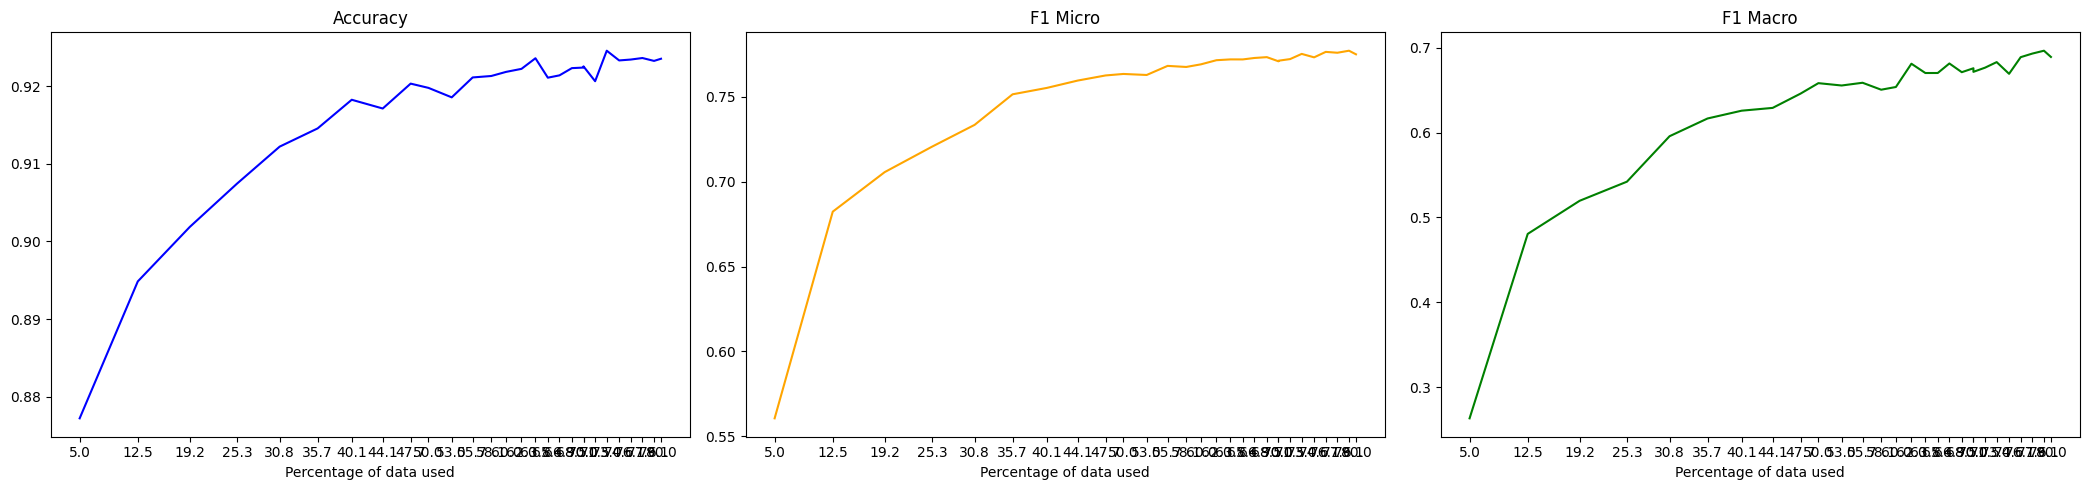

In [ ]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: [81, 90, 11]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5809, Accuracy: 0.8245, F1 Micro: 0.3956, F1 Macro: 0.1034
Epoch 2/10, Train Loss: 0.4658, Accuracy: 0.8348, F1 Micro: 0.2636, F1 Macro: 0.0592
Epoch 3/10, Train Loss: 0.397, Accuracy: 0.8338, F1 Micro: 0.0955, F1 Macro: 0.0378
Epoch 4/10, Train Loss: 0.3979, Accuracy: 0.8362, F1 Micro: 0.14, F1 Macro: 0.0465
Epoch 5/10, Train Loss: 0.383, Accuracy: 0.8437, F1 Micro: 0.2102, F1 Macro: 0.0769
Epoch 6/10, Train Loss: 0.3654, Accuracy: 0.8522, F1 Micro: 0.3188, F1 Macro: 0.1133
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3505, Accuracy: 0.8651, F1 Micro: 0.4503, F1 Macro: 0.1947
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3265, Accuracy: 0.8738, F1 Micro: 0.5242, F1 Macro: 0.2445
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2968, Accuracy: 0.8777, F1 Micro: 0.5603, F1 Macro: 0.2621
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2615, Accuracy: 0.8778, F1 Micro: 0.5617, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6069, Accuracy: 0.818, F1 Micro: 0.3417, F1 Macro: 0.0941
Epoch 2/10, Train Loss: 0.4689, Accuracy: 0.8331, F1 Micro: 0.122, F1 Macro: 0.0467
Epoch 3/10, Train Loss: 0.3944, Accuracy: 0.8344, F1 Micro: 0.0998, F1 Macro: 0.0364
Epoch 4/10, Train Loss: 0.3974, Accuracy: 0.8374, F1 Micro: 0.1422, F1 Macro: 0.047
Epoch 5/10, Train Loss: 0.3818, Accuracy: 0.8464, F1 Micro: 0.2441, F1 Macro: 0.0839
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3661, Accuracy: 0.8562, F1 Micro: 0.35, F1 Macro: 0.1133
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3507, Accuracy: 0.865, F1 Micro: 0.4447, F1 Macro: 0.1653
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.324, Accuracy: 0.8743, F1 Micro: 0.5154, F1 Macro: 0.2311
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2909, Accuracy: 0.8765, F1 Micro: 0.5649, F1 Macro: 0.2614
Epoch 10/10, Train Loss: 0.2604, Accuracy: 0.8767, F1 Micro: 0.557, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6221, Accuracy: 0.801, F1 Micro: 0.2723, F1 Macro: 0.0864
Epoch 2/10, Train Loss: 0.4752, Accuracy: 0.8292, F1 Micro: 0.0255, F1 Macro: 0.0111
Epoch 3/10, Train Loss: 0.3966, Accuracy: 0.83, F1 Micro: 0.0308, F1 Macro: 0.0133
Epoch 4/10, Train Loss: 0.4013, Accuracy: 0.8341, F1 Micro: 0.1023, F1 Macro: 0.0364
Epoch 5/10, Train Loss: 0.3872, Accuracy: 0.8389, F1 Micro: 0.1576, F1 Macro: 0.0571
Epoch 6/10, Train Loss: 0.3748, Accuracy: 0.8414, F1 Micro: 0.1864, F1 Macro: 0.0657
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3672, Accuracy: 0.8496, F1 Micro: 0.2928, F1 Macro: 0.0947
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3502, Accuracy: 0.8627, F1 Micro: 0.4235, F1 Macro: 0.1614
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3159, Accuracy: 0.8761, F1 Micro: 0.5531, F1 Macro: 0.2496
Epoch 10/10, Train Loss: 0.2849, Accuracy: 0.8769, F1 Micro: 0.5458, F1 Macro: 0.2515
Model 3 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5192, Accuracy: 0.8348, F1 Micro: 0.2139, F1 Macro: 0.0531
Epoch 2/10, Train Loss: 0.4011, Accuracy: 0.8356, F1 Micro: 0.1145, F1 Macro: 0.0437
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3731, Accuracy: 0.855, F1 Micro: 0.3571, F1 Macro: 0.1314
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3425, Accuracy: 0.8779, F1 Micro: 0.5606, F1 Macro: 0.2621
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2947, Accuracy: 0.8828, F1 Micro: 0.5844, F1 Macro: 0.2821
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2745, Accuracy: 0.8884, F1 Micro: 0.6498, F1 Macro: 0.3579
Epoch 7/10, Train Loss: 0.2518, Accuracy: 0.8906, F1 Micro: 0.6253, F1 Macro: 0.349
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2226, Accuracy: 0.893, F1 Micro: 0.6606, F1 Macro: 0.4214
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1918, Accuracy: 0.8957, F1 Micro: 0.6686, F1 Macro: 0.458
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5295, Accuracy: 0.8335, F1 Micro: 0.1176, F1 Macro: 0.0455
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3997, Accuracy: 0.8384, F1 Micro: 0.1466, F1 Macro: 0.0527
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3707, Accuracy: 0.8584, F1 Micro: 0.3971, F1 Macro: 0.124
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3371, Accuracy: 0.8753, F1 Micro: 0.5166, F1 Macro: 0.2335
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.291, Accuracy: 0.8797, F1 Micro: 0.614, F1 Macro: 0.3001
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.273, Accuracy: 0.8859, F1 Micro: 0.6209, F1 Macro: 0.3233
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2497, Accuracy: 0.8911, F1 Micro: 0.6504, F1 Macro: 0.369
Epoch 8/10, Train Loss: 0.2224, Accuracy: 0.8922, F1 Micro: 0.6473, F1 Macro: 0.398
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1926, Accuracy: 0.8947, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5415, Accuracy: 0.8288, F1 Micro: 0.0174, F1 Macro: 0.0077
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4042, Accuracy: 0.8329, F1 Micro: 0.0732, F1 Macro: 0.0283
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3804, Accuracy: 0.843, F1 Micro: 0.2115, F1 Macro: 0.0705
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3575, Accuracy: 0.8668, F1 Micro: 0.4376, F1 Macro: 0.1784
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3076, Accuracy: 0.8804, F1 Micro: 0.5769, F1 Macro: 0.2725
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2862, Accuracy: 0.8843, F1 Micro: 0.6376, F1 Macro: 0.3628
Epoch 7/10, Train Loss: 0.2562, Accuracy: 0.89, F1 Micro: 0.6241, F1 Macro: 0.3711
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2262, Accuracy: 0.8931, F1 Micro: 0.6551, F1 Macro: 0.4221
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1977, Accuracy: 0.8964, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4775, Accuracy: 0.8342, F1 Micro: 0.1027, F1 Macro: 0.0406
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3785, Accuracy: 0.8554, F1 Micro: 0.3574, F1 Macro: 0.1341
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3315, Accuracy: 0.8834, F1 Micro: 0.5923, F1 Macro: 0.2787
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2904, Accuracy: 0.89, F1 Micro: 0.6442, F1 Macro: 0.3425
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2498, Accuracy: 0.8938, F1 Micro: 0.6584, F1 Macro: 0.393
Epoch 6/10, Train Loss: 0.2266, Accuracy: 0.8962, F1 Micro: 0.6427, F1 Macro: 0.4024
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1971, Accuracy: 0.8981, F1 Micro: 0.6801, F1 Macro: 0.4719
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1836, Accuracy: 0.9027, F1 Micro: 0.7027, F1 Macro: 0.4969
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1583, Accuracy: 0.9044, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4874, Accuracy: 0.8366, F1 Micro: 0.1199, F1 Macro: 0.0465
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3791, Accuracy: 0.8542, F1 Micro: 0.3349, F1 Macro: 0.1096
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3307, Accuracy: 0.8795, F1 Micro: 0.5862, F1 Macro: 0.2739
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2888, Accuracy: 0.8875, F1 Micro: 0.6249, F1 Macro: 0.319
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2517, Accuracy: 0.894, F1 Micro: 0.6431, F1 Macro: 0.3689
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2274, Accuracy: 0.8969, F1 Micro: 0.6607, F1 Macro: 0.4286
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.201, Accuracy: 0.8985, F1 Micro: 0.6949, F1 Macro: 0.4929
Epoch 8/10, Train Loss: 0.1822, Accuracy: 0.9021, F1 Micro: 0.6935, F1 Macro: 0.5104
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1649, Accuracy: 0.904, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4936, Accuracy: 0.8296, F1 Micro: 0.0241, F1 Macro: 0.0106
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3847, Accuracy: 0.8488, F1 Micro: 0.2829, F1 Macro: 0.0928
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3455, Accuracy: 0.8788, F1 Micro: 0.5712, F1 Macro: 0.2622
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3004, Accuracy: 0.8869, F1 Micro: 0.6235, F1 Macro: 0.3404
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2564, Accuracy: 0.8947, F1 Micro: 0.6589, F1 Macro: 0.4192
Epoch 6/10, Train Loss: 0.2311, Accuracy: 0.8965, F1 Micro: 0.6459, F1 Macro: 0.4171
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2021, Accuracy: 0.8993, F1 Micro: 0.6935, F1 Macro: 0.4971
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1809, Accuracy: 0.903, F1 Micro: 0.711, F1 Macro: 0.5171
Epoch 9/10, Train Loss: 0.161, Accuracy: 0.9048, F1 Micro: 0.7074, F1 Macro: 0.5154
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4588, Accuracy: 0.8439, F1 Micro: 0.2248, F1 Macro: 0.0794
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3556, Accuracy: 0.8772, F1 Micro: 0.53, F1 Macro: 0.2443
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2972, Accuracy: 0.8917, F1 Micro: 0.6397, F1 Macro: 0.3477
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2592, Accuracy: 0.8988, F1 Micro: 0.6651, F1 Macro: 0.4222
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.222, Accuracy: 0.9017, F1 Micro: 0.6986, F1 Macro: 0.4808
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1929, Accuracy: 0.9067, F1 Micro: 0.7075, F1 Macro: 0.5358
Epoch 7/10, Train Loss: 0.1617, Accuracy: 0.907, F1 Micro: 0.7064, F1 Macro: 0.5273
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1422, Accuracy: 0.9079, F1 Micro: 0.7196, F1 Macro: 0.5515
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1197, Accuracy: 0.9105, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4654, Accuracy: 0.8464, F1 Micro: 0.248, F1 Macro: 0.0862
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3533, Accuracy: 0.8799, F1 Micro: 0.5682, F1 Macro: 0.2621
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3005, Accuracy: 0.8885, F1 Micro: 0.6336, F1 Macro: 0.3164
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2607, Accuracy: 0.8946, F1 Micro: 0.6513, F1 Macro: 0.3956
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2273, Accuracy: 0.8988, F1 Micro: 0.6954, F1 Macro: 0.4758
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1993, Accuracy: 0.9046, F1 Micro: 0.7018, F1 Macro: 0.5225
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1697, Accuracy: 0.9076, F1 Micro: 0.7122, F1 Macro: 0.5293
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1477, Accuracy: 0.9079, F1 Micro: 0.7171, F1 Macro: 0.5591
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4709, Accuracy: 0.8404, F1 Micro: 0.1721, F1 Macro: 0.0639
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3656, Accuracy: 0.8672, F1 Micro: 0.4334, F1 Macro: 0.1796
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3071, Accuracy: 0.8882, F1 Micro: 0.6393, F1 Macro: 0.3532
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.262, Accuracy: 0.8973, F1 Micro: 0.6615, F1 Macro: 0.4302
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.225, Accuracy: 0.9027, F1 Micro: 0.6985, F1 Macro: 0.4897
Epoch 6/10, Train Loss: 0.1967, Accuracy: 0.9046, F1 Micro: 0.6915, F1 Macro: 0.5238
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1656, Accuracy: 0.9072, F1 Micro: 0.7171, F1 Macro: 0.5251
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1407, Accuracy: 0.9098, F1 Micro: 0.7304, F1 Macro: 0.575
Epoch 9/10, Train Loss: 0.1219, Accuracy: 0.9097, F1 Micro: 0.713, F1 Macro: 0.5645
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4492, Accuracy: 0.8486, F1 Micro: 0.2983, F1 Macro: 0.0983
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3476, Accuracy: 0.8837, F1 Micro: 0.5889, F1 Macro: 0.2857
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2798, Accuracy: 0.8941, F1 Micro: 0.644, F1 Macro: 0.3677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2389, Accuracy: 0.8999, F1 Micro: 0.6717, F1 Macro: 0.4262
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2106, Accuracy: 0.9015, F1 Micro: 0.6893, F1 Macro: 0.4614
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1893, Accuracy: 0.9072, F1 Micro: 0.7274, F1 Macro: 0.5434
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.161, Accuracy: 0.9089, F1 Micro: 0.7313, F1 Macro: 0.5632
Epoch 8/10, Train Loss: 0.1361, Accuracy: 0.9106, F1 Micro: 0.7285, F1 Macro: 0.5793
Epoch 9/10, Train Loss: 0.1175, Accuracy: 0.91, F1 Micro: 0.7297, F1 Macro: 0.574
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4547, Accuracy: 0.852, F1 Micro: 0.3219, F1 Macro: 0.1044
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3439, Accuracy: 0.8825, F1 Micro: 0.5951, F1 Macro: 0.2819
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2817, Accuracy: 0.8934, F1 Micro: 0.6386, F1 Macro: 0.3537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2394, Accuracy: 0.8981, F1 Micro: 0.657, F1 Macro: 0.4101
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2153, Accuracy: 0.9035, F1 Micro: 0.7016, F1 Macro: 0.5109
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1914, Accuracy: 0.9077, F1 Micro: 0.7254, F1 Macro: 0.5373
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1645, Accuracy: 0.9095, F1 Micro: 0.7348, F1 Macro: 0.5575
Epoch 8/10, Train Loss: 0.1397, Accuracy: 0.9116, F1 Micro: 0.7298, F1 Macro: 0.5849
Epoch 9/10, Train Loss: 0.1212, Accuracy: 0.91, F1 Micro: 0.7289, F1 Macro: 0.5953
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4592, Accuracy: 0.8483, F1 Micro: 0.2951, F1 Macro: 0.0973
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3576, Accuracy: 0.8812, F1 Micro: 0.5652, F1 Macro: 0.263
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2862, Accuracy: 0.8935, F1 Micro: 0.6362, F1 Macro: 0.3873
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2405, Accuracy: 0.8992, F1 Micro: 0.6722, F1 Macro: 0.428
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2121, Accuracy: 0.9033, F1 Micro: 0.6907, F1 Macro: 0.4803
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1893, Accuracy: 0.9095, F1 Micro: 0.7285, F1 Macro: 0.5446
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.164, Accuracy: 0.9114, F1 Micro: 0.7414, F1 Macro: 0.582
Epoch 8/10, Train Loss: 0.1383, Accuracy: 0.9133, F1 Micro: 0.7256, F1 Macro: 0.5801
Epoch 9/10, Train Loss: 0.1183, Accuracy: 0.913, F1 Micro: 0.7339, F1 Macro: 0.592
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4347, Accuracy: 0.8539, F1 Micro: 0.3748, F1 Macro: 0.1192
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.331, Accuracy: 0.8872, F1 Micro: 0.6238, F1 Macro: 0.3137
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2729, Accuracy: 0.8983, F1 Micro: 0.6815, F1 Macro: 0.4178
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.233, Accuracy: 0.905, F1 Micro: 0.7099, F1 Macro: 0.5314
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2009, Accuracy: 0.906, F1 Micro: 0.7303, F1 Macro: 0.5589
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1742, Accuracy: 0.9069, F1 Micro: 0.7336, F1 Macro: 0.5583
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1401, Accuracy: 0.9121, F1 Micro: 0.7451, F1 Macro: 0.5848
Epoch 8/10, Train Loss: 0.1237, Accuracy: 0.9138, F1 Micro: 0.731, F1 Macro: 0.5786
Epoch 9/10, Train Loss: 0.1049, Accuracy: 0.912, F1 Micro: 0.7399, F1 Macro: 0.605
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4365, Accuracy: 0.8575, F1 Micro: 0.4029, F1 Macro: 0.1239
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3283, Accuracy: 0.8841, F1 Micro: 0.6043, F1 Macro: 0.3029
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2731, Accuracy: 0.8964, F1 Micro: 0.6789, F1 Macro: 0.407
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2345, Accuracy: 0.9042, F1 Micro: 0.6991, F1 Macro: 0.521
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2047, Accuracy: 0.9016, F1 Micro: 0.7268, F1 Macro: 0.5539
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1793, Accuracy: 0.91, F1 Micro: 0.7334, F1 Macro: 0.5651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1437, Accuracy: 0.9118, F1 Micro: 0.735, F1 Macro: 0.5839
Epoch 8/10, Train Loss: 0.123, Accuracy: 0.9129, F1 Micro: 0.7203, F1 Macro: 0.5709
Epoch 9/10, Train Loss: 0.1097, Accuracy: 0.912, F1 Micro: 0.7305, F1 Macro: 0.5949
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4425, Accuracy: 0.8525, F1 Micro: 0.3552, F1 Macro: 0.1106
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3396, Accuracy: 0.8833, F1 Micro: 0.6148, F1 Macro: 0.3143
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2752, Accuracy: 0.8984, F1 Micro: 0.6795, F1 Macro: 0.4239
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.233, Accuracy: 0.9055, F1 Micro: 0.7066, F1 Macro: 0.5319
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2015, Accuracy: 0.9085, F1 Micro: 0.7383, F1 Macro: 0.58
Epoch 6/10, Train Loss: 0.1747, Accuracy: 0.9098, F1 Micro: 0.7306, F1 Macro: 0.5578
Epoch 7/10, Train Loss: 0.1384, Accuracy: 0.9111, F1 Micro: 0.738, F1 Macro: 0.5915
Epoch 8/10, Train Loss: 0.1201, Accuracy: 0.912, F1 Micro: 0.721, F1 Macro: 0.5868
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1048, Accuracy: 0.9104, F1 Micro: 0.7404, F1 Macro: 0.6192
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4302, Accuracy: 0.865, F1 Micro: 0.4914, F1 Macro: 0.2058
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3177, Accuracy: 0.8914, F1 Micro: 0.6564, F1 Macro: 0.3802
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2621, Accuracy: 0.9017, F1 Micro: 0.6964, F1 Macro: 0.482
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2223, Accuracy: 0.9062, F1 Micro: 0.7216, F1 Macro: 0.5424
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1883, Accuracy: 0.9112, F1 Micro: 0.7283, F1 Macro: 0.5823
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1633, Accuracy: 0.9131, F1 Micro: 0.7432, F1 Macro: 0.5942
Epoch 7/10, Train Loss: 0.136, Accuracy: 0.9157, F1 Micro: 0.7394, F1 Macro: 0.5897
Epoch 8/10, Train Loss: 0.1132, Accuracy: 0.9134, F1 Micro: 0.7293, F1 Macro: 0.5877
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0994, Accuracy: 0.9151, F1 Micro: 0.7454, F1 Macro: 0.6032
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4317, Accuracy: 0.8656, F1 Micro: 0.4803, F1 Macro: 0.1854
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3151, Accuracy: 0.8893, F1 Micro: 0.6545, F1 Macro: 0.3616
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2633, Accuracy: 0.8998, F1 Micro: 0.6952, F1 Macro: 0.4713
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2227, Accuracy: 0.9042, F1 Micro: 0.72, F1 Macro: 0.5517
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1883, Accuracy: 0.9085, F1 Micro: 0.7279, F1 Macro: 0.5817
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1669, Accuracy: 0.9131, F1 Micro: 0.7367, F1 Macro: 0.5912
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1379, Accuracy: 0.9156, F1 Micro: 0.737, F1 Macro: 0.5971
Epoch 8/10, Train Loss: 0.1134, Accuracy: 0.9134, F1 Micro: 0.7344, F1 Macro: 0.5896
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0998, Accuracy: 0.914, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4391, Accuracy: 0.8549, F1 Micro: 0.3881, F1 Macro: 0.12
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3245, Accuracy: 0.8878, F1 Micro: 0.6576, F1 Macro: 0.4099
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2631, Accuracy: 0.9014, F1 Micro: 0.6846, F1 Macro: 0.4647
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2237, Accuracy: 0.9075, F1 Micro: 0.7216, F1 Macro: 0.5391
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1847, Accuracy: 0.9107, F1 Micro: 0.7234, F1 Macro: 0.5847
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1639, Accuracy: 0.9125, F1 Micro: 0.736, F1 Macro: 0.588
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1312, Accuracy: 0.9154, F1 Micro: 0.7444, F1 Macro: 0.6053
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1084, Accuracy: 0.9151, F1 Micro: 0.7486, F1 Macro: 0.6057
Epoch 9/10, Train Loss: 0.0945, Accuracy: 0.9163, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4238, Accuracy: 0.8711, F1 Micro: 0.5662, F1 Macro: 0.2615
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3106, Accuracy: 0.8937, F1 Micro: 0.6454, F1 Macro: 0.3896
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2528, Accuracy: 0.9037, F1 Micro: 0.6882, F1 Macro: 0.4918
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2186, Accuracy: 0.9095, F1 Micro: 0.7248, F1 Macro: 0.5467
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1826, Accuracy: 0.9116, F1 Micro: 0.7369, F1 Macro: 0.573
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1544, Accuracy: 0.9081, F1 Micro: 0.7474, F1 Macro: 0.5869
Epoch 7/10, Train Loss: 0.1331, Accuracy: 0.9147, F1 Micro: 0.7463, F1 Macro: 0.5994
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1089, Accuracy: 0.9161, F1 Micro: 0.7532, F1 Macro: 0.6067
Epoch 9/10, Train Loss: 0.0969, Accuracy: 0.9176, F1 Micro: 0.7485, F1 Macro: 0.614
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.426, Accuracy: 0.8715, F1 Micro: 0.5416, F1 Macro: 0.2322
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3078, Accuracy: 0.8915, F1 Micro: 0.6277, F1 Macro: 0.3609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2532, Accuracy: 0.9023, F1 Micro: 0.6775, F1 Macro: 0.4618
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.221, Accuracy: 0.9072, F1 Micro: 0.7051, F1 Macro: 0.532
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1854, Accuracy: 0.907, F1 Micro: 0.7347, F1 Macro: 0.5832
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1567, Accuracy: 0.9083, F1 Micro: 0.7428, F1 Macro: 0.5747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.138, Accuracy: 0.9134, F1 Micro: 0.7443, F1 Macro: 0.6018
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.112, Accuracy: 0.9124, F1 Micro: 0.7484, F1 Macro: 0.6037
Epoch 9/10, Train Loss: 0.096, Accuracy: 0.9156, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4326, Accuracy: 0.8584, F1 Micro: 0.4254, F1 Macro: 0.1607
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3189, Accuracy: 0.8912, F1 Micro: 0.6512, F1 Macro: 0.414
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2535, Accuracy: 0.9019, F1 Micro: 0.671, F1 Macro: 0.48
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2184, Accuracy: 0.91, F1 Micro: 0.7239, F1 Macro: 0.5586
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1847, Accuracy: 0.9119, F1 Micro: 0.7418, F1 Macro: 0.5915
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1533, Accuracy: 0.9118, F1 Micro: 0.7493, F1 Macro: 0.5965
Epoch 7/10, Train Loss: 0.1321, Accuracy: 0.9155, F1 Micro: 0.7486, F1 Macro: 0.6014
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1109, Accuracy: 0.9176, F1 Micro: 0.7504, F1 Macro: 0.6053
Epoch 9/10, Train Loss: 0.0962, Accuracy: 0.9181, F1 Micro: 0.7419, F1 Macro: 0.6181
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4167, Accuracy: 0.8743, F1 Micro: 0.5298, F1 Macro: 0.2472
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3062, Accuracy: 0.8904, F1 Micro: 0.6792, F1 Macro: 0.4214
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2459, Accuracy: 0.9057, F1 Micro: 0.6927, F1 Macro: 0.4988
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2101, Accuracy: 0.9088, F1 Micro: 0.734, F1 Macro: 0.5638
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1786, Accuracy: 0.9144, F1 Micro: 0.7372, F1 Macro: 0.5905
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1537, Accuracy: 0.9159, F1 Micro: 0.7568, F1 Macro: 0.6056
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1256, Accuracy: 0.9156, F1 Micro: 0.7577, F1 Macro: 0.6167
Epoch 8/10, Train Loss: 0.1076, Accuracy: 0.9168, F1 Micro: 0.7555, F1 Macro: 0.6297
Epoch 9/10, Train Loss: 0.0932, Accuracy: 0.9179, F1 Micro: 0.7547, F1 Macro: 0.6318
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4192, Accuracy: 0.8765, F1 Micro: 0.5464, F1 Macro: 0.2418
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.307, Accuracy: 0.8896, F1 Micro: 0.6806, F1 Macro: 0.4077
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2481, Accuracy: 0.9058, F1 Micro: 0.6984, F1 Macro: 0.4971
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2127, Accuracy: 0.9088, F1 Micro: 0.733, F1 Macro: 0.5545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1786, Accuracy: 0.9133, F1 Micro: 0.7365, F1 Macro: 0.5765
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1567, Accuracy: 0.9159, F1 Micro: 0.747, F1 Macro: 0.5906
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1315, Accuracy: 0.9159, F1 Micro: 0.7542, F1 Macro: 0.6222
Epoch 8/10, Train Loss: 0.1104, Accuracy: 0.9153, F1 Micro: 0.7478, F1 Macro: 0.6238
Epoch 9/10, Train Loss: 0.0971, Accuracy: 0.9175, F1 Micro: 0.7492, F1 Macro: 0.6353
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4276, Accuracy: 0.8612, F1 Micro: 0.4014, F1 Macro: 0.1632
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3094, Accuracy: 0.8933, F1 Micro: 0.6681, F1 Macro: 0.4132
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2464, Accuracy: 0.9068, F1 Micro: 0.7102, F1 Macro: 0.5206
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.209, Accuracy: 0.9122, F1 Micro: 0.7422, F1 Macro: 0.5773
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1729, Accuracy: 0.9147, F1 Micro: 0.7535, F1 Macro: 0.6048
Epoch 6/10, Train Loss: 0.1536, Accuracy: 0.916, F1 Micro: 0.7434, F1 Macro: 0.5929
Epoch 7/10, Train Loss: 0.1221, Accuracy: 0.9156, F1 Micro: 0.7489, F1 Macro: 0.6189
Epoch 8/10, Train Loss: 0.1036, Accuracy: 0.9161, F1 Micro: 0.7532, F1 Macro: 0.639
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0888, Accuracy: 0.9203, F1 Micro: 0.7634, F1 Macro: 0.6504
Epoch 10/10, Train Loss: 0.0763, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4172, Accuracy: 0.8728, F1 Micro: 0.5071, F1 Macro: 0.2322
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2982, Accuracy: 0.8961, F1 Micro: 0.6657, F1 Macro: 0.3805
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2447, Accuracy: 0.9054, F1 Micro: 0.7219, F1 Macro: 0.526
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2101, Accuracy: 0.9116, F1 Micro: 0.732, F1 Macro: 0.5522
Epoch 5/10, Train Loss: 0.1749, Accuracy: 0.9133, F1 Micro: 0.7211, F1 Macro: 0.5545
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1497, Accuracy: 0.9187, F1 Micro: 0.7543, F1 Macro: 0.6069
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1251, Accuracy: 0.9209, F1 Micro: 0.7636, F1 Macro: 0.6272
Epoch 8/10, Train Loss: 0.1088, Accuracy: 0.9216, F1 Micro: 0.7538, F1 Macro: 0.6394
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.09, Accuracy: 0.9196, F1 Micro: 0.7647, F1 Macro: 0.6402
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4167, Accuracy: 0.8766, F1 Micro: 0.5554, F1 Macro: 0.2503
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2975, Accuracy: 0.8942, F1 Micro: 0.6637, F1 Macro: 0.3714
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2453, Accuracy: 0.9045, F1 Micro: 0.7142, F1 Macro: 0.5233
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2075, Accuracy: 0.9105, F1 Micro: 0.7282, F1 Macro: 0.536
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.174, Accuracy: 0.9145, F1 Micro: 0.7353, F1 Macro: 0.5761
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1521, Accuracy: 0.9138, F1 Micro: 0.7522, F1 Macro: 0.5987
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1253, Accuracy: 0.9191, F1 Micro: 0.7558, F1 Macro: 0.6318
Epoch 8/10, Train Loss: 0.104, Accuracy: 0.9184, F1 Micro: 0.7505, F1 Macro: 0.6278
Epoch 9/10, Train Loss: 0.0901, Accuracy: 0.9166, F1 Micro: 0.7506, F1 Macro: 0.6525
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4258, Accuracy: 0.8661, F1 Micro: 0.4563, F1 Macro: 0.1888
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3046, Accuracy: 0.8926, F1 Micro: 0.6534, F1 Macro: 0.3501
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2476, Accuracy: 0.9062, F1 Micro: 0.7159, F1 Macro: 0.5083
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2089, Accuracy: 0.9104, F1 Micro: 0.7226, F1 Macro: 0.5447
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1752, Accuracy: 0.9142, F1 Micro: 0.73, F1 Macro: 0.5898
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1485, Accuracy: 0.9138, F1 Micro: 0.7564, F1 Macro: 0.6048
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.122, Accuracy: 0.9186, F1 Micro: 0.7632, F1 Macro: 0.6451
Epoch 8/10, Train Loss: 0.1063, Accuracy: 0.9197, F1 Micro: 0.7525, F1 Macro: 0.6362
Epoch 9/10, Train Loss: 0.0877, Accuracy: 0.9173, F1 Micro: 0.7595, F1 Macro: 0.6476
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4105, Accuracy: 0.8778, F1 Micro: 0.6105, F1 Macro: 0.2839
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2882, Accuracy: 0.8995, F1 Micro: 0.6865, F1 Macro: 0.4431
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2398, Accuracy: 0.9072, F1 Micro: 0.7195, F1 Macro: 0.4985
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2037, Accuracy: 0.9133, F1 Micro: 0.7225, F1 Macro: 0.5701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1754, Accuracy: 0.9158, F1 Micro: 0.7495, F1 Macro: 0.5774
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1406, Accuracy: 0.9182, F1 Micro: 0.7531, F1 Macro: 0.6059
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1218, Accuracy: 0.9191, F1 Micro: 0.7629, F1 Macro: 0.6192
Epoch 8/10, Train Loss: 0.1032, Accuracy: 0.9209, F1 Micro: 0.7625, F1 Macro: 0.6397
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0862, Accuracy: 0.9195, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4128, Accuracy: 0.8791, F1 Micro: 0.5924, F1 Macro: 0.2698
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2891, Accuracy: 0.8987, F1 Micro: 0.6843, F1 Macro: 0.4358
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2417, Accuracy: 0.9041, F1 Micro: 0.7159, F1 Macro: 0.4929
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2041, Accuracy: 0.912, F1 Micro: 0.7217, F1 Macro: 0.5717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1776, Accuracy: 0.9161, F1 Micro: 0.7563, F1 Macro: 0.5948
Epoch 6/10, Train Loss: 0.1441, Accuracy: 0.9158, F1 Micro: 0.751, F1 Macro: 0.6091
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1245, Accuracy: 0.9181, F1 Micro: 0.7578, F1 Macro: 0.6236
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1032, Accuracy: 0.9206, F1 Micro: 0.7605, F1 Macro: 0.6504
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0924, Accuracy: 0.9197, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4225, Accuracy: 0.8741, F1 Micro: 0.5453, F1 Macro: 0.2398
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2943, Accuracy: 0.8996, F1 Micro: 0.6917, F1 Macro: 0.4734
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2439, Accuracy: 0.9049, F1 Micro: 0.7152, F1 Macro: 0.4837
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2054, Accuracy: 0.9145, F1 Micro: 0.7273, F1 Macro: 0.5819
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1761, Accuracy: 0.9172, F1 Micro: 0.7556, F1 Macro: 0.6006
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1419, Accuracy: 0.9174, F1 Micro: 0.7616, F1 Macro: 0.6291
Epoch 7/10, Train Loss: 0.1185, Accuracy: 0.9158, F1 Micro: 0.7573, F1 Macro: 0.6186
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1015, Accuracy: 0.9207, F1 Micro: 0.7641, F1 Macro: 0.6519
Epoch 9/10, Train Loss: 0.0859, Accuracy: 0.9176, F1 Micro: 0.7638, F1 Macro: 0.6523
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4058, Accuracy: 0.8813, F1 Micro: 0.5794, F1 Macro: 0.2679
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2897, Accuracy: 0.8996, F1 Micro: 0.6845, F1 Macro: 0.448
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2369, Accuracy: 0.909, F1 Micro: 0.7022, F1 Macro: 0.5197
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1979, Accuracy: 0.9135, F1 Micro: 0.7434, F1 Macro: 0.5763
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1685, Accuracy: 0.9186, F1 Micro: 0.7487, F1 Macro: 0.5891
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.144, Accuracy: 0.9199, F1 Micro: 0.7611, F1 Macro: 0.6212
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1201, Accuracy: 0.9212, F1 Micro: 0.7632, F1 Macro: 0.6264
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1034, Accuracy: 0.9184, F1 Micro: 0.7676, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4086, Accuracy: 0.879, F1 Micro: 0.5397, F1 Macro: 0.2423
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2912, Accuracy: 0.9005, F1 Micro: 0.6864, F1 Macro: 0.4652
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2409, Accuracy: 0.9081, F1 Micro: 0.6916, F1 Macro: 0.5069
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2018, Accuracy: 0.9115, F1 Micro: 0.7391, F1 Macro: 0.566
Epoch 5/10, Train Loss: 0.171, Accuracy: 0.9153, F1 Micro: 0.7385, F1 Macro: 0.5869
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1462, Accuracy: 0.9182, F1 Micro: 0.7537, F1 Macro: 0.6126
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1228, Accuracy: 0.9181, F1 Micro: 0.7552, F1 Macro: 0.6151
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1041, Accuracy: 0.9189, F1 Micro: 0.7567, F1 Macro: 0.6378
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0852, Accuracy: 0.921, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4157, Accuracy: 0.8752, F1 Micro: 0.5222, F1 Macro: 0.2267
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2938, Accuracy: 0.8995, F1 Micro: 0.6994, F1 Macro: 0.4938
Epoch 3/10, Train Loss: 0.2409, Accuracy: 0.9092, F1 Micro: 0.6975, F1 Macro: 0.5226
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1988, Accuracy: 0.9159, F1 Micro: 0.7528, F1 Macro: 0.5969
Epoch 5/10, Train Loss: 0.1681, Accuracy: 0.9189, F1 Micro: 0.7471, F1 Macro: 0.6004
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1437, Accuracy: 0.9205, F1 Micro: 0.7629, F1 Macro: 0.623
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1203, Accuracy: 0.9201, F1 Micro: 0.767, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1037, Accuracy: 0.9188, F1 Micro: 0.7688, F1 Macro: 0.6594
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0825, Accuracy: 0.92, F1 Micro: 0.7698, F1 Macro: 0.6648
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4018, Accuracy: 0.8813, F1 Micro: 0.6067, F1 Macro: 0.2832
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2843, Accuracy: 0.9019, F1 Micro: 0.6983, F1 Macro: 0.4809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2352, Accuracy: 0.9108, F1 Micro: 0.7174, F1 Macro: 0.524
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1954, Accuracy: 0.9139, F1 Micro: 0.7303, F1 Macro: 0.5711
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1653, Accuracy: 0.9171, F1 Micro: 0.7543, F1 Macro: 0.6023
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1392, Accuracy: 0.9177, F1 Micro: 0.765, F1 Macro: 0.6494
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1189, Accuracy: 0.9219, F1 Micro: 0.7681, F1 Macro: 0.6503
Epoch 8/10, Train Loss: 0.1034, Accuracy: 0.9203, F1 Micro: 0.7514, F1 Macro: 0.6074
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0872, Accuracy: 0.9209, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4034, Accuracy: 0.8792, F1 Micro: 0.5976, F1 Macro: 0.276
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2861, Accuracy: 0.9004, F1 Micro: 0.6947, F1 Macro: 0.4806
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2374, Accuracy: 0.9097, F1 Micro: 0.7081, F1 Macro: 0.536
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1976, Accuracy: 0.916, F1 Micro: 0.7417, F1 Macro: 0.5775
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1653, Accuracy: 0.9166, F1 Micro: 0.7587, F1 Macro: 0.6189
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1455, Accuracy: 0.9197, F1 Micro: 0.7647, F1 Macro: 0.6407
Epoch 7/10, Train Loss: 0.1211, Accuracy: 0.9195, F1 Micro: 0.7646, F1 Macro: 0.6645
Epoch 8/10, Train Loss: 0.1013, Accuracy: 0.916, F1 Micro: 0.7593, F1 Macro: 0.6373
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0946, Accuracy: 0.9179, F1 Micro: 0.766, F1 Macro: 0.6585
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4118, Accuracy: 0.8773, F1 Micro: 0.5479, F1 Macro: 0.2482
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2887, Accuracy: 0.9011, F1 Micro: 0.7019, F1 Macro: 0.4936
Epoch 3/10, Train Loss: 0.2352, Accuracy: 0.9084, F1 Micro: 0.6896, F1 Macro: 0.5087
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1961, Accuracy: 0.9161, F1 Micro: 0.7423, F1 Macro: 0.591
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1618, Accuracy: 0.9179, F1 Micro: 0.7609, F1 Macro: 0.6179
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1398, Accuracy: 0.9215, F1 Micro: 0.768, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.1178, Accuracy: 0.9213, F1 Micro: 0.7621, F1 Macro: 0.6572
Epoch 8/10, Train Loss: 0.1012, Accuracy: 0.9203, F1 Micro: 0.768, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0846, Accuracy: 0.9206, F1 Micro: 0.7699, F1 Macro: 0.6685
Epoch 10/10, Train Loss: 0.0676, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.399, Accuracy: 0.8834, F1 Micro: 0.5904, F1 Macro: 0.2876
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2802, Accuracy: 0.9019, F1 Micro: 0.6708, F1 Macro: 0.4709
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2351, Accuracy: 0.9055, F1 Micro: 0.732, F1 Macro: 0.5458
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1989, Accuracy: 0.914, F1 Micro: 0.751, F1 Macro: 0.5856
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1704, Accuracy: 0.919, F1 Micro: 0.7573, F1 Macro: 0.602
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1399, Accuracy: 0.9201, F1 Micro: 0.7614, F1 Macro: 0.6205
Epoch 7/10, Train Loss: 0.1173, Accuracy: 0.9212, F1 Micro: 0.7536, F1 Macro: 0.6263
Epoch 8/10, Train Loss: 0.0996, Accuracy: 0.9203, F1 Micro: 0.7607, F1 Macro: 0.643
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0869, Accuracy: 0.9214, F1 Micro: 0.7689, F1 Macro: 0.6527
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3997, Accuracy: 0.8823, F1 Micro: 0.6017, F1 Macro: 0.2896
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2775, Accuracy: 0.9015, F1 Micro: 0.6765, F1 Macro: 0.4731
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2359, Accuracy: 0.9069, F1 Micro: 0.7325, F1 Macro: 0.5426
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1997, Accuracy: 0.9116, F1 Micro: 0.7515, F1 Macro: 0.5928
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1707, Accuracy: 0.92, F1 Micro: 0.7646, F1 Macro: 0.6177
Epoch 6/10, Train Loss: 0.1433, Accuracy: 0.9222, F1 Micro: 0.7603, F1 Macro: 0.6392
Epoch 7/10, Train Loss: 0.1179, Accuracy: 0.9203, F1 Micro: 0.7567, F1 Macro: 0.6297
Epoch 8/10, Train Loss: 0.0994, Accuracy: 0.9216, F1 Micro: 0.7596, F1 Macro: 0.6434
Epoch 9/10, Train Loss: 0.0888, Accuracy: 0.9213, F1 Micro: 0.7633, F1 Macro: 0.6406
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0745, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4095, Accuracy: 0.8792, F1 Micro: 0.5553, F1 Macro: 0.2512
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2831, Accuracy: 0.8998, F1 Micro: 0.6725, F1 Macro: 0.4861
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2348, Accuracy: 0.9083, F1 Micro: 0.7336, F1 Macro: 0.5406
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1984, Accuracy: 0.9159, F1 Micro: 0.757, F1 Macro: 0.602
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1693, Accuracy: 0.9211, F1 Micro: 0.762, F1 Macro: 0.6121
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1378, Accuracy: 0.9207, F1 Micro: 0.7691, F1 Macro: 0.6276
Epoch 7/10, Train Loss: 0.1126, Accuracy: 0.9205, F1 Micro: 0.7627, F1 Macro: 0.6526
Epoch 8/10, Train Loss: 0.0943, Accuracy: 0.9221, F1 Micro: 0.7652, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0843, Accuracy: 0.9213, F1 Micro: 0.7711, F1 Macro: 0.6667
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4021, Accuracy: 0.8832, F1 Micro: 0.6026, F1 Macro: 0.2861
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2799, Accuracy: 0.9036, F1 Micro: 0.6911, F1 Macro: 0.4498
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2323, Accuracy: 0.9083, F1 Micro: 0.7283, F1 Macro: 0.5518
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.195, Accuracy: 0.9156, F1 Micro: 0.75, F1 Macro: 0.5789
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1645, Accuracy: 0.9213, F1 Micro: 0.7607, F1 Macro: 0.5996
Epoch 6/10, Train Loss: 0.1336, Accuracy: 0.9221, F1 Micro: 0.7562, F1 Macro: 0.615
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1176, Accuracy: 0.9219, F1 Micro: 0.7626, F1 Macro: 0.6464
Epoch 8/10, Train Loss: 0.0944, Accuracy: 0.9227, F1 Micro: 0.7626, F1 Macro: 0.6501
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0859, Accuracy: 0.9223, F1 Micro: 0.772, F1 Macro: 0.6655
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4014, Accuracy: 0.8821, F1 Micro: 0.6039, F1 Macro: 0.2865
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2801, Accuracy: 0.904, F1 Micro: 0.6967, F1 Macro: 0.468
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2337, Accuracy: 0.9079, F1 Micro: 0.721, F1 Macro: 0.5553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1968, Accuracy: 0.9151, F1 Micro: 0.7532, F1 Macro: 0.5867
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1637, Accuracy: 0.9194, F1 Micro: 0.7577, F1 Macro: 0.6225
Epoch 6/10, Train Loss: 0.1361, Accuracy: 0.9188, F1 Micro: 0.7499, F1 Macro: 0.6049
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1195, Accuracy: 0.9218, F1 Micro: 0.7683, F1 Macro: 0.6556
Epoch 8/10, Train Loss: 0.0968, Accuracy: 0.9205, F1 Micro: 0.7658, F1 Macro: 0.6431
Epoch 9/10, Train Loss: 0.0852, Accuracy: 0.9197, F1 Micro: 0.7677, F1 Macro: 0.6765
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4103, Accuracy: 0.8816, F1 Micro: 0.6011, F1 Macro: 0.2823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.284, Accuracy: 0.9037, F1 Micro: 0.6893, F1 Macro: 0.4814
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2341, Accuracy: 0.9104, F1 Micro: 0.7196, F1 Macro: 0.5601
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1961, Accuracy: 0.9167, F1 Micro: 0.7626, F1 Macro: 0.6008
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1646, Accuracy: 0.9215, F1 Micro: 0.7652, F1 Macro: 0.6097
Epoch 6/10, Train Loss: 0.1341, Accuracy: 0.9214, F1 Micro: 0.7604, F1 Macro: 0.6196
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1146, Accuracy: 0.9228, F1 Micro: 0.7716, F1 Macro: 0.6619
Epoch 8/10, Train Loss: 0.0932, Accuracy: 0.9231, F1 Micro: 0.7714, F1 Macro: 0.6656
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0815, Accuracy: 0.9221, F1 Micro: 0.7718, F1 Macro: 0.6784
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.396, Accuracy: 0.8813, F1 Micro: 0.6315, F1 Macro: 0.3106
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2802, Accuracy: 0.9037, F1 Micro: 0.6896, F1 Macro: 0.4825
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.23, Accuracy: 0.9107, F1 Micro: 0.7369, F1 Macro: 0.5793
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1975, Accuracy: 0.9167, F1 Micro: 0.7539, F1 Macro: 0.5982
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1608, Accuracy: 0.9199, F1 Micro: 0.7571, F1 Macro: 0.6048
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1407, Accuracy: 0.921, F1 Micro: 0.7688, F1 Macro: 0.6174
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1171, Accuracy: 0.9226, F1 Micro: 0.7735, F1 Macro: 0.6619
Epoch 8/10, Train Loss: 0.1007, Accuracy: 0.9215, F1 Micro: 0.7701, F1 Macro: 0.6526
Epoch 9/10, Train Loss: 0.0807, Accuracy: 0.9147, F1 Micro: 0.7641, F1 Macro: 0.6576
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.397, Accuracy: 0.8804, F1 Micro: 0.6183, F1 Macro: 0.2987
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2808, Accuracy: 0.9035, F1 Micro: 0.6925, F1 Macro: 0.4861
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2309, Accuracy: 0.9097, F1 Micro: 0.7359, F1 Macro: 0.5771
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1983, Accuracy: 0.9168, F1 Micro: 0.7588, F1 Macro: 0.6038
Epoch 5/10, Train Loss: 0.1634, Accuracy: 0.9192, F1 Micro: 0.7536, F1 Macro: 0.614
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1444, Accuracy: 0.9183, F1 Micro: 0.7646, F1 Macro: 0.6279
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1154, Accuracy: 0.9189, F1 Micro: 0.7654, F1 Macro: 0.6584
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1006, Accuracy: 0.923, F1 Micro: 0.7659, F1 Macro: 0.6389
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0806, Accuracy: 0.9196, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4064, Accuracy: 0.881, F1 Micro: 0.5958, F1 Macro: 0.2853
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.282, Accuracy: 0.9011, F1 Micro: 0.664, F1 Macro: 0.4755
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2288, Accuracy: 0.9113, F1 Micro: 0.7423, F1 Macro: 0.5868
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1946, Accuracy: 0.9195, F1 Micro: 0.7642, F1 Macro: 0.6088
Epoch 5/10, Train Loss: 0.1587, Accuracy: 0.9211, F1 Micro: 0.7603, F1 Macro: 0.6175
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1367, Accuracy: 0.9213, F1 Micro: 0.7682, F1 Macro: 0.6281
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1121, Accuracy: 0.9231, F1 Micro: 0.7736, F1 Macro: 0.6659
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.094, Accuracy: 0.9247, F1 Micro: 0.7786, F1 Macro: 0.673
Epoch 9/10, Train Loss: 0.0781, Accuracy: 0.922, F1 Micro: 0.7736, F1 Macro: 0.6768
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3905, Accuracy: 0.8851, F1 Micro: 0.6015, F1 Macro: 0.302
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2729, Accuracy: 0.9043, F1 Micro: 0.7103, F1 Macro: 0.5032
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.221, Accuracy: 0.9121, F1 Micro: 0.7376, F1 Macro: 0.574
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.19, Accuracy: 0.9196, F1 Micro: 0.7548, F1 Macro: 0.5956
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1547, Accuracy: 0.921, F1 Micro: 0.7662, F1 Macro: 0.6009
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1354, Accuracy: 0.9187, F1 Micro: 0.7697, F1 Macro: 0.6466
Epoch 7/10, Train Loss: 0.1136, Accuracy: 0.9246, F1 Micro: 0.7692, F1 Macro: 0.643
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0923, Accuracy: 0.9245, F1 Micro: 0.7753, F1 Macro: 0.6589
Epoch 9/10, Train Loss: 0.0805, Accuracy: 0.9208, F1 Micro: 0.7735, F1 Macro: 0.6758
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3924, Accuracy: 0.8834, F1 Micro: 0.6011, F1 Macro: 0.2897
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2736, Accuracy: 0.9039, F1 Micro: 0.7081, F1 Macro: 0.509
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2231, Accuracy: 0.9121, F1 Micro: 0.7286, F1 Macro: 0.5666
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1912, Accuracy: 0.919, F1 Micro: 0.7517, F1 Macro: 0.5993
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1587, Accuracy: 0.9207, F1 Micro: 0.7626, F1 Macro: 0.632
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1384, Accuracy: 0.9206, F1 Micro: 0.7704, F1 Macro: 0.6562
Epoch 7/10, Train Loss: 0.1135, Accuracy: 0.9221, F1 Micro: 0.769, F1 Macro: 0.6488
Epoch 8/10, Train Loss: 0.0939, Accuracy: 0.9208, F1 Micro: 0.7672, F1 Macro: 0.6605
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0804, Accuracy: 0.9213, F1 Micro: 0.7705, F1 Macro: 0.6812
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4011, Accuracy: 0.8819, F1 Micro: 0.5742, F1 Macro: 0.2784
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2745, Accuracy: 0.9051, F1 Micro: 0.7044, F1 Macro: 0.5017
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.222, Accuracy: 0.9134, F1 Micro: 0.7342, F1 Macro: 0.5758
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1881, Accuracy: 0.9213, F1 Micro: 0.7637, F1 Macro: 0.6122
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1545, Accuracy: 0.9238, F1 Micro: 0.7752, F1 Macro: 0.6359
Epoch 6/10, Train Loss: 0.1339, Accuracy: 0.9193, F1 Micro: 0.7717, F1 Macro: 0.6493
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1105, Accuracy: 0.9259, F1 Micro: 0.7755, F1 Macro: 0.668
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0907, Accuracy: 0.9241, F1 Micro: 0.7759, F1 Macro: 0.6686
Epoch 9/10, Train Loss: 0.0776, Accuracy: 0.9214, F1 Micro: 0.7681, F1 Macro: 0.6763
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3894, Accuracy: 0.8838, F1 Micro: 0.5804, F1 Macro: 0.2839
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.276, Accuracy: 0.9075, F1 Micro: 0.7102, F1 Macro: 0.5001
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2213, Accuracy: 0.9139, F1 Micro: 0.7359, F1 Macro: 0.5469
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1893, Accuracy: 0.9178, F1 Micro: 0.7584, F1 Macro: 0.6026
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1569, Accuracy: 0.9226, F1 Micro: 0.7684, F1 Macro: 0.6185
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1317, Accuracy: 0.9239, F1 Micro: 0.7708, F1 Macro: 0.6429
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.108, Accuracy: 0.9226, F1 Micro: 0.7745, F1 Macro: 0.6702
Epoch 8/10, Train Loss: 0.0909, Accuracy: 0.924, F1 Micro: 0.7712, F1 Macro: 0.6661
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0822, Accuracy: 0.9248, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3903, Accuracy: 0.883, F1 Micro: 0.5826, F1 Macro: 0.2785
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2769, Accuracy: 0.9058, F1 Micro: 0.6996, F1 Macro: 0.4896
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2238, Accuracy: 0.913, F1 Micro: 0.7408, F1 Macro: 0.5596
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1909, Accuracy: 0.9181, F1 Micro: 0.7537, F1 Macro: 0.6091
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1577, Accuracy: 0.9225, F1 Micro: 0.7617, F1 Macro: 0.634
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1336, Accuracy: 0.9229, F1 Micro: 0.7681, F1 Macro: 0.6275
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1055, Accuracy: 0.9203, F1 Micro: 0.7706, F1 Macro: 0.6738
Epoch 8/10, Train Loss: 0.0957, Accuracy: 0.9197, F1 Micro: 0.7682, F1 Macro: 0.6626
Epoch 9/10, Train Loss: 0.0807, Accuracy: 0.9212, F1 Micro: 0.7701, F1 Macro: 0.6797
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3979, Accuracy: 0.881, F1 Micro: 0.556, F1 Macro: 0.2624
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2787, Accuracy: 0.9059, F1 Micro: 0.7077, F1 Macro: 0.5104
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2227, Accuracy: 0.916, F1 Micro: 0.7467, F1 Macro: 0.5592
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1888, Accuracy: 0.9187, F1 Micro: 0.7593, F1 Macro: 0.6138
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.157, Accuracy: 0.9233, F1 Micro: 0.7686, F1 Macro: 0.6269
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1311, Accuracy: 0.9221, F1 Micro: 0.773, F1 Macro: 0.6446
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1022, Accuracy: 0.9247, F1 Micro: 0.7828, F1 Macro: 0.6924
Epoch 8/10, Train Loss: 0.0879, Accuracy: 0.9251, F1 Micro: 0.7814, F1 Macro: 0.6853
Epoch 9/10, Train Loss: 0.0802, Accuracy: 0.9254, F1 Micro: 0.7787, F1 Macro: 0.7017
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3858, Accuracy: 0.8852, F1 Micro: 0.6316, F1 Macro: 0.3181
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2709, Accuracy: 0.9042, F1 Micro: 0.6808, F1 Macro: 0.4862
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2166, Accuracy: 0.9137, F1 Micro: 0.7427, F1 Macro: 0.5681
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1811, Accuracy: 0.9198, F1 Micro: 0.7512, F1 Macro: 0.6036
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1562, Accuracy: 0.9231, F1 Micro: 0.7698, F1 Macro: 0.6345
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1283, Accuracy: 0.9238, F1 Micro: 0.7757, F1 Macro: 0.6476
Epoch 7/10, Train Loss: 0.1068, Accuracy: 0.9225, F1 Micro: 0.7725, F1 Macro: 0.6617
Epoch 8/10, Train Loss: 0.0897, Accuracy: 0.9233, F1 Micro: 0.768, F1 Macro: 0.6518
Epoch 9/10, Train Loss: 0.0773, Accuracy: 0.9231, F1 Micro: 0.7749, F1 Macro: 0.672
Epoch 10/10, Train Loss: 0.0648, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.388, Accuracy: 0.8837, F1 Micro: 0.625, F1 Macro: 0.3156
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2719, Accuracy: 0.9049, F1 Micro: 0.6952, F1 Macro: 0.487
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2211, Accuracy: 0.9146, F1 Micro: 0.7433, F1 Macro: 0.5712
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1821, Accuracy: 0.9186, F1 Micro: 0.7458, F1 Macro: 0.5965
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1593, Accuracy: 0.9207, F1 Micro: 0.7528, F1 Macro: 0.6152
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1307, Accuracy: 0.9239, F1 Micro: 0.7732, F1 Macro: 0.6588
Epoch 7/10, Train Loss: 0.1112, Accuracy: 0.9239, F1 Micro: 0.7656, F1 Macro: 0.6499
Epoch 8/10, Train Loss: 0.0923, Accuracy: 0.9217, F1 Micro: 0.7715, F1 Macro: 0.6643
Epoch 9/10, Train Loss: 0.0801, Accuracy: 0.9234, F1 Micro: 0.7652, F1 Macro: 0.6802
Epoch 10/10, Train Loss: 0.0691, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3965, Accuracy: 0.8822, F1 Micro: 0.6009, F1 Macro: 0.2943
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.274, Accuracy: 0.9051, F1 Micro: 0.6984, F1 Macro: 0.4946
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2196, Accuracy: 0.9157, F1 Micro: 0.7452, F1 Macro: 0.583
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.18, Accuracy: 0.9198, F1 Micro: 0.7597, F1 Macro: 0.6158
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1537, Accuracy: 0.9222, F1 Micro: 0.7669, F1 Macro: 0.6382
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1278, Accuracy: 0.9237, F1 Micro: 0.7736, F1 Macro: 0.6394
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1065, Accuracy: 0.9244, F1 Micro: 0.7759, F1 Macro: 0.674
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.9214, F1 Micro: 0.7768, F1 Macro: 0.6802
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.07

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.388, Accuracy: 0.8845, F1 Micro: 0.5835, F1 Macro: 0.2926
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2661, Accuracy: 0.9073, F1 Micro: 0.7111, F1 Macro: 0.5229
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2222, Accuracy: 0.9152, F1 Micro: 0.7457, F1 Macro: 0.5897
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.185, Accuracy: 0.9106, F1 Micro: 0.753, F1 Macro: 0.6028
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.152, Accuracy: 0.9225, F1 Micro: 0.7709, F1 Macro: 0.615
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1308, Accuracy: 0.9227, F1 Micro: 0.7752, F1 Macro: 0.636
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1077, Accuracy: 0.9249, F1 Micro: 0.7795, F1 Macro: 0.6687
Epoch 8/10, Train Loss: 0.093, Accuracy: 0.9213, F1 Micro: 0.775, F1 Macro: 0.6631
Epoch 9/10, Train Loss: 0.0775, Accuracy: 0.9238, F1 Micro: 0.7746, F1 Macro: 0.6617
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.389, Accuracy: 0.8793, F1 Micro: 0.5369, F1 Macro: 0.2574
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2671, Accuracy: 0.9078, F1 Micro: 0.7107, F1 Macro: 0.5168
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2252, Accuracy: 0.9138, F1 Micro: 0.7474, F1 Macro: 0.5932
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1862, Accuracy: 0.9141, F1 Micro: 0.7581, F1 Macro: 0.6036
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.154, Accuracy: 0.924, F1 Micro: 0.7687, F1 Macro: 0.6445
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1331, Accuracy: 0.9212, F1 Micro: 0.7701, F1 Macro: 0.6455
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1081, Accuracy: 0.9224, F1 Micro: 0.7759, F1 Macro: 0.6621
Epoch 8/10, Train Loss: 0.0921, Accuracy: 0.9209, F1 Micro: 0.7709, F1 Macro: 0.6666
Epoch 9/10, Train Loss: 0.0803, Accuracy: 0.9223, F1 Micro: 0.7682, F1 Macro: 0.6734
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.398, Accuracy: 0.8788, F1 Micro: 0.5361, F1 Macro: 0.2578
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2681, Accuracy: 0.9079, F1 Micro: 0.7111, F1 Macro: 0.505
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2232, Accuracy: 0.9163, F1 Micro: 0.7554, F1 Macro: 0.5985
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1855, Accuracy: 0.913, F1 Micro: 0.758, F1 Macro: 0.6096
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1539, Accuracy: 0.921, F1 Micro: 0.7745, F1 Macro: 0.6351
Epoch 6/10, Train Loss: 0.1302, Accuracy: 0.9185, F1 Micro: 0.7718, F1 Macro: 0.6452
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.108, Accuracy: 0.9245, F1 Micro: 0.779, F1 Macro: 0.6761
Epoch 8/10, Train Loss: 0.0886, Accuracy: 0.9238, F1 Micro: 0.7776, F1 Macro: 0.6834
Epoch 9/10, Train Loss: 0.0762, Accuracy: 0.9235, F1 Micro: 0.7768, F1 Macro: 0.6831
Epoch 10/10, Train Loss: 0.0681, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3841, Accuracy: 0.8868, F1 Micro: 0.6368, F1 Macro: 0.327
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2672, Accuracy: 0.9073, F1 Micro: 0.7132, F1 Macro: 0.5029
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2185, Accuracy: 0.9161, F1 Micro: 0.7385, F1 Macro: 0.5533
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1809, Accuracy: 0.9201, F1 Micro: 0.7588, F1 Macro: 0.5905
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1521, Accuracy: 0.9204, F1 Micro: 0.7663, F1 Macro: 0.6127
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1265, Accuracy: 0.9247, F1 Micro: 0.7755, F1 Macro: 0.6634
Epoch 7/10, Train Loss: 0.1083, Accuracy: 0.9192, F1 Micro: 0.7727, F1 Macro: 0.6584
Epoch 8/10, Train Loss: 0.0923, Accuracy: 0.9219, F1 Micro: 0.7712, F1 Macro: 0.6654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.079, Accuracy: 0.9247, F1 Micro: 0.7764, F1 Macro: 0.67
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3833, Accuracy: 0.8842, F1 Micro: 0.5884, F1 Macro: 0.2843
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2669, Accuracy: 0.9073, F1 Micro: 0.7092, F1 Macro: 0.4996
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2178, Accuracy: 0.9158, F1 Micro: 0.7479, F1 Macro: 0.5831
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1799, Accuracy: 0.9209, F1 Micro: 0.7548, F1 Macro: 0.5957
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1545, Accuracy: 0.9184, F1 Micro: 0.7652, F1 Macro: 0.6213
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1289, Accuracy: 0.9241, F1 Micro: 0.7693, F1 Macro: 0.672
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1091, Accuracy: 0.92, F1 Micro: 0.7735, F1 Macro: 0.6538
Epoch 8/10, Train Loss: 0.0919, Accuracy: 0.9208, F1 Micro: 0.7722, F1 Macro: 0.6772
Epoch 9/10, Train Loss: 0.0809, Accuracy: 0.9227, F1 Micro: 0.7687, F1 Macro: 0.6704
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3914, Accuracy: 0.8828, F1 Micro: 0.6196, F1 Macro: 0.3259
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2696, Accuracy: 0.9066, F1 Micro: 0.7093, F1 Macro: 0.5085
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2171, Accuracy: 0.918, F1 Micro: 0.7502, F1 Macro: 0.5866
Epoch 4/10, Train Loss: 0.1798, Accuracy: 0.9204, F1 Micro: 0.7443, F1 Macro: 0.5889
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1522, Accuracy: 0.9228, F1 Micro: 0.7718, F1 Macro: 0.626
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1262, Accuracy: 0.9262, F1 Micro: 0.7767, F1 Macro: 0.6848
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1072, Accuracy: 0.9231, F1 Micro: 0.7796, F1 Macro: 0.6764
Epoch 8/10, Train Loss: 0.0886, Accuracy: 0.9253, F1 Micro: 0.778, F1 Macro: 0.6779
Epoch 9/10, Train Loss: 0.0775, Accuracy: 0.9259, F1 Micro: 0.7765, F1 Macro: 0.6839
Epoch 10/10, Train Loss: 0.0657, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3858, Accuracy: 0.886, F1 Micro: 0.6113, F1 Macro: 0.3121
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2611, Accuracy: 0.9057, F1 Micro: 0.7177, F1 Macro: 0.5134
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2185, Accuracy: 0.9139, F1 Micro: 0.7484, F1 Macro: 0.5844
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1804, Accuracy: 0.9185, F1 Micro: 0.7608, F1 Macro: 0.6063
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1518, Accuracy: 0.9161, F1 Micro: 0.7634, F1 Macro: 0.6167
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1251, Accuracy: 0.9231, F1 Micro: 0.7711, F1 Macro: 0.6485
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1059, Accuracy: 0.9249, F1 Micro: 0.7778, F1 Macro: 0.6693
Epoch 8/10, Train Loss: 0.0919, Accuracy: 0.9242, F1 Micro: 0.7773, F1 Macro: 0.6733
Epoch 9/10, Train Loss: 0.0756, Accuracy: 0.9224, F1 Micro: 0.7759, F1 Macro: 0.6776
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3871, Accuracy: 0.8843, F1 Micro: 0.6046, F1 Macro: 0.2975
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2636, Accuracy: 0.9045, F1 Micro: 0.7137, F1 Macro: 0.4893
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2213, Accuracy: 0.9139, F1 Micro: 0.7478, F1 Macro: 0.5771
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.183, Accuracy: 0.919, F1 Micro: 0.7628, F1 Macro: 0.6059
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1526, Accuracy: 0.9226, F1 Micro: 0.7731, F1 Macro: 0.6373
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.128, Accuracy: 0.9244, F1 Micro: 0.776, F1 Macro: 0.6555
Epoch 7/10, Train Loss: 0.1089, Accuracy: 0.9213, F1 Micro: 0.7758, F1 Macro: 0.6813
Epoch 8/10, Train Loss: 0.0921, Accuracy: 0.9223, F1 Micro: 0.7729, F1 Macro: 0.6801
Epoch 9/10, Train Loss: 0.078, Accuracy: 0.9235, F1 Micro: 0.7751, F1 Macro: 0.6895
Epoch 10/10, Train Loss: 0.0695, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.396, Accuracy: 0.8825, F1 Micro: 0.5871, F1 Macro: 0.2951
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2667, Accuracy: 0.9051, F1 Micro: 0.718, F1 Macro: 0.501
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2221, Accuracy: 0.916, F1 Micro: 0.7525, F1 Macro: 0.5927
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1831, Accuracy: 0.9213, F1 Micro: 0.7667, F1 Macro: 0.6128
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1502, Accuracy: 0.9237, F1 Micro: 0.777, F1 Macro: 0.6399
Epoch 6/10, Train Loss: 0.1262, Accuracy: 0.9255, F1 Micro: 0.773, F1 Macro: 0.6586
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1046, Accuracy: 0.9219, F1 Micro: 0.7776, F1 Macro: 0.6826
Epoch 8/10, Train Loss: 0.0878, Accuracy: 0.9215, F1 Micro: 0.7745, F1 Macro: 0.6847
Epoch 9/10, Train Loss: 0.0749, Accuracy: 0.9236, F1 Micro: 0.7771, F1 Macro: 0.6829
Epoch 10/10, Train Loss: 0.0645, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3791, Accuracy: 0.8876, F1 Micro: 0.6122, F1 Macro: 0.3075
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2594, Accuracy: 0.9078, F1 Micro: 0.7087, F1 Macro: 0.5031
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2134, Accuracy: 0.9129, F1 Micro: 0.7433, F1 Macro: 0.5561
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1814, Accuracy: 0.9191, F1 Micro: 0.7612, F1 Macro: 0.5979
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1502, Accuracy: 0.9236, F1 Micro: 0.7694, F1 Macro: 0.6329
Epoch 6/10, Train Loss: 0.1257, Accuracy: 0.9235, F1 Micro: 0.7643, F1 Macro: 0.637
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1064, Accuracy: 0.9231, F1 Micro: 0.7726, F1 Macro: 0.6456
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0878, Accuracy: 0.9231, F1 Micro: 0.7757, F1 Macro: 0.6801
Epoch 9/10, Train Loss: 0.0756, Accuracy: 0.9201, F1 Micro: 0.7717, F1 Macro: 0.6861
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3826, Accuracy: 0.8868, F1 Micro: 0.6156, F1 Macro: 0.2974
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.26, Accuracy: 0.9073, F1 Micro: 0.7164, F1 Macro: 0.5198
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2158, Accuracy: 0.9146, F1 Micro: 0.7455, F1 Macro: 0.5728
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1812, Accuracy: 0.92, F1 Micro: 0.7645, F1 Macro: 0.6068
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1519, Accuracy: 0.9251, F1 Micro: 0.7707, F1 Macro: 0.6557
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1265, Accuracy: 0.923, F1 Micro: 0.7731, F1 Macro: 0.658
Epoch 7/10, Train Loss: 0.1087, Accuracy: 0.9227, F1 Micro: 0.7714, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0906, Accuracy: 0.924, F1 Micro: 0.7778, F1 Macro: 0.6785
Epoch 9/10, Train Loss: 0.0733, Accuracy: 0.9252, F1 Micro: 0.7743, F1 Macro: 0.6799
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3901, Accuracy: 0.8839, F1 Micro: 0.5871, F1 Macro: 0.2801
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2636, Accuracy: 0.9085, F1 Micro: 0.7131, F1 Macro: 0.5053
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2147, Accuracy: 0.915, F1 Micro: 0.7448, F1 Macro: 0.5697
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1803, Accuracy: 0.9202, F1 Micro: 0.7684, F1 Macro: 0.6119
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1496, Accuracy: 0.9253, F1 Micro: 0.774, F1 Macro: 0.6488
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.123, Accuracy: 0.9259, F1 Micro: 0.7827, F1 Macro: 0.6787
Epoch 7/10, Train Loss: 0.1056, Accuracy: 0.9242, F1 Micro: 0.7784, F1 Macro: 0.6661
Epoch 8/10, Train Loss: 0.087, Accuracy: 0.9226, F1 Micro: 0.7777, F1 Macro: 0.6833
Epoch 9/10, Train Loss: 0.0729, Accuracy: 0.9262, F1 Micro: 0.7806, F1 Macro: 0.6948
Epoch 10/10, Train Loss: 0.0636, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3831, Accuracy: 0.8878, F1 Micro: 0.5968, F1 Macro: 0.293
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2552, Accuracy: 0.9069, F1 Micro: 0.7121, F1 Macro: 0.5035
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2138, Accuracy: 0.9126, F1 Micro: 0.7435, F1 Macro: 0.5662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1781, Accuracy: 0.9212, F1 Micro: 0.7643, F1 Macro: 0.6112
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1518, Accuracy: 0.9185, F1 Micro: 0.7652, F1 Macro: 0.6407
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1239, Accuracy: 0.9233, F1 Micro: 0.7782, F1 Macro: 0.6685
Epoch 7/10, Train Loss: 0.1056, Accuracy: 0.9207, F1 Micro: 0.7696, F1 Macro: 0.6598
Epoch 8/10, Train Loss: 0.0892, Accuracy: 0.9243, F1 Micro: 0.774, F1 Macro: 0.6686
Epoch 9/10, Train Loss: 0.0775, Accuracy: 0.9236, F1 Micro: 0.7771, F1 Macro: 0.6875
Epoch 10/10, Train Loss: 0.0669, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3835, Accuracy: 0.8851, F1 Micro: 0.5865, F1 Macro: 0.2839
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2573, Accuracy: 0.9077, F1 Micro: 0.7074, F1 Macro: 0.5039
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2159, Accuracy: 0.9121, F1 Micro: 0.746, F1 Macro: 0.5739
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1794, Accuracy: 0.9206, F1 Micro: 0.7636, F1 Macro: 0.6088
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1541, Accuracy: 0.9223, F1 Micro: 0.7703, F1 Macro: 0.6375
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.125, Accuracy: 0.9248, F1 Micro: 0.7729, F1 Macro: 0.6506
Epoch 7/10, Train Loss: 0.1099, Accuracy: 0.923, F1 Micro: 0.7686, F1 Macro: 0.659
Epoch 8/10, Train Loss: 0.089, Accuracy: 0.9218, F1 Micro: 0.7701, F1 Macro: 0.674
Epoch 9/10, Train Loss: 0.0772, Accuracy: 0.9215, F1 Micro: 0.772, F1 Macro: 0.6854
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3919, Accuracy: 0.8841, F1 Micro: 0.5766, F1 Macro: 0.2801
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.259, Accuracy: 0.9084, F1 Micro: 0.7217, F1 Macro: 0.5269
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2141, Accuracy: 0.9166, F1 Micro: 0.7463, F1 Macro: 0.5842
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1774, Accuracy: 0.9227, F1 Micro: 0.7713, F1 Macro: 0.6266
Epoch 5/10, Train Loss: 0.1481, Accuracy: 0.9216, F1 Micro: 0.7712, F1 Macro: 0.6455
Epoch 6/10, Train Loss: 0.1209, Accuracy: 0.9249, F1 Micro: 0.7709, F1 Macro: 0.6592
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1068, Accuracy: 0.9247, F1 Micro: 0.7793, F1 Macro: 0.6821
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.086, Accuracy: 0.9231, F1 Micro: 0.7798, F1 Macro: 0.6911
Epoch 9/10, Train Loss: 0.0735, Accuracy: 0.9219, F1 Micro: 0.7774, F1 Macro: 0.6966
Epoch 10/10, Train Loss: 0.0644, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3797, Accuracy: 0.8844, F1 Micro: 0.573, F1 Macro: 0.2905
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2587, Accuracy: 0.906, F1 Micro: 0.7207, F1 Macro: 0.5217
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2134, Accuracy: 0.9172, F1 Micro: 0.7481, F1 Macro: 0.5789
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1743, Accuracy: 0.9174, F1 Micro: 0.764, F1 Macro: 0.6018
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1484, Accuracy: 0.9209, F1 Micro: 0.7728, F1 Macro: 0.6592
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.124, Accuracy: 0.9252, F1 Micro: 0.7751, F1 Macro: 0.6526
Epoch 7/10, Train Loss: 0.1059, Accuracy: 0.9209, F1 Micro: 0.7731, F1 Macro: 0.671
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0865, Accuracy: 0.9232, F1 Micro: 0.7771, F1 Macro: 0.6834
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0764, Accuracy: 0.9258, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3801, Accuracy: 0.885, F1 Micro: 0.5866, F1 Macro: 0.2947
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2583, Accuracy: 0.9046, F1 Micro: 0.7216, F1 Macro: 0.5288
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2144, Accuracy: 0.9175, F1 Micro: 0.7498, F1 Macro: 0.5815
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1749, Accuracy: 0.9166, F1 Micro: 0.7632, F1 Macro: 0.6235
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1493, Accuracy: 0.9209, F1 Micro: 0.7741, F1 Macro: 0.6573
Epoch 6/10, Train Loss: 0.1241, Accuracy: 0.9244, F1 Micro: 0.7682, F1 Macro: 0.641
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1061, Accuracy: 0.9223, F1 Micro: 0.7763, F1 Macro: 0.6805
Epoch 8/10, Train Loss: 0.0901, Accuracy: 0.9243, F1 Micro: 0.7757, F1 Macro: 0.6855
Epoch 9/10, Train Loss: 0.0811, Accuracy: 0.9241, F1 Micro: 0.7739, F1 Macro: 0.6917
Epoch 10/10, Train Loss: 0.0657, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3876, Accuracy: 0.8837, F1 Micro: 0.5745, F1 Macro: 0.2911
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2592, Accuracy: 0.9093, F1 Micro: 0.7267, F1 Macro: 0.5435
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2111, Accuracy: 0.919, F1 Micro: 0.7628, F1 Macro: 0.6095
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1735, Accuracy: 0.9174, F1 Micro: 0.7649, F1 Macro: 0.6127
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1468, Accuracy: 0.9227, F1 Micro: 0.7771, F1 Macro: 0.6538
Epoch 6/10, Train Loss: 0.1218, Accuracy: 0.926, F1 Micro: 0.7762, F1 Macro: 0.6469
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1038, Accuracy: 0.9242, F1 Micro: 0.781, F1 Macro: 0.6915
Epoch 8/10, Train Loss: 0.0846, Accuracy: 0.9265, F1 Micro: 0.777, F1 Macro: 0.6936
Epoch 9/10, Train Loss: 0.0726, Accuracy: 0.9237, F1 Micro: 0.7742, F1 Macro: 0.7034
Epoch 10/10, Train Loss: 0.0622, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3755, Accuracy: 0.8849, F1 Micro: 0.5695, F1 Macro: 0.2886
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2568, Accuracy: 0.9084, F1 Micro: 0.7272, F1 Macro: 0.5433
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2079, Accuracy: 0.9173, F1 Micro: 0.7461, F1 Macro: 0.5973
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1784, Accuracy: 0.9213, F1 Micro: 0.7583, F1 Macro: 0.6026
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.148, Accuracy: 0.9243, F1 Micro: 0.7745, F1 Macro: 0.6388
Epoch 6/10, Train Loss: 0.1216, Accuracy: 0.9234, F1 Micro: 0.7718, F1 Macro: 0.6646
Epoch 7/10, Train Loss: 0.1014, Accuracy: 0.9236, F1 Micro: 0.7733, F1 Macro: 0.6736
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0881, Accuracy: 0.9239, F1 Micro: 0.7768, F1 Macro: 0.6827
Epoch 9/10, Train Loss: 0.074, Accuracy: 0.9199, F1 Micro: 0.7747, F1 Macro: 0.6842
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3747, Accuracy: 0.8833, F1 Micro: 0.5569, F1 Macro: 0.2766
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2567, Accuracy: 0.9079, F1 Micro: 0.7176, F1 Macro: 0.5254
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2078, Accuracy: 0.9145, F1 Micro: 0.7282, F1 Macro: 0.586
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1812, Accuracy: 0.9207, F1 Micro: 0.7637, F1 Macro: 0.6239
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1487, Accuracy: 0.9223, F1 Micro: 0.7709, F1 Macro: 0.6424
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1235, Accuracy: 0.9239, F1 Micro: 0.7736, F1 Macro: 0.669
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1035, Accuracy: 0.9228, F1 Micro: 0.7748, F1 Macro: 0.684
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0898, Accuracy: 0.9216, F1 Micro: 0.7761, F1 Macro: 0.6775
Epoch 9/10, Train Loss: 0.0773, Accuracy: 0.9229, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3839, Accuracy: 0.8793, F1 Micro: 0.5251, F1 Macro: 0.266
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2586, Accuracy: 0.9084, F1 Micro: 0.723, F1 Macro: 0.5476
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2078, Accuracy: 0.9174, F1 Micro: 0.7394, F1 Macro: 0.5967
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1794, Accuracy: 0.9221, F1 Micro: 0.7673, F1 Macro: 0.6214
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.146, Accuracy: 0.9221, F1 Micro: 0.7734, F1 Macro: 0.6483
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1225, Accuracy: 0.9221, F1 Micro: 0.7794, F1 Macro: 0.6786
Epoch 7/10, Train Loss: 0.1034, Accuracy: 0.9258, F1 Micro: 0.7777, F1 Macro: 0.6931
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.086, Accuracy: 0.9239, F1 Micro: 0.7821, F1 Macro: 0.7018
Epoch 9/10, Train Loss: 0.0746, Accuracy: 0.9249, F1 Micro: 0.7781, F1 Macro: 0.7075
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3696, Accuracy: 0.8886, F1 Micro: 0.6049, F1 Macro: 0.3077
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2523, Accuracy: 0.9073, F1 Micro: 0.7274, F1 Macro: 0.5414
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1996, Accuracy: 0.9144, F1 Micro: 0.7461, F1 Macro: 0.5852
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1696, Accuracy: 0.9221, F1 Micro: 0.7588, F1 Macro: 0.6105
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1454, Accuracy: 0.9223, F1 Micro: 0.7735, F1 Macro: 0.6622
Epoch 6/10, Train Loss: 0.1202, Accuracy: 0.9224, F1 Micro: 0.7693, F1 Macro: 0.6661
Epoch 7/10, Train Loss: 0.1046, Accuracy: 0.9232, F1 Micro: 0.7705, F1 Macro: 0.6698
Epoch 8/10, Train Loss: 0.0839, Accuracy: 0.9219, F1 Micro: 0.772, F1 Macro: 0.6829
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.071, Accuracy: 0.9248, F1 Micro: 0.7738, F1 Macro: 0.6928
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3709, Accuracy: 0.8843, F1 Micro: 0.5698, F1 Macro: 0.2815
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.254, Accuracy: 0.9032, F1 Micro: 0.7183, F1 Macro: 0.5258
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2038, Accuracy: 0.9134, F1 Micro: 0.7461, F1 Macro: 0.588
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1707, Accuracy: 0.9221, F1 Micro: 0.763, F1 Macro: 0.6148
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1472, Accuracy: 0.9237, F1 Micro: 0.7675, F1 Macro: 0.6579
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1208, Accuracy: 0.9234, F1 Micro: 0.7741, F1 Macro: 0.6736
Epoch 7/10, Train Loss: 0.1051, Accuracy: 0.9222, F1 Micro: 0.7673, F1 Macro: 0.6577
Epoch 8/10, Train Loss: 0.0839, Accuracy: 0.9228, F1 Micro: 0.7651, F1 Macro: 0.6685
Epoch 9/10, Train Loss: 0.0743, Accuracy: 0.9218, F1 Micro: 0.7695, F1 Macro: 0.6878
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3794, Accuracy: 0.884, F1 Micro: 0.566, F1 Macro: 0.2927
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.254, Accuracy: 0.9076, F1 Micro: 0.7273, F1 Macro: 0.5451
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2002, Accuracy: 0.9164, F1 Micro: 0.7481, F1 Macro: 0.5968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.169, Accuracy: 0.9229, F1 Micro: 0.7671, F1 Macro: 0.6254
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1465, Accuracy: 0.9258, F1 Micro: 0.7739, F1 Macro: 0.6679
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.118, Accuracy: 0.9227, F1 Micro: 0.7765, F1 Macro: 0.6769
Epoch 7/10, Train Loss: 0.1027, Accuracy: 0.9246, F1 Micro: 0.7719, F1 Macro: 0.6862
Epoch 8/10, Train Loss: 0.0838, Accuracy: 0.923, F1 Micro: 0.7716, F1 Macro: 0.6947
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0731, Accuracy: 0.9265, F1 Micro: 0.7832, F1 Macro: 0.7125
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3671, Accuracy: 0.8903, F1 Micro: 0.6328, F1 Macro: 0.3282
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2474, Accuracy: 0.9067, F1 Micro: 0.7233, F1 Macro: 0.5535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2026, Accuracy: 0.9168, F1 Micro: 0.7512, F1 Macro: 0.5998
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1679, Accuracy: 0.9191, F1 Micro: 0.7636, F1 Macro: 0.6186
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1424, Accuracy: 0.9266, F1 Micro: 0.7764, F1 Macro: 0.6486
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.114, Accuracy: 0.9243, F1 Micro: 0.7796, F1 Macro: 0.664
Epoch 7/10, Train Loss: 0.099, Accuracy: 0.9229, F1 Micro: 0.7788, F1 Macro: 0.6715
Epoch 8/10, Train Loss: 0.0843, Accuracy: 0.9243, F1 Micro: 0.7756, F1 Macro: 0.6837
Epoch 9/10, Train Loss: 0.0705, Accuracy: 0.9218, F1 Micro: 0.7771, F1 Macro: 0.7055
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.368, Accuracy: 0.8885, F1 Micro: 0.6307, F1 Macro: 0.3224
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2479, Accuracy: 0.9074, F1 Micro: 0.7182, F1 Macro: 0.5471
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2061, Accuracy: 0.9169, F1 Micro: 0.7401, F1 Macro: 0.5914
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1691, Accuracy: 0.9204, F1 Micro: 0.77, F1 Macro: 0.6459
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1462, Accuracy: 0.9225, F1 Micro: 0.7745, F1 Macro: 0.6585
Epoch 6/10, Train Loss: 0.1184, Accuracy: 0.9233, F1 Micro: 0.7726, F1 Macro: 0.6481
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1025, Accuracy: 0.9228, F1 Micro: 0.7749, F1 Macro: 0.6627
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0862, Accuracy: 0.9253, F1 Micro: 0.7767, F1 Macro: 0.6863
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0717, Accuracy: 0.9244, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3771, Accuracy: 0.8863, F1 Micro: 0.6123, F1 Macro: 0.3374
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2497, Accuracy: 0.9087, F1 Micro: 0.7245, F1 Macro: 0.56
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2036, Accuracy: 0.9186, F1 Micro: 0.753, F1 Macro: 0.6044
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1662, Accuracy: 0.9223, F1 Micro: 0.7692, F1 Macro: 0.6248
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.142, Accuracy: 0.9252, F1 Micro: 0.7794, F1 Macro: 0.6808
Epoch 6/10, Train Loss: 0.1117, Accuracy: 0.9218, F1 Micro: 0.7773, F1 Macro: 0.6706
Epoch 7/10, Train Loss: 0.0956, Accuracy: 0.9219, F1 Micro: 0.7766, F1 Macro: 0.6855
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0824, Accuracy: 0.9223, F1 Micro: 0.7805, F1 Macro: 0.6979
Epoch 9/10, Train Loss: 0.072, Accuracy: 0.9248, F1 Micro: 0.7774, F1 Macro: 0.7112
Epoch 10/10, Train Loss: 0.061, Accuracy: 

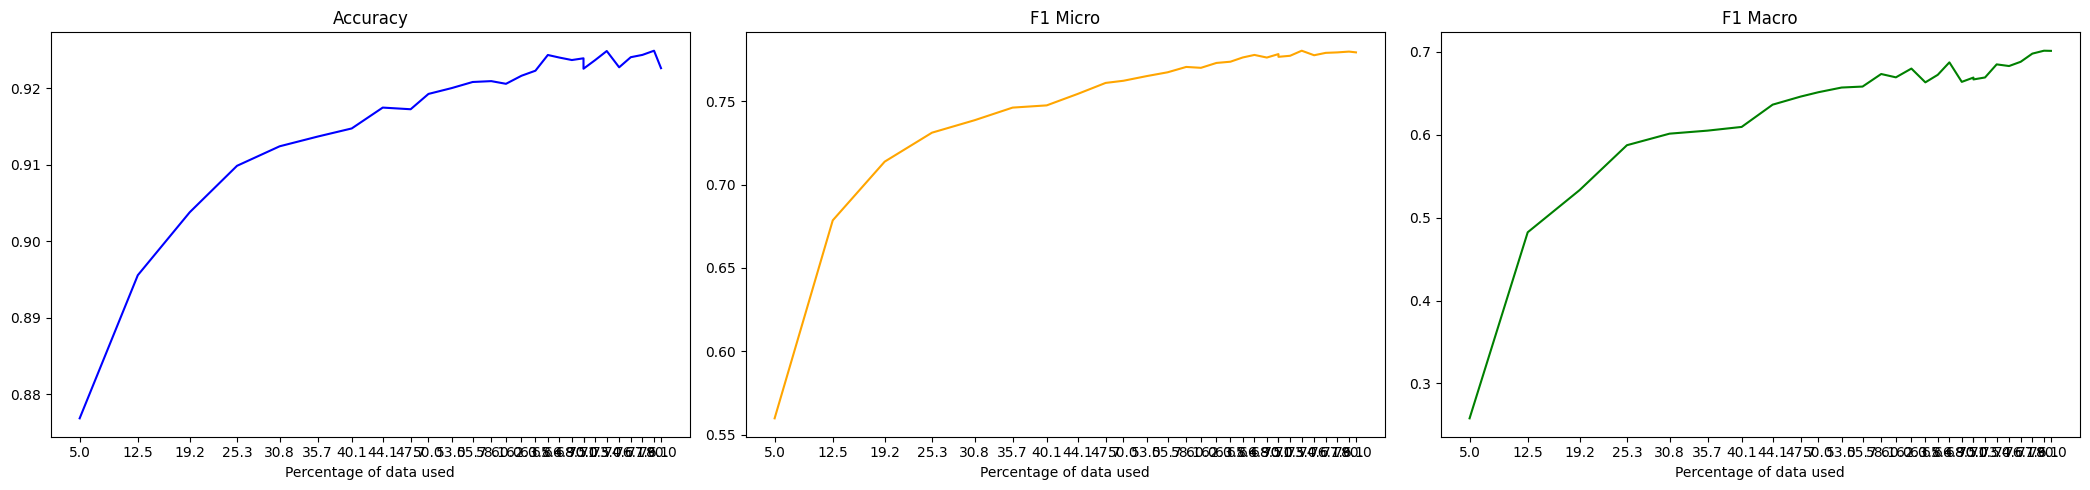

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: [14, 61, 33]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.592, Accuracy: 0.8279, F1 Micro: 0.0872, F1 Macro: 0.0282
Epoch 2/10, Train Loss: 0.4622, Accuracy: 0.8279, F1 Micro: 0.0229, F1 Macro: 0.0086
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3927, Accuracy: 0.8335, F1 Micro: 0.1068, F1 Macro: 0.0416
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3964, Accuracy: 0.8362, F1 Micro: 0.1315, F1 Macro: 0.046
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3802, Accuracy: 0.8472, F1 Micro: 0.2582, F1 Macro: 0.0889
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3611, Accuracy: 0.8539, F1 Micro: 0.347, F1 Macro: 0.1151
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3431, Accuracy: 0.8712, F1 Micro: 0.5052, F1 Macro: 0.2252
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3176, Accuracy: 0.8724, F1 Micro: 0.5088, F1 Macro: 0.2394
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2825, Accuracy: 0.8742, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6617, Accuracy: 0.8259, F1 Micro: 0.1583, F1 Macro: 0.0585
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4885, Accuracy: 0.8383, F1 Micro: 0.2329, F1 Macro: 0.0784
Epoch 3/10, Train Loss: 0.4062, Accuracy: 0.8355, F1 Micro: 0.1232, F1 Macro: 0.047
Epoch 4/10, Train Loss: 0.4042, Accuracy: 0.8358, F1 Micro: 0.1132, F1 Macro: 0.0443
Epoch 5/10, Train Loss: 0.3882, Accuracy: 0.8426, F1 Micro: 0.1993, F1 Macro: 0.0725
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3714, Accuracy: 0.8533, F1 Micro: 0.3255, F1 Macro: 0.106
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3558, Accuracy: 0.8608, F1 Micro: 0.4029, F1 Macro: 0.1366
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.335, Accuracy: 0.8717, F1 Micro: 0.4978, F1 Macro: 0.2183
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3044, Accuracy: 0.8757, F1 Micro: 0.5599, F1 Macro: 0.2579
Epoch 10/10, Train Loss: 0.2723, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6172, Accuracy: 0.8198, F1 Micro: 0.3684, F1 Macro: 0.1118
Epoch 2/10, Train Loss: 0.4799, Accuracy: 0.8282, F1 Micro: 0.0142, F1 Macro: 0.0063
Epoch 3/10, Train Loss: 0.4012, Accuracy: 0.833, F1 Micro: 0.0831, F1 Macro: 0.031
Epoch 4/10, Train Loss: 0.4015, Accuracy: 0.8381, F1 Micro: 0.1679, F1 Macro: 0.0518
Epoch 5/10, Train Loss: 0.3869, Accuracy: 0.8431, F1 Micro: 0.215, F1 Macro: 0.0724
Epoch 6/10, Train Loss: 0.3725, Accuracy: 0.8499, F1 Micro: 0.2925, F1 Macro: 0.0972
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3585, Accuracy: 0.8575, F1 Micro: 0.3854, F1 Macro: 0.1216
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3352, Accuracy: 0.8693, F1 Micro: 0.4738, F1 Macro: 0.2005
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2977, Accuracy: 0.8755, F1 Micro: 0.5714, F1 Macro: 0.2756
Epoch 10/10, Train Loss: 0.2676, Accuracy: 0.8765, F1 Micro: 0.561, F1 Macro: 0.2835
Model 3 - Iteration 6

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5199, Accuracy: 0.8291, F1 Micro: 0.0536, F1 Macro: 0.019
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3979, Accuracy: 0.8369, F1 Micro: 0.1416, F1 Macro: 0.0522
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3682, Accuracy: 0.8548, F1 Micro: 0.3592, F1 Macro: 0.1209
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3289, Accuracy: 0.8775, F1 Micro: 0.5452, F1 Macro: 0.2569
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2881, Accuracy: 0.8823, F1 Micro: 0.6257, F1 Macro: 0.33
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2567, Accuracy: 0.885, F1 Micro: 0.6616, F1 Macro: 0.3985
Epoch 7/10, Train Loss: 0.2372, Accuracy: 0.8906, F1 Micro: 0.6219, F1 Macro: 0.3663
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2162, Accuracy: 0.8895, F1 Micro: 0.6774, F1 Macro: 0.4657
Epoch 9/10, Train Loss: 0.195, Accuracy: 0.8946, F1 Micro: 0.6531, F1 Macro: 0.4505
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5651, Accuracy: 0.8391, F1 Micro: 0.2774, F1 Macro: 0.0878
Epoch 2/10, Train Loss: 0.4062, Accuracy: 0.8434, F1 Micro: 0.2338, F1 Macro: 0.0782
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3753, Accuracy: 0.8534, F1 Micro: 0.3334, F1 Macro: 0.1085
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3422, Accuracy: 0.873, F1 Micro: 0.4993, F1 Macro: 0.2198
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.304, Accuracy: 0.8815, F1 Micro: 0.5916, F1 Macro: 0.2878
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2723, Accuracy: 0.8814, F1 Micro: 0.6615, F1 Macro: 0.3633
Epoch 7/10, Train Loss: 0.252, Accuracy: 0.8864, F1 Micro: 0.5916, F1 Macro: 0.3146
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2301, Accuracy: 0.8887, F1 Micro: 0.6667, F1 Macro: 0.3893
Epoch 9/10, Train Loss: 0.2065, Accuracy: 0.8927, F1 Micro: 0.6461, F1 Macro: 0.3928
Epoch 10/10, Train Loss: 0.1954, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5383, Accuracy: 0.8284, F1 Micro: 0.0142, F1 Macro: 0.0064
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4023, Accuracy: 0.8417, F1 Micro: 0.2072, F1 Macro: 0.0709
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.375, Accuracy: 0.8528, F1 Micro: 0.3296, F1 Macro: 0.1065
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3419, Accuracy: 0.8753, F1 Micro: 0.5212, F1 Macro: 0.2361
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2967, Accuracy: 0.8826, F1 Micro: 0.6096, F1 Macro: 0.3141
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2649, Accuracy: 0.8811, F1 Micro: 0.6629, F1 Macro: 0.3862
Epoch 7/10, Train Loss: 0.2443, Accuracy: 0.8895, F1 Micro: 0.6131, F1 Macro: 0.3553
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2228, Accuracy: 0.8897, F1 Micro: 0.674, F1 Macro: 0.4181
Epoch 9/10, Train Loss: 0.2009, Accuracy: 0.8954, F1 Micro: 0.6584, F1 Macro: 0.4248
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4814, Accuracy: 0.8316, F1 Micro: 0.0634, F1 Macro: 0.0262
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3704, Accuracy: 0.8553, F1 Micro: 0.3383, F1 Macro: 0.1275
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3213, Accuracy: 0.8811, F1 Micro: 0.6036, F1 Macro: 0.3026
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.279, Accuracy: 0.8909, F1 Micro: 0.6574, F1 Macro: 0.405
Epoch 5/10, Train Loss: 0.2413, Accuracy: 0.896, F1 Micro: 0.6559, F1 Macro: 0.4234
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2143, Accuracy: 0.8987, F1 Micro: 0.6845, F1 Macro: 0.4655
Epoch 7/10, Train Loss: 0.1897, Accuracy: 0.8993, F1 Micro: 0.6669, F1 Macro: 0.4837
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1677, Accuracy: 0.9036, F1 Micro: 0.7055, F1 Macro: 0.5081
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1536, Accuracy: 0.9014, F1 Micro: 0.7056, F1 Macro: 0.5272
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5138, Accuracy: 0.8335, F1 Micro: 0.0827, F1 Macro: 0.0332
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3786, Accuracy: 0.8544, F1 Micro: 0.3213, F1 Macro: 0.11
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3332, Accuracy: 0.8796, F1 Micro: 0.5675, F1 Macro: 0.2698
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2918, Accuracy: 0.8863, F1 Micro: 0.6417, F1 Macro: 0.3344
Epoch 5/10, Train Loss: 0.2557, Accuracy: 0.8912, F1 Micro: 0.6268, F1 Macro: 0.3625
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2268, Accuracy: 0.8966, F1 Micro: 0.6738, F1 Macro: 0.4145
Epoch 7/10, Train Loss: 0.198, Accuracy: 0.8955, F1 Micro: 0.6495, F1 Macro: 0.4433
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1794, Accuracy: 0.8996, F1 Micro: 0.6961, F1 Macro: 0.4901
Epoch 9/10, Train Loss: 0.1654, Accuracy: 0.9016, F1 Micro: 0.6902, F1 Macro: 0.4919
Epoch 10/10, Train Loss: 0.1426, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4955, Accuracy: 0.8306, F1 Micro: 0.0451, F1 Macro: 0.0186
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3773, Accuracy: 0.8514, F1 Micro: 0.3144, F1 Macro: 0.1045
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3337, Accuracy: 0.8805, F1 Micro: 0.5957, F1 Macro: 0.3013
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2889, Accuracy: 0.8896, F1 Micro: 0.6493, F1 Macro: 0.3766
Epoch 5/10, Train Loss: 0.2479, Accuracy: 0.8927, F1 Micro: 0.6443, F1 Macro: 0.3969
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.222, Accuracy: 0.8969, F1 Micro: 0.685, F1 Macro: 0.4518
Epoch 7/10, Train Loss: 0.1927, Accuracy: 0.8977, F1 Micro: 0.658, F1 Macro: 0.4626
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1762, Accuracy: 0.8964, F1 Micro: 0.7056, F1 Macro: 0.5246
Epoch 9/10, Train Loss: 0.1622, Accuracy: 0.9033, F1 Micro: 0.6973, F1 Macro: 0.5166
Epoch 10/10, Train Loss: 0.137, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4575, Accuracy: 0.8368, F1 Micro: 0.1387, F1 Macro: 0.0511
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3592, Accuracy: 0.8758, F1 Micro: 0.6019, F1 Macro: 0.305
Epoch 3/10, Train Loss: 0.2979, Accuracy: 0.8877, F1 Micro: 0.5889, F1 Macro: 0.3085
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2608, Accuracy: 0.8959, F1 Micro: 0.681, F1 Macro: 0.4546
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2316, Accuracy: 0.901, F1 Micro: 0.6963, F1 Macro: 0.4816
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.198, Accuracy: 0.9022, F1 Micro: 0.7191, F1 Macro: 0.5354
Epoch 7/10, Train Loss: 0.167, Accuracy: 0.905, F1 Micro: 0.7166, F1 Macro: 0.5404
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1464, Accuracy: 0.9071, F1 Micro: 0.7198, F1 Macro: 0.5511
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1237, Accuracy: 0.9063, F1 Micro: 0.7291, F1 Macro: 0.5547
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4841, Accuracy: 0.837, F1 Micro: 0.1242, F1 Macro: 0.0485
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3681, Accuracy: 0.8728, F1 Micro: 0.5346, F1 Macro: 0.2389
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3069, Accuracy: 0.8868, F1 Micro: 0.6171, F1 Macro: 0.3146
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2659, Accuracy: 0.8951, F1 Micro: 0.6742, F1 Macro: 0.3972
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2364, Accuracy: 0.8983, F1 Micro: 0.6752, F1 Macro: 0.444
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2037, Accuracy: 0.9, F1 Micro: 0.7006, F1 Macro: 0.5031
Epoch 7/10, Train Loss: 0.1733, Accuracy: 0.9017, F1 Micro: 0.677, F1 Macro: 0.4922
Epoch 8/10, Train Loss: 0.1537, Accuracy: 0.9046, F1 Micro: 0.7002, F1 Macro: 0.531
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1333, Accuracy: 0.9052, F1 Micro: 0.7186, F1 Macro: 0.536
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4689, Accuracy: 0.8397, F1 Micro: 0.1843, F1 Macro: 0.0608
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3654, Accuracy: 0.8767, F1 Micro: 0.5717, F1 Macro: 0.276
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3038, Accuracy: 0.8879, F1 Micro: 0.5906, F1 Macro: 0.3138
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.263, Accuracy: 0.8963, F1 Micro: 0.6743, F1 Macro: 0.4426
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2345, Accuracy: 0.9008, F1 Micro: 0.6945, F1 Macro: 0.4786
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2023, Accuracy: 0.9021, F1 Micro: 0.7143, F1 Macro: 0.517
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.166, Accuracy: 0.9051, F1 Micro: 0.7196, F1 Macro: 0.535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1487, Accuracy: 0.9088, F1 Micro: 0.73, F1 Macro: 0.5572
Epoch 9/10, Train Loss: 0.1262, Accuracy: 0.9045, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4513, Accuracy: 0.852, F1 Micro: 0.3556, F1 Macro: 0.1096
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.336, Accuracy: 0.8808, F1 Micro: 0.5649, F1 Macro: 0.2757
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2771, Accuracy: 0.8966, F1 Micro: 0.6784, F1 Macro: 0.4176
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2415, Accuracy: 0.9023, F1 Micro: 0.6924, F1 Macro: 0.4651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2111, Accuracy: 0.904, F1 Micro: 0.7056, F1 Macro: 0.5059
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1814, Accuracy: 0.9071, F1 Micro: 0.7177, F1 Macro: 0.5376
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1614, Accuracy: 0.9101, F1 Micro: 0.7272, F1 Macro: 0.5491
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1317, Accuracy: 0.9102, F1 Micro: 0.7299, F1 Macro: 0.5658
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4744, Accuracy: 0.8514, F1 Micro: 0.348, F1 Macro: 0.1083
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3466, Accuracy: 0.8795, F1 Micro: 0.5609, F1 Macro: 0.2616
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.289, Accuracy: 0.891, F1 Micro: 0.6676, F1 Macro: 0.3624
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2512, Accuracy: 0.8994, F1 Micro: 0.6792, F1 Macro: 0.4263
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2181, Accuracy: 0.903, F1 Micro: 0.6891, F1 Macro: 0.4654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1893, Accuracy: 0.9053, F1 Micro: 0.7067, F1 Macro: 0.5257
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1636, Accuracy: 0.9066, F1 Micro: 0.7273, F1 Macro: 0.5471
Epoch 8/10, Train Loss: 0.1391, Accuracy: 0.9077, F1 Micro: 0.7086, F1 Macro: 0.5352
Epoch 9/10, Train Loss: 0.1232, Accuracy: 0.9087, F1 Micro: 0.7231, F1 Macro: 0.5506
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4616, Accuracy: 0.8495, F1 Micro: 0.3048, F1 Macro: 0.0994
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3453, Accuracy: 0.8823, F1 Micro: 0.5742, F1 Macro: 0.2796
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2837, Accuracy: 0.8913, F1 Micro: 0.677, F1 Macro: 0.3948
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2475, Accuracy: 0.9012, F1 Micro: 0.7012, F1 Macro: 0.461
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2173, Accuracy: 0.9032, F1 Micro: 0.7165, F1 Macro: 0.5427
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1855, Accuracy: 0.9084, F1 Micro: 0.7256, F1 Macro: 0.5418
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1589, Accuracy: 0.9102, F1 Micro: 0.7257, F1 Macro: 0.5572
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1349, Accuracy: 0.9118, F1 Micro: 0.7287, F1 Macro: 0.5493
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4385, Accuracy: 0.8553, F1 Micro: 0.3691, F1 Macro: 0.1164
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.333, Accuracy: 0.8854, F1 Micro: 0.6079, F1 Macro: 0.3086
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2723, Accuracy: 0.8961, F1 Micro: 0.6381, F1 Macro: 0.4099
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2354, Accuracy: 0.9032, F1 Micro: 0.7077, F1 Macro: 0.5067
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2041, Accuracy: 0.9073, F1 Micro: 0.729, F1 Macro: 0.5447
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1696, Accuracy: 0.9105, F1 Micro: 0.7368, F1 Macro: 0.5524
Epoch 7/10, Train Loss: 0.1496, Accuracy: 0.912, F1 Micro: 0.7233, F1 Macro: 0.5483
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1234, Accuracy: 0.9111, F1 Micro: 0.7393, F1 Macro: 0.5819
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1101, Accuracy: 0.9115, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4579, Accuracy: 0.8551, F1 Micro: 0.3558, F1 Macro: 0.112
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3404, Accuracy: 0.8841, F1 Micro: 0.6262, F1 Macro: 0.312
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2799, Accuracy: 0.8956, F1 Micro: 0.6693, F1 Macro: 0.3933
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2426, Accuracy: 0.8967, F1 Micro: 0.7068, F1 Macro: 0.5024
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2121, Accuracy: 0.9059, F1 Micro: 0.7205, F1 Macro: 0.5138
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1745, Accuracy: 0.9094, F1 Micro: 0.7261, F1 Macro: 0.5328
Epoch 7/10, Train Loss: 0.1523, Accuracy: 0.9104, F1 Micro: 0.7158, F1 Macro: 0.5488
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1274, Accuracy: 0.9116, F1 Micro: 0.7321, F1 Macro: 0.5674
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1128, Accuracy: 0.9129, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.448, Accuracy: 0.8531, F1 Micro: 0.347, F1 Macro: 0.1096
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3414, Accuracy: 0.8847, F1 Micro: 0.6226, F1 Macro: 0.3176
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2774, Accuracy: 0.897, F1 Micro: 0.6534, F1 Macro: 0.388
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2398, Accuracy: 0.9025, F1 Micro: 0.708, F1 Macro: 0.5098
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2087, Accuracy: 0.9052, F1 Micro: 0.724, F1 Macro: 0.5364
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1741, Accuracy: 0.9125, F1 Micro: 0.7356, F1 Macro: 0.5555
Epoch 7/10, Train Loss: 0.1516, Accuracy: 0.9128, F1 Micro: 0.7294, F1 Macro: 0.5647
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1274, Accuracy: 0.9119, F1 Micro: 0.7389, F1 Macro: 0.5764
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1102, Accuracy: 0.9142, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4285, Accuracy: 0.8638, F1 Micro: 0.4405, F1 Macro: 0.1678
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3143, Accuracy: 0.8913, F1 Micro: 0.6666, F1 Macro: 0.4293
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2568, Accuracy: 0.9016, F1 Micro: 0.7003, F1 Macro: 0.5087
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2214, Accuracy: 0.9073, F1 Micro: 0.7121, F1 Macro: 0.5188
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1814, Accuracy: 0.9052, F1 Micro: 0.7353, F1 Macro: 0.5682
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1607, Accuracy: 0.9115, F1 Micro: 0.7419, F1 Macro: 0.5716
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1299, Accuracy: 0.9124, F1 Micro: 0.742, F1 Macro: 0.5876
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1182, Accuracy: 0.9165, F1 Micro: 0.7468, F1 Macro: 0.6138
Epoch 9/10, Train Loss: 0.1001, Accuracy: 0.9134, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4493, Accuracy: 0.8599, F1 Micro: 0.4088, F1 Macro: 0.1407
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.326, Accuracy: 0.8889, F1 Micro: 0.6428, F1 Macro: 0.3443
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.268, Accuracy: 0.8982, F1 Micro: 0.6809, F1 Macro: 0.4524
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.228, Accuracy: 0.9047, F1 Micro: 0.7043, F1 Macro: 0.4697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1941, Accuracy: 0.9038, F1 Micro: 0.7335, F1 Macro: 0.5591
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.167, Accuracy: 0.9129, F1 Micro: 0.7348, F1 Macro: 0.5628
Epoch 7/10, Train Loss: 0.1338, Accuracy: 0.913, F1 Micro: 0.7315, F1 Macro: 0.5684
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.125, Accuracy: 0.9149, F1 Micro: 0.7407, F1 Macro: 0.5986
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1078, Accuracy: 0.9138, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4382, Accuracy: 0.8574, F1 Micro: 0.396, F1 Macro: 0.126
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3233, Accuracy: 0.8909, F1 Micro: 0.661, F1 Macro: 0.3774
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2622, Accuracy: 0.9025, F1 Micro: 0.6844, F1 Macro: 0.4672
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2224, Accuracy: 0.9078, F1 Micro: 0.709, F1 Macro: 0.5122
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1902, Accuracy: 0.9039, F1 Micro: 0.7347, F1 Macro: 0.5696
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1635, Accuracy: 0.9136, F1 Micro: 0.7449, F1 Macro: 0.5792
Epoch 7/10, Train Loss: 0.133, Accuracy: 0.9126, F1 Micro: 0.7356, F1 Macro: 0.5717
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1215, Accuracy: 0.9146, F1 Micro: 0.7456, F1 Macro: 0.6205
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1035, Accuracy: 0.9183, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4229, Accuracy: 0.8706, F1 Micro: 0.5013, F1 Macro: 0.2202
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3041, Accuracy: 0.8956, F1 Micro: 0.6542, F1 Macro: 0.3941
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2483, Accuracy: 0.9053, F1 Micro: 0.7042, F1 Macro: 0.4928
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.21, Accuracy: 0.9105, F1 Micro: 0.7281, F1 Macro: 0.5407
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1823, Accuracy: 0.9131, F1 Micro: 0.739, F1 Macro: 0.5592
Epoch 6/10, Train Loss: 0.1496, Accuracy: 0.9088, F1 Micro: 0.7378, F1 Macro: 0.5583
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1285, Accuracy: 0.9051, F1 Micro: 0.7414, F1 Macro: 0.5891
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1092, Accuracy: 0.9153, F1 Micro: 0.749, F1 Macro: 0.6296
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0891, Accuracy: 0.9161, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4414, Accuracy: 0.8615, F1 Micro: 0.4147, F1 Macro: 0.1452
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3158, Accuracy: 0.8897, F1 Micro: 0.6183, F1 Macro: 0.3197
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2563, Accuracy: 0.9024, F1 Micro: 0.6896, F1 Macro: 0.4546
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.22, Accuracy: 0.9065, F1 Micro: 0.7017, F1 Macro: 0.486
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1904, Accuracy: 0.9109, F1 Micro: 0.7183, F1 Macro: 0.5163
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.156, Accuracy: 0.9129, F1 Micro: 0.7349, F1 Macro: 0.538
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1374, Accuracy: 0.9133, F1 Micro: 0.744, F1 Macro: 0.5885
Epoch 8/10, Train Loss: 0.1146, Accuracy: 0.9153, F1 Micro: 0.7431, F1 Macro: 0.6142
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0983, Accuracy: 0.9173, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4326, Accuracy: 0.8575, F1 Micro: 0.3791, F1 Macro: 0.1254
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3129, Accuracy: 0.8937, F1 Micro: 0.6352, F1 Macro: 0.35
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2521, Accuracy: 0.905, F1 Micro: 0.7049, F1 Macro: 0.4882
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2184, Accuracy: 0.9092, F1 Micro: 0.7201, F1 Macro: 0.5156
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1876, Accuracy: 0.913, F1 Micro: 0.7292, F1 Macro: 0.5384
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1534, Accuracy: 0.9108, F1 Micro: 0.7398, F1 Macro: 0.5567
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1337, Accuracy: 0.9106, F1 Micro: 0.7464, F1 Macro: 0.5947
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1138, Accuracy: 0.9158, F1 Micro: 0.7517, F1 Macro: 0.6255
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4172, Accuracy: 0.8752, F1 Micro: 0.5685, F1 Macro: 0.2703
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2967, Accuracy: 0.898, F1 Micro: 0.6655, F1 Macro: 0.4288
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.245, Accuracy: 0.9061, F1 Micro: 0.7125, F1 Macro: 0.5101
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2065, Accuracy: 0.9087, F1 Micro: 0.7392, F1 Macro: 0.5604
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1724, Accuracy: 0.9144, F1 Micro: 0.7411, F1 Macro: 0.58
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1435, Accuracy: 0.9156, F1 Micro: 0.7431, F1 Macro: 0.6067
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1253, Accuracy: 0.9153, F1 Micro: 0.7534, F1 Macro: 0.6365
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1065, Accuracy: 0.9172, F1 Micro: 0.7549, F1 Macro: 0.6457
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4344, Accuracy: 0.8717, F1 Micro: 0.5062, F1 Macro: 0.2177
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3042, Accuracy: 0.8938, F1 Micro: 0.6555, F1 Macro: 0.3634
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2531, Accuracy: 0.9034, F1 Micro: 0.7, F1 Macro: 0.4783
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.212, Accuracy: 0.9096, F1 Micro: 0.7297, F1 Macro: 0.542
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1781, Accuracy: 0.9124, F1 Micro: 0.7361, F1 Macro: 0.5606
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.149, Accuracy: 0.9132, F1 Micro: 0.738, F1 Macro: 0.5806
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.129, Accuracy: 0.9126, F1 Micro: 0.7479, F1 Macro: 0.6132
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1104, Accuracy: 0.9144, F1 Micro: 0.7488, F1 Macro: 0.6302
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0941,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4277, Accuracy: 0.8619, F1 Micro: 0.4002, F1 Macro: 0.1405
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3028, Accuracy: 0.8968, F1 Micro: 0.6583, F1 Macro: 0.3875
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2482, Accuracy: 0.9038, F1 Micro: 0.7021, F1 Macro: 0.4761
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2093, Accuracy: 0.9074, F1 Micro: 0.738, F1 Macro: 0.5509
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1755, Accuracy: 0.9138, F1 Micro: 0.7456, F1 Macro: 0.5814
Epoch 6/10, Train Loss: 0.1467, Accuracy: 0.914, F1 Micro: 0.745, F1 Macro: 0.5953
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1298, Accuracy: 0.9146, F1 Micro: 0.7506, F1 Macro: 0.6232
Epoch 8/10, Train Loss: 0.1079, Accuracy: 0.9138, F1 Micro: 0.7482, F1 Macro: 0.6324
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0927, Accuracy: 0.918, F1 Micro: 0.7585, F1 Macro: 0.6556
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4143, Accuracy: 0.8781, F1 Micro: 0.5701, F1 Macro: 0.271
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2979, Accuracy: 0.8957, F1 Micro: 0.6347, F1 Macro: 0.4065
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2398, Accuracy: 0.9076, F1 Micro: 0.713, F1 Macro: 0.5137
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2047, Accuracy: 0.9119, F1 Micro: 0.7423, F1 Macro: 0.5684
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1718, Accuracy: 0.9102, F1 Micro: 0.7452, F1 Macro: 0.5838
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1445, Accuracy: 0.9171, F1 Micro: 0.7458, F1 Macro: 0.5973
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1226, Accuracy: 0.9191, F1 Micro: 0.7627, F1 Macro: 0.6395
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1041, Accuracy: 0.9191, F1 Micro: 0.7647, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4327, Accuracy: 0.8719, F1 Micro: 0.4885, F1 Macro: 0.2103
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3058, Accuracy: 0.8876, F1 Micro: 0.5867, F1 Macro: 0.3187
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2495, Accuracy: 0.9038, F1 Micro: 0.6844, F1 Macro: 0.4373
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2119, Accuracy: 0.9098, F1 Micro: 0.7283, F1 Macro: 0.5269
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1793, Accuracy: 0.915, F1 Micro: 0.7442, F1 Macro: 0.5734
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1495, Accuracy: 0.9174, F1 Micro: 0.7466, F1 Macro: 0.5916
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1284, Accuracy: 0.9191, F1 Micro: 0.7567, F1 Macro: 0.6156
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1089, Accuracy: 0.9178, F1 Micro: 0.7578, F1 Macro: 0.6297
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4245, Accuracy: 0.8729, F1 Micro: 0.5237, F1 Macro: 0.2313
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3031, Accuracy: 0.8944, F1 Micro: 0.6323, F1 Macro: 0.3577
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2442, Accuracy: 0.9072, F1 Micro: 0.702, F1 Macro: 0.4905
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2077, Accuracy: 0.9126, F1 Micro: 0.7338, F1 Macro: 0.5542
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1745, Accuracy: 0.9102, F1 Micro: 0.7431, F1 Macro: 0.5791
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1483, Accuracy: 0.9128, F1 Micro: 0.7519, F1 Macro: 0.6008
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.127, Accuracy: 0.9189, F1 Micro: 0.7587, F1 Macro: 0.634
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.107, Accuracy: 0.9194, F1 Micro: 0.7603, F1 Macro: 0.6389
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.406, Accuracy: 0.8778, F1 Micro: 0.5476, F1 Macro: 0.2546
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2816, Accuracy: 0.8983, F1 Micro: 0.6589, F1 Macro: 0.4366
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2404, Accuracy: 0.9038, F1 Micro: 0.7193, F1 Macro: 0.5136
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2045, Accuracy: 0.912, F1 Micro: 0.7419, F1 Macro: 0.5699
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1723, Accuracy: 0.9195, F1 Micro: 0.7553, F1 Macro: 0.6008
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1437, Accuracy: 0.9183, F1 Micro: 0.7561, F1 Macro: 0.6248
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1181, Accuracy: 0.9186, F1 Micro: 0.7575, F1 Macro: 0.6277
Epoch 8/10, Train Loss: 0.1018, Accuracy: 0.9187, F1 Micro: 0.7507, F1 Macro: 0.6301
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0862, Accuracy: 0.9203, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4227, Accuracy: 0.8755, F1 Micro: 0.5345, F1 Macro: 0.2399
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2907, Accuracy: 0.8952, F1 Micro: 0.656, F1 Macro: 0.3853
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2475, Accuracy: 0.9046, F1 Micro: 0.7077, F1 Macro: 0.4812
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2094, Accuracy: 0.9121, F1 Micro: 0.7323, F1 Macro: 0.5497
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1775, Accuracy: 0.9163, F1 Micro: 0.7428, F1 Macro: 0.5847
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1467, Accuracy: 0.9182, F1 Micro: 0.7505, F1 Macro: 0.602
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.124, Accuracy: 0.9137, F1 Micro: 0.7533, F1 Macro: 0.6333
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1028, Accuracy: 0.9144, F1 Micro: 0.756, F1 Macro: 0.6318
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.416, Accuracy: 0.8692, F1 Micro: 0.4531, F1 Macro: 0.1995
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2888, Accuracy: 0.8975, F1 Micro: 0.6722, F1 Macro: 0.3982
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2452, Accuracy: 0.904, F1 Micro: 0.7152, F1 Macro: 0.492
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2085, Accuracy: 0.9077, F1 Micro: 0.7408, F1 Macro: 0.567
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.176, Accuracy: 0.9191, F1 Micro: 0.7479, F1 Macro: 0.5945
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1492, Accuracy: 0.9197, F1 Micro: 0.7547, F1 Macro: 0.6156
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1229, Accuracy: 0.9193, F1 Micro: 0.7629, F1 Macro: 0.6386
Epoch 8/10, Train Loss: 0.1014, Accuracy: 0.9174, F1 Micro: 0.7623, F1 Macro: 0.6578
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0873, Accuracy: 0.9196, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.406, Accuracy: 0.8738, F1 Micro: 0.488, F1 Macro: 0.2242
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2855, Accuracy: 0.8982, F1 Micro: 0.6868, F1 Macro: 0.4586
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2337, Accuracy: 0.9086, F1 Micro: 0.726, F1 Macro: 0.5415
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2008, Accuracy: 0.9159, F1 Micro: 0.7389, F1 Macro: 0.5733
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.165, Accuracy: 0.9175, F1 Micro: 0.7604, F1 Macro: 0.6064
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1396, Accuracy: 0.9174, F1 Micro: 0.7625, F1 Macro: 0.6211
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1159, Accuracy: 0.9191, F1 Micro: 0.7642, F1 Macro: 0.6369
Epoch 8/10, Train Loss: 0.1033, Accuracy: 0.9167, F1 Micro: 0.7618, F1 Macro: 0.6476
Epoch 9/10, Train Loss: 0.0867, Accuracy: 0.9178, F1 Micro: 0.7587, F1 Macro: 0.6406
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4244, Accuracy: 0.876, F1 Micro: 0.5297, F1 Macro: 0.2398
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2923, Accuracy: 0.8963, F1 Micro: 0.6683, F1 Macro: 0.4189
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2403, Accuracy: 0.905, F1 Micro: 0.7171, F1 Macro: 0.4882
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2078, Accuracy: 0.9131, F1 Micro: 0.7312, F1 Macro: 0.542
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1702, Accuracy: 0.9134, F1 Micro: 0.754, F1 Macro: 0.5925
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1468, Accuracy: 0.9174, F1 Micro: 0.763, F1 Macro: 0.6194
Epoch 7/10, Train Loss: 0.1204, Accuracy: 0.9205, F1 Micro: 0.7563, F1 Macro: 0.6127
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1072, Accuracy: 0.9204, F1 Micro: 0.7648, F1 Macro: 0.6376
Epoch 9/10, Train Loss: 0.0857, Accuracy: 0.9204, F1 Micro: 0.7628, F1 Macro: 0.6537
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4156, Accuracy: 0.8728, F1 Micro: 0.4839, F1 Macro: 0.2194
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2883, Accuracy: 0.8982, F1 Micro: 0.6829, F1 Macro: 0.4556
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2361, Accuracy: 0.9042, F1 Micro: 0.7239, F1 Macro: 0.5559
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2048, Accuracy: 0.9129, F1 Micro: 0.7321, F1 Macro: 0.5577
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1677, Accuracy: 0.9141, F1 Micro: 0.7571, F1 Macro: 0.6072
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1433, Accuracy: 0.9144, F1 Micro: 0.759, F1 Macro: 0.6254
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1189, Accuracy: 0.9202, F1 Micro: 0.7591, F1 Macro: 0.6265
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1052, Accuracy: 0.9173, F1 Micro: 0.7668, F1 Macro: 0.6579
Epoch 9/10, Train Loss: 0.0877, Accuracy: 0.918, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.399, Accuracy: 0.8805, F1 Micro: 0.5596, F1 Macro: 0.2672
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2796, Accuracy: 0.8991, F1 Micro: 0.6941, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.232, Accuracy: 0.9086, F1 Micro: 0.715, F1 Macro: 0.5095
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1928, Accuracy: 0.9154, F1 Micro: 0.742, F1 Macro: 0.5751
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1675, Accuracy: 0.9195, F1 Micro: 0.7536, F1 Macro: 0.6052
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1374, Accuracy: 0.9204, F1 Micro: 0.7668, F1 Macro: 0.639
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1149, Accuracy: 0.9242, F1 Micro: 0.7698, F1 Macro: 0.6606
Epoch 8/10, Train Loss: 0.1005, Accuracy: 0.9234, F1 Micro: 0.7629, F1 Macro: 0.6626
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.086, Accuracy: 0.9229, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4145, Accuracy: 0.8778, F1 Micro: 0.5438, F1 Macro: 0.2462
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2866, Accuracy: 0.8971, F1 Micro: 0.6636, F1 Macro: 0.3656
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2402, Accuracy: 0.9083, F1 Micro: 0.7176, F1 Macro: 0.5011
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1987, Accuracy: 0.9144, F1 Micro: 0.7386, F1 Macro: 0.5577
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1693, Accuracy: 0.919, F1 Micro: 0.7541, F1 Macro: 0.6051
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.139, Accuracy: 0.9199, F1 Micro: 0.7631, F1 Macro: 0.6261
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1186, Accuracy: 0.9216, F1 Micro: 0.7648, F1 Macro: 0.6531
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1045, Accuracy: 0.9217, F1 Micro: 0.7683, F1 Macro: 0.6604
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4074, Accuracy: 0.8817, F1 Micro: 0.5812, F1 Macro: 0.2817
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2829, Accuracy: 0.8986, F1 Micro: 0.6925, F1 Macro: 0.4335
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2341, Accuracy: 0.9087, F1 Micro: 0.7191, F1 Macro: 0.5263
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1962, Accuracy: 0.9143, F1 Micro: 0.7416, F1 Macro: 0.5633
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1677, Accuracy: 0.9173, F1 Micro: 0.7579, F1 Macro: 0.6138
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1396, Accuracy: 0.922, F1 Micro: 0.7646, F1 Macro: 0.627
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1165, Accuracy: 0.9223, F1 Micro: 0.7713, F1 Macro: 0.6612
Epoch 8/10, Train Loss: 0.101, Accuracy: 0.9233, F1 Micro: 0.767, F1 Macro: 0.6604
Epoch 9/10, Train Loss: 0.0876, Accuracy: 0.9222, F1 Micro: 0.7694, F1 Macro: 0.6748
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3959, Accuracy: 0.8811, F1 Micro: 0.6009, F1 Macro: 0.2988
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2806, Accuracy: 0.9014, F1 Micro: 0.6967, F1 Macro: 0.484
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2318, Accuracy: 0.912, F1 Micro: 0.7378, F1 Macro: 0.5628
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1976, Accuracy: 0.9168, F1 Micro: 0.755, F1 Macro: 0.5926
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1605, Accuracy: 0.92, F1 Micro: 0.7615, F1 Macro: 0.6144
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.134, Accuracy: 0.9205, F1 Micro: 0.7708, F1 Macro: 0.6379
Epoch 7/10, Train Loss: 0.1133, Accuracy: 0.9184, F1 Micro: 0.7602, F1 Macro: 0.6271
Epoch 8/10, Train Loss: 0.0955, Accuracy: 0.9231, F1 Micro: 0.7706, F1 Macro: 0.6618
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0815, Accuracy: 0.9234, F1 Micro: 0.7748, F1 Macro: 0.6886
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4129, Accuracy: 0.88, F1 Micro: 0.5761, F1 Macro: 0.2684
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2889, Accuracy: 0.8985, F1 Micro: 0.6781, F1 Macro: 0.4224
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2397, Accuracy: 0.9085, F1 Micro: 0.7282, F1 Macro: 0.5369
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2013, Accuracy: 0.9141, F1 Micro: 0.748, F1 Macro: 0.5736
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.166, Accuracy: 0.9182, F1 Micro: 0.7536, F1 Macro: 0.5886
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1399, Accuracy: 0.9198, F1 Micro: 0.7652, F1 Macro: 0.6241
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1156, Accuracy: 0.9188, F1 Micro: 0.7653, F1 Macro: 0.63
Epoch 8/10, Train Loss: 0.102, Accuracy: 0.9218, F1 Micro: 0.7594, F1 Macro: 0.6493
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0876, Accuracy: 0.9233, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4044, Accuracy: 0.8815, F1 Micro: 0.6131, F1 Macro: 0.3094
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2837, Accuracy: 0.9005, F1 Micro: 0.6929, F1 Macro: 0.4826
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2364, Accuracy: 0.9091, F1 Micro: 0.7307, F1 Macro: 0.5427
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2015, Accuracy: 0.9138, F1 Micro: 0.7497, F1 Macro: 0.5743
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1635, Accuracy: 0.9205, F1 Micro: 0.7569, F1 Macro: 0.5974
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1382, Accuracy: 0.921, F1 Micro: 0.7666, F1 Macro: 0.6287
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1147, Accuracy: 0.9225, F1 Micro: 0.7668, F1 Macro: 0.6358
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0977, Accuracy: 0.9228, F1 Micro: 0.7695, F1 Macro: 0.6607
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3946, Accuracy: 0.8815, F1 Micro: 0.5592, F1 Macro: 0.2704
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2782, Accuracy: 0.9042, F1 Micro: 0.6926, F1 Macro: 0.4815
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2285, Accuracy: 0.913, F1 Micro: 0.7251, F1 Macro: 0.5384
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1853, Accuracy: 0.9178, F1 Micro: 0.7503, F1 Macro: 0.5926
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1593, Accuracy: 0.9227, F1 Micro: 0.7688, F1 Macro: 0.6167
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1314, Accuracy: 0.9205, F1 Micro: 0.7707, F1 Macro: 0.6568
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1111, Accuracy: 0.921, F1 Micro: 0.771, F1 Macro: 0.6458
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0935, Accuracy: 0.9226, F1 Micro: 0.7726, F1 Macro: 0.6587
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4119, Accuracy: 0.8786, F1 Micro: 0.5444, F1 Macro: 0.2489
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2864, Accuracy: 0.9007, F1 Micro: 0.6786, F1 Macro: 0.4238
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2359, Accuracy: 0.911, F1 Micro: 0.7252, F1 Macro: 0.5368
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.191, Accuracy: 0.9147, F1 Micro: 0.7428, F1 Macro: 0.5737
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1657, Accuracy: 0.9204, F1 Micro: 0.7604, F1 Macro: 0.6123
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1385, Accuracy: 0.9199, F1 Micro: 0.7644, F1 Macro: 0.6385
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1169, Accuracy: 0.9213, F1 Micro: 0.7659, F1 Macro: 0.6407
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.097, Accuracy: 0.9233, F1 Micro: 0.775, F1 Macro: 0.6515
Epoch 9/10, Train Loss: 0.0867, Accuracy: 0.9189, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4051, Accuracy: 0.8819, F1 Micro: 0.5575, F1 Macro: 0.2699
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2827, Accuracy: 0.9026, F1 Micro: 0.6874, F1 Macro: 0.4722
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2311, Accuracy: 0.9121, F1 Micro: 0.7332, F1 Macro: 0.5391
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.189, Accuracy: 0.9167, F1 Micro: 0.7519, F1 Macro: 0.5765
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1602, Accuracy: 0.9219, F1 Micro: 0.7645, F1 Macro: 0.612
Epoch 6/10, Train Loss: 0.1339, Accuracy: 0.9153, F1 Micro: 0.7592, F1 Macro: 0.6377
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.114, Accuracy: 0.9175, F1 Micro: 0.7661, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.098, Accuracy: 0.9208, F1 Micro: 0.7722, F1 Macro: 0.6487
Epoch 9/10, Train Loss: 0.0822, Accuracy: 0.9186, F1 Micro: 0.769, F1 Macro: 0.6659
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3983, Accuracy: 0.883, F1 Micro: 0.5996, F1 Macro: 0.3021
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2696, Accuracy: 0.9059, F1 Micro: 0.6959, F1 Macro: 0.506
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2239, Accuracy: 0.9143, F1 Micro: 0.739, F1 Macro: 0.5561
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1896, Accuracy: 0.913, F1 Micro: 0.7544, F1 Macro: 0.5918
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1574, Accuracy: 0.9206, F1 Micro: 0.7669, F1 Macro: 0.6216
Epoch 6/10, Train Loss: 0.1258, Accuracy: 0.9198, F1 Micro: 0.7654, F1 Macro: 0.6429
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1111, Accuracy: 0.9197, F1 Micro: 0.7729, F1 Macro: 0.6629
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0903, Accuracy: 0.9244, F1 Micro: 0.7768, F1 Macro: 0.6773
Epoch 9/10, Train Loss: 0.0775, Accuracy: 0.9237, F1 Micro: 0.773, F1 Macro: 0.6835
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.415, Accuracy: 0.8825, F1 Micro: 0.5895, F1 Macro: 0.2839
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.279, Accuracy: 0.9012, F1 Micro: 0.6667, F1 Macro: 0.4343
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2318, Accuracy: 0.9123, F1 Micro: 0.7228, F1 Macro: 0.5059
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1936, Accuracy: 0.9085, F1 Micro: 0.7472, F1 Macro: 0.5882
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1618, Accuracy: 0.9203, F1 Micro: 0.759, F1 Macro: 0.6094
Epoch 6/10, Train Loss: 0.1311, Accuracy: 0.9195, F1 Micro: 0.7541, F1 Macro: 0.6107
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1161, Accuracy: 0.9211, F1 Micro: 0.764, F1 Macro: 0.6311
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0946, Accuracy: 0.9231, F1 Micro: 0.7733, F1 Macro: 0.662
Epoch 9/10, Train Loss: 0.0836, Accuracy: 0.9225, F1 Micro: 0.7697, F1 Macro: 0.6728
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4089, Accuracy: 0.8834, F1 Micro: 0.5824, F1 Macro: 0.2835
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2757, Accuracy: 0.9037, F1 Micro: 0.6862, F1 Macro: 0.4773
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.227, Accuracy: 0.9105, F1 Micro: 0.7327, F1 Macro: 0.5342
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1936, Accuracy: 0.9129, F1 Micro: 0.7544, F1 Macro: 0.5896
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1581, Accuracy: 0.9224, F1 Micro: 0.7678, F1 Macro: 0.6201
Epoch 6/10, Train Loss: 0.1295, Accuracy: 0.9214, F1 Micro: 0.7646, F1 Macro: 0.6395
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1142, Accuracy: 0.921, F1 Micro: 0.771, F1 Macro: 0.641
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0931, Accuracy: 0.9249, F1 Micro: 0.7723, F1 Macro: 0.6615
Epoch 9/10, Train Loss: 0.0838, Accuracy: 0.9209, F1 Micro: 0.7717, F1 Macro: 0.674
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3928, Accuracy: 0.8832, F1 Micro: 0.6077, F1 Macro: 0.3039
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2712, Accuracy: 0.8997, F1 Micro: 0.7148, F1 Macro: 0.5126
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2206, Accuracy: 0.9148, F1 Micro: 0.7444, F1 Macro: 0.5759
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1893, Accuracy: 0.9174, F1 Micro: 0.7578, F1 Macro: 0.5984
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1543, Accuracy: 0.9191, F1 Micro: 0.7654, F1 Macro: 0.6292
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1291, Accuracy: 0.9237, F1 Micro: 0.7664, F1 Macro: 0.6639
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1109, Accuracy: 0.9211, F1 Micro: 0.769, F1 Macro: 0.6466
Epoch 8/10, Train Loss: 0.0898, Accuracy: 0.9161, F1 Micro: 0.7677, F1 Macro: 0.6638
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0771, Accuracy: 0.9218, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4078, Accuracy: 0.8819, F1 Micro: 0.5825, F1 Macro: 0.2862
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2792, Accuracy: 0.8989, F1 Micro: 0.7062, F1 Macro: 0.4733
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2278, Accuracy: 0.912, F1 Micro: 0.7356, F1 Macro: 0.5583
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1937, Accuracy: 0.9177, F1 Micro: 0.748, F1 Macro: 0.571
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1586, Accuracy: 0.9183, F1 Micro: 0.757, F1 Macro: 0.6175
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1337, Accuracy: 0.9237, F1 Micro: 0.7695, F1 Macro: 0.653
Epoch 7/10, Train Loss: 0.1128, Accuracy: 0.9216, F1 Micro: 0.7664, F1 Macro: 0.6445
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0947, Accuracy: 0.9197, F1 Micro: 0.7714, F1 Macro: 0.6372
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.082, Accuracy: 0.9231, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4021, Accuracy: 0.8818, F1 Micro: 0.5975, F1 Macro: 0.2905
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2757, Accuracy: 0.9014, F1 Micro: 0.7158, F1 Macro: 0.5116
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2242, Accuracy: 0.9138, F1 Micro: 0.737, F1 Macro: 0.5624
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1885, Accuracy: 0.9172, F1 Micro: 0.7533, F1 Macro: 0.586
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1567, Accuracy: 0.9192, F1 Micro: 0.7661, F1 Macro: 0.6199
Epoch 6/10, Train Loss: 0.1313, Accuracy: 0.9239, F1 Micro: 0.7601, F1 Macro: 0.6473
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.115, Accuracy: 0.9227, F1 Micro: 0.7716, F1 Macro: 0.6485
Epoch 8/10, Train Loss: 0.0908, Accuracy: 0.9191, F1 Micro: 0.7709, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0793, Accuracy: 0.9235, F1 Micro: 0.7818, F1 Macro: 0.6906
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3882, Accuracy: 0.8843, F1 Micro: 0.6072, F1 Macro: 0.3168
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2716, Accuracy: 0.9042, F1 Micro: 0.7169, F1 Macro: 0.5294
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2236, Accuracy: 0.9146, F1 Micro: 0.7375, F1 Macro: 0.5497
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1872, Accuracy: 0.9191, F1 Micro: 0.7548, F1 Macro: 0.5919
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1557, Accuracy: 0.9214, F1 Micro: 0.7665, F1 Macro: 0.6166
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1285, Accuracy: 0.9222, F1 Micro: 0.7693, F1 Macro: 0.6435
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1093, Accuracy: 0.9212, F1 Micro: 0.7776, F1 Macro: 0.6798
Epoch 8/10, Train Loss: 0.0955, Accuracy: 0.9204, F1 Micro: 0.7734, F1 Macro: 0.6622
Epoch 9/10, Train Loss: 0.0815, Accuracy: 0.9216, F1 Micro: 0.7742, F1 Macro: 0.6884
High

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.405, Accuracy: 0.8819, F1 Micro: 0.5865, F1 Macro: 0.2813
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2804, Accuracy: 0.901, F1 Micro: 0.69, F1 Macro: 0.4731
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2298, Accuracy: 0.9118, F1 Micro: 0.7236, F1 Macro: 0.5257
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1948, Accuracy: 0.9183, F1 Micro: 0.7518, F1 Macro: 0.5718
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.161, Accuracy: 0.9201, F1 Micro: 0.7549, F1 Macro: 0.6037
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1338, Accuracy: 0.9227, F1 Micro: 0.7688, F1 Macro: 0.6376
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1139, Accuracy: 0.9229, F1 Micro: 0.7786, F1 Macro: 0.679
Epoch 8/10, Train Loss: 0.0978, Accuracy: 0.9229, F1 Micro: 0.7733, F1 Macro: 0.6486
Epoch 9/10, Train Loss: 0.0832, Accuracy: 0.9197, F1 Micro: 0.7615, F1 Macro: 0.6715
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3975, Accuracy: 0.8832, F1 Micro: 0.5866, F1 Macro: 0.2903
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2743, Accuracy: 0.9032, F1 Micro: 0.7108, F1 Macro: 0.4994
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2254, Accuracy: 0.9132, F1 Micro: 0.7391, F1 Macro: 0.5523
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1902, Accuracy: 0.9174, F1 Micro: 0.7547, F1 Macro: 0.6028
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1568, Accuracy: 0.9236, F1 Micro: 0.7653, F1 Macro: 0.6201
Epoch 6/10, Train Loss: 0.1325, Accuracy: 0.9145, F1 Micro: 0.7619, F1 Macro: 0.6344
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1135, Accuracy: 0.9225, F1 Micro: 0.7788, F1 Macro: 0.6693
Epoch 8/10, Train Loss: 0.0937, Accuracy: 0.9233, F1 Micro: 0.7741, F1 Macro: 0.6528
Epoch 9/10, Train Loss: 0.0838, Accuracy: 0.9211, F1 Micro: 0.7732, F1 Macro: 0.6788
Epoch 10/10, Train Loss: 0.0741, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3891, Accuracy: 0.8835, F1 Micro: 0.6172, F1 Macro: 0.3109
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2687, Accuracy: 0.9031, F1 Micro: 0.667, F1 Macro: 0.4155
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2237, Accuracy: 0.915, F1 Micro: 0.7322, F1 Macro: 0.5658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.184, Accuracy: 0.9182, F1 Micro: 0.7575, F1 Macro: 0.5997
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1528, Accuracy: 0.9226, F1 Micro: 0.7692, F1 Macro: 0.642
Epoch 6/10, Train Loss: 0.1335, Accuracy: 0.9154, F1 Micro: 0.7647, F1 Macro: 0.6649
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1101, Accuracy: 0.9222, F1 Micro: 0.7727, F1 Macro: 0.6682
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0933, Accuracy: 0.9248, F1 Micro: 0.775, F1 Macro: 0.679
Epoch 9/10, Train Loss: 0.0784, Accuracy: 0.9225, F1 Micro: 0.7712, F1 Macro: 0.6857
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4056, Accuracy: 0.8814, F1 Micro: 0.5995, F1 Macro: 0.2881
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2778, Accuracy: 0.8987, F1 Micro: 0.6527, F1 Macro: 0.3813
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2283, Accuracy: 0.9129, F1 Micro: 0.7271, F1 Macro: 0.5459
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.189, Accuracy: 0.9167, F1 Micro: 0.7516, F1 Macro: 0.5966
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1544, Accuracy: 0.9214, F1 Micro: 0.7652, F1 Macro: 0.6372
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1345, Accuracy: 0.9203, F1 Micro: 0.7682, F1 Macro: 0.6423
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.112, Accuracy: 0.9244, F1 Micro: 0.7725, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0935, Accuracy: 0.9236, F1 Micro: 0.7757, F1 Macro: 0.6662
Epoch 9/10, Train Loss: 0.0808, Accuracy: 0.9225, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.399, Accuracy: 0.8822, F1 Micro: 0.6008, F1 Macro: 0.2912
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2742, Accuracy: 0.9042, F1 Micro: 0.6839, F1 Macro: 0.4562
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2262, Accuracy: 0.9125, F1 Micro: 0.7196, F1 Macro: 0.548
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1874, Accuracy: 0.9173, F1 Micro: 0.7578, F1 Macro: 0.6006
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1531, Accuracy: 0.9212, F1 Micro: 0.7692, F1 Macro: 0.6434
Epoch 6/10, Train Loss: 0.1369, Accuracy: 0.9138, F1 Micro: 0.764, F1 Macro: 0.6706
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1135, Accuracy: 0.925, F1 Micro: 0.7784, F1 Macro: 0.6588
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0943, Accuracy: 0.9269, F1 Micro: 0.7817, F1 Macro: 0.681
Epoch 9/10, Train Loss: 0.0806, Accuracy: 0.9239, F1 Micro: 0.7747, F1 Macro: 0.6759
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3845, Accuracy: 0.8846, F1 Micro: 0.5932, F1 Macro: 0.2917
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2656, Accuracy: 0.9037, F1 Micro: 0.7053, F1 Macro: 0.5074
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2222, Accuracy: 0.9163, F1 Micro: 0.7438, F1 Macro: 0.5812
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1818, Accuracy: 0.9201, F1 Micro: 0.7572, F1 Macro: 0.6018
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1584, Accuracy: 0.9226, F1 Micro: 0.7654, F1 Macro: 0.6309
Epoch 6/10, Train Loss: 0.1317, Accuracy: 0.9225, F1 Micro: 0.7603, F1 Macro: 0.6457
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1095, Accuracy: 0.924, F1 Micro: 0.7701, F1 Macro: 0.6666
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0925, Accuracy: 0.922, F1 Micro: 0.7733, F1 Macro: 0.679
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.079, Accuracy: 0.923, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3987, Accuracy: 0.8815, F1 Micro: 0.5718, F1 Macro: 0.2714
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2726, Accuracy: 0.9012, F1 Micro: 0.6912, F1 Macro: 0.4743
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2282, Accuracy: 0.9133, F1 Micro: 0.7345, F1 Macro: 0.5554
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1853, Accuracy: 0.9187, F1 Micro: 0.7487, F1 Macro: 0.5905
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1604, Accuracy: 0.9188, F1 Micro: 0.7667, F1 Macro: 0.6469
Epoch 6/10, Train Loss: 0.1352, Accuracy: 0.9204, F1 Micro: 0.7561, F1 Macro: 0.6329
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1104, Accuracy: 0.9247, F1 Micro: 0.774, F1 Macro: 0.6545
Epoch 8/10, Train Loss: 0.0927, Accuracy: 0.9204, F1 Micro: 0.7677, F1 Macro: 0.664
Epoch 9/10, Train Loss: 0.0814, Accuracy: 0.9223, F1 Micro: 0.7716, F1 Macro: 0.6686
Epoch 10/10, Train Loss: 0.0692, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3949, Accuracy: 0.8845, F1 Micro: 0.5898, F1 Macro: 0.2861
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2719, Accuracy: 0.9035, F1 Micro: 0.7048, F1 Macro: 0.5258
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2249, Accuracy: 0.914, F1 Micro: 0.744, F1 Macro: 0.5829
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1849, Accuracy: 0.92, F1 Micro: 0.7553, F1 Macro: 0.5963
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1603, Accuracy: 0.9201, F1 Micro: 0.7639, F1 Macro: 0.6288
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1336, Accuracy: 0.9233, F1 Micro: 0.7654, F1 Macro: 0.6365
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1122, Accuracy: 0.9231, F1 Micro: 0.7676, F1 Macro: 0.6491
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0948, Accuracy: 0.9189, F1 Micro: 0.7701, F1 Macro: 0.6677
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3864, Accuracy: 0.8822, F1 Micro: 0.6516, F1 Macro: 0.3434
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2661, Accuracy: 0.9061, F1 Micro: 0.7066, F1 Macro: 0.5047
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2212, Accuracy: 0.9131, F1 Micro: 0.7429, F1 Macro: 0.5653
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1807, Accuracy: 0.9189, F1 Micro: 0.7547, F1 Macro: 0.5861
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1558, Accuracy: 0.9218, F1 Micro: 0.7599, F1 Macro: 0.6043
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1269, Accuracy: 0.9216, F1 Micro: 0.7752, F1 Macro: 0.6744
Epoch 7/10, Train Loss: 0.1063, Accuracy: 0.9242, F1 Micro: 0.7703, F1 Macro: 0.6577
Epoch 8/10, Train Loss: 0.091, Accuracy: 0.9235, F1 Micro: 0.7715, F1 Macro: 0.6773
Epoch 9/10, Train Loss: 0.0798, Accuracy: 0.9204, F1 Micro: 0.773, F1 Macro: 0.6799
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4013, Accuracy: 0.8831, F1 Micro: 0.6271, F1 Macro: 0.3043
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2739, Accuracy: 0.9023, F1 Micro: 0.6738, F1 Macro: 0.4297
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2263, Accuracy: 0.9124, F1 Micro: 0.7349, F1 Macro: 0.5497
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1861, Accuracy: 0.9185, F1 Micro: 0.7568, F1 Macro: 0.5877
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1596, Accuracy: 0.9215, F1 Micro: 0.7659, F1 Macro: 0.6096
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1285, Accuracy: 0.9226, F1 Micro: 0.7753, F1 Macro: 0.6605
Epoch 7/10, Train Loss: 0.1078, Accuracy: 0.9233, F1 Micro: 0.7664, F1 Macro: 0.6467
Epoch 8/10, Train Loss: 0.0898, Accuracy: 0.923, F1 Micro: 0.7707, F1 Macro: 0.6661
Epoch 9/10, Train Loss: 0.0826, Accuracy: 0.9218, F1 Micro: 0.7695, F1 Macro: 0.662
Epoch 10/10, Train Loss: 0.0698, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.395, Accuracy: 0.8847, F1 Micro: 0.6245, F1 Macro: 0.3099
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2703, Accuracy: 0.9058, F1 Micro: 0.6914, F1 Macro: 0.4824
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2243, Accuracy: 0.9125, F1 Micro: 0.7424, F1 Macro: 0.5585
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1816, Accuracy: 0.9181, F1 Micro: 0.7605, F1 Macro: 0.6004
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1606, Accuracy: 0.9209, F1 Micro: 0.7622, F1 Macro: 0.6105
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1287, Accuracy: 0.9235, F1 Micro: 0.7721, F1 Macro: 0.6604
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1101, Accuracy: 0.9259, F1 Micro: 0.7753, F1 Macro: 0.6771
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0937, Accuracy: 0.9237, F1 Micro: 0.7765, F1 Macro: 0.6807
Epoch 9/10, Train Loss: 0.0839, Accuracy: 0.9203, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3821, Accuracy: 0.8844, F1 Micro: 0.5725, F1 Macro: 0.2839
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2695, Accuracy: 0.9068, F1 Micro: 0.7086, F1 Macro: 0.5058
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2171, Accuracy: 0.9125, F1 Micro: 0.7482, F1 Macro: 0.5765
Epoch 4/10, Train Loss: 0.1817, Accuracy: 0.92, F1 Micro: 0.7436, F1 Macro: 0.5912
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1515, Accuracy: 0.9224, F1 Micro: 0.7736, F1 Macro: 0.6404
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1285, Accuracy: 0.9246, F1 Micro: 0.7771, F1 Macro: 0.6701
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1018, Accuracy: 0.9249, F1 Micro: 0.7795, F1 Macro: 0.6747
Epoch 8/10, Train Loss: 0.0896, Accuracy: 0.9227, F1 Micro: 0.7748, F1 Macro: 0.6816
Epoch 9/10, Train Loss: 0.0775, Accuracy: 0.9246, F1 Micro: 0.7788, F1 Macro: 0.6931
Epoch 10/10, Train Loss: 0.0678, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3972, Accuracy: 0.8817, F1 Micro: 0.571, F1 Macro: 0.2785
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2776, Accuracy: 0.9044, F1 Micro: 0.697, F1 Macro: 0.4592
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2236, Accuracy: 0.9128, F1 Micro: 0.7424, F1 Macro: 0.5571
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1863, Accuracy: 0.9188, F1 Micro: 0.7434, F1 Macro: 0.5857
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.153, Accuracy: 0.9197, F1 Micro: 0.7696, F1 Macro: 0.6294
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1303, Accuracy: 0.9208, F1 Micro: 0.7706, F1 Macro: 0.6486
Epoch 7/10, Train Loss: 0.1082, Accuracy: 0.9238, F1 Micro: 0.7703, F1 Macro: 0.6476
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0922, Accuracy: 0.9215, F1 Micro: 0.7754, F1 Macro: 0.6695
Epoch 9/10, Train Loss: 0.0821, Accuracy: 0.9229, F1 Micro: 0.7689, F1 Macro: 0.6716
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3908, Accuracy: 0.8823, F1 Micro: 0.5543, F1 Macro: 0.2734
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2722, Accuracy: 0.9074, F1 Micro: 0.7076, F1 Macro: 0.5081
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2198, Accuracy: 0.9125, F1 Micro: 0.7508, F1 Macro: 0.5765
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1811, Accuracy: 0.9194, F1 Micro: 0.7516, F1 Macro: 0.6078
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1513, Accuracy: 0.9184, F1 Micro: 0.7691, F1 Macro: 0.6277
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1302, Accuracy: 0.9238, F1 Micro: 0.7699, F1 Macro: 0.6437
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1055, Accuracy: 0.9239, F1 Micro: 0.7772, F1 Macro: 0.6648
Epoch 8/10, Train Loss: 0.0913, Accuracy: 0.908, F1 Micro: 0.7562, F1 Macro: 0.6654
Epoch 9/10, Train Loss: 0.0843, Accuracy: 0.9235, F1 Micro: 0.7756, F1 Macro: 0.6982
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3806, Accuracy: 0.8878, F1 Micro: 0.6104, F1 Macro: 0.3485
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2559, Accuracy: 0.9091, F1 Micro: 0.7144, F1 Macro: 0.5273
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2095, Accuracy: 0.9135, F1 Micro: 0.7491, F1 Macro: 0.5813
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1753, Accuracy: 0.9193, F1 Micro: 0.7653, F1 Macro: 0.6157
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1484, Accuracy: 0.9246, F1 Micro: 0.7712, F1 Macro: 0.6558
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1234, Accuracy: 0.9213, F1 Micro: 0.7746, F1 Macro: 0.6785
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1017, Accuracy: 0.9247, F1 Micro: 0.7782, F1 Macro: 0.6799
Epoch 8/10, Train Loss: 0.0906, Accuracy: 0.9237, F1 Micro: 0.7738, F1 Macro: 0.6717
Epoch 9/10, Train Loss: 0.076, Accuracy: 0.9237, F1 Micro: 0.7779, F1 Macro: 0.6814
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3953, Accuracy: 0.8807, F1 Micro: 0.5557, F1 Macro: 0.2791
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.262, Accuracy: 0.9044, F1 Micro: 0.7031, F1 Macro: 0.4835
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2177, Accuracy: 0.9104, F1 Micro: 0.7417, F1 Macro: 0.5677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1827, Accuracy: 0.9194, F1 Micro: 0.7638, F1 Macro: 0.6132
Epoch 5/10, Train Loss: 0.153, Accuracy: 0.9227, F1 Micro: 0.7589, F1 Macro: 0.6432
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1282, Accuracy: 0.9229, F1 Micro: 0.768, F1 Macro: 0.6451
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1083, Accuracy: 0.9236, F1 Micro: 0.7703, F1 Macro: 0.6635
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0922, Accuracy: 0.9228, F1 Micro: 0.7755, F1 Macro: 0.6618
Epoch 9/10, Train Loss: 0.078, Accuracy: 0.9243, F1 Micro: 0.7734, F1 Macro: 0.6644
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3886, Accuracy: 0.8845, F1 Micro: 0.5816, F1 Macro: 0.294
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2587, Accuracy: 0.908, F1 Micro: 0.7122, F1 Macro: 0.4933
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2158, Accuracy: 0.9123, F1 Micro: 0.7469, F1 Macro: 0.5663
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.18, Accuracy: 0.9176, F1 Micro: 0.7654, F1 Macro: 0.6103
Epoch 5/10, Train Loss: 0.1546, Accuracy: 0.9223, F1 Micro: 0.7555, F1 Macro: 0.6402
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.127, Accuracy: 0.9245, F1 Micro: 0.7739, F1 Macro: 0.6596
Epoch 7/10, Train Loss: 0.1064, Accuracy: 0.922, F1 Micro: 0.7733, F1 Macro: 0.6743
Epoch 8/10, Train Loss: 0.0925, Accuracy: 0.9219, F1 Micro: 0.7729, F1 Macro: 0.6622
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0792, Accuracy: 0.9246, F1 Micro: 0.7788, F1 Macro: 0.6908
Epoch 10/10, Train Loss: 0.0695, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.378, Accuracy: 0.8891, F1 Micro: 0.6351, F1 Macro: 0.343
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2548, Accuracy: 0.907, F1 Micro: 0.7033, F1 Macro: 0.507
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2113, Accuracy: 0.9178, F1 Micro: 0.7566, F1 Macro: 0.6
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1778, Accuracy: 0.9229, F1 Micro: 0.7589, F1 Macro: 0.6104
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.157, Accuracy: 0.9245, F1 Micro: 0.77, F1 Macro: 0.6467
Epoch 6/10, Train Loss: 0.1257, Accuracy: 0.9243, F1 Micro: 0.7679, F1 Macro: 0.6635
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1034, Accuracy: 0.9247, F1 Micro: 0.7829, F1 Macro: 0.6807
Epoch 8/10, Train Loss: 0.0884, Accuracy: 0.9247, F1 Micro: 0.7763, F1 Macro: 0.6901
Epoch 9/10, Train Loss: 0.0769, Accuracy: 0.9246, F1 Micro: 0.7773, F1 Macro: 0.6965
Epoch 10/10, Train Loss: 0.0708, Accuracy: 0.92

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3922, Accuracy: 0.8859, F1 Micro: 0.6107, F1 Macro: 0.3141
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2632, Accuracy: 0.9036, F1 Micro: 0.6906, F1 Macro: 0.4861
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2179, Accuracy: 0.9152, F1 Micro: 0.7484, F1 Macro: 0.5702
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1839, Accuracy: 0.9215, F1 Micro: 0.7592, F1 Macro: 0.6198
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1594, Accuracy: 0.9222, F1 Micro: 0.765, F1 Macro: 0.6335
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1281, Accuracy: 0.9226, F1 Micro: 0.7704, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1056, Accuracy: 0.9218, F1 Micro: 0.776, F1 Macro: 0.6652
Epoch 8/10, Train Loss: 0.0913, Accuracy: 0.9225, F1 Micro: 0.7711, F1 Macro: 0.6825
Epoch 9/10, Train Loss: 0.0778, Accuracy: 0.9225, F1 Micro: 0.77, F1 Macro: 0.677
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3858, Accuracy: 0.8886, F1 Micro: 0.6384, F1 Macro: 0.3461
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2587, Accuracy: 0.907, F1 Micro: 0.7057, F1 Macro: 0.4905
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2138, Accuracy: 0.9153, F1 Micro: 0.7516, F1 Macro: 0.5912
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1823, Accuracy: 0.9221, F1 Micro: 0.7634, F1 Macro: 0.6141
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1572, Accuracy: 0.9247, F1 Micro: 0.7742, F1 Macro: 0.6473
Epoch 6/10, Train Loss: 0.1298, Accuracy: 0.9253, F1 Micro: 0.7678, F1 Macro: 0.6489
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1076, Accuracy: 0.9248, F1 Micro: 0.7767, F1 Macro: 0.665
Epoch 8/10, Train Loss: 0.0944, Accuracy: 0.9222, F1 Micro: 0.7762, F1 Macro: 0.6943
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.078, Accuracy: 0.9256, F1 Micro: 0.7794, F1 Macro: 0.708
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3773, Accuracy: 0.8882, F1 Micro: 0.6407, F1 Macro: 0.3663
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2582, Accuracy: 0.9082, F1 Micro: 0.6965, F1 Macro: 0.5101
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2128, Accuracy: 0.9173, F1 Micro: 0.75, F1 Macro: 0.5819
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.174, Accuracy: 0.9178, F1 Micro: 0.7561, F1 Macro: 0.6041
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1508, Accuracy: 0.9219, F1 Micro: 0.7735, F1 Macro: 0.6571
Epoch 6/10, Train Loss: 0.1246, Accuracy: 0.9214, F1 Micro: 0.7733, F1 Macro: 0.6384
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1061, Accuracy: 0.9216, F1 Micro: 0.7759, F1 Macro: 0.6762
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0897, Accuracy: 0.9263, F1 Micro: 0.7766, F1 Macro: 0.6749
Epoch 9/10, Train Loss: 0.0729, Accuracy: 0.9215, F1 Micro: 0.773, F1 Macro: 0.6785
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3918, Accuracy: 0.8869, F1 Micro: 0.6327, F1 Macro: 0.326
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2643, Accuracy: 0.9022, F1 Micro: 0.6609, F1 Macro: 0.4491
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2177, Accuracy: 0.9162, F1 Micro: 0.7392, F1 Macro: 0.5641
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1783, Accuracy: 0.9186, F1 Micro: 0.757, F1 Macro: 0.6067
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1535, Accuracy: 0.9213, F1 Micro: 0.7682, F1 Macro: 0.6435
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1286, Accuracy: 0.9238, F1 Micro: 0.7733, F1 Macro: 0.6404
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1047, Accuracy: 0.924, F1 Micro: 0.7756, F1 Macro: 0.673
Epoch 8/10, Train Loss: 0.0923, Accuracy: 0.9219, F1 Micro: 0.7575, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.074, Accuracy: 0.9219, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3849, Accuracy: 0.8864, F1 Micro: 0.6476, F1 Macro: 0.3513
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2605, Accuracy: 0.9071, F1 Micro: 0.6918, F1 Macro: 0.4897
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2136, Accuracy: 0.9174, F1 Micro: 0.7477, F1 Macro: 0.576
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1747, Accuracy: 0.9198, F1 Micro: 0.7651, F1 Macro: 0.6159
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1524, Accuracy: 0.9227, F1 Micro: 0.7692, F1 Macro: 0.6389
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1278, Accuracy: 0.9245, F1 Micro: 0.7696, F1 Macro: 0.6415
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1052, Accuracy: 0.9259, F1 Micro: 0.7767, F1 Macro: 0.6761
Epoch 8/10, Train Loss: 0.0918, Accuracy: 0.9246, F1 Micro: 0.7691, F1 Macro: 0.6703
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0749, Accuracy: 0.9245, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3728, Accuracy: 0.8904, F1 Micro: 0.6418, F1 Macro: 0.3476
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.252, Accuracy: 0.9085, F1 Micro: 0.7186, F1 Macro: 0.5197
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2063, Accuracy: 0.9129, F1 Micro: 0.7497, F1 Macro: 0.5959
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.176, Accuracy: 0.9167, F1 Micro: 0.7599, F1 Macro: 0.6088
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1457, Accuracy: 0.92, F1 Micro: 0.7704, F1 Macro: 0.6291
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1238, Accuracy: 0.9218, F1 Micro: 0.7768, F1 Macro: 0.6724
Epoch 7/10, Train Loss: 0.1025, Accuracy: 0.9254, F1 Micro: 0.775, F1 Macro: 0.6702
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.085, Accuracy: 0.9266, F1 Micro: 0.7796, F1 Macro: 0.6892
Epoch 9/10, Train Loss: 0.0744, Accuracy: 0.9231, F1 Micro: 0.7789, F1 Macro: 0.6789
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3878, Accuracy: 0.8875, F1 Micro: 0.6326, F1 Macro: 0.3291
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2597, Accuracy: 0.9054, F1 Micro: 0.7005, F1 Macro: 0.4711
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2118, Accuracy: 0.9109, F1 Micro: 0.7403, F1 Macro: 0.5732
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1803, Accuracy: 0.9169, F1 Micro: 0.7526, F1 Macro: 0.6009
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1491, Accuracy: 0.922, F1 Micro: 0.7723, F1 Macro: 0.6359
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1263, Accuracy: 0.921, F1 Micro: 0.7739, F1 Macro: 0.6581
Epoch 7/10, Train Loss: 0.1068, Accuracy: 0.9232, F1 Micro: 0.7656, F1 Macro: 0.6519
Epoch 8/10, Train Loss: 0.0869, Accuracy: 0.9218, F1 Micro: 0.7697, F1 Macro: 0.6681
Epoch 9/10, Train Loss: 0.0797, Accuracy: 0.9209, F1 Micro: 0.7726, F1 Macro: 0.6676
Epoch 10/10, Train Loss: 0.0674, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3796, Accuracy: 0.8885, F1 Micro: 0.6253, F1 Macro: 0.3396
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2539, Accuracy: 0.9077, F1 Micro: 0.7119, F1 Macro: 0.5079
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.21, Accuracy: 0.9124, F1 Micro: 0.7464, F1 Macro: 0.5912
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1774, Accuracy: 0.9199, F1 Micro: 0.7581, F1 Macro: 0.6054
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1476, Accuracy: 0.9188, F1 Micro: 0.7692, F1 Macro: 0.6282
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1256, Accuracy: 0.921, F1 Micro: 0.7731, F1 Macro: 0.6694
Epoch 7/10, Train Loss: 0.104, Accuracy: 0.9247, F1 Micro: 0.7689, F1 Macro: 0.6655
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0862, Accuracy: 0.9202, F1 Micro: 0.7748, F1 Macro: 0.6842
Epoch 9/10, Train Loss: 0.0783, Accuracy: 0.9197, F1 Micro: 0.7721, F1 Macro: 0.6718
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3638, Accuracy: 0.89, F1 Micro: 0.6371, F1 Macro: 0.352
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2497, Accuracy: 0.9076, F1 Micro: 0.7122, F1 Macro: 0.5234
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2024, Accuracy: 0.9196, F1 Micro: 0.7498, F1 Macro: 0.5853
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1696, Accuracy: 0.9155, F1 Micro: 0.7569, F1 Macro: 0.6165
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1403, Accuracy: 0.9215, F1 Micro: 0.7692, F1 Macro: 0.6409
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1174, Accuracy: 0.924, F1 Micro: 0.7797, F1 Macro: 0.672
Epoch 7/10, Train Loss: 0.1039, Accuracy: 0.9214, F1 Micro: 0.7728, F1 Macro: 0.6735
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.9244, F1 Micro: 0.7807, F1 Macro: 0.6924
Epoch 9/10, Train Loss: 0.0698, Accuracy: 0.9235, F1 Micro: 0.7733, F1 Macro: 0.6824
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.378, Accuracy: 0.8877, F1 Micro: 0.6288, F1 Macro: 0.3257
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2548, Accuracy: 0.9063, F1 Micro: 0.7, F1 Macro: 0.4834
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2076, Accuracy: 0.9144, F1 Micro: 0.7341, F1 Macro: 0.5616
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.173, Accuracy: 0.9168, F1 Micro: 0.7607, F1 Macro: 0.6125
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.145, Accuracy: 0.9208, F1 Micro: 0.7694, F1 Macro: 0.6374
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1196, Accuracy: 0.9197, F1 Micro: 0.7742, F1 Macro: 0.6611
Epoch 7/10, Train Loss: 0.1053, Accuracy: 0.9245, F1 Micro: 0.7739, F1 Macro: 0.6763
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0889, Accuracy: 0.922, F1 Micro: 0.7771, F1 Macro: 0.6834
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0722, Accuracy: 0.9251, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3727, Accuracy: 0.8886, F1 Micro: 0.6269, F1 Macro: 0.3274
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2533, Accuracy: 0.9067, F1 Micro: 0.711, F1 Macro: 0.513
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.207, Accuracy: 0.9174, F1 Micro: 0.7473, F1 Macro: 0.5801
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1722, Accuracy: 0.9181, F1 Micro: 0.7653, F1 Macro: 0.6184
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1436, Accuracy: 0.9229, F1 Micro: 0.7725, F1 Macro: 0.639
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1199, Accuracy: 0.9204, F1 Micro: 0.7748, F1 Macro: 0.6744
Epoch 7/10, Train Loss: 0.1058, Accuracy: 0.9221, F1 Micro: 0.7731, F1 Macro: 0.6853
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0899, Accuracy: 0.9202, F1 Micro: 0.7764, F1 Macro: 0.6898
Epoch 9/10, Train Loss: 0.0724, Accuracy: 0.9232, F1 Micro: 0.7727, F1 Macro: 0.6967
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3613, Accuracy: 0.8906, F1 Micro: 0.6304, F1 Macro: 0.3511
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2479, Accuracy: 0.9111, F1 Micro: 0.7167, F1 Macro: 0.5258
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1989, Accuracy: 0.9156, F1 Micro: 0.7533, F1 Macro: 0.5942
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1659, Accuracy: 0.9218, F1 Micro: 0.7621, F1 Macro: 0.6066
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1387, Accuracy: 0.9234, F1 Micro: 0.7652, F1 Macro: 0.6242
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1181, Accuracy: 0.922, F1 Micro: 0.7781, F1 Macro: 0.683
Epoch 7/10, Train Loss: 0.0965, Accuracy: 0.9255, F1 Micro: 0.773, F1 Macro: 0.6752
Epoch 8/10, Train Loss: 0.0811, Accuracy: 0.923, F1 Micro: 0.7757, F1 Macro: 0.6945
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0713, Accuracy: 0.9238, F1 Micro: 0.7799, F1 Macro: 0.6966
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3767, Accuracy: 0.8863, F1 Micro: 0.6048, F1 Macro: 0.3073
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2556, Accuracy: 0.9043, F1 Micro: 0.6815, F1 Macro: 0.4544
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2041, Accuracy: 0.9154, F1 Micro: 0.7474, F1 Macro: 0.5747
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1698, Accuracy: 0.9213, F1 Micro: 0.7579, F1 Macro: 0.6027
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1442, Accuracy: 0.9236, F1 Micro: 0.7648, F1 Macro: 0.6244
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1207, Accuracy: 0.923, F1 Micro: 0.7731, F1 Macro: 0.6606
Epoch 7/10, Train Loss: 0.0995, Accuracy: 0.9241, F1 Micro: 0.7692, F1 Macro: 0.6645
Epoch 8/10, Train Loss: 0.0833, Accuracy: 0.9237, F1 Micro: 0.7697, F1 Macro: 0.6777
Epoch 9/10, Train Loss: 0.0736, Accuracy: 0.9236, F1 Micro: 0.7726, F1 Macro: 0.696
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3719, Accuracy: 0.8891, F1 Micro: 0.6144, F1 Macro: 0.3129
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2514, Accuracy: 0.9083, F1 Micro: 0.7019, F1 Macro: 0.5121
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2009, Accuracy: 0.9158, F1 Micro: 0.7519, F1 Macro: 0.5864
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1678, Accuracy: 0.9222, F1 Micro: 0.7584, F1 Macro: 0.6009
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1425, Accuracy: 0.925, F1 Micro: 0.7683, F1 Macro: 0.6405
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1208, Accuracy: 0.923, F1 Micro: 0.7746, F1 Macro: 0.6689
Epoch 7/10, Train Loss: 0.0981, Accuracy: 0.9255, F1 Micro: 0.7744, F1 Macro: 0.6691
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0856, Accuracy: 0.9212, F1 Micro: 0.7771, F1 Macro: 0.6907
Epoch 9/10, Train Loss: 0.0721, Accuracy: 0.9237, F1 Micro: 0.774, F1 Macro: 0.7033
Epoch 1

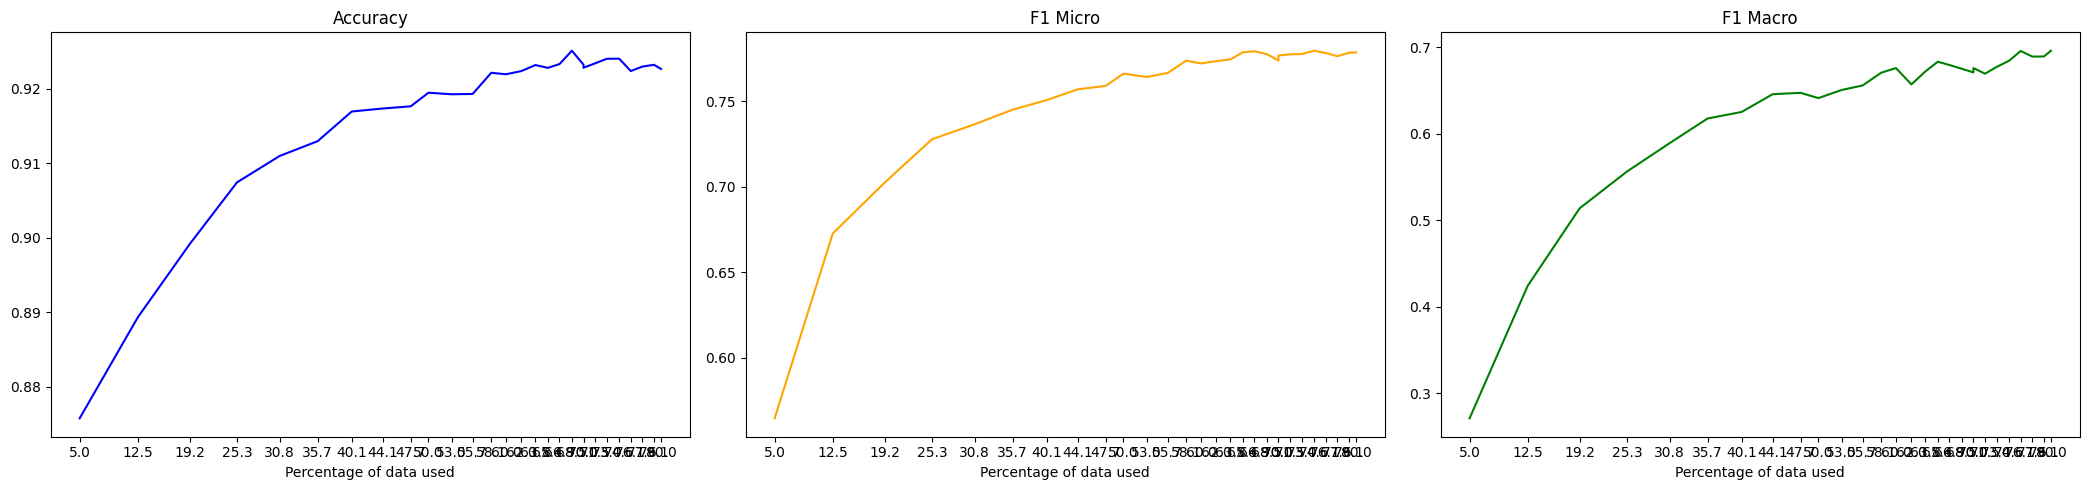

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: [3, 44, 85]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6119, Accuracy: 0.83, F1 Micro: 0.1445, F1 Macro: 0.045
Epoch 2/10, Train Loss: 0.4724, Accuracy: 0.8287, F1 Micro: 0.0209, F1 Macro: 0.0091
Epoch 3/10, Train Loss: 0.3967, Accuracy: 0.8346, F1 Micro: 0.1256, F1 Macro: 0.0415
Epoch 4/10, Train Loss: 0.4024, Accuracy: 0.8353, F1 Micro: 0.122, F1 Macro: 0.0414
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3867, Accuracy: 0.8389, F1 Micro: 0.1605, F1 Macro: 0.0558
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3732, Accuracy: 0.8487, F1 Micro: 0.2747, F1 Macro: 0.0919
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3557, Accuracy: 0.8622, F1 Micro: 0.4166, F1 Macro: 0.1524
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3336, Accuracy: 0.8704, F1 Micro: 0.4692, F1 Macro: 0.2104
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3008, Accuracy: 0.8767, F1 Micro: 0.5572, F1 Macro: 0.2597
Epoch 10/10, Train Loss: 0.2662, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5875, Accuracy: 0.8215, F1 Micro: 0.2912, F1 Macro: 0.1065
Epoch 2/10, Train Loss: 0.4609, Accuracy: 0.829, F1 Micro: 0.0373, F1 Macro: 0.0153
Epoch 3/10, Train Loss: 0.3929, Accuracy: 0.8345, F1 Micro: 0.1121, F1 Macro: 0.041
Epoch 4/10, Train Loss: 0.3973, Accuracy: 0.838, F1 Micro: 0.1566, F1 Macro: 0.0553
Epoch 5/10, Train Loss: 0.381, Accuracy: 0.8457, F1 Micro: 0.2304, F1 Macro: 0.0814
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3626, Accuracy: 0.8547, F1 Micro: 0.3324, F1 Macro: 0.1095
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3452, Accuracy: 0.8677, F1 Micro: 0.4694, F1 Macro: 0.1905
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3219, Accuracy: 0.872, F1 Micro: 0.4893, F1 Macro: 0.2195
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2911, Accuracy: 0.8765, F1 Micro: 0.5515, F1 Macro: 0.2656
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2588, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5819, Accuracy: 0.8291, F1 Micro: 0.0282, F1 Macro: 0.0117
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4862, Accuracy: 0.8332, F1 Micro: 0.1093, F1 Macro: 0.0373
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4155, Accuracy: 0.8362, F1 Micro: 0.1859, F1 Macro: 0.0522
Epoch 4/10, Train Loss: 0.4114, Accuracy: 0.8302, F1 Micro: 0.0304, F1 Macro: 0.0132
Epoch 5/10, Train Loss: 0.3932, Accuracy: 0.8364, F1 Micro: 0.1256, F1 Macro: 0.0443
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3778, Accuracy: 0.8429, F1 Micro: 0.1953, F1 Macro: 0.07
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3695, Accuracy: 0.8553, F1 Micro: 0.335, F1 Macro: 0.1159
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.348, Accuracy: 0.8654, F1 Micro: 0.4275, F1 Macro: 0.1796
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3138, Accuracy: 0.874, F1 Micro: 0.5643, F1 Macro: 0.2599
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5335, Accuracy: 0.8296, F1 Micro: 0.032, F1 Macro: 0.0136
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4011, Accuracy: 0.8346, F1 Micro: 0.095, F1 Macro: 0.0361
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3755, Accuracy: 0.8554, F1 Micro: 0.3514, F1 Macro: 0.1126
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3398, Accuracy: 0.8692, F1 Micro: 0.4449, F1 Macro: 0.1997
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3063, Accuracy: 0.8792, F1 Micro: 0.5958, F1 Macro: 0.287
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2812, Accuracy: 0.8848, F1 Micro: 0.6278, F1 Macro: 0.3338
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2468, Accuracy: 0.8884, F1 Micro: 0.6373, F1 Macro: 0.3499
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2143, Accuracy: 0.8888, F1 Micro: 0.6432, F1 Macro: 0.3835
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5168, Accuracy: 0.8304, F1 Micro: 0.0566, F1 Macro: 0.0222
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3965, Accuracy: 0.84, F1 Micro: 0.1645, F1 Macro: 0.0618
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3699, Accuracy: 0.8565, F1 Micro: 0.3658, F1 Macro: 0.1151
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3347, Accuracy: 0.8672, F1 Micro: 0.4329, F1 Macro: 0.1916
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.301, Accuracy: 0.8798, F1 Micro: 0.6076, F1 Macro: 0.3218
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2748, Accuracy: 0.8846, F1 Micro: 0.6163, F1 Macro: 0.3577
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2414, Accuracy: 0.8894, F1 Micro: 0.6355, F1 Macro: 0.3846
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2096, Accuracy: 0.8907, F1 Micro: 0.649, F1 Macro: 0.4338
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5277, Accuracy: 0.8334, F1 Micro: 0.1225, F1 Macro: 0.0401
Epoch 2/10, Train Loss: 0.4137, Accuracy: 0.8297, F1 Micro: 0.0238, F1 Macro: 0.0104
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3825, Accuracy: 0.8441, F1 Micro: 0.2219, F1 Macro: 0.0756
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3539, Accuracy: 0.8597, F1 Micro: 0.3594, F1 Macro: 0.147
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3178, Accuracy: 0.878, F1 Micro: 0.5945, F1 Macro: 0.2855
Epoch 6/10, Train Loss: 0.2904, Accuracy: 0.8822, F1 Micro: 0.5837, F1 Macro: 0.296
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2537, Accuracy: 0.886, F1 Micro: 0.641, F1 Macro: 0.3691
Epoch 8/10, Train Loss: 0.218, Accuracy: 0.8872, F1 Micro: 0.6256, F1 Macro: 0.3824
Epoch 9/10, Train Loss: 0.203, Accuracy: 0.8895, F1 Micro: 0.6289, F1 Macro: 0.4058
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.1805, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.487, Accuracy: 0.8332, F1 Micro: 0.0894, F1 Macro: 0.0328
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3799, Accuracy: 0.8528, F1 Micro: 0.3075, F1 Macro: 0.1063
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3364, Accuracy: 0.8794, F1 Micro: 0.5667, F1 Macro: 0.2608
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.294, Accuracy: 0.8854, F1 Micro: 0.6306, F1 Macro: 0.3198
Epoch 5/10, Train Loss: 0.2427, Accuracy: 0.8917, F1 Micro: 0.6266, F1 Macro: 0.328
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2315, Accuracy: 0.8956, F1 Micro: 0.6665, F1 Macro: 0.3777
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2043, Accuracy: 0.8979, F1 Micro: 0.6715, F1 Macro: 0.4697
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1867, Accuracy: 0.9014, F1 Micro: 0.6925, F1 Macro: 0.4602
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1586, Accuracy: 0.9015, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.475, Accuracy: 0.8355, F1 Micro: 0.1232, F1 Macro: 0.0455
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3746, Accuracy: 0.8526, F1 Micro: 0.3083, F1 Macro: 0.1043
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3319, Accuracy: 0.8783, F1 Micro: 0.5614, F1 Macro: 0.2615
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2887, Accuracy: 0.8863, F1 Micro: 0.646, F1 Macro: 0.3674
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2396, Accuracy: 0.8944, F1 Micro: 0.6539, F1 Macro: 0.3973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2276, Accuracy: 0.8966, F1 Micro: 0.6623, F1 Macro: 0.4059
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1999, Accuracy: 0.8997, F1 Micro: 0.6713, F1 Macro: 0.4745
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1829, Accuracy: 0.9022, F1 Micro: 0.6888, F1 Macro: 0.4996
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4888, Accuracy: 0.8339, F1 Micro: 0.098, F1 Macro: 0.0353
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3881, Accuracy: 0.8528, F1 Micro: 0.3182, F1 Macro: 0.104
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.348, Accuracy: 0.8774, F1 Micro: 0.5595, F1 Macro: 0.2589
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2998, Accuracy: 0.8849, F1 Micro: 0.6208, F1 Macro: 0.3173
Epoch 5/10, Train Loss: 0.2475, Accuracy: 0.8886, F1 Micro: 0.6152, F1 Macro: 0.3314
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2329, Accuracy: 0.8952, F1 Micro: 0.6732, F1 Macro: 0.4122
Epoch 7/10, Train Loss: 0.2048, Accuracy: 0.8951, F1 Micro: 0.6481, F1 Macro: 0.4669
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1856, Accuracy: 0.8997, F1 Micro: 0.6765, F1 Macro: 0.46
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.154, Accuracy: 0.9027, F1 Micro: 0.7042, F1 Macro: 0.5347
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4689, Accuracy: 0.8394, F1 Micro: 0.1698, F1 Macro: 0.0619
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3605, Accuracy: 0.8776, F1 Micro: 0.5468, F1 Macro: 0.2516
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3035, Accuracy: 0.8864, F1 Micro: 0.6133, F1 Macro: 0.3142
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2596, Accuracy: 0.8943, F1 Micro: 0.6628, F1 Macro: 0.4118
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2255, Accuracy: 0.8997, F1 Micro: 0.6895, F1 Macro: 0.4555
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1896, Accuracy: 0.9034, F1 Micro: 0.6944, F1 Macro: 0.4943
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1685, Accuracy: 0.9044, F1 Micro: 0.717, F1 Macro: 0.5181
Epoch 8/10, Train Loss: 0.1465, Accuracy: 0.9035, F1 Micro: 0.7012, F1 Macro: 0.5249
Epoch 9/10, Train Loss: 0.1255, Accuracy: 0.9062, F1 Micro: 0.7117, F1 Macro: 0.5414
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4602, Accuracy: 0.8469, F1 Micro: 0.2587, F1 Macro: 0.0876
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3558, Accuracy: 0.8774, F1 Micro: 0.5488, F1 Macro: 0.2517
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2982, Accuracy: 0.8884, F1 Micro: 0.6251, F1 Macro: 0.3491
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2572, Accuracy: 0.8959, F1 Micro: 0.6615, F1 Macro: 0.419
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2246, Accuracy: 0.8993, F1 Micro: 0.7033, F1 Macro: 0.5257
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1877, Accuracy: 0.9062, F1 Micro: 0.7085, F1 Macro: 0.5304
Epoch 7/10, Train Loss: 0.1653, Accuracy: 0.9049, F1 Micro: 0.7013, F1 Macro: 0.4971
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1452, Accuracy: 0.907, F1 Micro: 0.7208, F1 Macro: 0.5582
Epoch 9/10, Train Loss: 0.1245, Accuracy: 0.9041, F1 Micro: 0.7207, F1 Macro: 0.5661
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4729, Accuracy: 0.8303, F1 Micro: 0.0308, F1 Macro: 0.0133
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3708, Accuracy: 0.8647, F1 Micro: 0.4169, F1 Macro: 0.1733
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.313, Accuracy: 0.8833, F1 Micro: 0.5931, F1 Macro: 0.2905
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.265, Accuracy: 0.8935, F1 Micro: 0.6594, F1 Macro: 0.3957
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2277, Accuracy: 0.899, F1 Micro: 0.6943, F1 Macro: 0.4763
Epoch 6/10, Train Loss: 0.1931, Accuracy: 0.9021, F1 Micro: 0.694, F1 Macro: 0.5017
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1689, Accuracy: 0.9045, F1 Micro: 0.7014, F1 Macro: 0.5093
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1492, Accuracy: 0.9062, F1 Micro: 0.7218, F1 Macro: 0.5641
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1272, Accuracy: 0.9054, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4579, Accuracy: 0.8415, F1 Micro: 0.2019, F1 Macro: 0.0685
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3482, Accuracy: 0.8779, F1 Micro: 0.6074, F1 Macro: 0.2811
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2871, Accuracy: 0.8902, F1 Micro: 0.6094, F1 Macro: 0.3152
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2555, Accuracy: 0.8952, F1 Micro: 0.6505, F1 Macro: 0.3822
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2189, Accuracy: 0.9042, F1 Micro: 0.7035, F1 Macro: 0.4909
Epoch 6/10, Train Loss: 0.1901, Accuracy: 0.906, F1 Micro: 0.6931, F1 Macro: 0.507
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1663, Accuracy: 0.9062, F1 Micro: 0.7259, F1 Macro: 0.56
Epoch 8/10, Train Loss: 0.1439, Accuracy: 0.9107, F1 Micro: 0.7226, F1 Macro: 0.5476
Epoch 9/10, Train Loss: 0.1227, Accuracy: 0.9109, F1 Micro: 0.7231, F1 Macro: 0.5508
Epoch 10/10, Train Loss: 0.1025, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4484, Accuracy: 0.8513, F1 Micro: 0.3016, F1 Macro: 0.1003
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3414, Accuracy: 0.8788, F1 Micro: 0.6046, F1 Macro: 0.2861
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2813, Accuracy: 0.8917, F1 Micro: 0.6116, F1 Macro: 0.3849
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2507, Accuracy: 0.9005, F1 Micro: 0.6714, F1 Macro: 0.452
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2154, Accuracy: 0.9031, F1 Micro: 0.6914, F1 Macro: 0.4701
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1883, Accuracy: 0.9068, F1 Micro: 0.6931, F1 Macro: 0.5207
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1655, Accuracy: 0.9077, F1 Micro: 0.729, F1 Macro: 0.5679
Epoch 8/10, Train Loss: 0.1419, Accuracy: 0.9095, F1 Micro: 0.7265, F1 Macro: 0.5623
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1202, Accuracy: 0.91, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4623, Accuracy: 0.8381, F1 Micro: 0.1591, F1 Macro: 0.053
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3587, Accuracy: 0.8774, F1 Micro: 0.5485, F1 Macro: 0.2481
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2912, Accuracy: 0.8897, F1 Micro: 0.6242, F1 Macro: 0.3374
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2563, Accuracy: 0.896, F1 Micro: 0.6467, F1 Macro: 0.3748
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2183, Accuracy: 0.9019, F1 Micro: 0.676, F1 Macro: 0.4663
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.191, Accuracy: 0.9073, F1 Micro: 0.7051, F1 Macro: 0.5317
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1672, Accuracy: 0.9074, F1 Micro: 0.7284, F1 Macro: 0.5738
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1451, Accuracy: 0.9085, F1 Micro: 0.7339, F1 Macro: 0.5763
Epoch 9/10, Train Loss: 0.1202, Accuracy: 0.9104, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4451, Accuracy: 0.8461, F1 Micro: 0.2437, F1 Macro: 0.0843
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.33, Accuracy: 0.8831, F1 Micro: 0.5845, F1 Macro: 0.2732
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2781, Accuracy: 0.8959, F1 Micro: 0.6733, F1 Macro: 0.3962
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2381, Accuracy: 0.9029, F1 Micro: 0.6901, F1 Macro: 0.4809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2019, Accuracy: 0.9039, F1 Micro: 0.728, F1 Macro: 0.5523
Epoch 6/10, Train Loss: 0.1747, Accuracy: 0.9082, F1 Micro: 0.7073, F1 Macro: 0.5247
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1438, Accuracy: 0.911, F1 Micro: 0.737, F1 Macro: 0.5669
Epoch 8/10, Train Loss: 0.123, Accuracy: 0.91, F1 Micro: 0.7288, F1 Macro: 0.5713
Epoch 9/10, Train Loss: 0.1064, Accuracy: 0.9115, F1 Micro: 0.7353, F1 Macro: 0.5836
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4362, Accuracy: 0.8487, F1 Micro: 0.2648, F1 Macro: 0.0919
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3249, Accuracy: 0.8829, F1 Micro: 0.5761, F1 Macro: 0.2857
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2739, Accuracy: 0.897, F1 Micro: 0.6795, F1 Macro: 0.4126
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2349, Accuracy: 0.9041, F1 Micro: 0.6946, F1 Macro: 0.5004
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1975, Accuracy: 0.9055, F1 Micro: 0.7261, F1 Macro: 0.5708
Epoch 6/10, Train Loss: 0.1686, Accuracy: 0.9106, F1 Micro: 0.7208, F1 Macro: 0.5547
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1374, Accuracy: 0.9114, F1 Micro: 0.7362, F1 Macro: 0.5837
Epoch 8/10, Train Loss: 0.1188, Accuracy: 0.9096, F1 Micro: 0.7289, F1 Macro: 0.5703
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1024, Accuracy: 0.9124, F1 Micro: 0.7386, F1 Macro: 0.5844
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4502, Accuracy: 0.8445, F1 Micro: 0.2288, F1 Macro: 0.0803
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3395, Accuracy: 0.8807, F1 Micro: 0.5775, F1 Macro: 0.2711
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2811, Accuracy: 0.8964, F1 Micro: 0.6717, F1 Macro: 0.4323
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2399, Accuracy: 0.9045, F1 Micro: 0.6978, F1 Macro: 0.507
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2026, Accuracy: 0.9067, F1 Micro: 0.7289, F1 Macro: 0.5574
Epoch 6/10, Train Loss: 0.1746, Accuracy: 0.9092, F1 Micro: 0.7161, F1 Macro: 0.5473
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1439, Accuracy: 0.9118, F1 Micro: 0.7309, F1 Macro: 0.5761
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1261, Accuracy: 0.9114, F1 Micro: 0.7353, F1 Macro: 0.5841
Epoch 9/10, Train Loss: 0.1047, Accuracy: 0.9115, F1 Micro: 0.729, F1 Macro: 0.5766
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.438, Accuracy: 0.8578, F1 Micro: 0.4076, F1 Macro: 0.1362
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3205, Accuracy: 0.8883, F1 Micro: 0.6111, F1 Macro: 0.3095
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2663, Accuracy: 0.8991, F1 Micro: 0.6662, F1 Macro: 0.4074
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2281, Accuracy: 0.9059, F1 Micro: 0.702, F1 Macro: 0.518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1876, Accuracy: 0.91, F1 Micro: 0.7198, F1 Macro: 0.5262
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1625, Accuracy: 0.9086, F1 Micro: 0.7429, F1 Macro: 0.5784
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1392, Accuracy: 0.9123, F1 Micro: 0.7434, F1 Macro: 0.5857
Epoch 8/10, Train Loss: 0.1195, Accuracy: 0.9133, F1 Micro: 0.7374, F1 Macro: 0.6035
Epoch 9/10, Train Loss: 0.1019, Accuracy: 0.9174, F1 Micro: 0.7419, F1 Macro: 0.5951
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4298, Accuracy: 0.8609, F1 Micro: 0.44, F1 Macro: 0.1539
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3167, Accuracy: 0.8891, F1 Micro: 0.6283, F1 Macro: 0.3612
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2609, Accuracy: 0.9004, F1 Micro: 0.6825, F1 Macro: 0.4795
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2246, Accuracy: 0.9063, F1 Micro: 0.71, F1 Macro: 0.5356
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1887, Accuracy: 0.909, F1 Micro: 0.7101, F1 Macro: 0.5074
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1609, Accuracy: 0.9137, F1 Micro: 0.7298, F1 Macro: 0.5622
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1377, Accuracy: 0.913, F1 Micro: 0.7335, F1 Macro: 0.5635
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1184, Accuracy: 0.9111, F1 Micro: 0.7434, F1 Macro: 0.6026
Epoch 9/10, Train Loss: 0.0977, Accuracy: 0.9149, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4441, Accuracy: 0.8526, F1 Micro: 0.329, F1 Macro: 0.1075
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3296, Accuracy: 0.8861, F1 Micro: 0.6158, F1 Macro: 0.3173
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2702, Accuracy: 0.8999, F1 Micro: 0.6732, F1 Macro: 0.4194
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2301, Accuracy: 0.9063, F1 Micro: 0.7024, F1 Macro: 0.5238
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1915, Accuracy: 0.9099, F1 Micro: 0.7281, F1 Macro: 0.5426
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1637, Accuracy: 0.9142, F1 Micro: 0.7377, F1 Macro: 0.5754
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1367, Accuracy: 0.912, F1 Micro: 0.7426, F1 Macro: 0.585
Epoch 8/10, Train Loss: 0.1176, Accuracy: 0.9156, F1 Micro: 0.7401, F1 Macro: 0.5912
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1009, Accuracy: 0.9148, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4309, Accuracy: 0.8616, F1 Micro: 0.4552, F1 Macro: 0.1563
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3135, Accuracy: 0.8919, F1 Micro: 0.6522, F1 Macro: 0.3508
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.259, Accuracy: 0.9018, F1 Micro: 0.6976, F1 Macro: 0.4827
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2265, Accuracy: 0.9089, F1 Micro: 0.723, F1 Macro: 0.5322
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1857, Accuracy: 0.9117, F1 Micro: 0.7269, F1 Macro: 0.5603
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1618, Accuracy: 0.9129, F1 Micro: 0.7427, F1 Macro: 0.5779
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1379, Accuracy: 0.9153, F1 Micro: 0.7435, F1 Macro: 0.5952
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1137, Accuracy: 0.9167, F1 Micro: 0.7557, F1 Macro: 0.6345
Epoch 9/10, Train Loss: 0.0942, Accuracy: 0.9148, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4225, Accuracy: 0.8641, F1 Micro: 0.4902, F1 Macro: 0.1863
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.31, Accuracy: 0.8934, F1 Micro: 0.652, F1 Macro: 0.3867
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2578, Accuracy: 0.9026, F1 Micro: 0.6977, F1 Macro: 0.4762
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2249, Accuracy: 0.9093, F1 Micro: 0.7233, F1 Macro: 0.5402
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1877, Accuracy: 0.9103, F1 Micro: 0.7338, F1 Macro: 0.5897
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.16, Accuracy: 0.9138, F1 Micro: 0.7434, F1 Macro: 0.5858
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1343, Accuracy: 0.9161, F1 Micro: 0.7554, F1 Macro: 0.6117
Epoch 8/10, Train Loss: 0.1173, Accuracy: 0.9146, F1 Micro: 0.7377, F1 Macro: 0.5976
Epoch 9/10, Train Loss: 0.0985, Accuracy: 0.9161, F1 Micro: 0.7521, F1 Macro: 0.6432
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4351, Accuracy: 0.8593, F1 Micro: 0.4237, F1 Macro: 0.1474
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3183, Accuracy: 0.8912, F1 Micro: 0.6318, F1 Macro: 0.3351
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2617, Accuracy: 0.9027, F1 Micro: 0.6925, F1 Macro: 0.4868
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2279, Accuracy: 0.9095, F1 Micro: 0.7234, F1 Macro: 0.5358
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1869, Accuracy: 0.9133, F1 Micro: 0.7311, F1 Macro: 0.5794
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1592, Accuracy: 0.9143, F1 Micro: 0.7506, F1 Macro: 0.5996
Epoch 7/10, Train Loss: 0.1372, Accuracy: 0.9155, F1 Micro: 0.7404, F1 Macro: 0.5844
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1184, Accuracy: 0.9183, F1 Micro: 0.7557, F1 Macro: 0.617
Epoch 9/10, Train Loss: 0.0949, Accuracy: 0.9186, F1 Micro: 0.7552, F1 Macro: 0.6436
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4221, Accuracy: 0.8658, F1 Micro: 0.4177, F1 Macro: 0.1797
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3064, Accuracy: 0.8907, F1 Micro: 0.6039, F1 Macro: 0.3553
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2473, Accuracy: 0.9045, F1 Micro: 0.6949, F1 Macro: 0.4768
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2179, Accuracy: 0.9114, F1 Micro: 0.7248, F1 Macro: 0.5405
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1781, Accuracy: 0.911, F1 Micro: 0.7428, F1 Macro: 0.5803
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1518, Accuracy: 0.9139, F1 Micro: 0.7488, F1 Macro: 0.5958
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.131, Accuracy: 0.916, F1 Micro: 0.7501, F1 Macro: 0.6358
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1092, Accuracy: 0.9171, F1 Micro: 0.757, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4152, Accuracy: 0.8667, F1 Micro: 0.428, F1 Macro: 0.178
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3024, Accuracy: 0.8929, F1 Micro: 0.613, F1 Macro: 0.3828
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2442, Accuracy: 0.9045, F1 Micro: 0.6833, F1 Macro: 0.4758
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.217, Accuracy: 0.9102, F1 Micro: 0.7182, F1 Macro: 0.5499
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1773, Accuracy: 0.9139, F1 Micro: 0.7411, F1 Macro: 0.5893
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1526, Accuracy: 0.917, F1 Micro: 0.7494, F1 Macro: 0.5969
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1304, Accuracy: 0.9137, F1 Micro: 0.751, F1 Macro: 0.6112
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1127, Accuracy: 0.916, F1 Micro: 0.758, F1 Macro: 0.6276
Epoch 9/10, Train Loss: 0.0916, Accuracy: 0.9165, F1 Micro: 0.75

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.428, Accuracy: 0.8636, F1 Micro: 0.4244, F1 Macro: 0.1707
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3128, Accuracy: 0.8862, F1 Micro: 0.5794, F1 Macro: 0.3372
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2479, Accuracy: 0.9034, F1 Micro: 0.6823, F1 Macro: 0.4698
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2173, Accuracy: 0.912, F1 Micro: 0.725, F1 Macro: 0.5559
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1777, Accuracy: 0.9124, F1 Micro: 0.7484, F1 Macro: 0.5985
Epoch 6/10, Train Loss: 0.1521, Accuracy: 0.9142, F1 Micro: 0.7463, F1 Macro: 0.592
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.13, Accuracy: 0.916, F1 Micro: 0.7486, F1 Macro: 0.6076
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1097, Accuracy: 0.9179, F1 Micro: 0.7592, F1 Macro: 0.6362
Epoch 9/10, Train Loss: 0.091, Accuracy: 0.9193, F1 Micro: 0.7538, F1 Macro: 0.6406
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4159, Accuracy: 0.8767, F1 Micro: 0.5762, F1 Macro: 0.2647
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3003, Accuracy: 0.8957, F1 Micro: 0.6672, F1 Macro: 0.4251
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2439, Accuracy: 0.9028, F1 Micro: 0.6827, F1 Macro: 0.4357
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2094, Accuracy: 0.9108, F1 Micro: 0.7216, F1 Macro: 0.5176
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1783, Accuracy: 0.9116, F1 Micro: 0.7482, F1 Macro: 0.5794
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1547, Accuracy: 0.917, F1 Micro: 0.7552, F1 Macro: 0.6165
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1295, Accuracy: 0.9178, F1 Micro: 0.7561, F1 Macro: 0.6233
Epoch 8/10, Train Loss: 0.1089, Accuracy: 0.9154, F1 Micro: 0.7525, F1 Macro: 0.6359
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0912, Accuracy: 0.9165, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4088, Accuracy: 0.8764, F1 Micro: 0.5726, F1 Macro: 0.2619
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2968, Accuracy: 0.8942, F1 Micro: 0.6441, F1 Macro: 0.4333
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2418, Accuracy: 0.903, F1 Micro: 0.6804, F1 Macro: 0.4631
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2079, Accuracy: 0.9107, F1 Micro: 0.7243, F1 Macro: 0.535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1763, Accuracy: 0.9115, F1 Micro: 0.7471, F1 Macro: 0.5775
Epoch 6/10, Train Loss: 0.1502, Accuracy: 0.9176, F1 Micro: 0.7457, F1 Macro: 0.5983
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1304, Accuracy: 0.9168, F1 Micro: 0.751, F1 Macro: 0.601
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1079, Accuracy: 0.9191, F1 Micro: 0.7635, F1 Macro: 0.6351
Epoch 9/10, Train Loss: 0.0886, Accuracy: 0.9186, F1 Micro: 0.7581, F1 Macro: 0.647
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4232, Accuracy: 0.8719, F1 Micro: 0.5266, F1 Macro: 0.2326
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3043, Accuracy: 0.8937, F1 Micro: 0.6605, F1 Macro: 0.4296
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.245, Accuracy: 0.9023, F1 Micro: 0.6761, F1 Macro: 0.4551
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2094, Accuracy: 0.9105, F1 Micro: 0.7183, F1 Macro: 0.5319
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1786, Accuracy: 0.9128, F1 Micro: 0.75, F1 Macro: 0.582
Epoch 6/10, Train Loss: 0.1493, Accuracy: 0.9161, F1 Micro: 0.7497, F1 Macro: 0.5946
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1303, Accuracy: 0.9163, F1 Micro: 0.7504, F1 Macro: 0.6054
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1063, Accuracy: 0.9149, F1 Micro: 0.7534, F1 Macro: 0.6204
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0919, Accuracy: 0.915, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4097, Accuracy: 0.8784, F1 Micro: 0.5476, F1 Macro: 0.251
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2934, Accuracy: 0.8972, F1 Micro: 0.6804, F1 Macro: 0.3802
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.24, Accuracy: 0.9075, F1 Micro: 0.7165, F1 Macro: 0.5088
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2078, Accuracy: 0.9141, F1 Micro: 0.7257, F1 Macro: 0.5422
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1774, Accuracy: 0.9166, F1 Micro: 0.7442, F1 Macro: 0.5689
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1447, Accuracy: 0.919, F1 Micro: 0.7526, F1 Macro: 0.6135
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1233, Accuracy: 0.9205, F1 Micro: 0.7599, F1 Macro: 0.6258
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.104, Accuracy: 0.9224, F1 Micro: 0.7677, F1 Macro: 0.6661
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.08

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4021, Accuracy: 0.8797, F1 Micro: 0.5646, F1 Macro: 0.2575
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2913, Accuracy: 0.8987, F1 Micro: 0.682, F1 Macro: 0.4665
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2379, Accuracy: 0.9079, F1 Micro: 0.7146, F1 Macro: 0.539
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2045, Accuracy: 0.9137, F1 Micro: 0.7368, F1 Macro: 0.5803
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1803, Accuracy: 0.9174, F1 Micro: 0.746, F1 Macro: 0.5825
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1467, Accuracy: 0.9192, F1 Micro: 0.7526, F1 Macro: 0.6065
Epoch 7/10, Train Loss: 0.1188, Accuracy: 0.9158, F1 Micro: 0.7503, F1 Macro: 0.6165
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1002, Accuracy: 0.9187, F1 Micro: 0.7623, F1 Macro: 0.6432
Epoch 9/10, Train Loss: 0.0875, Accuracy: 0.9133, F1 Micro: 0.7594, F1 Macro: 0.6411
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4162, Accuracy: 0.8722, F1 Micro: 0.4876, F1 Macro: 0.2165
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2994, Accuracy: 0.895, F1 Micro: 0.6618, F1 Macro: 0.3647
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2425, Accuracy: 0.907, F1 Micro: 0.7051, F1 Macro: 0.5228
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2069, Accuracy: 0.9121, F1 Micro: 0.7182, F1 Macro: 0.5521
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1799, Accuracy: 0.9164, F1 Micro: 0.749, F1 Macro: 0.5821
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.146, Accuracy: 0.9176, F1 Micro: 0.7545, F1 Macro: 0.6112
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1245, Accuracy: 0.9193, F1 Micro: 0.762, F1 Macro: 0.6223
Epoch 8/10, Train Loss: 0.105, Accuracy: 0.9156, F1 Micro: 0.7612, F1 Macro: 0.6411
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0887, Accuracy: 0.9187, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4129, Accuracy: 0.8786, F1 Micro: 0.5479, F1 Macro: 0.2502
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2897, Accuracy: 0.8991, F1 Micro: 0.6807, F1 Macro: 0.4555
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2359, Accuracy: 0.908, F1 Micro: 0.7206, F1 Macro: 0.5277
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1964, Accuracy: 0.9153, F1 Micro: 0.735, F1 Macro: 0.5528
Epoch 5/10, Train Loss: 0.1703, Accuracy: 0.9174, F1 Micro: 0.7309, F1 Macro: 0.5819
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1428, Accuracy: 0.9189, F1 Micro: 0.7698, F1 Macro: 0.6359
Epoch 7/10, Train Loss: 0.1202, Accuracy: 0.9227, F1 Micro: 0.7662, F1 Macro: 0.6615
Epoch 8/10, Train Loss: 0.0978, Accuracy: 0.9225, F1 Micro: 0.7668, F1 Macro: 0.6516
Epoch 9/10, Train Loss: 0.0854, Accuracy: 0.9221, F1 Micro: 0.7611, F1 Macro: 0.6643
Epoch 10/10, Train Loss: 0.0738, Accuracy: 0.9236, F1 Micro: 0.7683, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4064, Accuracy: 0.8797, F1 Micro: 0.5739, F1 Macro: 0.2662
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2876, Accuracy: 0.8996, F1 Micro: 0.6797, F1 Macro: 0.4644
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.232, Accuracy: 0.9083, F1 Micro: 0.7095, F1 Macro: 0.5406
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1967, Accuracy: 0.9152, F1 Micro: 0.745, F1 Macro: 0.5869
Epoch 5/10, Train Loss: 0.1694, Accuracy: 0.9178, F1 Micro: 0.7437, F1 Macro: 0.5985
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1417, Accuracy: 0.9158, F1 Micro: 0.7609, F1 Macro: 0.6121
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1187, Accuracy: 0.9155, F1 Micro: 0.763, F1 Macro: 0.6362
Epoch 8/10, Train Loss: 0.0989, Accuracy: 0.9204, F1 Micro: 0.7607, F1 Macro: 0.6417
Epoch 9/10, Train Loss: 0.0828, Accuracy: 0.9215, F1 Micro: 0.7589, F1 Macro: 0.6649
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4192, Accuracy: 0.8768, F1 Micro: 0.5675, F1 Macro: 0.2582
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.294, Accuracy: 0.8991, F1 Micro: 0.6835, F1 Macro: 0.474
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2375, Accuracy: 0.9091, F1 Micro: 0.7179, F1 Macro: 0.5268
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1977, Accuracy: 0.915, F1 Micro: 0.7372, F1 Macro: 0.5794
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1677, Accuracy: 0.9184, F1 Micro: 0.7416, F1 Macro: 0.5928
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1441, Accuracy: 0.9164, F1 Micro: 0.7623, F1 Macro: 0.6163
Epoch 7/10, Train Loss: 0.1197, Accuracy: 0.9196, F1 Micro: 0.7612, F1 Macro: 0.6302
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0978, Accuracy: 0.9209, F1 Micro: 0.7635, F1 Macro: 0.6419
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0843, Accuracy: 0.9209, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4091, Accuracy: 0.8817, F1 Micro: 0.5868, F1 Macro: 0.2703
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2873, Accuracy: 0.899, F1 Micro: 0.6921, F1 Macro: 0.4467
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2384, Accuracy: 0.9094, F1 Micro: 0.7332, F1 Macro: 0.5467
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2003, Accuracy: 0.9178, F1 Micro: 0.7491, F1 Macro: 0.5679
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1642, Accuracy: 0.918, F1 Micro: 0.7617, F1 Macro: 0.6119
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1409, Accuracy: 0.919, F1 Micro: 0.7672, F1 Macro: 0.6239
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1204, Accuracy: 0.9175, F1 Micro: 0.7692, F1 Macro: 0.6532
Epoch 8/10, Train Loss: 0.0953, Accuracy: 0.9225, F1 Micro: 0.7656, F1 Macro: 0.6601
Epoch 9/10, Train Loss: 0.0852, Accuracy: 0.9141, F1 Micro: 0.7649, F1 Macro: 0.6747
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4024, Accuracy: 0.8818, F1 Micro: 0.5964, F1 Macro: 0.2783
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2839, Accuracy: 0.9012, F1 Micro: 0.6947, F1 Macro: 0.4507
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2357, Accuracy: 0.9104, F1 Micro: 0.7346, F1 Macro: 0.5527
Epoch 4/10, Train Loss: 0.1976, Accuracy: 0.9163, F1 Micro: 0.729, F1 Macro: 0.5602
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1631, Accuracy: 0.9173, F1 Micro: 0.7542, F1 Macro: 0.5995
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1417, Accuracy: 0.9198, F1 Micro: 0.7622, F1 Macro: 0.6177
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1172, Accuracy: 0.9183, F1 Micro: 0.7658, F1 Macro: 0.6456
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0968, Accuracy: 0.9222, F1 Micro: 0.7688, F1 Macro: 0.653
Epoch 9/10, Train Loss: 0.0852, Accuracy: 0.9178, F1 Micro: 0.7643, F1 Macro: 0.6602
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4109, Accuracy: 0.8814, F1 Micro: 0.5838, F1 Macro: 0.2694
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2907, Accuracy: 0.9007, F1 Micro: 0.6877, F1 Macro: 0.4282
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2383, Accuracy: 0.9084, F1 Micro: 0.7288, F1 Macro: 0.5397
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2, Accuracy: 0.9161, F1 Micro: 0.7333, F1 Macro: 0.5714
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1651, Accuracy: 0.9163, F1 Micro: 0.7583, F1 Macro: 0.6051
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1432, Accuracy: 0.9167, F1 Micro: 0.7608, F1 Macro: 0.6102
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1179, Accuracy: 0.9182, F1 Micro: 0.7665, F1 Macro: 0.6464
Epoch 8/10, Train Loss: 0.0952, Accuracy: 0.9202, F1 Micro: 0.7622, F1 Macro: 0.6453
Epoch 9/10, Train Loss: 0.0864, Accuracy: 0.9208, F1 Micro: 0.7581, F1 Macro: 0.6616
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.406, Accuracy: 0.8769, F1 Micro: 0.5178, F1 Macro: 0.2368
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2841, Accuracy: 0.8978, F1 Micro: 0.6744, F1 Macro: 0.4263
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.237, Accuracy: 0.9107, F1 Micro: 0.725, F1 Macro: 0.5158
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2018, Accuracy: 0.916, F1 Micro: 0.7469, F1 Macro: 0.5735
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1661, Accuracy: 0.9184, F1 Micro: 0.7558, F1 Macro: 0.5904
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1381, Accuracy: 0.9204, F1 Micro: 0.758, F1 Macro: 0.6183
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1202, Accuracy: 0.9194, F1 Micro: 0.7685, F1 Macro: 0.6465
Epoch 8/10, Train Loss: 0.098, Accuracy: 0.918, F1 Micro: 0.764, F1 Macro: 0.6394
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0842, Accuracy: 0.9236, F1 Micro: 0.77

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3991, Accuracy: 0.8765, F1 Micro: 0.5113, F1 Macro: 0.2352
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2819, Accuracy: 0.9, F1 Micro: 0.686, F1 Macro: 0.471
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2337, Accuracy: 0.911, F1 Micro: 0.7259, F1 Macro: 0.5462
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1991, Accuracy: 0.9165, F1 Micro: 0.7422, F1 Macro: 0.5836
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1657, Accuracy: 0.9173, F1 Micro: 0.7468, F1 Macro: 0.5747
Epoch 6/10, Train Loss: 0.1376, Accuracy: 0.9195, F1 Micro: 0.7452, F1 Macro: 0.6063
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1177, Accuracy: 0.9204, F1 Micro: 0.7612, F1 Macro: 0.6394
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0977, Accuracy: 0.9187, F1 Micro: 0.762, F1 Macro: 0.6278
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.086, Accuracy: 0.9209, F1 Micro: 0.76

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4123, Accuracy: 0.8759, F1 Micro: 0.5127, F1 Macro: 0.2359
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2869, Accuracy: 0.8983, F1 Micro: 0.6708, F1 Macro: 0.4233
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2361, Accuracy: 0.9107, F1 Micro: 0.7273, F1 Macro: 0.5369
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1987, Accuracy: 0.9156, F1 Micro: 0.7448, F1 Macro: 0.5792
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1639, Accuracy: 0.917, F1 Micro: 0.7577, F1 Macro: 0.5951
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1365, Accuracy: 0.9198, F1 Micro: 0.7593, F1 Macro: 0.6095
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1168, Accuracy: 0.9166, F1 Micro: 0.7619, F1 Macro: 0.644
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1002, Accuracy: 0.917, F1 Micro: 0.7657, F1 Macro: 0.6463
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4055, Accuracy: 0.8805, F1 Micro: 0.5721, F1 Macro: 0.2682
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.283, Accuracy: 0.9006, F1 Micro: 0.7042, F1 Macro: 0.4678
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2272, Accuracy: 0.9091, F1 Micro: 0.7321, F1 Macro: 0.5348
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.197, Accuracy: 0.9174, F1 Micro: 0.7432, F1 Macro: 0.579
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1626, Accuracy: 0.9224, F1 Micro: 0.767, F1 Macro: 0.613
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1372, Accuracy: 0.9232, F1 Micro: 0.7673, F1 Macro: 0.6182
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1138, Accuracy: 0.921, F1 Micro: 0.7689, F1 Macro: 0.6269
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0986, Accuracy: 0.9235, F1 Micro: 0.769, F1 Macro: 0.6521
Epoch 9/10, Train Loss: 0.0805, Accuracy: 0.9222, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3992, Accuracy: 0.881, F1 Micro: 0.5954, F1 Macro: 0.2843
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.28, Accuracy: 0.9004, F1 Micro: 0.7055, F1 Macro: 0.4796
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2256, Accuracy: 0.9095, F1 Micro: 0.7256, F1 Macro: 0.536
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.197, Accuracy: 0.9187, F1 Micro: 0.7491, F1 Macro: 0.5921
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1606, Accuracy: 0.9183, F1 Micro: 0.7549, F1 Macro: 0.6042
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.139, Accuracy: 0.9222, F1 Micro: 0.7596, F1 Macro: 0.6131
Epoch 7/10, Train Loss: 0.1148, Accuracy: 0.921, F1 Micro: 0.7593, F1 Macro: 0.6152
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1, Accuracy: 0.9217, F1 Micro: 0.7631, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0852, Accuracy: 0.9214, F1 Micro: 0.767, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4119, Accuracy: 0.8795, F1 Micro: 0.5721, F1 Macro: 0.2674
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.288, Accuracy: 0.8997, F1 Micro: 0.6965, F1 Macro: 0.4608
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2289, Accuracy: 0.9074, F1 Micro: 0.7245, F1 Macro: 0.5247
Epoch 4/10, Train Loss: 0.1988, Accuracy: 0.9142, F1 Micro: 0.7207, F1 Macro: 0.5674
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1635, Accuracy: 0.9195, F1 Micro: 0.7626, F1 Macro: 0.6077
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.138, Accuracy: 0.9215, F1 Micro: 0.7651, F1 Macro: 0.6203
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1168, Accuracy: 0.9214, F1 Micro: 0.7657, F1 Macro: 0.6381
Epoch 8/10, Train Loss: 0.0987, Accuracy: 0.9212, F1 Micro: 0.7653, F1 Macro: 0.6471
Epoch 9/10, Train Loss: 0.0857, Accuracy: 0.92, F1 Micro: 0.7595, F1 Macro: 0.6673
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4026, Accuracy: 0.8815, F1 Micro: 0.5711, F1 Macro: 0.2657
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2829, Accuracy: 0.9019, F1 Micro: 0.6989, F1 Macro: 0.4774
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2286, Accuracy: 0.9109, F1 Micro: 0.7243, F1 Macro: 0.541
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1842, Accuracy: 0.9191, F1 Micro: 0.7565, F1 Macro: 0.5805
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1627, Accuracy: 0.9225, F1 Micro: 0.765, F1 Macro: 0.619
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1354, Accuracy: 0.9201, F1 Micro: 0.7707, F1 Macro: 0.6489
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1145, Accuracy: 0.9231, F1 Micro: 0.7753, F1 Macro: 0.677
Epoch 8/10, Train Loss: 0.0973, Accuracy: 0.9256, F1 Micro: 0.7747, F1 Macro: 0.6798
Epoch 9/10, Train Loss: 0.0807, Accuracy: 0.9243, F1 Micro: 0.774, F1 Macro: 0.6882
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3965, Accuracy: 0.8831, F1 Micro: 0.6076, F1 Macro: 0.295
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.281, Accuracy: 0.9029, F1 Micro: 0.6917, F1 Macro: 0.4714
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2293, Accuracy: 0.9096, F1 Micro: 0.7234, F1 Macro: 0.567
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1848, Accuracy: 0.915, F1 Micro: 0.7536, F1 Macro: 0.5971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1639, Accuracy: 0.9205, F1 Micro: 0.7664, F1 Macro: 0.6136
Epoch 6/10, Train Loss: 0.1339, Accuracy: 0.92, F1 Micro: 0.7629, F1 Macro: 0.6342
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1139, Accuracy: 0.9221, F1 Micro: 0.7682, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0999, Accuracy: 0.9242, F1 Micro: 0.7711, F1 Macro: 0.6658
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0852, Accuracy: 0.9217, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4096, Accuracy: 0.881, F1 Micro: 0.5955, F1 Macro: 0.2803
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2864, Accuracy: 0.9027, F1 Micro: 0.6894, F1 Macro: 0.4748
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2308, Accuracy: 0.911, F1 Micro: 0.7324, F1 Macro: 0.5635
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1858, Accuracy: 0.9171, F1 Micro: 0.7582, F1 Macro: 0.5955
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1623, Accuracy: 0.9235, F1 Micro: 0.7696, F1 Macro: 0.6152
Epoch 6/10, Train Loss: 0.1342, Accuracy: 0.9204, F1 Micro: 0.765, F1 Macro: 0.6402
Epoch 7/10, Train Loss: 0.1146, Accuracy: 0.9233, F1 Micro: 0.7688, F1 Macro: 0.6593
Epoch 8/10, Train Loss: 0.1003, Accuracy: 0.9205, F1 Micro: 0.7648, F1 Macro: 0.6576
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0816, Accuracy: 0.923, F1 Micro: 0.776, F1 Macro: 0.6796
Epoch 10/10, Train Loss: 0.0718, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3949, Accuracy: 0.8809, F1 Micro: 0.5474, F1 Macro: 0.2516
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2748, Accuracy: 0.9009, F1 Micro: 0.6989, F1 Macro: 0.4887
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2247, Accuracy: 0.9121, F1 Micro: 0.7292, F1 Macro: 0.564
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1913, Accuracy: 0.9212, F1 Micro: 0.7596, F1 Macro: 0.5941
Epoch 5/10, Train Loss: 0.1604, Accuracy: 0.9204, F1 Micro: 0.7591, F1 Macro: 0.602
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1324, Accuracy: 0.9238, F1 Micro: 0.7675, F1 Macro: 0.6464
Epoch 7/10, Train Loss: 0.1103, Accuracy: 0.9225, F1 Micro: 0.7645, F1 Macro: 0.6521
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0941, Accuracy: 0.9246, F1 Micro: 0.7731, F1 Macro: 0.6793
Epoch 9/10, Train Loss: 0.0787, Accuracy: 0.923, F1 Micro: 0.7709, F1 Macro: 0.692
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3895, Accuracy: 0.8793, F1 Micro: 0.5391, F1 Macro: 0.2566
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2717, Accuracy: 0.9032, F1 Micro: 0.7033, F1 Macro: 0.528
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2256, Accuracy: 0.913, F1 Micro: 0.7247, F1 Macro: 0.5729
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1913, Accuracy: 0.9193, F1 Micro: 0.7556, F1 Macro: 0.5952
Epoch 5/10, Train Loss: 0.1589, Accuracy: 0.9188, F1 Micro: 0.7426, F1 Macro: 0.5772
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1326, Accuracy: 0.9227, F1 Micro: 0.7639, F1 Macro: 0.6312
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1108, Accuracy: 0.9231, F1 Micro: 0.7683, F1 Macro: 0.6512
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0937, Accuracy: 0.923, F1 Micro: 0.774, F1 Macro: 0.6677
Epoch 9/10, Train Loss: 0.0778, Accuracy: 0.922, F1 Micro: 0.7678, F1 Macro: 0.678
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4022, Accuracy: 0.8784, F1 Micro: 0.5429, F1 Macro: 0.2518
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2762, Accuracy: 0.9024, F1 Micro: 0.6956, F1 Macro: 0.5062
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2261, Accuracy: 0.9129, F1 Micro: 0.7241, F1 Macro: 0.5689
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1931, Accuracy: 0.9179, F1 Micro: 0.7585, F1 Macro: 0.5967
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1595, Accuracy: 0.9193, F1 Micro: 0.7613, F1 Macro: 0.6034
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1319, Accuracy: 0.9213, F1 Micro: 0.7688, F1 Macro: 0.6395
Epoch 7/10, Train Loss: 0.1102, Accuracy: 0.9169, F1 Micro: 0.7624, F1 Macro: 0.6475
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0966, Accuracy: 0.9221, F1 Micro: 0.7743, F1 Macro: 0.6802
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0799, Accuracy: 0.9227, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3964, Accuracy: 0.8804, F1 Micro: 0.5556, F1 Macro: 0.2608
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2749, Accuracy: 0.9041, F1 Micro: 0.7078, F1 Macro: 0.4902
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2283, Accuracy: 0.9088, F1 Micro: 0.7454, F1 Macro: 0.5712
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1948, Accuracy: 0.9159, F1 Micro: 0.76, F1 Macro: 0.6087
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1594, Accuracy: 0.913, F1 Micro: 0.7604, F1 Macro: 0.6202
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1338, Accuracy: 0.9234, F1 Micro: 0.7669, F1 Macro: 0.6377
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1105, Accuracy: 0.9233, F1 Micro: 0.7673, F1 Macro: 0.6629
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0942, Accuracy: 0.9219, F1 Micro: 0.7719, F1 Macro: 0.6827
Epoch 9/10, Train Loss: 0.0831, Accuracy: 0.9201, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3891, Accuracy: 0.8788, F1 Micro: 0.5308, F1 Macro: 0.2512
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2724, Accuracy: 0.9047, F1 Micro: 0.7129, F1 Macro: 0.5156
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2265, Accuracy: 0.9086, F1 Micro: 0.7405, F1 Macro: 0.5721
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1937, Accuracy: 0.9191, F1 Micro: 0.762, F1 Macro: 0.6131
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1589, Accuracy: 0.9198, F1 Micro: 0.765, F1 Macro: 0.6056
Epoch 6/10, Train Loss: 0.1321, Accuracy: 0.9205, F1 Micro: 0.7534, F1 Macro: 0.6022
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1074, Accuracy: 0.9212, F1 Micro: 0.773, F1 Macro: 0.6466
Epoch 8/10, Train Loss: 0.0928, Accuracy: 0.9205, F1 Micro: 0.7698, F1 Macro: 0.6611
Epoch 9/10, Train Loss: 0.083, Accuracy: 0.9206, F1 Micro: 0.7688, F1 Macro: 0.6627
Epoch 10/10, Train Loss: 0.071, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4036, Accuracy: 0.8814, F1 Micro: 0.5761, F1 Macro: 0.2728
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2784, Accuracy: 0.9028, F1 Micro: 0.707, F1 Macro: 0.5052
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2261, Accuracy: 0.9089, F1 Micro: 0.7417, F1 Macro: 0.5723
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1941, Accuracy: 0.9161, F1 Micro: 0.7571, F1 Macro: 0.6059
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1558, Accuracy: 0.9214, F1 Micro: 0.7653, F1 Macro: 0.6188
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1331, Accuracy: 0.9234, F1 Micro: 0.7686, F1 Macro: 0.6304
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1106, Accuracy: 0.9227, F1 Micro: 0.7713, F1 Macro: 0.6756
Epoch 8/10, Train Loss: 0.0926, Accuracy: 0.9224, F1 Micro: 0.7707, F1 Macro: 0.6721
Epoch 9/10, Train Loss: 0.0839, Accuracy: 0.9226, F1 Micro: 0.769, F1 Macro: 0.6634
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3945, Accuracy: 0.8857, F1 Micro: 0.6145, F1 Macro: 0.3006
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.267, Accuracy: 0.9054, F1 Micro: 0.7077, F1 Macro: 0.5173
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2237, Accuracy: 0.9134, F1 Micro: 0.73, F1 Macro: 0.5438
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1836, Accuracy: 0.9189, F1 Micro: 0.7629, F1 Macro: 0.6021
Epoch 5/10, Train Loss: 0.1547, Accuracy: 0.9224, F1 Micro: 0.7581, F1 Macro: 0.6073
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1298, Accuracy: 0.9227, F1 Micro: 0.7678, F1 Macro: 0.6482
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1107, Accuracy: 0.923, F1 Micro: 0.7711, F1 Macro: 0.6668
Epoch 8/10, Train Loss: 0.0912, Accuracy: 0.9223, F1 Micro: 0.7696, F1 Macro: 0.6799
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0764, Accuracy: 0.9214, F1 Micro: 0.7725, F1 Macro: 0.695
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.389, Accuracy: 0.8856, F1 Micro: 0.6127, F1 Macro: 0.31
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2652, Accuracy: 0.9052, F1 Micro: 0.7099, F1 Macro: 0.5294
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.224, Accuracy: 0.9136, F1 Micro: 0.7234, F1 Macro: 0.5543
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1838, Accuracy: 0.9187, F1 Micro: 0.7579, F1 Macro: 0.5996
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1538, Accuracy: 0.9221, F1 Micro: 0.7679, F1 Macro: 0.6105
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1293, Accuracy: 0.9231, F1 Micro: 0.7693, F1 Macro: 0.6378
Epoch 7/10, Train Loss: 0.1114, Accuracy: 0.9229, F1 Micro: 0.7677, F1 Macro: 0.6588
Epoch 8/10, Train Loss: 0.0897, Accuracy: 0.9189, F1 Micro: 0.7689, F1 Macro: 0.6652
Epoch 9/10, Train Loss: 0.0781, Accuracy: 0.9227, F1 Micro: 0.7626, F1 Macro: 0.6822
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4037, Accuracy: 0.8827, F1 Micro: 0.5912, F1 Macro: 0.2834
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2704, Accuracy: 0.9035, F1 Micro: 0.7058, F1 Macro: 0.5209
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2268, Accuracy: 0.9131, F1 Micro: 0.7292, F1 Macro: 0.5409
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.185, Accuracy: 0.9173, F1 Micro: 0.7581, F1 Macro: 0.6001
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1562, Accuracy: 0.9202, F1 Micro: 0.7681, F1 Macro: 0.6202
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1302, Accuracy: 0.9214, F1 Micro: 0.769, F1 Macro: 0.6589
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1122, Accuracy: 0.9223, F1 Micro: 0.7695, F1 Macro: 0.6653
Epoch 8/10, Train Loss: 0.0919, Accuracy: 0.9168, F1 Micro: 0.7627, F1 Macro: 0.6637
Epoch 9/10, Train Loss: 0.0798, Accuracy: 0.9206, F1 Micro: 0.7671, F1 Macro: 0.6784
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3956, Accuracy: 0.8845, F1 Micro: 0.594, F1 Macro: 0.2849
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2681, Accuracy: 0.9054, F1 Micro: 0.7015, F1 Macro: 0.4968
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2198, Accuracy: 0.9151, F1 Micro: 0.7446, F1 Macro: 0.5665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1882, Accuracy: 0.9181, F1 Micro: 0.7612, F1 Macro: 0.6016
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.155, Accuracy: 0.9251, F1 Micro: 0.7658, F1 Macro: 0.6286
Epoch 6/10, Train Loss: 0.1352, Accuracy: 0.9241, F1 Micro: 0.7658, F1 Macro: 0.6705
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1094, Accuracy: 0.9252, F1 Micro: 0.7741, F1 Macro: 0.6838
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0939, Accuracy: 0.9233, F1 Micro: 0.7757, F1 Macro: 0.6908
Epoch 9/10, Train Loss: 0.0797, Accuracy: 0.9256, F1 Micro: 0.7728, F1 Macro: 0.6939
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3882, Accuracy: 0.8856, F1 Micro: 0.6071, F1 Macro: 0.3005
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2654, Accuracy: 0.9054, F1 Micro: 0.705, F1 Macro: 0.4965
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.219, Accuracy: 0.9126, F1 Micro: 0.7445, F1 Macro: 0.5836
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1871, Accuracy: 0.9122, F1 Micro: 0.7492, F1 Macro: 0.5971
Epoch 5/10, Train Loss: 0.1562, Accuracy: 0.9213, F1 Micro: 0.7478, F1 Macro: 0.595
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1351, Accuracy: 0.9242, F1 Micro: 0.7684, F1 Macro: 0.6507
Epoch 7/10, Train Loss: 0.1124, Accuracy: 0.9219, F1 Micro: 0.7666, F1 Macro: 0.6548
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.092, Accuracy: 0.923, F1 Micro: 0.7701, F1 Macro: 0.6763
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0799, Accuracy: 0.925, F1 Micro: 0.7722, F1 Macro: 0.6779
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4003, Accuracy: 0.8819, F1 Micro: 0.5696, F1 Macro: 0.2697
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2713, Accuracy: 0.9042, F1 Micro: 0.7077, F1 Macro: 0.5078
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2211, Accuracy: 0.9135, F1 Micro: 0.7402, F1 Macro: 0.5639
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1863, Accuracy: 0.9155, F1 Micro: 0.7536, F1 Macro: 0.5988
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1565, Accuracy: 0.9239, F1 Micro: 0.7623, F1 Macro: 0.6171
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1372, Accuracy: 0.9251, F1 Micro: 0.7665, F1 Macro: 0.6674
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1111, Accuracy: 0.9232, F1 Micro: 0.7709, F1 Macro: 0.6662
Epoch 8/10, Train Loss: 0.0936, Accuracy: 0.9136, F1 Micro: 0.7595, F1 Macro: 0.6718
Epoch 9/10, Train Loss: 0.0822, Accuracy: 0.9231, F1 Micro: 0.7624, F1 Macro: 0.6713
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3931, Accuracy: 0.8821, F1 Micro: 0.557, F1 Macro: 0.2644
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2668, Accuracy: 0.9065, F1 Micro: 0.7167, F1 Macro: 0.5241
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2216, Accuracy: 0.9117, F1 Micro: 0.7453, F1 Macro: 0.5771
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1852, Accuracy: 0.914, F1 Micro: 0.7605, F1 Macro: 0.608
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1528, Accuracy: 0.9217, F1 Micro: 0.7734, F1 Macro: 0.6397
Epoch 6/10, Train Loss: 0.1275, Accuracy: 0.921, F1 Micro: 0.7729, F1 Macro: 0.6738
Epoch 7/10, Train Loss: 0.108, Accuracy: 0.9237, F1 Micro: 0.7732, F1 Macro: 0.6549
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0922, Accuracy: 0.9231, F1 Micro: 0.7764, F1 Macro: 0.6869
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0773, Accuracy: 0.9248, F1 Micro: 0.7774, F1 Macro: 0.6972
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3857, Accuracy: 0.8805, F1 Micro: 0.5484, F1 Macro: 0.2775
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2637, Accuracy: 0.9078, F1 Micro: 0.7111, F1 Macro: 0.5306
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.22, Accuracy: 0.9147, F1 Micro: 0.7414, F1 Macro: 0.5772
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1858, Accuracy: 0.9106, F1 Micro: 0.7559, F1 Macro: 0.6038
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1532, Accuracy: 0.9236, F1 Micro: 0.7712, F1 Macro: 0.6329
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1286, Accuracy: 0.9228, F1 Micro: 0.7742, F1 Macro: 0.6474
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1049, Accuracy: 0.9246, F1 Micro: 0.7757, F1 Macro: 0.6652
Epoch 8/10, Train Loss: 0.0902, Accuracy: 0.9213, F1 Micro: 0.7724, F1 Macro: 0.6736
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.076, Accuracy: 0.9253, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3998, Accuracy: 0.878, F1 Micro: 0.534, F1 Macro: 0.2502
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2681, Accuracy: 0.9069, F1 Micro: 0.7098, F1 Macro: 0.5279
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2208, Accuracy: 0.9139, F1 Micro: 0.749, F1 Macro: 0.5893
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1846, Accuracy: 0.9152, F1 Micro: 0.7586, F1 Macro: 0.5983
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1529, Accuracy: 0.9209, F1 Micro: 0.7703, F1 Macro: 0.6277
Epoch 6/10, Train Loss: 0.1276, Accuracy: 0.9189, F1 Micro: 0.7687, F1 Macro: 0.6509
Epoch 7/10, Train Loss: 0.1087, Accuracy: 0.9236, F1 Micro: 0.7655, F1 Macro: 0.645
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0912, Accuracy: 0.9237, F1 Micro: 0.7757, F1 Macro: 0.6828
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0767, Accuracy: 0.9247, F1 Micro: 0.7762, F1 Macro: 0.6921
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3883, Accuracy: 0.8827, F1 Micro: 0.5664, F1 Macro: 0.2676
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2677, Accuracy: 0.9045, F1 Micro: 0.7042, F1 Macro: 0.4563
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2222, Accuracy: 0.9084, F1 Micro: 0.7412, F1 Macro: 0.5739
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1822, Accuracy: 0.9214, F1 Micro: 0.7608, F1 Macro: 0.6008
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1526, Accuracy: 0.9198, F1 Micro: 0.7699, F1 Macro: 0.6444
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1277, Accuracy: 0.9215, F1 Micro: 0.7731, F1 Macro: 0.6563
Epoch 7/10, Train Loss: 0.107, Accuracy: 0.9235, F1 Micro: 0.7723, F1 Macro: 0.6672
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0907, Accuracy: 0.9249, F1 Micro: 0.7767, F1 Macro: 0.6887
Epoch 9/10, Train Loss: 0.0766, Accuracy: 0.9221, F1 Micro: 0.7718, F1 Macro: 0.6941
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3813, Accuracy: 0.8846, F1 Micro: 0.581, F1 Macro: 0.2902
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2649, Accuracy: 0.9056, F1 Micro: 0.7069, F1 Macro: 0.4934
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2216, Accuracy: 0.9129, F1 Micro: 0.7442, F1 Macro: 0.5884
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1833, Accuracy: 0.9203, F1 Micro: 0.752, F1 Macro: 0.5998
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1522, Accuracy: 0.9184, F1 Micro: 0.7636, F1 Macro: 0.6004
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1292, Accuracy: 0.9182, F1 Micro: 0.7645, F1 Macro: 0.6412
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1074, Accuracy: 0.9239, F1 Micro: 0.7702, F1 Macro: 0.647
Epoch 8/10, Train Loss: 0.0911, Accuracy: 0.9216, F1 Micro: 0.7612, F1 Macro: 0.6631
Epoch 9/10, Train Loss: 0.0774, Accuracy: 0.9187, F1 Micro: 0.7673, F1 Macro: 0.6854
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3955, Accuracy: 0.8812, F1 Micro: 0.558, F1 Macro: 0.2626
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2703, Accuracy: 0.9046, F1 Micro: 0.7038, F1 Macro: 0.4871
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2233, Accuracy: 0.9098, F1 Micro: 0.7419, F1 Macro: 0.5826
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1824, Accuracy: 0.9209, F1 Micro: 0.7621, F1 Macro: 0.6039
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.152, Accuracy: 0.9219, F1 Micro: 0.772, F1 Macro: 0.6368
Epoch 6/10, Train Loss: 0.1286, Accuracy: 0.9195, F1 Micro: 0.7659, F1 Macro: 0.6352
Epoch 7/10, Train Loss: 0.104, Accuracy: 0.9219, F1 Micro: 0.7597, F1 Macro: 0.6607
Epoch 8/10, Train Loss: 0.0898, Accuracy: 0.9229, F1 Micro: 0.7639, F1 Macro: 0.6652
Epoch 9/10, Train Loss: 0.0786, Accuracy: 0.9216, F1 Micro: 0.7668, F1 Macro: 0.6693
Epoch 10/10, Train Loss: 0.0674, Accuracy: 0.9237, F1 Micro: 0.7695, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3888, Accuracy: 0.8819, F1 Micro: 0.5468, F1 Macro: 0.2626
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2692, Accuracy: 0.9025, F1 Micro: 0.6695, F1 Macro: 0.4406
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2198, Accuracy: 0.9138, F1 Micro: 0.7201, F1 Macro: 0.5556
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1833, Accuracy: 0.9191, F1 Micro: 0.7635, F1 Macro: 0.605
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1566, Accuracy: 0.9202, F1 Micro: 0.7683, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1276, Accuracy: 0.9205, F1 Micro: 0.7729, F1 Macro: 0.6688
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.109, Accuracy: 0.9221, F1 Micro: 0.773, F1 Macro: 0.6818
Epoch 8/10, Train Loss: 0.0875, Accuracy: 0.9254, F1 Micro: 0.7712, F1 Macro: 0.6889
Epoch 9/10, Train Loss: 0.0796, Accuracy: 0.9238, F1 Micro: 0.7678, F1 Macro: 0.6926
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3813, Accuracy: 0.884, F1 Micro: 0.5728, F1 Macro: 0.3071
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2653, Accuracy: 0.905, F1 Micro: 0.6889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2215, Accuracy: 0.9133, F1 Micro: 0.7234, F1 Macro: 0.5729
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1825, Accuracy: 0.918, F1 Micro: 0.7579, F1 Macro: 0.5972
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.156, Accuracy: 0.9209, F1 Micro: 0.765, F1 Macro: 0.6242
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1272, Accuracy: 0.9196, F1 Micro: 0.7684, F1 Macro: 0.6646
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1108, Accuracy: 0.9177, F1 Micro: 0.7688, F1 Macro: 0.6725
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.088, Accuracy: 0.923, F1 Micro: 0.7708, F1 Macro: 0.6904
Epoch 9/10, Train Loss: 0.0789, Accuracy: 0.9233, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.395, Accuracy: 0.882, F1 Micro: 0.5602, F1 Macro: 0.2698
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2693, Accuracy: 0.9052, F1 Micro: 0.6899, F1 Macro: 0.4707
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2206, Accuracy: 0.9143, F1 Micro: 0.7255, F1 Macro: 0.5712
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1819, Accuracy: 0.9158, F1 Micro: 0.7576, F1 Macro: 0.5982
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1554, Accuracy: 0.9216, F1 Micro: 0.7695, F1 Macro: 0.6451
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1283, Accuracy: 0.9195, F1 Micro: 0.7697, F1 Macro: 0.6714
Epoch 7/10, Train Loss: 0.1098, Accuracy: 0.919, F1 Micro: 0.7692, F1 Macro: 0.6626
Epoch 8/10, Train Loss: 0.0904, Accuracy: 0.9212, F1 Micro: 0.7646, F1 Macro: 0.6702
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0785, Accuracy: 0.9209, F1 Micro: 0.7722, F1 Macro: 0.6872
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.388, Accuracy: 0.8878, F1 Micro: 0.6183, F1 Macro: 0.3014
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2615, Accuracy: 0.9085, F1 Micro: 0.7167, F1 Macro: 0.5217
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2162, Accuracy: 0.9148, F1 Micro: 0.7497, F1 Macro: 0.5766
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1791, Accuracy: 0.9189, F1 Micro: 0.7659, F1 Macro: 0.6159
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1495, Accuracy: 0.9233, F1 Micro: 0.7752, F1 Macro: 0.683
Epoch 6/10, Train Loss: 0.1271, Accuracy: 0.9244, F1 Micro: 0.7748, F1 Macro: 0.6753
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1104, Accuracy: 0.9241, F1 Micro: 0.7814, F1 Macro: 0.7009
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0919, Accuracy: 0.925, F1 Micro: 0.7824, F1 Macro: 0.7109
Epoch 9/10, Train Loss: 0.0748, Accuracy: 0.9236, F1 Micro: 0.7807, F1 Macro: 0.707
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.381, Accuracy: 0.888, F1 Micro: 0.6398, F1 Macro: 0.3406
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2604, Accuracy: 0.9074, F1 Micro: 0.7165, F1 Macro: 0.5182
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2154, Accuracy: 0.914, F1 Micro: 0.749, F1 Macro: 0.5928
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1787, Accuracy: 0.9204, F1 Micro: 0.7607, F1 Macro: 0.6077
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1506, Accuracy: 0.9234, F1 Micro: 0.7616, F1 Macro: 0.647
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1275, Accuracy: 0.9221, F1 Micro: 0.7672, F1 Macro: 0.6625
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.111, Accuracy: 0.9181, F1 Micro: 0.7723, F1 Macro: 0.678
Epoch 8/10, Train Loss: 0.0894, Accuracy: 0.9244, F1 Micro: 0.7722, F1 Macro: 0.6948
Epoch 9/10, Train Loss: 0.0753, Accuracy: 0.9234, F1 Micro: 0.772, F1 Macro: 0.6914
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3948, Accuracy: 0.8863, F1 Micro: 0.6239, F1 Macro: 0.3172
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.265, Accuracy: 0.9086, F1 Micro: 0.7188, F1 Macro: 0.5226
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2185, Accuracy: 0.9133, F1 Micro: 0.742, F1 Macro: 0.575
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.181, Accuracy: 0.9182, F1 Micro: 0.7633, F1 Macro: 0.6052
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1495, Accuracy: 0.9229, F1 Micro: 0.7675, F1 Macro: 0.6582
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1264, Accuracy: 0.9212, F1 Micro: 0.7716, F1 Macro: 0.6681
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1091, Accuracy: 0.9211, F1 Micro: 0.7732, F1 Macro: 0.6786
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0916, Accuracy: 0.922, F1 Micro: 0.7758, F1 Macro: 0.681
Epoch 9/10, Train Loss: 0.0754, Accuracy: 0.9189, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3797, Accuracy: 0.886, F1 Micro: 0.6126, F1 Macro: 0.3132
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2606, Accuracy: 0.9095, F1 Micro: 0.7181, F1 Macro: 0.5215
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2093, Accuracy: 0.9185, F1 Micro: 0.7491, F1 Macro: 0.5736
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1784, Accuracy: 0.92, F1 Micro: 0.7641, F1 Macro: 0.6206
Epoch 5/10, Train Loss: 0.1476, Accuracy: 0.921, F1 Micro: 0.7609, F1 Macro: 0.6487
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1228, Accuracy: 0.9238, F1 Micro: 0.7787, F1 Macro: 0.6846
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.104, Accuracy: 0.9241, F1 Micro: 0.7826, F1 Macro: 0.7049
Epoch 8/10, Train Loss: 0.0876, Accuracy: 0.9248, F1 Micro: 0.7811, F1 Macro: 0.7029
Epoch 9/10, Train Loss: 0.0754, Accuracy: 0.9258, F1 Micro: 0.7816, F1 Macro: 0.6998
Epoch 10/10, Train Loss: 0.0648, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3735, Accuracy: 0.8867, F1 Micro: 0.6074, F1 Macro: 0.3707
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2586, Accuracy: 0.9086, F1 Micro: 0.7149, F1 Macro: 0.5412
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2095, Accuracy: 0.9179, F1 Micro: 0.7492, F1 Macro: 0.593
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1794, Accuracy: 0.9187, F1 Micro: 0.7624, F1 Macro: 0.6138
Epoch 5/10, Train Loss: 0.1498, Accuracy: 0.92, F1 Micro: 0.7613, F1 Macro: 0.622
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1226, Accuracy: 0.9219, F1 Micro: 0.772, F1 Macro: 0.6477
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1064, Accuracy: 0.9251, F1 Micro: 0.7753, F1 Macro: 0.6866
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0879, Accuracy: 0.9214, F1 Micro: 0.7767, F1 Macro: 0.6889
Epoch 9/10, Train Loss: 0.075, Accuracy: 0.9231, F1 Micro: 0.7741, F1 Macro: 0.6907
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.386, Accuracy: 0.8848, F1 Micro: 0.6097, F1 Macro: 0.3132
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.262, Accuracy: 0.9075, F1 Micro: 0.7192, F1 Macro: 0.5331
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2106, Accuracy: 0.9184, F1 Micro: 0.7578, F1 Macro: 0.5963
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1796, Accuracy: 0.92, F1 Micro: 0.7617, F1 Macro: 0.6029
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1477, Accuracy: 0.9215, F1 Micro: 0.7637, F1 Macro: 0.6385
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1212, Accuracy: 0.9228, F1 Micro: 0.7765, F1 Macro: 0.6642
Epoch 7/10, Train Loss: 0.104, Accuracy: 0.9232, F1 Micro: 0.7668, F1 Macro: 0.6767
Epoch 8/10, Train Loss: 0.0873, Accuracy: 0.9228, F1 Micro: 0.7726, F1 Macro: 0.6806
Epoch 9/10, Train Loss: 0.077, Accuracy: 0.9218, F1 Micro: 0.7716, F1 Macro: 0.6828
Epoch 10/10, Train Loss: 0.0655, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3812, Accuracy: 0.8876, F1 Micro: 0.6365, F1 Macro: 0.3336
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2582, Accuracy: 0.907, F1 Micro: 0.7091, F1 Macro: 0.4757
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2137, Accuracy: 0.9137, F1 Micro: 0.7456, F1 Macro: 0.5773
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.178, Accuracy: 0.9206, F1 Micro: 0.7664, F1 Macro: 0.6005
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1459, Accuracy: 0.9244, F1 Micro: 0.7719, F1 Macro: 0.6431
Epoch 6/10, Train Loss: 0.1205, Accuracy: 0.9249, F1 Micro: 0.7709, F1 Macro: 0.677
Epoch 7/10, Train Loss: 0.1028, Accuracy: 0.9179, F1 Micro: 0.7718, F1 Macro: 0.6856
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0883, Accuracy: 0.925, F1 Micro: 0.7826, F1 Macro: 0.7087
Epoch 9/10, Train Loss: 0.0735, Accuracy: 0.9237, F1 Micro: 0.7728, F1 Macro: 0.7012
Epoch 10/10, Train Loss: 0.0638, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3724, Accuracy: 0.887, F1 Micro: 0.6643, F1 Macro: 0.3982
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2553, Accuracy: 0.9057, F1 Micro: 0.7076, F1 Macro: 0.4782
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2129, Accuracy: 0.9157, F1 Micro: 0.7486, F1 Macro: 0.573
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1784, Accuracy: 0.9202, F1 Micro: 0.7613, F1 Macro: 0.5933
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1479, Accuracy: 0.9231, F1 Micro: 0.7712, F1 Macro: 0.6383
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.123, Accuracy: 0.9236, F1 Micro: 0.7757, F1 Macro: 0.6782
Epoch 7/10, Train Loss: 0.1023, Accuracy: 0.9195, F1 Micro: 0.773, F1 Macro: 0.6724
Epoch 8/10, Train Loss: 0.0873, Accuracy: 0.9234, F1 Micro: 0.774, F1 Macro: 0.6778
Epoch 9/10, Train Loss: 0.0726, Accuracy: 0.9223, F1 Micro: 0.7661, F1 Macro: 0.696
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3862, Accuracy: 0.8851, F1 Micro: 0.6421, F1 Macro: 0.3327
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2593, Accuracy: 0.9065, F1 Micro: 0.7078, F1 Macro: 0.4868
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2147, Accuracy: 0.9144, F1 Micro: 0.7451, F1 Macro: 0.5823
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1795, Accuracy: 0.92, F1 Micro: 0.764, F1 Macro: 0.5989
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1449, Accuracy: 0.923, F1 Micro: 0.7677, F1 Macro: 0.629
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1224, Accuracy: 0.9222, F1 Micro: 0.7679, F1 Macro: 0.6748
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1046, Accuracy: 0.9207, F1 Micro: 0.7713, F1 Macro: 0.6751
Epoch 8/10, Train Loss: 0.0875, Accuracy: 0.9208, F1 Micro: 0.7691, F1 Macro: 0.6757
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0745, Accuracy: 0.9237, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3757, Accuracy: 0.8886, F1 Micro: 0.6227, F1 Macro: 0.306
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.253, Accuracy: 0.9046, F1 Micro: 0.7209, F1 Macro: 0.5112
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2057, Accuracy: 0.917, F1 Micro: 0.7451, F1 Macro: 0.5778
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1724, Accuracy: 0.9204, F1 Micro: 0.7616, F1 Macro: 0.6033
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1419, Accuracy: 0.924, F1 Micro: 0.772, F1 Macro: 0.6455
Epoch 6/10, Train Loss: 0.1223, Accuracy: 0.9253, F1 Micro: 0.7698, F1 Macro: 0.6507
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1048, Accuracy: 0.9239, F1 Micro: 0.7766, F1 Macro: 0.6819
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0848, Accuracy: 0.9248, F1 Micro: 0.7831, F1 Macro: 0.7022
Epoch 9/10, Train Loss: 0.0734, Accuracy: 0.925, F1 Micro: 0.7791, F1 Macro: 0.7156
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3694, Accuracy: 0.889, F1 Micro: 0.6288, F1 Macro: 0.3247
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2494, Accuracy: 0.9049, F1 Micro: 0.7132, F1 Macro: 0.525
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2034, Accuracy: 0.9167, F1 Micro: 0.7433, F1 Macro: 0.5798
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1739, Accuracy: 0.9187, F1 Micro: 0.7535, F1 Macro: 0.5964
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.143, Accuracy: 0.9221, F1 Micro: 0.768, F1 Macro: 0.6338
Epoch 6/10, Train Loss: 0.1229, Accuracy: 0.9235, F1 Micro: 0.7617, F1 Macro: 0.6406
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.103, Accuracy: 0.9233, F1 Micro: 0.7705, F1 Macro: 0.6695
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0854, Accuracy: 0.9247, F1 Micro: 0.7764, F1 Macro: 0.6886
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0725, Accuracy: 0.9231, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3826, Accuracy: 0.8863, F1 Micro: 0.6081, F1 Macro: 0.2952
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2542, Accuracy: 0.9048, F1 Micro: 0.7181, F1 Macro: 0.5141
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2043, Accuracy: 0.9165, F1 Micro: 0.7426, F1 Macro: 0.582
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1733, Accuracy: 0.9177, F1 Micro: 0.7567, F1 Macro: 0.6011
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1417, Accuracy: 0.9239, F1 Micro: 0.7727, F1 Macro: 0.6372
Epoch 6/10, Train Loss: 0.1229, Accuracy: 0.9235, F1 Micro: 0.7696, F1 Macro: 0.6538
Epoch 7/10, Train Loss: 0.1056, Accuracy: 0.9212, F1 Micro: 0.7681, F1 Macro: 0.6713
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.085, Accuracy: 0.9247, F1 Micro: 0.7763, F1 Macro: 0.6817
Epoch 9/10, Train Loss: 0.0718, Accuracy: 0.9241, F1 Micro: 0.7732, F1 Macro: 0.6882
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3715, Accuracy: 0.8888, F1 Micro: 0.6357, F1 Macro: 0.3223
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2481, Accuracy: 0.9076, F1 Micro: 0.712, F1 Macro: 0.5015
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2077, Accuracy: 0.9139, F1 Micro: 0.7471, F1 Macro: 0.5885
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1671, Accuracy: 0.9216, F1 Micro: 0.7668, F1 Macro: 0.6171
Epoch 5/10, Train Loss: 0.1419, Accuracy: 0.9226, F1 Micro: 0.7561, F1 Macro: 0.6107
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1204, Accuracy: 0.9225, F1 Micro: 0.7754, F1 Macro: 0.6717
Epoch 7/10, Train Loss: 0.0998, Accuracy: 0.9227, F1 Micro: 0.7696, F1 Macro: 0.6606
Epoch 8/10, Train Loss: 0.0812, Accuracy: 0.9228, F1 Micro: 0.7741, F1 Macro: 0.691
Epoch 9/10, Train Loss: 0.0728, Accuracy: 0.9239, F1 Micro: 0.7744, F1 Macro: 0.6964
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0602, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3662, Accuracy: 0.8899, F1 Micro: 0.6348, F1 Macro: 0.3469
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.246, Accuracy: 0.9063, F1 Micro: 0.7094, F1 Macro: 0.4971
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.205, Accuracy: 0.9164, F1 Micro: 0.74, F1 Macro: 0.5777
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.166, Accuracy: 0.9203, F1 Micro: 0.767, F1 Macro: 0.6211
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.9208, F1 Micro: 0.748, F1 Macro: 0.595
Epoch 6/10, Train Loss: 0.1184, Accuracy: 0.9227, F1 Micro: 0.7649, F1 Macro: 0.6377
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0981, Accuracy: 0.9218, F1 Micro: 0.7722, F1 Macro: 0.6472
Epoch 8/10, Train Loss: 0.08, Accuracy: 0.9179, F1 Micro: 0.7694, F1 Macro: 0.6808
Epoch 9/10, Train Loss: 0.0715, Accuracy: 0.9237, F1 Micro: 0.7715, F1 Macro: 0.6884
Epoch 10/10, Train Loss: 0.0603, Accuracy: 0.922, F1 Micro: 0.7652, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3772, Accuracy: 0.887, F1 Micro: 0.6261, F1 Macro: 0.3165
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2498, Accuracy: 0.9078, F1 Micro: 0.7155, F1 Macro: 0.5029
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2061, Accuracy: 0.9155, F1 Micro: 0.7473, F1 Macro: 0.5897
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1675, Accuracy: 0.9207, F1 Micro: 0.7631, F1 Macro: 0.6134
Epoch 5/10, Train Loss: 0.141, Accuracy: 0.9215, F1 Micro: 0.7571, F1 Macro: 0.6112
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1168, Accuracy: 0.9212, F1 Micro: 0.7727, F1 Macro: 0.646
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0995, Accuracy: 0.9247, F1 Micro: 0.7737, F1 Macro: 0.6538
Epoch 8/10, Train Loss: 0.0821, Accuracy: 0.9191, F1 Micro: 0.769, F1 Macro: 0.6748
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0725, Accuracy: 0.9227, F1 Micro: 0.7747, F1 Macro: 0.6756
Epoch 10

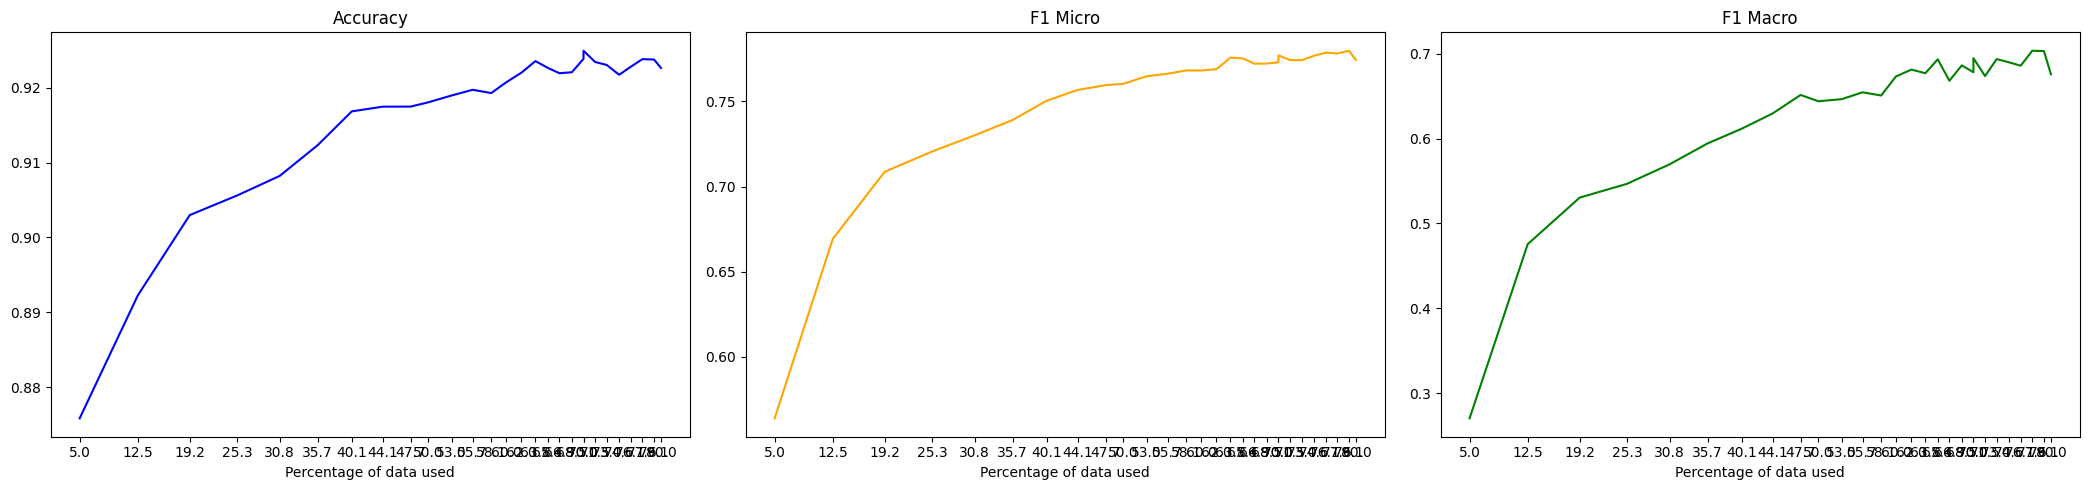

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: [94, 21, 5]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6215, Accuracy: 0.8191, F1 Micro: 0.1615, F1 Macro: 0.0752
Epoch 2/10, Train Loss: 0.4665, Accuracy: 0.8316, F1 Micro: 0.073, F1 Macro: 0.0276
Epoch 3/10, Train Loss: 0.3955, Accuracy: 0.8331, F1 Micro: 0.0914, F1 Macro: 0.0331
Epoch 4/10, Train Loss: 0.3996, Accuracy: 0.8322, F1 Micro: 0.0663, F1 Macro: 0.0261
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3852, Accuracy: 0.8423, F1 Micro: 0.1862, F1 Macro: 0.0687
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3697, Accuracy: 0.8528, F1 Micro: 0.3211, F1 Macro: 0.1051
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3565, Accuracy: 0.8617, F1 Micro: 0.408, F1 Macro: 0.1432
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3315, Accuracy: 0.8738, F1 Micro: 0.5215, F1 Macro: 0.2324
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2962, Accuracy: 0.8754, F1 Micro: 0.5639, F1 Macro: 0.2627
Epoch 10/10, Train Loss: 0.263, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6202, Accuracy: 0.8216, F1 Micro: 0.2374, F1 Macro: 0.0537
Epoch 2/10, Train Loss: 0.4681, Accuracy: 0.8289, F1 Micro: 0.0206, F1 Macro: 0.009
Epoch 3/10, Train Loss: 0.3926, Accuracy: 0.8333, F1 Micro: 0.0952, F1 Macro: 0.0349
Epoch 4/10, Train Loss: 0.4, Accuracy: 0.8342, F1 Micro: 0.1006, F1 Macro: 0.0364
Epoch 5/10, Train Loss: 0.3855, Accuracy: 0.8385, F1 Micro: 0.1788, F1 Macro: 0.0548
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.372, Accuracy: 0.8472, F1 Micro: 0.2544, F1 Macro: 0.0879
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3573, Accuracy: 0.8604, F1 Micro: 0.3983, F1 Macro: 0.1601
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3352, Accuracy: 0.8711, F1 Micro: 0.4901, F1 Macro: 0.2237
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3016, Accuracy: 0.8749, F1 Micro: 0.5685, F1 Macro: 0.264
Epoch 10/10, Train Loss: 0.2699, Accuracy: 0.8753, F1 Micro: 0.533, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5865, Accuracy: 0.8278, F1 Micro: 0.0554, F1 Macro: 0.0267
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4603, Accuracy: 0.8362, F1 Micro: 0.1378, F1 Macro: 0.0461
Epoch 3/10, Train Loss: 0.3944, Accuracy: 0.8367, F1 Micro: 0.1344, F1 Macro: 0.0452
Epoch 4/10, Train Loss: 0.3978, Accuracy: 0.8345, F1 Micro: 0.0947, F1 Macro: 0.0352
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3828, Accuracy: 0.8479, F1 Micro: 0.2674, F1 Macro: 0.091
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3636, Accuracy: 0.8522, F1 Micro: 0.3052, F1 Macro: 0.1024
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3506, Accuracy: 0.8657, F1 Micro: 0.4335, F1 Macro: 0.1769
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3283, Accuracy: 0.8714, F1 Micro: 0.4787, F1 Macro: 0.2164
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2903, Accuracy: 0.8776, F1 Micro: 0.5532, F1 Macro: 0.2618
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5289, Accuracy: 0.8314, F1 Micro: 0.0675, F1 Macro: 0.026
Epoch 2/10, Train Loss: 0.3978, Accuracy: 0.8305, F1 Micro: 0.0373, F1 Macro: 0.016
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3774, Accuracy: 0.855, F1 Micro: 0.3371, F1 Macro: 0.1096
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3388, Accuracy: 0.8742, F1 Micro: 0.5025, F1 Macro: 0.2272
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3023, Accuracy: 0.8808, F1 Micro: 0.5993, F1 Macro: 0.3025
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2625, Accuracy: 0.8874, F1 Micro: 0.6259, F1 Macro: 0.334
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2356, Accuracy: 0.8883, F1 Micro: 0.6516, F1 Macro: 0.377
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2134, Accuracy: 0.8903, F1 Micro: 0.6758, F1 Macro: 0.416
Epoch 9/10, Train Loss: 0.1955, Accuracy: 0.891, F1 Micro: 0.6511, F1 Macro: 0.4228
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5297, Accuracy: 0.8285, F1 Micro: 0.0143, F1 Macro: 0.0063
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3963, Accuracy: 0.8351, F1 Micro: 0.1101, F1 Macro: 0.0396
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3761, Accuracy: 0.8498, F1 Micro: 0.2897, F1 Macro: 0.1015
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3393, Accuracy: 0.8745, F1 Micro: 0.5072, F1 Macro: 0.2361
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3047, Accuracy: 0.8807, F1 Micro: 0.6117, F1 Macro: 0.2904
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.267, Accuracy: 0.8865, F1 Micro: 0.6258, F1 Macro: 0.3251
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2396, Accuracy: 0.8896, F1 Micro: 0.6513, F1 Macro: 0.3666
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2181, Accuracy: 0.8905, F1 Micro: 0.6648, F1 Macro: 0.3979
Epoch 9/10, Train Loss: 0.1981, Accuracy: 0.8901, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5144, Accuracy: 0.8348, F1 Micro: 0.1027, F1 Macro: 0.0381
Epoch 2/10, Train Loss: 0.3965, Accuracy: 0.8353, F1 Micro: 0.1002, F1 Macro: 0.0391
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3735, Accuracy: 0.8552, F1 Micro: 0.3463, F1 Macro: 0.1169
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.336, Accuracy: 0.8751, F1 Micro: 0.5022, F1 Macro: 0.2314
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3, Accuracy: 0.8822, F1 Micro: 0.5761, F1 Macro: 0.2885
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2618, Accuracy: 0.8855, F1 Micro: 0.6529, F1 Macro: 0.3711
Epoch 7/10, Train Loss: 0.2367, Accuracy: 0.8884, F1 Micro: 0.6179, F1 Macro: 0.3651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.214, Accuracy: 0.8907, F1 Micro: 0.6664, F1 Macro: 0.4058
Epoch 9/10, Train Loss: 0.1943, Accuracy: 0.8912, F1 Micro: 0.6399, F1 Macro: 0.4068
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4927, Accuracy: 0.8332, F1 Micro: 0.0872, F1 Macro: 0.0325
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3814, Accuracy: 0.858, F1 Micro: 0.3884, F1 Macro: 0.1214
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3287, Accuracy: 0.8788, F1 Micro: 0.6072, F1 Macro: 0.2941
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2894, Accuracy: 0.8881, F1 Micro: 0.6141, F1 Macro: 0.318
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2402, Accuracy: 0.8934, F1 Micro: 0.6643, F1 Macro: 0.4082
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2146, Accuracy: 0.8939, F1 Micro: 0.6889, F1 Macro: 0.459
Epoch 7/10, Train Loss: 0.1944, Accuracy: 0.896, F1 Micro: 0.6576, F1 Macro: 0.4563
Epoch 8/10, Train Loss: 0.1664, Accuracy: 0.8995, F1 Micro: 0.6738, F1 Macro: 0.4716
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1452, Accuracy: 0.9009, F1 Micro: 0.6981, F1 Macro: 0.4854
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4917, Accuracy: 0.834, F1 Micro: 0.0993, F1 Macro: 0.0387
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3814, Accuracy: 0.8571, F1 Micro: 0.4042, F1 Macro: 0.1391
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.334, Accuracy: 0.8791, F1 Micro: 0.5994, F1 Macro: 0.2797
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2968, Accuracy: 0.8873, F1 Micro: 0.6274, F1 Macro: 0.3341
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2457, Accuracy: 0.8918, F1 Micro: 0.6629, F1 Macro: 0.3958
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2185, Accuracy: 0.8943, F1 Micro: 0.6833, F1 Macro: 0.4321
Epoch 7/10, Train Loss: 0.1958, Accuracy: 0.8962, F1 Micro: 0.6462, F1 Macro: 0.4192
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1672, Accuracy: 0.9013, F1 Micro: 0.6965, F1 Macro: 0.4871
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1491, Accuracy: 0.8974, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4837, Accuracy: 0.8356, F1 Micro: 0.1116, F1 Macro: 0.0399
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3803, Accuracy: 0.853, F1 Micro: 0.3107, F1 Macro: 0.1048
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3275, Accuracy: 0.8819, F1 Micro: 0.5914, F1 Macro: 0.2949
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2862, Accuracy: 0.8866, F1 Micro: 0.5986, F1 Macro: 0.3286
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.239, Accuracy: 0.8939, F1 Micro: 0.6674, F1 Macro: 0.413
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2121, Accuracy: 0.8941, F1 Micro: 0.6787, F1 Macro: 0.423
Epoch 7/10, Train Loss: 0.1925, Accuracy: 0.8961, F1 Micro: 0.6408, F1 Macro: 0.423
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1669, Accuracy: 0.8987, F1 Micro: 0.6819, F1 Macro: 0.473
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1504, Accuracy: 0.8996, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4616, Accuracy: 0.8344, F1 Micro: 0.0878, F1 Macro: 0.0355
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3589, Accuracy: 0.8755, F1 Micro: 0.5262, F1 Macro: 0.235
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2997, Accuracy: 0.8889, F1 Micro: 0.625, F1 Macro: 0.316
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2541, Accuracy: 0.8959, F1 Micro: 0.6723, F1 Macro: 0.4001
Epoch 5/10, Train Loss: 0.2245, Accuracy: 0.8987, F1 Micro: 0.6665, F1 Macro: 0.4205
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1879, Accuracy: 0.9039, F1 Micro: 0.7063, F1 Macro: 0.5166
Epoch 7/10, Train Loss: 0.164, Accuracy: 0.9031, F1 Micro: 0.6836, F1 Macro: 0.4909
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1455, Accuracy: 0.9079, F1 Micro: 0.7197, F1 Macro: 0.5451
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.117, Accuracy: 0.9043, F1 Micro: 0.7235, F1 Macro: 0.5528
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4629, Accuracy: 0.8322, F1 Micro: 0.0688, F1 Macro: 0.0271
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3632, Accuracy: 0.874, F1 Micro: 0.5218, F1 Macro: 0.2371
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.305, Accuracy: 0.8863, F1 Micro: 0.5902, F1 Macro: 0.2836
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2623, Accuracy: 0.8931, F1 Micro: 0.6765, F1 Macro: 0.4224
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2296, Accuracy: 0.9005, F1 Micro: 0.684, F1 Macro: 0.4428
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1937, Accuracy: 0.9029, F1 Micro: 0.6956, F1 Macro: 0.4765
Epoch 7/10, Train Loss: 0.1665, Accuracy: 0.9052, F1 Micro: 0.6939, F1 Macro: 0.493
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1485, Accuracy: 0.9054, F1 Micro: 0.7199, F1 Macro: 0.5308
Epoch 9/10, Train Loss: 0.1249, Accuracy: 0.9078, F1 Micro: 0.7182, F1 Macro: 0.534
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4559, Accuracy: 0.8388, F1 Micro: 0.1453, F1 Macro: 0.0553
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3569, Accuracy: 0.8744, F1 Micro: 0.4965, F1 Macro: 0.2197
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2974, Accuracy: 0.889, F1 Micro: 0.6168, F1 Macro: 0.3307
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2536, Accuracy: 0.8946, F1 Micro: 0.6828, F1 Macro: 0.4164
Epoch 5/10, Train Loss: 0.2223, Accuracy: 0.8993, F1 Micro: 0.674, F1 Macro: 0.4317
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.187, Accuracy: 0.904, F1 Micro: 0.7097, F1 Macro: 0.5054
Epoch 7/10, Train Loss: 0.1632, Accuracy: 0.8989, F1 Micro: 0.6731, F1 Macro: 0.4804
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1516, Accuracy: 0.9064, F1 Micro: 0.7219, F1 Macro: 0.5317
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1205, Accuracy: 0.9084, F1 Micro: 0.7276, F1 Macro: 0.5315
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4541, Accuracy: 0.8362, F1 Micro: 0.1176, F1 Macro: 0.0434
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3478, Accuracy: 0.8774, F1 Micro: 0.6213, F1 Macro: 0.3046
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2866, Accuracy: 0.8942, F1 Micro: 0.6548, F1 Macro: 0.3493
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.242, Accuracy: 0.8978, F1 Micro: 0.705, F1 Macro: 0.4812
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2104, Accuracy: 0.9054, F1 Micro: 0.7119, F1 Macro: 0.5198
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1824, Accuracy: 0.9095, F1 Micro: 0.7215, F1 Macro: 0.5392
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1554, Accuracy: 0.9068, F1 Micro: 0.7337, F1 Macro: 0.5634
Epoch 8/10, Train Loss: 0.1389, Accuracy: 0.9102, F1 Micro: 0.7333, F1 Macro: 0.5696
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1157, Accuracy: 0.9134, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4527, Accuracy: 0.8379, F1 Micro: 0.169, F1 Macro: 0.0534
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3483, Accuracy: 0.8757, F1 Micro: 0.6257, F1 Macro: 0.2988
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.29, Accuracy: 0.8933, F1 Micro: 0.6622, F1 Macro: 0.3719
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2447, Accuracy: 0.8955, F1 Micro: 0.7008, F1 Macro: 0.4685
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2126, Accuracy: 0.9048, F1 Micro: 0.7026, F1 Macro: 0.4982
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1838, Accuracy: 0.9075, F1 Micro: 0.7209, F1 Macro: 0.5267
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1567, Accuracy: 0.9062, F1 Micro: 0.7298, F1 Macro: 0.5443
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1413, Accuracy: 0.9112, F1 Micro: 0.7313, F1 Macro: 0.5675
Epoch 9/10, Train Loss: 0.1171, Accuracy: 0.913, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4494, Accuracy: 0.8439, F1 Micro: 0.2173, F1 Macro: 0.0757
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3464, Accuracy: 0.8804, F1 Micro: 0.6169, F1 Macro: 0.2991
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2862, Accuracy: 0.8939, F1 Micro: 0.6655, F1 Macro: 0.3942
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2419, Accuracy: 0.8989, F1 Micro: 0.6978, F1 Macro: 0.4542
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2114, Accuracy: 0.9041, F1 Micro: 0.7075, F1 Macro: 0.4949
Epoch 6/10, Train Loss: 0.1836, Accuracy: 0.906, F1 Micro: 0.7073, F1 Macro: 0.496
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1592, Accuracy: 0.9065, F1 Micro: 0.7267, F1 Macro: 0.5412
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1407, Accuracy: 0.9101, F1 Micro: 0.7314, F1 Macro: 0.5535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.116, Accuracy: 0.9108, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4417, Accuracy: 0.8553, F1 Micro: 0.3898, F1 Macro: 0.1178
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3247, Accuracy: 0.8849, F1 Micro: 0.6063, F1 Macro: 0.3132
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2719, Accuracy: 0.8972, F1 Micro: 0.6706, F1 Macro: 0.4165
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2297, Accuracy: 0.9021, F1 Micro: 0.6779, F1 Macro: 0.4627
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2018, Accuracy: 0.9073, F1 Micro: 0.7169, F1 Macro: 0.5488
Epoch 6/10, Train Loss: 0.1739, Accuracy: 0.911, F1 Micro: 0.7156, F1 Macro: 0.5593
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1428, Accuracy: 0.9105, F1 Micro: 0.7351, F1 Macro: 0.5803
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1196, Accuracy: 0.91, F1 Micro: 0.738, F1 Macro: 0.5859
Epoch 9/10, Train Loss: 0.1057, Accuracy: 0.912, F1 Micro: 0.7375, F1 Macro: 0.5952
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4421, Accuracy: 0.8552, F1 Micro: 0.3702, F1 Macro: 0.1193
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3294, Accuracy: 0.8831, F1 Micro: 0.5773, F1 Macro: 0.2758
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2746, Accuracy: 0.898, F1 Micro: 0.6727, F1 Macro: 0.4092
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2324, Accuracy: 0.9036, F1 Micro: 0.6869, F1 Macro: 0.4585
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2035, Accuracy: 0.9059, F1 Micro: 0.7043, F1 Macro: 0.543
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1746, Accuracy: 0.9099, F1 Micro: 0.7101, F1 Macro: 0.5446
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1455, Accuracy: 0.9103, F1 Micro: 0.7356, F1 Macro: 0.5737
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1214, Accuracy: 0.9114, F1 Micro: 0.7367, F1 Macro: 0.5752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4368, Accuracy: 0.8524, F1 Micro: 0.3238, F1 Macro: 0.1058
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.325, Accuracy: 0.8859, F1 Micro: 0.6074, F1 Macro: 0.315
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2705, Accuracy: 0.8965, F1 Micro: 0.6806, F1 Macro: 0.4159
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2308, Accuracy: 0.9029, F1 Micro: 0.6968, F1 Macro: 0.4768
Epoch 5/10, Train Loss: 0.2019, Accuracy: 0.904, F1 Micro: 0.6814, F1 Macro: 0.4999
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1779, Accuracy: 0.9078, F1 Micro: 0.7103, F1 Macro: 0.5414
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1477, Accuracy: 0.9115, F1 Micro: 0.7257, F1 Macro: 0.5569
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1219, Accuracy: 0.9103, F1 Micro: 0.7355, F1 Macro: 0.5718
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1087, Accuracy: 0.9112, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4365, Accuracy: 0.8599, F1 Micro: 0.419, F1 Macro: 0.1408
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3124, Accuracy: 0.8912, F1 Micro: 0.6267, F1 Macro: 0.3278
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2523, Accuracy: 0.9022, F1 Micro: 0.694, F1 Macro: 0.5072
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2204, Accuracy: 0.9082, F1 Micro: 0.7221, F1 Macro: 0.5261
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1809, Accuracy: 0.9103, F1 Micro: 0.7309, F1 Macro: 0.5676
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1576, Accuracy: 0.9134, F1 Micro: 0.7374, F1 Macro: 0.5631
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1337, Accuracy: 0.9142, F1 Micro: 0.7387, F1 Macro: 0.5902
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1155, Accuracy: 0.9119, F1 Micro: 0.743, F1 Macro: 0.5934
Epoch 9/10, Train Loss: 0.1053, Accuracy: 0.9143, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4367, Accuracy: 0.862, F1 Micro: 0.4438, F1 Macro: 0.1749
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3199, Accuracy: 0.8904, F1 Micro: 0.638, F1 Macro: 0.3354
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2555, Accuracy: 0.8997, F1 Micro: 0.6813, F1 Macro: 0.4889
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2222, Accuracy: 0.9061, F1 Micro: 0.7196, F1 Macro: 0.5135
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1841, Accuracy: 0.9099, F1 Micro: 0.7323, F1 Macro: 0.5629
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1614, Accuracy: 0.9123, F1 Micro: 0.7401, F1 Macro: 0.5624
Epoch 7/10, Train Loss: 0.1344, Accuracy: 0.9128, F1 Micro: 0.7142, F1 Macro: 0.5656
Epoch 8/10, Train Loss: 0.1208, Accuracy: 0.9142, F1 Micro: 0.7341, F1 Macro: 0.5852
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1035, Accuracy: 0.915, F1 Micro: 0.7473, F1 Macro: 0.6078
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4315, Accuracy: 0.8607, F1 Micro: 0.4148, F1 Macro: 0.1521
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3132, Accuracy: 0.8906, F1 Micro: 0.6297, F1 Macro: 0.3444
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2541, Accuracy: 0.8995, F1 Micro: 0.6825, F1 Macro: 0.4817
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.22, Accuracy: 0.9048, F1 Micro: 0.7182, F1 Macro: 0.5071
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1839, Accuracy: 0.9072, F1 Micro: 0.7359, F1 Macro: 0.5606
Epoch 6/10, Train Loss: 0.1615, Accuracy: 0.9124, F1 Micro: 0.7292, F1 Macro: 0.5501
Epoch 7/10, Train Loss: 0.1364, Accuracy: 0.9111, F1 Micro: 0.7097, F1 Macro: 0.5567
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.118, Accuracy: 0.912, F1 Micro: 0.7431, F1 Macro: 0.5925
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1046, Accuracy: 0.9177, F1 Micro: 0.7478, F1 Macro: 0.6158
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4284, Accuracy: 0.8628, F1 Micro: 0.4034, F1 Macro: 0.1458
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3062, Accuracy: 0.8895, F1 Micro: 0.6111, F1 Macro: 0.3295
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2532, Accuracy: 0.9002, F1 Micro: 0.7126, F1 Macro: 0.5206
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2107, Accuracy: 0.9095, F1 Micro: 0.7259, F1 Macro: 0.5552
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1798, Accuracy: 0.912, F1 Micro: 0.7379, F1 Macro: 0.5507
Epoch 6/10, Train Loss: 0.153, Accuracy: 0.9157, F1 Micro: 0.7309, F1 Macro: 0.5676
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1286, Accuracy: 0.9163, F1 Micro: 0.7485, F1 Macro: 0.5988
Epoch 8/10, Train Loss: 0.1115, Accuracy: 0.9148, F1 Micro: 0.7445, F1 Macro: 0.6083
Epoch 9/10, Train Loss: 0.0959, Accuracy: 0.9143, F1 Micro: 0.7453, F1 Macro: 0.6323
Epoch 10/10, Train Loss: 0.0808, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4295, Accuracy: 0.8563, F1 Micro: 0.3785, F1 Macro: 0.1309
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3101, Accuracy: 0.8898, F1 Micro: 0.6137, F1 Macro: 0.3384
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2565, Accuracy: 0.9037, F1 Micro: 0.7047, F1 Macro: 0.4795
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2148, Accuracy: 0.909, F1 Micro: 0.7232, F1 Macro: 0.5461
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1815, Accuracy: 0.9122, F1 Micro: 0.743, F1 Macro: 0.5549
Epoch 6/10, Train Loss: 0.1572, Accuracy: 0.9169, F1 Micro: 0.7386, F1 Macro: 0.5769
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1315, Accuracy: 0.9153, F1 Micro: 0.7439, F1 Macro: 0.5878
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1076, Accuracy: 0.9168, F1 Micro: 0.7498, F1 Macro: 0.6094
Epoch 9/10, Train Loss: 0.0958, Accuracy: 0.9092, F1 Micro: 0.7442, F1 Macro: 0.6091
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4249, Accuracy: 0.8652, F1 Micro: 0.4317, F1 Macro: 0.162
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3061, Accuracy: 0.8889, F1 Micro: 0.6102, F1 Macro: 0.3526
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2527, Accuracy: 0.9031, F1 Micro: 0.7074, F1 Macro: 0.4869
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2132, Accuracy: 0.9085, F1 Micro: 0.7208, F1 Macro: 0.5321
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1798, Accuracy: 0.9125, F1 Micro: 0.7287, F1 Macro: 0.5188
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1543, Accuracy: 0.9146, F1 Micro: 0.7297, F1 Macro: 0.5667
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1318, Accuracy: 0.916, F1 Micro: 0.7564, F1 Macro: 0.6008
Epoch 8/10, Train Loss: 0.1072, Accuracy: 0.9161, F1 Micro: 0.7547, F1 Macro: 0.6145
Epoch 9/10, Train Loss: 0.0935, Accuracy: 0.9109, F1 Micro: 0.7495, F1 Macro: 0.6271
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4237, Accuracy: 0.8733, F1 Micro: 0.5478, F1 Macro: 0.2387
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2981, Accuracy: 0.8936, F1 Micro: 0.6847, F1 Macro: 0.4081
Epoch 3/10, Train Loss: 0.253, Accuracy: 0.9034, F1 Micro: 0.6783, F1 Macro: 0.4286
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2105, Accuracy: 0.9133, F1 Micro: 0.7336, F1 Macro: 0.5711
Epoch 5/10, Train Loss: 0.1759, Accuracy: 0.914, F1 Micro: 0.7263, F1 Macro: 0.5638
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1488, Accuracy: 0.9168, F1 Micro: 0.7503, F1 Macro: 0.5922
Epoch 7/10, Train Loss: 0.1241, Accuracy: 0.9151, F1 Micro: 0.7457, F1 Macro: 0.6077
Epoch 8/10, Train Loss: 0.1045, Accuracy: 0.9119, F1 Micro: 0.742, F1 Macro: 0.6079
Epoch 9/10, Train Loss: 0.0959, Accuracy: 0.9173, F1 Micro: 0.7463, F1 Macro: 0.6169
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.08, Accuracy: 0.9154, F1 Micro: 0.752, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.424, Accuracy: 0.8727, F1 Micro: 0.5224, F1 Macro: 0.2339
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3025, Accuracy: 0.8938, F1 Micro: 0.6815, F1 Macro: 0.4197
Epoch 3/10, Train Loss: 0.2549, Accuracy: 0.9017, F1 Micro: 0.6655, F1 Macro: 0.4174
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2112, Accuracy: 0.9111, F1 Micro: 0.7223, F1 Macro: 0.5525
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1745, Accuracy: 0.9139, F1 Micro: 0.7235, F1 Macro: 0.5489
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1506, Accuracy: 0.9156, F1 Micro: 0.7409, F1 Macro: 0.5631
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1247, Accuracy: 0.9195, F1 Micro: 0.752, F1 Macro: 0.6013
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.107, Accuracy: 0.916, F1 Micro: 0.7537, F1 Macro: 0.6137
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0947, Accuracy: 0.9175, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4193, Accuracy: 0.8743, F1 Micro: 0.5116, F1 Macro: 0.2295
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2999, Accuracy: 0.8948, F1 Micro: 0.6788, F1 Macro: 0.3925
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2526, Accuracy: 0.9041, F1 Micro: 0.6849, F1 Macro: 0.461
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2101, Accuracy: 0.911, F1 Micro: 0.7288, F1 Macro: 0.5714
Epoch 5/10, Train Loss: 0.1761, Accuracy: 0.9142, F1 Micro: 0.7282, F1 Macro: 0.5408
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1513, Accuracy: 0.9127, F1 Micro: 0.7521, F1 Macro: 0.5832
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1259, Accuracy: 0.9171, F1 Micro: 0.7545, F1 Macro: 0.6159
Epoch 8/10, Train Loss: 0.1084, Accuracy: 0.9125, F1 Micro: 0.7466, F1 Macro: 0.6095
Epoch 9/10, Train Loss: 0.0933, Accuracy: 0.9161, F1 Micro: 0.7487, F1 Macro: 0.6039
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4177, Accuracy: 0.8734, F1 Micro: 0.5001, F1 Macro: 0.2191
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.295, Accuracy: 0.8946, F1 Micro: 0.6367, F1 Macro: 0.4173
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2442, Accuracy: 0.9056, F1 Micro: 0.7187, F1 Macro: 0.5126
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2056, Accuracy: 0.9122, F1 Micro: 0.7393, F1 Macro: 0.5647
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1771, Accuracy: 0.9156, F1 Micro: 0.7508, F1 Macro: 0.5888
Epoch 6/10, Train Loss: 0.1443, Accuracy: 0.9133, F1 Micro: 0.748, F1 Macro: 0.5919
Epoch 7/10, Train Loss: 0.1287, Accuracy: 0.9112, F1 Micro: 0.7451, F1 Macro: 0.6008
Epoch 8/10, Train Loss: 0.1061, Accuracy: 0.9169, F1 Micro: 0.7485, F1 Macro: 0.6057
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0895, Accuracy: 0.9189, F1 Micro: 0.7569, F1 Macro: 0.6563
Epoch 10/10, Train Loss: 0.0843, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4192, Accuracy: 0.8737, F1 Micro: 0.5238, F1 Macro: 0.23
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2987, Accuracy: 0.8982, F1 Micro: 0.6715, F1 Macro: 0.4383
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2497, Accuracy: 0.9053, F1 Micro: 0.7137, F1 Macro: 0.5152
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2083, Accuracy: 0.9096, F1 Micro: 0.7358, F1 Macro: 0.5692
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1818, Accuracy: 0.9153, F1 Micro: 0.7404, F1 Macro: 0.579
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1469, Accuracy: 0.9159, F1 Micro: 0.7545, F1 Macro: 0.592
Epoch 7/10, Train Loss: 0.1304, Accuracy: 0.917, F1 Micro: 0.7507, F1 Macro: 0.5996
Epoch 8/10, Train Loss: 0.1103, Accuracy: 0.9153, F1 Micro: 0.7531, F1 Macro: 0.6188
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0915, Accuracy: 0.9167, F1 Micro: 0.7557, F1 Macro: 0.6372
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4148, Accuracy: 0.8747, F1 Micro: 0.5099, F1 Macro: 0.2221
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2961, Accuracy: 0.8936, F1 Micro: 0.6424, F1 Macro: 0.402
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2468, Accuracy: 0.9051, F1 Micro: 0.7143, F1 Macro: 0.4989
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2079, Accuracy: 0.9118, F1 Micro: 0.7416, F1 Macro: 0.5764
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1798, Accuracy: 0.9153, F1 Micro: 0.7457, F1 Macro: 0.5723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1487, Accuracy: 0.9111, F1 Micro: 0.7523, F1 Macro: 0.593
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1292, Accuracy: 0.9165, F1 Micro: 0.7562, F1 Macro: 0.6082
Epoch 8/10, Train Loss: 0.1068, Accuracy: 0.9182, F1 Micro: 0.7537, F1 Macro: 0.6138
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0905, Accuracy: 0.9178, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.41, Accuracy: 0.877, F1 Micro: 0.5851, F1 Macro: 0.2812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.294, Accuracy: 0.8978, F1 Micro: 0.6872, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2409, Accuracy: 0.9045, F1 Micro: 0.6956, F1 Macro: 0.5358
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2033, Accuracy: 0.9126, F1 Micro: 0.7177, F1 Macro: 0.5537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1755, Accuracy: 0.915, F1 Micro: 0.7483, F1 Macro: 0.5968
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1474, Accuracy: 0.9171, F1 Micro: 0.7563, F1 Macro: 0.6021
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1242, Accuracy: 0.9178, F1 Micro: 0.7573, F1 Macro: 0.6201
Epoch 8/10, Train Loss: 0.1044, Accuracy: 0.9195, F1 Micro: 0.7515, F1 Macro: 0.6221
Epoch 9/10, Train Loss: 0.09, Accuracy: 0.9152, F1 Micro: 0.7472, F1 Macro: 0.6412
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4114, Accuracy: 0.878, F1 Micro: 0.571, F1 Macro: 0.2633
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2964, Accuracy: 0.8969, F1 Micro: 0.6907, F1 Macro: 0.4671
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2431, Accuracy: 0.9058, F1 Micro: 0.6946, F1 Macro: 0.5283
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2055, Accuracy: 0.9127, F1 Micro: 0.7276, F1 Macro: 0.5488
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1727, Accuracy: 0.9156, F1 Micro: 0.7465, F1 Macro: 0.5846
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1452, Accuracy: 0.9176, F1 Micro: 0.7608, F1 Macro: 0.6023
Epoch 7/10, Train Loss: 0.1224, Accuracy: 0.9185, F1 Micro: 0.753, F1 Macro: 0.6053
Epoch 8/10, Train Loss: 0.1033, Accuracy: 0.9179, F1 Micro: 0.7599, F1 Macro: 0.6335
Epoch 9/10, Train Loss: 0.0918, Accuracy: 0.9171, F1 Micro: 0.7523, F1 Macro: 0.6333
Epoch 10/10, Train Loss: 0.0798, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.407, Accuracy: 0.8798, F1 Micro: 0.5844, F1 Macro: 0.2689
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2936, Accuracy: 0.897, F1 Micro: 0.6887, F1 Macro: 0.4376
Epoch 3/10, Train Loss: 0.2413, Accuracy: 0.9046, F1 Micro: 0.6808, F1 Macro: 0.5157
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2065, Accuracy: 0.9144, F1 Micro: 0.7283, F1 Macro: 0.5593
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1728, Accuracy: 0.9156, F1 Micro: 0.7513, F1 Macro: 0.5806
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1482, Accuracy: 0.9167, F1 Micro: 0.7549, F1 Macro: 0.5968
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1226, Accuracy: 0.9203, F1 Micro: 0.7581, F1 Macro: 0.608
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1051, Accuracy: 0.919, F1 Micro: 0.7597, F1 Macro: 0.6395
Epoch 9/10, Train Loss: 0.0893, Accuracy: 0.9137, F1 Micro: 0.7397, F1 Macro: 0.6288
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4134, Accuracy: 0.8775, F1 Micro: 0.5983, F1 Macro: 0.282
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2884, Accuracy: 0.8984, F1 Micro: 0.6912, F1 Macro: 0.464
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2361, Accuracy: 0.9084, F1 Micro: 0.7065, F1 Macro: 0.4854
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.202, Accuracy: 0.9148, F1 Micro: 0.7337, F1 Macro: 0.5663
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1654, Accuracy: 0.9168, F1 Micro: 0.7508, F1 Macro: 0.5981
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.141, Accuracy: 0.9155, F1 Micro: 0.7562, F1 Macro: 0.6138
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1149, Accuracy: 0.9199, F1 Micro: 0.7588, F1 Macro: 0.6161
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0999, Accuracy: 0.9181, F1 Micro: 0.7598, F1 Macro: 0.6365
Epoch 9/10, Train Loss: 0.0863, Accuracy: 0.9166, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4146, Accuracy: 0.8788, F1 Micro: 0.593, F1 Macro: 0.2759
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2902, Accuracy: 0.8983, F1 Micro: 0.6924, F1 Macro: 0.4568
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2372, Accuracy: 0.9066, F1 Micro: 0.7032, F1 Macro: 0.4658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2008, Accuracy: 0.9137, F1 Micro: 0.7214, F1 Macro: 0.5417
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1658, Accuracy: 0.9151, F1 Micro: 0.7507, F1 Macro: 0.5937
Epoch 6/10, Train Loss: 0.1401, Accuracy: 0.9156, F1 Micro: 0.7499, F1 Macro: 0.6025
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1186, Accuracy: 0.9192, F1 Micro: 0.7591, F1 Macro: 0.6077
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1038, Accuracy: 0.9202, F1 Micro: 0.7641, F1 Macro: 0.6411
Epoch 9/10, Train Loss: 0.0866, Accuracy: 0.9202, F1 Micro: 0.762, F1 Macro: 0.6452
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4101, Accuracy: 0.8801, F1 Micro: 0.5912, F1 Macro: 0.2717
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2884, Accuracy: 0.8981, F1 Micro: 0.6781, F1 Macro: 0.4205
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2363, Accuracy: 0.9067, F1 Micro: 0.7038, F1 Macro: 0.4701
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2003, Accuracy: 0.9145, F1 Micro: 0.7264, F1 Macro: 0.5432
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1663, Accuracy: 0.9159, F1 Micro: 0.7424, F1 Macro: 0.5853
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1422, Accuracy: 0.9142, F1 Micro: 0.7505, F1 Macro: 0.6059
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1182, Accuracy: 0.9202, F1 Micro: 0.7601, F1 Macro: 0.6061
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1005, Accuracy: 0.919, F1 Micro: 0.7608, F1 Macro: 0.6498
Epoch 9/10, Train Loss: 0.0848, Accuracy: 0.9189, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4067, Accuracy: 0.8797, F1 Micro: 0.5887, F1 Macro: 0.2837
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.282, Accuracy: 0.8989, F1 Micro: 0.6967, F1 Macro: 0.4833
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2319, Accuracy: 0.909, F1 Micro: 0.7194, F1 Macro: 0.5238
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1892, Accuracy: 0.9129, F1 Micro: 0.7463, F1 Macro: 0.5963
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1678, Accuracy: 0.9167, F1 Micro: 0.7514, F1 Macro: 0.5986
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1395, Accuracy: 0.9193, F1 Micro: 0.7549, F1 Macro: 0.6199
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1169, Accuracy: 0.9156, F1 Micro: 0.7552, F1 Macro: 0.624
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1008, Accuracy: 0.92, F1 Micro: 0.7646, F1 Macro: 0.6238
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.08

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4092, Accuracy: 0.8762, F1 Micro: 0.518, F1 Macro: 0.239
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2865, Accuracy: 0.8986, F1 Micro: 0.6972, F1 Macro: 0.4772
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2355, Accuracy: 0.9077, F1 Micro: 0.7075, F1 Macro: 0.4962
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1935, Accuracy: 0.9125, F1 Micro: 0.7441, F1 Macro: 0.5854
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1717, Accuracy: 0.9168, F1 Micro: 0.7521, F1 Macro: 0.5937
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1438, Accuracy: 0.9165, F1 Micro: 0.757, F1 Macro: 0.6112
Epoch 7/10, Train Loss: 0.1174, Accuracy: 0.916, F1 Micro: 0.7557, F1 Macro: 0.6292
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1007, Accuracy: 0.9195, F1 Micro: 0.7614, F1 Macro: 0.6419
Epoch 9/10, Train Loss: 0.0883, Accuracy: 0.9157, F1 Micro: 0.7603, F1 Macro: 0.6509
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4042, Accuracy: 0.8788, F1 Micro: 0.5468, F1 Macro: 0.2514
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2847, Accuracy: 0.8987, F1 Micro: 0.6958, F1 Macro: 0.4866
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2345, Accuracy: 0.9071, F1 Micro: 0.7003, F1 Macro: 0.489
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1917, Accuracy: 0.9133, F1 Micro: 0.7441, F1 Macro: 0.5764
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1666, Accuracy: 0.9154, F1 Micro: 0.7518, F1 Macro: 0.5981
Epoch 6/10, Train Loss: 0.14, Accuracy: 0.9162, F1 Micro: 0.7502, F1 Macro: 0.6039
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1158, Accuracy: 0.9174, F1 Micro: 0.7579, F1 Macro: 0.6413
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.099, Accuracy: 0.92, F1 Micro: 0.7646, F1 Macro: 0.6454
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0831, Accuracy: 0.9182, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4048, Accuracy: 0.8807, F1 Micro: 0.5986, F1 Macro: 0.2944
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.28, Accuracy: 0.9004, F1 Micro: 0.6787, F1 Macro: 0.4133
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2329, Accuracy: 0.9107, F1 Micro: 0.728, F1 Macro: 0.5462
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1966, Accuracy: 0.9153, F1 Micro: 0.7495, F1 Macro: 0.586
Epoch 5/10, Train Loss: 0.164, Accuracy: 0.9184, F1 Micro: 0.7427, F1 Macro: 0.5845
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1427, Accuracy: 0.9176, F1 Micro: 0.7577, F1 Macro: 0.6053
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1153, Accuracy: 0.9203, F1 Micro: 0.7635, F1 Macro: 0.6289
Epoch 8/10, Train Loss: 0.0991, Accuracy: 0.9185, F1 Micro: 0.7597, F1 Macro: 0.6421
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0837, Accuracy: 0.9191, F1 Micro: 0.7662, F1 Macro: 0.6699
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4042, Accuracy: 0.8812, F1 Micro: 0.5986, F1 Macro: 0.2831
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2819, Accuracy: 0.9013, F1 Micro: 0.6816, F1 Macro: 0.4358
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2357, Accuracy: 0.9105, F1 Micro: 0.7211, F1 Macro: 0.5257
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1976, Accuracy: 0.9146, F1 Micro: 0.7477, F1 Macro: 0.5778
Epoch 5/10, Train Loss: 0.1639, Accuracy: 0.917, F1 Micro: 0.7459, F1 Macro: 0.5891
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1443, Accuracy: 0.9213, F1 Micro: 0.7624, F1 Macro: 0.6127
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1183, Accuracy: 0.9226, F1 Micro: 0.766, F1 Macro: 0.6391
Epoch 8/10, Train Loss: 0.1001, Accuracy: 0.92, F1 Micro: 0.7547, F1 Macro: 0.6335
Epoch 9/10, Train Loss: 0.0895, Accuracy: 0.9158, F1 Micro: 0.7627, F1 Macro: 0.6655
Epoch 10/10, Train Loss: 0.0742, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4023, Accuracy: 0.8819, F1 Micro: 0.5793, F1 Macro: 0.279
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2806, Accuracy: 0.9014, F1 Micro: 0.679, F1 Macro: 0.437
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2328, Accuracy: 0.9088, F1 Micro: 0.7166, F1 Macro: 0.527
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1951, Accuracy: 0.9148, F1 Micro: 0.7431, F1 Macro: 0.5606
Epoch 5/10, Train Loss: 0.1619, Accuracy: 0.9164, F1 Micro: 0.7372, F1 Macro: 0.5751
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1399, Accuracy: 0.9188, F1 Micro: 0.7469, F1 Macro: 0.6025
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1147, Accuracy: 0.9218, F1 Micro: 0.7681, F1 Macro: 0.634
Epoch 8/10, Train Loss: 0.0984, Accuracy: 0.9198, F1 Micro: 0.7617, F1 Macro: 0.6484
Epoch 9/10, Train Loss: 0.0857, Accuracy: 0.9152, F1 Micro: 0.761, F1 Macro: 0.6665
Epoch 10/10, Train Loss: 0.0738, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4025, Accuracy: 0.8813, F1 Micro: 0.6061, F1 Macro: 0.3081
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2753, Accuracy: 0.9023, F1 Micro: 0.698, F1 Macro: 0.498
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2281, Accuracy: 0.9113, F1 Micro: 0.7329, F1 Macro: 0.5486
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1956, Accuracy: 0.9159, F1 Micro: 0.7408, F1 Macro: 0.5788
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1611, Accuracy: 0.92, F1 Micro: 0.7561, F1 Macro: 0.5987
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1355, Accuracy: 0.9191, F1 Micro: 0.7656, F1 Macro: 0.6209
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1104, Accuracy: 0.9208, F1 Micro: 0.7672, F1 Macro: 0.6508
Epoch 8/10, Train Loss: 0.0975, Accuracy: 0.9219, F1 Micro: 0.7663, F1 Macro: 0.6538
Epoch 9/10, Train Loss: 0.086, Accuracy: 0.9215, F1 Micro: 0.7663, F1 Macro: 0.661
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.403, Accuracy: 0.8811, F1 Micro: 0.607, F1 Macro: 0.2936
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2774, Accuracy: 0.9028, F1 Micro: 0.6923, F1 Macro: 0.479
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2282, Accuracy: 0.9107, F1 Micro: 0.7224, F1 Macro: 0.5208
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.197, Accuracy: 0.9152, F1 Micro: 0.7499, F1 Macro: 0.5898
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1625, Accuracy: 0.9206, F1 Micro: 0.7574, F1 Macro: 0.6019
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1336, Accuracy: 0.92, F1 Micro: 0.7651, F1 Macro: 0.6086
Epoch 7/10, Train Loss: 0.1139, Accuracy: 0.921, F1 Micro: 0.7591, F1 Macro: 0.639
Epoch 8/10, Train Loss: 0.0966, Accuracy: 0.9167, F1 Micro: 0.7582, F1 Macro: 0.6443
Epoch 9/10, Train Loss: 0.0854, Accuracy: 0.9196, F1 Micro: 0.7629, F1 Macro: 0.6495
Epoch 10/10, Train Loss: 0.0722, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3992, Accuracy: 0.8817, F1 Micro: 0.6216, F1 Macro: 0.3228
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2764, Accuracy: 0.9023, F1 Micro: 0.6961, F1 Macro: 0.4921
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2281, Accuracy: 0.9104, F1 Micro: 0.7326, F1 Macro: 0.5424
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.196, Accuracy: 0.9162, F1 Micro: 0.7497, F1 Macro: 0.5868
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1613, Accuracy: 0.9206, F1 Micro: 0.7509, F1 Macro: 0.585
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1346, Accuracy: 0.9157, F1 Micro: 0.763, F1 Macro: 0.6217
Epoch 7/10, Train Loss: 0.1105, Accuracy: 0.9206, F1 Micro: 0.7603, F1 Macro: 0.6332
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0954, Accuracy: 0.9193, F1 Micro: 0.7632, F1 Macro: 0.66
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0821, Accuracy: 0.9191, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4025, Accuracy: 0.8809, F1 Micro: 0.6002, F1 Macro: 0.3007
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2776, Accuracy: 0.896, F1 Micro: 0.6199, F1 Macro: 0.4088
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2263, Accuracy: 0.9076, F1 Micro: 0.7375, F1 Macro: 0.5785
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1886, Accuracy: 0.918, F1 Micro: 0.754, F1 Macro: 0.6009
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.159, Accuracy: 0.9167, F1 Micro: 0.7624, F1 Macro: 0.6042
Epoch 6/10, Train Loss: 0.1343, Accuracy: 0.9178, F1 Micro: 0.7608, F1 Macro: 0.6225
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1116, Accuracy: 0.9219, F1 Micro: 0.7654, F1 Macro: 0.6592
Epoch 8/10, Train Loss: 0.0953, Accuracy: 0.9199, F1 Micro: 0.7654, F1 Macro: 0.6601
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0829, Accuracy: 0.9197, F1 Micro: 0.7688, F1 Macro: 0.6723
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4031, Accuracy: 0.8822, F1 Micro: 0.6115, F1 Macro: 0.2904
Epoch 2/10, Train Loss: 0.2807, Accuracy: 0.8941, F1 Micro: 0.6084, F1 Macro: 0.4025
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2303, Accuracy: 0.9116, F1 Micro: 0.7379, F1 Macro: 0.5593
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1903, Accuracy: 0.9176, F1 Micro: 0.7548, F1 Macro: 0.5938
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1611, Accuracy: 0.9176, F1 Micro: 0.7568, F1 Macro: 0.597
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1341, Accuracy: 0.9173, F1 Micro: 0.7592, F1 Macro: 0.6164
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1132, Accuracy: 0.9182, F1 Micro: 0.7675, F1 Macro: 0.6628
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.096, Accuracy: 0.9206, F1 Micro: 0.7684, F1 Macro: 0.6558
Epoch 9/10, Train Loss: 0.0804, Accuracy: 0.9197, F1 Micro: 0.7645, F1 Macro: 0.6679
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4007, Accuracy: 0.8824, F1 Micro: 0.5973, F1 Macro: 0.2868
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2793, Accuracy: 0.8963, F1 Micro: 0.621, F1 Macro: 0.4161
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2278, Accuracy: 0.9075, F1 Micro: 0.7378, F1 Macro: 0.5687
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1913, Accuracy: 0.9155, F1 Micro: 0.7489, F1 Macro: 0.5839
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1594, Accuracy: 0.9162, F1 Micro: 0.7579, F1 Macro: 0.5927
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1339, Accuracy: 0.9183, F1 Micro: 0.7635, F1 Macro: 0.6178
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1123, Accuracy: 0.923, F1 Micro: 0.7695, F1 Macro: 0.6683
Epoch 8/10, Train Loss: 0.0947, Accuracy: 0.9214, F1 Micro: 0.7666, F1 Macro: 0.6635
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0801, Accuracy: 0.9203, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3954, Accuracy: 0.8826, F1 Micro: 0.5981, F1 Macro: 0.286
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2734, Accuracy: 0.8985, F1 Micro: 0.6378, F1 Macro: 0.4443
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2221, Accuracy: 0.9089, F1 Micro: 0.7402, F1 Macro: 0.5781
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1888, Accuracy: 0.9163, F1 Micro: 0.7544, F1 Macro: 0.5921
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.157, Accuracy: 0.9135, F1 Micro: 0.756, F1 Macro: 0.6068
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1349, Accuracy: 0.9204, F1 Micro: 0.7595, F1 Macro: 0.6278
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1117, Accuracy: 0.9229, F1 Micro: 0.7608, F1 Macro: 0.634
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0942, Accuracy: 0.9236, F1 Micro: 0.7678, F1 Macro: 0.6604
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3968, Accuracy: 0.8808, F1 Micro: 0.5616, F1 Macro: 0.2634
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2782, Accuracy: 0.8964, F1 Micro: 0.6289, F1 Macro: 0.3988
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2261, Accuracy: 0.9112, F1 Micro: 0.7347, F1 Macro: 0.5488
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1905, Accuracy: 0.9184, F1 Micro: 0.76, F1 Macro: 0.5926
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1581, Accuracy: 0.919, F1 Micro: 0.7645, F1 Macro: 0.6137
Epoch 6/10, Train Loss: 0.1353, Accuracy: 0.9207, F1 Micro: 0.7519, F1 Macro: 0.5998
Epoch 7/10, Train Loss: 0.111, Accuracy: 0.9202, F1 Micro: 0.7642, F1 Macro: 0.6278
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0955, Accuracy: 0.9227, F1 Micro: 0.7683, F1 Macro: 0.656
Epoch 9/10, Train Loss: 0.0788, Accuracy: 0.9212, F1 Micro: 0.7674, F1 Macro: 0.6707
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.393, Accuracy: 0.8831, F1 Micro: 0.5997, F1 Macro: 0.2841
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2751, Accuracy: 0.8995, F1 Micro: 0.6512, F1 Macro: 0.4099
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2242, Accuracy: 0.9106, F1 Micro: 0.7368, F1 Macro: 0.5638
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1895, Accuracy: 0.9173, F1 Micro: 0.7571, F1 Macro: 0.5917
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1578, Accuracy: 0.9146, F1 Micro: 0.7577, F1 Macro: 0.6006
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.137, Accuracy: 0.9223, F1 Micro: 0.7641, F1 Macro: 0.6083
Epoch 7/10, Train Loss: 0.1123, Accuracy: 0.9224, F1 Micro: 0.7583, F1 Macro: 0.6166
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0946, Accuracy: 0.9213, F1 Micro: 0.7691, F1 Macro: 0.6617
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0782, Accuracy: 0.9209, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3907, Accuracy: 0.8842, F1 Micro: 0.6178, F1 Macro: 0.306
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2692, Accuracy: 0.9039, F1 Micro: 0.6878, F1 Macro: 0.467
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2198, Accuracy: 0.913, F1 Micro: 0.742, F1 Macro: 0.5592
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1895, Accuracy: 0.9176, F1 Micro: 0.743, F1 Macro: 0.5825
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1578, Accuracy: 0.9192, F1 Micro: 0.7635, F1 Macro: 0.6167
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.134, Accuracy: 0.92, F1 Micro: 0.7689, F1 Macro: 0.6414
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1136, Accuracy: 0.9192, F1 Micro: 0.7695, F1 Macro: 0.6718
Epoch 8/10, Train Loss: 0.0926, Accuracy: 0.9184, F1 Micro: 0.7653, F1 Macro: 0.6559
Epoch 9/10, Train Loss: 0.0819, Accuracy: 0.9195, F1 Micro: 0.7662, F1 Macro: 0.6728
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3936, Accuracy: 0.8821, F1 Micro: 0.6132, F1 Macro: 0.2891
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2724, Accuracy: 0.9028, F1 Micro: 0.6852, F1 Macro: 0.4387
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2231, Accuracy: 0.9115, F1 Micro: 0.7425, F1 Macro: 0.5644
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1921, Accuracy: 0.9187, F1 Micro: 0.7478, F1 Macro: 0.5853
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1604, Accuracy: 0.922, F1 Micro: 0.7718, F1 Macro: 0.6221
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1354, Accuracy: 0.9218, F1 Micro: 0.7731, F1 Macro: 0.6416
Epoch 7/10, Train Loss: 0.113, Accuracy: 0.9209, F1 Micro: 0.7693, F1 Macro: 0.6516
Epoch 8/10, Train Loss: 0.0957, Accuracy: 0.9235, F1 Micro: 0.7713, F1 Macro: 0.6524
Epoch 9/10, Train Loss: 0.0819, Accuracy: 0.9223, F1 Micro: 0.7705, F1 Macro: 0.6715
Epoch 10/10, Train Loss: 0.0715, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.39, Accuracy: 0.8832, F1 Micro: 0.5996, F1 Macro: 0.2944
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2706, Accuracy: 0.9038, F1 Micro: 0.6945, F1 Macro: 0.4661
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2207, Accuracy: 0.914, F1 Micro: 0.7447, F1 Macro: 0.5585
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1913, Accuracy: 0.918, F1 Micro: 0.7485, F1 Macro: 0.5829
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1582, Accuracy: 0.922, F1 Micro: 0.7697, F1 Macro: 0.6177
Epoch 6/10, Train Loss: 0.1331, Accuracy: 0.9156, F1 Micro: 0.7634, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1111, Accuracy: 0.9196, F1 Micro: 0.7704, F1 Macro: 0.6672
Epoch 8/10, Train Loss: 0.0938, Accuracy: 0.9157, F1 Micro: 0.7624, F1 Macro: 0.6645
Epoch 9/10, Train Loss: 0.0797, Accuracy: 0.922, F1 Micro: 0.7685, F1 Macro: 0.6662
Epoch 10/10, Train Loss: 0.0694, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3933, Accuracy: 0.8834, F1 Micro: 0.6299, F1 Macro: 0.3262
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2696, Accuracy: 0.9049, F1 Micro: 0.6906, F1 Macro: 0.4698
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2232, Accuracy: 0.9151, F1 Micro: 0.7366, F1 Macro: 0.5703
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1877, Accuracy: 0.9158, F1 Micro: 0.7581, F1 Macro: 0.5909
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1525, Accuracy: 0.9213, F1 Micro: 0.7733, F1 Macro: 0.6295
Epoch 6/10, Train Loss: 0.1292, Accuracy: 0.9222, F1 Micro: 0.7729, F1 Macro: 0.6322
Epoch 7/10, Train Loss: 0.1064, Accuracy: 0.9179, F1 Micro: 0.7672, F1 Macro: 0.6545
Epoch 8/10, Train Loss: 0.0967, Accuracy: 0.9195, F1 Micro: 0.7693, F1 Macro: 0.6546
Epoch 9/10, Train Loss: 0.0792, Accuracy: 0.9249, F1 Micro: 0.7719, F1 Macro: 0.67
Epoch 10/10, Train Loss: 0.0642, Accuracy: 0.9219, F1 Micro: 0.769, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3953, Accuracy: 0.8828, F1 Micro: 0.6217, F1 Macro: 0.2983
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2717, Accuracy: 0.904, F1 Micro: 0.7025, F1 Macro: 0.4725
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2264, Accuracy: 0.9147, F1 Micro: 0.7372, F1 Macro: 0.5707
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1875, Accuracy: 0.9145, F1 Micro: 0.7591, F1 Macro: 0.5927
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1548, Accuracy: 0.921, F1 Micro: 0.7697, F1 Macro: 0.6165
Epoch 6/10, Train Loss: 0.1295, Accuracy: 0.9214, F1 Micro: 0.7647, F1 Macro: 0.6146
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1061, Accuracy: 0.9184, F1 Micro: 0.7698, F1 Macro: 0.6583
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0955, Accuracy: 0.9194, F1 Micro: 0.772, F1 Macro: 0.6641
Epoch 9/10, Train Loss: 0.0786, Accuracy: 0.9206, F1 Micro: 0.769, F1 Macro: 0.6709
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3915, Accuracy: 0.8839, F1 Micro: 0.6309, F1 Macro: 0.3298
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2711, Accuracy: 0.9028, F1 Micro: 0.6866, F1 Macro: 0.4599
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2244, Accuracy: 0.913, F1 Micro: 0.7239, F1 Macro: 0.5474
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1888, Accuracy: 0.9142, F1 Micro: 0.7557, F1 Macro: 0.5798
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1557, Accuracy: 0.9209, F1 Micro: 0.7635, F1 Macro: 0.6038
Epoch 6/10, Train Loss: 0.1295, Accuracy: 0.9226, F1 Micro: 0.7614, F1 Macro: 0.6172
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1077, Accuracy: 0.9211, F1 Micro: 0.764, F1 Macro: 0.6493
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0964, Accuracy: 0.9234, F1 Micro: 0.7704, F1 Macro: 0.6659
Epoch 9/10, Train Loss: 0.0794, Accuracy: 0.9236, F1 Micro: 0.7683, F1 Macro: 0.6673
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.392, Accuracy: 0.8844, F1 Micro: 0.6123, F1 Macro: 0.3158
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.271, Accuracy: 0.9042, F1 Micro: 0.6818, F1 Macro: 0.4992
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2222, Accuracy: 0.9149, F1 Micro: 0.7407, F1 Macro: 0.563
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1856, Accuracy: 0.92, F1 Micro: 0.7553, F1 Macro: 0.6008
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1549, Accuracy: 0.9209, F1 Micro: 0.7669, F1 Macro: 0.6353
Epoch 6/10, Train Loss: 0.1296, Accuracy: 0.9193, F1 Micro: 0.7653, F1 Macro: 0.6355
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1083, Accuracy: 0.9236, F1 Micro: 0.7735, F1 Macro: 0.6576
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0942, Accuracy: 0.9243, F1 Micro: 0.7749, F1 Macro: 0.6822
Epoch 9/10, Train Loss: 0.0767, Accuracy: 0.9172, F1 Micro: 0.7683, F1 Macro: 0.6713
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3922, Accuracy: 0.8841, F1 Micro: 0.6058, F1 Macro: 0.2877
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2737, Accuracy: 0.9021, F1 Micro: 0.6637, F1 Macro: 0.477
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2265, Accuracy: 0.9137, F1 Micro: 0.7454, F1 Macro: 0.5607
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1885, Accuracy: 0.9177, F1 Micro: 0.7504, F1 Macro: 0.596
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.159, Accuracy: 0.9214, F1 Micro: 0.7691, F1 Macro: 0.6175
Epoch 6/10, Train Loss: 0.1333, Accuracy: 0.9157, F1 Micro: 0.7605, F1 Macro: 0.6321
Epoch 7/10, Train Loss: 0.1117, Accuracy: 0.924, F1 Micro: 0.7668, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0948, Accuracy: 0.9231, F1 Micro: 0.7767, F1 Macro: 0.6705
Epoch 9/10, Train Loss: 0.0788, Accuracy: 0.9237, F1 Micro: 0.7752, F1 Macro: 0.6577
Epoch 10/10, Train Loss: 0.0671, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3904, Accuracy: 0.8857, F1 Micro: 0.6106, F1 Macro: 0.3052
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.272, Accuracy: 0.9023, F1 Micro: 0.6698, F1 Macro: 0.4971
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2246, Accuracy: 0.9137, F1 Micro: 0.7361, F1 Macro: 0.547
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1887, Accuracy: 0.9182, F1 Micro: 0.7512, F1 Macro: 0.5928
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1561, Accuracy: 0.9202, F1 Micro: 0.7668, F1 Macro: 0.6357
Epoch 6/10, Train Loss: 0.1305, Accuracy: 0.9159, F1 Micro: 0.7585, F1 Macro: 0.6344
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1089, Accuracy: 0.9237, F1 Micro: 0.7688, F1 Macro: 0.6567
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0946, Accuracy: 0.9225, F1 Micro: 0.7706, F1 Macro: 0.6739
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0763, Accuracy: 0.9218, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3896, Accuracy: 0.8823, F1 Micro: 0.6089, F1 Macro: 0.3022
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2678, Accuracy: 0.9036, F1 Micro: 0.7046, F1 Macro: 0.5153
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2157, Accuracy: 0.9151, F1 Micro: 0.7386, F1 Macro: 0.5659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1854, Accuracy: 0.9191, F1 Micro: 0.758, F1 Macro: 0.6063
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1563, Accuracy: 0.92, F1 Micro: 0.7616, F1 Macro: 0.6132
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1257, Accuracy: 0.922, F1 Micro: 0.7689, F1 Macro: 0.6548
Epoch 7/10, Train Loss: 0.1091, Accuracy: 0.9233, F1 Micro: 0.7657, F1 Macro: 0.6576
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0908, Accuracy: 0.922, F1 Micro: 0.776, F1 Macro: 0.6804
Epoch 9/10, Train Loss: 0.0811, Accuracy: 0.9187, F1 Micro: 0.769, F1 Macro: 0.6816
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3897, Accuracy: 0.8829, F1 Micro: 0.6178, F1 Macro: 0.3096
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2693, Accuracy: 0.9027, F1 Micro: 0.7112, F1 Macro: 0.4957
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2171, Accuracy: 0.9147, F1 Micro: 0.7403, F1 Macro: 0.5711
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1867, Accuracy: 0.9194, F1 Micro: 0.7637, F1 Macro: 0.6146
Epoch 5/10, Train Loss: 0.1554, Accuracy: 0.922, F1 Micro: 0.76, F1 Macro: 0.608
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1241, Accuracy: 0.9216, F1 Micro: 0.7645, F1 Macro: 0.6424
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1069, Accuracy: 0.9232, F1 Micro: 0.7689, F1 Macro: 0.6479
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0896, Accuracy: 0.9226, F1 Micro: 0.7752, F1 Macro: 0.6821
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0796, Accuracy: 0.9211, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3863, Accuracy: 0.8845, F1 Micro: 0.6196, F1 Macro: 0.3156
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.267, Accuracy: 0.9044, F1 Micro: 0.713, F1 Macro: 0.5121
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2163, Accuracy: 0.9154, F1 Micro: 0.7405, F1 Macro: 0.5652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1825, Accuracy: 0.9189, F1 Micro: 0.7563, F1 Macro: 0.5991
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.155, Accuracy: 0.9231, F1 Micro: 0.7694, F1 Macro: 0.6175
Epoch 6/10, Train Loss: 0.1268, Accuracy: 0.9223, F1 Micro: 0.7674, F1 Macro: 0.6563
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1055, Accuracy: 0.9224, F1 Micro: 0.7728, F1 Macro: 0.6577
Epoch 8/10, Train Loss: 0.0891, Accuracy: 0.9224, F1 Micro: 0.7713, F1 Macro: 0.6819
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0776, Accuracy: 0.9218, F1 Micro: 0.7742, F1 Macro: 0.6752
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.39, Accuracy: 0.8814, F1 Micro: 0.5494, F1 Macro: 0.2662
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2668, Accuracy: 0.9063, F1 Micro: 0.7113, F1 Macro: 0.5243
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2235, Accuracy: 0.9145, F1 Micro: 0.7435, F1 Macro: 0.587
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1832, Accuracy: 0.9183, F1 Micro: 0.7538, F1 Macro: 0.5996
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1519, Accuracy: 0.9228, F1 Micro: 0.7726, F1 Macro: 0.6387
Epoch 6/10, Train Loss: 0.1285, Accuracy: 0.9199, F1 Micro: 0.7659, F1 Macro: 0.6332
Epoch 7/10, Train Loss: 0.108, Accuracy: 0.9198, F1 Micro: 0.7696, F1 Macro: 0.6748
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.093, Accuracy: 0.924, F1 Micro: 0.7742, F1 Macro: 0.6758
Epoch 9/10, Train Loss: 0.0771, Accuracy: 0.9233, F1 Micro: 0.7688, F1 Macro: 0.6867
Epoch 10/10, Train Loss: 0.065, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3909, Accuracy: 0.8757, F1 Micro: 0.4877, F1 Macro: 0.2237
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2706, Accuracy: 0.9052, F1 Micro: 0.711, F1 Macro: 0.5239
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2249, Accuracy: 0.9112, F1 Micro: 0.7438, F1 Macro: 0.5892
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1843, Accuracy: 0.9187, F1 Micro: 0.7578, F1 Macro: 0.6079
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1519, Accuracy: 0.9214, F1 Micro: 0.7721, F1 Macro: 0.6267
Epoch 6/10, Train Loss: 0.1279, Accuracy: 0.9223, F1 Micro: 0.7591, F1 Macro: 0.6112
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.106, Accuracy: 0.9227, F1 Micro: 0.7729, F1 Macro: 0.6698
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0912, Accuracy: 0.9242, F1 Micro: 0.7757, F1 Macro: 0.6669
Epoch 9/10, Train Loss: 0.0772, Accuracy: 0.9242, F1 Micro: 0.7708, F1 Macro: 0.6885
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3875, Accuracy: 0.8791, F1 Micro: 0.5231, F1 Macro: 0.2472
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2672, Accuracy: 0.9064, F1 Micro: 0.7055, F1 Macro: 0.5217
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2234, Accuracy: 0.9145, F1 Micro: 0.7459, F1 Macro: 0.5817
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.183, Accuracy: 0.9185, F1 Micro: 0.7509, F1 Macro: 0.5923
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1505, Accuracy: 0.9205, F1 Micro: 0.7676, F1 Macro: 0.6267
Epoch 6/10, Train Loss: 0.1292, Accuracy: 0.9217, F1 Micro: 0.767, F1 Macro: 0.6322
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1057, Accuracy: 0.9219, F1 Micro: 0.7716, F1 Macro: 0.6542
Epoch 8/10, Train Loss: 0.091, Accuracy: 0.9225, F1 Micro: 0.7617, F1 Macro: 0.6463
Epoch 9/10, Train Loss: 0.0773, Accuracy: 0.924, F1 Micro: 0.7691, F1 Macro: 0.6866
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3868, Accuracy: 0.8869, F1 Micro: 0.6314, F1 Macro: 0.3351
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2615, Accuracy: 0.9068, F1 Micro: 0.7111, F1 Macro: 0.5262
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2147, Accuracy: 0.9151, F1 Micro: 0.745, F1 Macro: 0.5716
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.177, Accuracy: 0.917, F1 Micro: 0.7644, F1 Macro: 0.6123
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.15, Accuracy: 0.9209, F1 Micro: 0.7717, F1 Macro: 0.6422
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1246, Accuracy: 0.9241, F1 Micro: 0.7737, F1 Macro: 0.6508
Epoch 7/10, Train Loss: 0.1054, Accuracy: 0.9247, F1 Micro: 0.7671, F1 Macro: 0.6661
Epoch 8/10, Train Loss: 0.0882, Accuracy: 0.922, F1 Micro: 0.7727, F1 Macro: 0.6831
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.075, Accuracy: 0.9213, F1 Micro: 0.7751, F1 Macro: 0.6976
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3878, Accuracy: 0.8865, F1 Micro: 0.6148, F1 Macro: 0.308
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2625, Accuracy: 0.9076, F1 Micro: 0.7103, F1 Macro: 0.5173
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2174, Accuracy: 0.9147, F1 Micro: 0.7451, F1 Macro: 0.5551
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1803, Accuracy: 0.9177, F1 Micro: 0.766, F1 Macro: 0.6157
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1504, Accuracy: 0.9217, F1 Micro: 0.7713, F1 Macro: 0.6344
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1228, Accuracy: 0.9232, F1 Micro: 0.7722, F1 Macro: 0.6498
Epoch 7/10, Train Loss: 0.1048, Accuracy: 0.9254, F1 Micro: 0.7698, F1 Macro: 0.6602
Epoch 8/10, Train Loss: 0.0881, Accuracy: 0.9209, F1 Micro: 0.7675, F1 Macro: 0.6678
Epoch 9/10, Train Loss: 0.0749, Accuracy: 0.9178, F1 Micro: 0.7682, F1 Macro: 0.6762
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3836, Accuracy: 0.8872, F1 Micro: 0.6259, F1 Macro: 0.3283
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2613, Accuracy: 0.9081, F1 Micro: 0.708, F1 Macro: 0.5109
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2158, Accuracy: 0.9139, F1 Micro: 0.7414, F1 Macro: 0.5469
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1784, Accuracy: 0.9164, F1 Micro: 0.7608, F1 Macro: 0.6048
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1507, Accuracy: 0.9204, F1 Micro: 0.7695, F1 Macro: 0.6301
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1241, Accuracy: 0.9249, F1 Micro: 0.7755, F1 Macro: 0.6629
Epoch 7/10, Train Loss: 0.1019, Accuracy: 0.9213, F1 Micro: 0.7624, F1 Macro: 0.6601
Epoch 8/10, Train Loss: 0.0904, Accuracy: 0.917, F1 Micro: 0.7648, F1 Macro: 0.6801
Epoch 9/10, Train Loss: 0.077, Accuracy: 0.9226, F1 Micro: 0.7737, F1 Macro: 0.6948
Epoch 10/10, Train Loss: 0.0649, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3832, Accuracy: 0.8865, F1 Micro: 0.6306, F1 Macro: 0.3285
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2625, Accuracy: 0.9047, F1 Micro: 0.7168, F1 Macro: 0.5126
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2133, Accuracy: 0.9145, F1 Micro: 0.7317, F1 Macro: 0.5587
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1797, Accuracy: 0.9197, F1 Micro: 0.7627, F1 Macro: 0.614
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1498, Accuracy: 0.924, F1 Micro: 0.7769, F1 Macro: 0.6431
Epoch 6/10, Train Loss: 0.1266, Accuracy: 0.9227, F1 Micro: 0.774, F1 Macro: 0.6592
Epoch 7/10, Train Loss: 0.1043, Accuracy: 0.9236, F1 Micro: 0.7754, F1 Macro: 0.6733
Epoch 8/10, Train Loss: 0.0918, Accuracy: 0.923, F1 Micro: 0.776, F1 Macro: 0.6844
Epoch 9/10, Train Loss: 0.0785, Accuracy: 0.9226, F1 Micro: 0.7745, F1 Macro: 0.6933
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0682, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3845, Accuracy: 0.8858, F1 Micro: 0.6389, F1 Macro: 0.3336
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2655, Accuracy: 0.9064, F1 Micro: 0.7137, F1 Macro: 0.5033
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2144, Accuracy: 0.9143, F1 Micro: 0.7289, F1 Macro: 0.5367
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1824, Accuracy: 0.9189, F1 Micro: 0.7623, F1 Macro: 0.5995
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1518, Accuracy: 0.9243, F1 Micro: 0.7709, F1 Macro: 0.6234
Epoch 6/10, Train Loss: 0.1245, Accuracy: 0.9244, F1 Micro: 0.7688, F1 Macro: 0.65
Epoch 7/10, Train Loss: 0.1043, Accuracy: 0.9236, F1 Micro: 0.7674, F1 Macro: 0.658
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0913, Accuracy: 0.9221, F1 Micro: 0.776, F1 Macro: 0.6766
Epoch 9/10, Train Loss: 0.0793, Accuracy: 0.9227, F1 Micro: 0.7676, F1 Macro: 0.6795
Epoch 10/10, Train Loss: 0.0692, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.381, Accuracy: 0.8866, F1 Micro: 0.6427, F1 Macro: 0.3423
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2634, Accuracy: 0.9069, F1 Micro: 0.7157, F1 Macro: 0.5147
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2152, Accuracy: 0.9127, F1 Micro: 0.7158, F1 Macro: 0.5311
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1811, Accuracy: 0.9179, F1 Micro: 0.7592, F1 Macro: 0.6028
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1493, Accuracy: 0.9201, F1 Micro: 0.7668, F1 Macro: 0.6314
Epoch 6/10, Train Loss: 0.1229, Accuracy: 0.9212, F1 Micro: 0.7628, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1053, Accuracy: 0.9198, F1 Micro: 0.772, F1 Macro: 0.6739
Epoch 8/10, Train Loss: 0.0872, Accuracy: 0.9179, F1 Micro: 0.7704, F1 Macro: 0.6787
Epoch 9/10, Train Loss: 0.0775, Accuracy: 0.922, F1 Micro: 0.7636, F1 Macro: 0.6757
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3819, Accuracy: 0.8856, F1 Micro: 0.5853, F1 Macro: 0.3145
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2545, Accuracy: 0.907, F1 Micro: 0.703, F1 Macro: 0.5119
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2092, Accuracy: 0.9156, F1 Micro: 0.7393, F1 Macro: 0.5822
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1753, Accuracy: 0.9196, F1 Micro: 0.7515, F1 Macro: 0.5984
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.149, Accuracy: 0.9196, F1 Micro: 0.7723, F1 Macro: 0.6426
Epoch 6/10, Train Loss: 0.1243, Accuracy: 0.9199, F1 Micro: 0.7712, F1 Macro: 0.6558
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1048, Accuracy: 0.9223, F1 Micro: 0.7729, F1 Macro: 0.667
Epoch 8/10, Train Loss: 0.092, Accuracy: 0.9147, F1 Micro: 0.7639, F1 Macro: 0.6768
Epoch 9/10, Train Loss: 0.0788, Accuracy: 0.9231, F1 Micro: 0.7729, F1 Macro: 0.6982
Epoch 10/10, Train Loss: 0.0635, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3824, Accuracy: 0.8856, F1 Micro: 0.5863, F1 Macro: 0.3088
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2567, Accuracy: 0.9066, F1 Micro: 0.7066, F1 Macro: 0.4981
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.21, Accuracy: 0.9168, F1 Micro: 0.7534, F1 Macro: 0.5928
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1772, Accuracy: 0.9216, F1 Micro: 0.7576, F1 Macro: 0.6084
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1476, Accuracy: 0.9225, F1 Micro: 0.7743, F1 Macro: 0.6425
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1252, Accuracy: 0.9216, F1 Micro: 0.7772, F1 Macro: 0.6527
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1072, Accuracy: 0.9243, F1 Micro: 0.7781, F1 Macro: 0.6694
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0894, Accuracy: 0.9234, F1 Micro: 0.7786, F1 Macro: 0.6887
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3799, Accuracy: 0.8851, F1 Micro: 0.5847, F1 Macro: 0.3028
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2547, Accuracy: 0.9075, F1 Micro: 0.7044, F1 Macro: 0.5049
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2109, Accuracy: 0.9169, F1 Micro: 0.7503, F1 Macro: 0.5854
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1771, Accuracy: 0.9206, F1 Micro: 0.7509, F1 Macro: 0.5928
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.15, Accuracy: 0.9216, F1 Micro: 0.7702, F1 Macro: 0.6457
Epoch 6/10, Train Loss: 0.1234, Accuracy: 0.9189, F1 Micro: 0.7696, F1 Macro: 0.67
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.105, Accuracy: 0.9214, F1 Micro: 0.7738, F1 Macro: 0.6757
Epoch 8/10, Train Loss: 0.0897, Accuracy: 0.9203, F1 Micro: 0.7676, F1 Macro: 0.6738
Epoch 9/10, Train Loss: 0.0759, Accuracy: 0.9202, F1 Micro: 0.7673, F1 Macro: 0.6955
Epoch 10/10, Train Loss: 0.0638, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3794, Accuracy: 0.8877, F1 Micro: 0.6139, F1 Macro: 0.3303
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2557, Accuracy: 0.9059, F1 Micro: 0.7154, F1 Macro: 0.5028
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2077, Accuracy: 0.9121, F1 Micro: 0.7511, F1 Macro: 0.5886
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1772, Accuracy: 0.919, F1 Micro: 0.7588, F1 Macro: 0.6093
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1456, Accuracy: 0.9236, F1 Micro: 0.7732, F1 Macro: 0.6367
Epoch 6/10, Train Loss: 0.1242, Accuracy: 0.9218, F1 Micro: 0.7732, F1 Macro: 0.6629
Epoch 7/10, Train Loss: 0.1015, Accuracy: 0.92, F1 Micro: 0.7716, F1 Macro: 0.6854
Epoch 8/10, Train Loss: 0.0887, Accuracy: 0.9221, F1 Micro: 0.7713, F1 Macro: 0.6922
Epoch 9/10, Train Loss: 0.0765, Accuracy: 0.9224, F1 Micro: 0.7706, F1 Macro: 0.6879
Epoch 10/10, Train Loss: 0.0633, Accuracy: 0.9219, F1 Micro: 0.7712, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3823, Accuracy: 0.8885, F1 Micro: 0.6406, F1 Macro: 0.3303
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2595, Accuracy: 0.905, F1 Micro: 0.7177, F1 Macro: 0.5027
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2097, Accuracy: 0.9134, F1 Micro: 0.7517, F1 Macro: 0.5869
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1775, Accuracy: 0.9211, F1 Micro: 0.7651, F1 Macro: 0.6173
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1446, Accuracy: 0.9214, F1 Micro: 0.7711, F1 Macro: 0.6351
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1227, Accuracy: 0.9233, F1 Micro: 0.7757, F1 Macro: 0.6666
Epoch 7/10, Train Loss: 0.1003, Accuracy: 0.9228, F1 Micro: 0.7727, F1 Macro: 0.6838
Epoch 8/10, Train Loss: 0.0899, Accuracy: 0.9229, F1 Micro: 0.771, F1 Macro: 0.6721
Epoch 9/10, Train Loss: 0.0737, Accuracy: 0.9224, F1 Micro: 0.7733, F1 Macro: 0.6899
Epoch 10/10, Train Loss: 0.0648, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3776, Accuracy: 0.8895, F1 Micro: 0.6299, F1 Macro: 0.3514
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2571, Accuracy: 0.9066, F1 Micro: 0.7195, F1 Macro: 0.5026
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.209, Accuracy: 0.9152, F1 Micro: 0.7499, F1 Macro: 0.585
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1796, Accuracy: 0.9191, F1 Micro: 0.7588, F1 Macro: 0.6034
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1464, Accuracy: 0.9209, F1 Micro: 0.7713, F1 Macro: 0.6359
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1244, Accuracy: 0.9223, F1 Micro: 0.7725, F1 Macro: 0.6611
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1006, Accuracy: 0.9227, F1 Micro: 0.773, F1 Macro: 0.6872
Epoch 8/10, Train Loss: 0.0889, Accuracy: 0.9186, F1 Micro: 0.7708, F1 Macro: 0.6832
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0763, Accuracy: 0.9222, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3716, Accuracy: 0.8883, F1 Micro: 0.617, F1 Macro: 0.3397
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2502, Accuracy: 0.9069, F1 Micro: 0.7087, F1 Macro: 0.4904
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2075, Accuracy: 0.9152, F1 Micro: 0.7492, F1 Macro: 0.5679
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1707, Accuracy: 0.9179, F1 Micro: 0.767, F1 Macro: 0.6179
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1404, Accuracy: 0.9206, F1 Micro: 0.7697, F1 Macro: 0.6397
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1189, Accuracy: 0.921, F1 Micro: 0.7755, F1 Macro: 0.6751
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1037, Accuracy: 0.9267, F1 Micro: 0.7818, F1 Macro: 0.6989
Epoch 8/10, Train Loss: 0.0849, Accuracy: 0.9221, F1 Micro: 0.7741, F1 Macro: 0.6826
Epoch 9/10, Train Loss: 0.0705, Accuracy: 0.918, F1 Micro: 0.77, F1 Macro: 0.6901
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3741, Accuracy: 0.8868, F1 Micro: 0.6151, F1 Macro: 0.3197
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2523, Accuracy: 0.908, F1 Micro: 0.7028, F1 Macro: 0.4994
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2093, Accuracy: 0.9157, F1 Micro: 0.7527, F1 Macro: 0.5897
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1721, Accuracy: 0.9176, F1 Micro: 0.7666, F1 Macro: 0.6134
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1437, Accuracy: 0.9209, F1 Micro: 0.7704, F1 Macro: 0.639
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.12, Accuracy: 0.9246, F1 Micro: 0.7829, F1 Macro: 0.6721
Epoch 7/10, Train Loss: 0.102, Accuracy: 0.9222, F1 Micro: 0.7764, F1 Macro: 0.6795
Epoch 8/10, Train Loss: 0.0863, Accuracy: 0.9235, F1 Micro: 0.7765, F1 Macro: 0.6867
Epoch 9/10, Train Loss: 0.0697, Accuracy: 0.9217, F1 Micro: 0.7754, F1 Macro: 0.6933
Epoch 10/10, Train Loss: 0.0623, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.37, Accuracy: 0.8876, F1 Micro: 0.6276, F1 Macro: 0.357
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2508, Accuracy: 0.9077, F1 Micro: 0.7163, F1 Macro: 0.5087
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2087, Accuracy: 0.9154, F1 Micro: 0.7459, F1 Macro: 0.5661
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1718, Accuracy: 0.9203, F1 Micro: 0.7629, F1 Macro: 0.5943
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1423, Accuracy: 0.9204, F1 Micro: 0.7663, F1 Macro: 0.6424
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1204, Accuracy: 0.9207, F1 Micro: 0.7676, F1 Macro: 0.6702
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1023, Accuracy: 0.9238, F1 Micro: 0.7754, F1 Macro: 0.696
Epoch 8/10, Train Loss: 0.0846, Accuracy: 0.9179, F1 Micro: 0.7662, F1 Macro: 0.6784
Epoch 9/10, Train Loss: 0.073, Accuracy: 0.9231, F1 Micro: 0.7721, F1 Macro: 0.6933
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3715, Accuracy: 0.8879, F1 Micro: 0.6105, F1 Macro: 0.3099
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2469, Accuracy: 0.9051, F1 Micro: 0.7239, F1 Macro: 0.5482
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2041, Accuracy: 0.9185, F1 Micro: 0.752, F1 Macro: 0.5904
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.9209, F1 Micro: 0.7611, F1 Macro: 0.6185
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.9238, F1 Micro: 0.7679, F1 Macro: 0.6357
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1174, Accuracy: 0.9246, F1 Micro: 0.7741, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0995, Accuracy: 0.9252, F1 Micro: 0.7765, F1 Macro: 0.6864
Epoch 8/10, Train Loss: 0.086, Accuracy: 0.9218, F1 Micro: 0.774, F1 Macro: 0.6932
Epoch 9/10, Train Loss: 0.0721, Accuracy: 0.9243, F1 Micro: 0.7745, F1 Macro: 0.6898
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3741, Accuracy: 0.8891, F1 Micro: 0.6211, F1 Macro: 0.3083
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2489, Accuracy: 0.9062, F1 Micro: 0.7216, F1 Macro: 0.5361
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2069, Accuracy: 0.9167, F1 Micro: 0.7461, F1 Macro: 0.586
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1654, Accuracy: 0.9187, F1 Micro: 0.7593, F1 Macro: 0.6142
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1423, Accuracy: 0.9237, F1 Micro: 0.769, F1 Macro: 0.6438
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1193, Accuracy: 0.9232, F1 Micro: 0.7759, F1 Macro: 0.6596
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0991, Accuracy: 0.9252, F1 Micro: 0.7785, F1 Macro: 0.6934
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0867, Accuracy: 0.9253, F1 Micro: 0.7788, F1 Macro: 0.6898
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3692, Accuracy: 0.8887, F1 Micro: 0.6134, F1 Macro: 0.3182
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2469, Accuracy: 0.9074, F1 Micro: 0.7249, F1 Macro: 0.5395
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2045, Accuracy: 0.9164, F1 Micro: 0.7487, F1 Macro: 0.574
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1667, Accuracy: 0.9207, F1 Micro: 0.764, F1 Macro: 0.618
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1408, Accuracy: 0.9233, F1 Micro: 0.7668, F1 Macro: 0.6374
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1192, Accuracy: 0.9211, F1 Micro: 0.7747, F1 Macro: 0.6601
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0991, Accuracy: 0.9233, F1 Micro: 0.7757, F1 Macro: 0.6791
Epoch 8/10, Train Loss: 0.0834, Accuracy: 0.9237, F1 Micro: 0.7716, F1 Macro: 0.6936
Epoch 9/10, Train Loss: 0.0725, Accuracy: 0.9234, F1 Micro: 0.7741, F1 Macro: 0.6955
Epoch 1

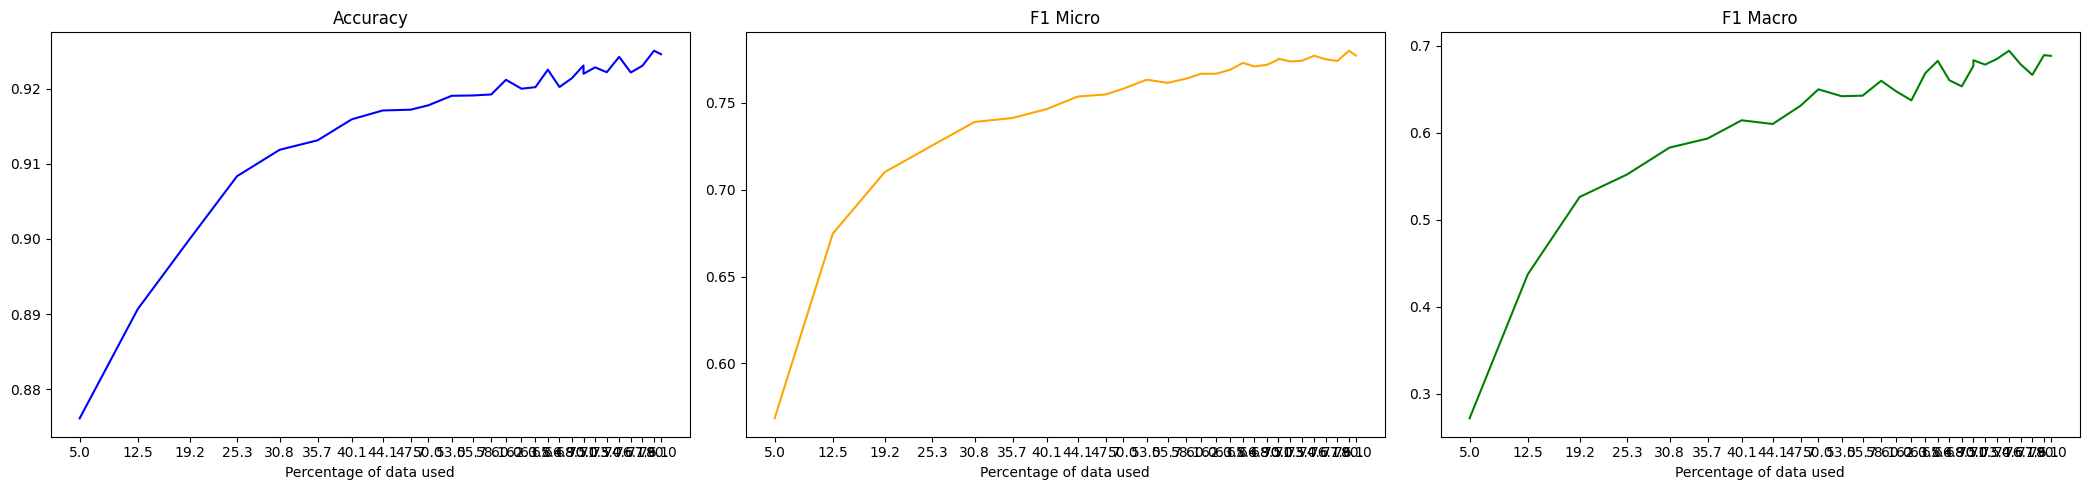

In [28]:
active_learning(seeds[4], 4)